In [1]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import gc
from tqdm import tqdm
import time
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoModel, AutoTokenizer


import pdb


# Defining global parameters

In [2]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": get_available_device(),
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=CONFIG['seed'])

# Read the already preprocessed and split data

In [3]:
train_df = pd.read_pickle('../data/train_split_remove_duplicates_molformer.pkl')
valid_df = pd.read_pickle('../data/valid_split_remove_duplicates_molformer.pkl')

## Wrapping in Pytorch Dataset

In [4]:
class EnvedaDataset(Dataset):
    def __init__(self, dataframe, labels = ['unable_to_assess', 'close_match', 
                                            'near_exact_match', 'exact_match']):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame containing 'ground_truth_embeddings', 
                                       'predicted_embeddings', and output columns.
        """
        self.dataframe = dataframe
        
        # Convert embeddings to tensors
        self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)
        self.predicted_embeddings = torch.tensor(dataframe['predicted_embeddings'].tolist(), dtype=torch.float32)
        
        # Get molecular smiles
        self.ground_truth_smiles = dataframe['ground_truth_smiles'].to_list()
        self.predicted_smiles = dataframe['predicted_smiles'].to_list()

        # Convert labels to tensor
        self.labels = torch.tensor(dataframe[labels].values, dtype=torch.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]
        # return self.ground_truth_smiles[idx], self.predicted_smiles[idx], self.labels[idx]

In [5]:
#---
trainset_unable = EnvedaDataset(dataframe=train_df, labels=['unable_to_assess'])
validset_unable = EnvedaDataset(dataframe=valid_df, labels=['unable_to_assess'])

#---
trainset_not_close = EnvedaDataset(dataframe=train_df, labels=['not_close_match'])
validset_not_close = EnvedaDataset(dataframe=valid_df, labels=['not_close_match'])

#---
trainset_close = EnvedaDataset(dataframe=train_df, labels=['close_match'])
validset_close = EnvedaDataset(dataframe=valid_df, labels=['close_match'])

#--
trainset_near = EnvedaDataset(dataframe=train_df, labels=['near_exact_match'])
validset_near = EnvedaDataset(dataframe=valid_df, labels=['near_exact_match'])

#--
trainset_exact = EnvedaDataset(dataframe=train_df, labels=['exact_match'])
validset_exact = EnvedaDataset(dataframe=valid_df, labels=['exact_match'])

#--
trainset_prioritization = EnvedaDataset(dataframe=train_df, labels=['good_enough_for_prioritization'])
validset_prioritization = EnvedaDataset(dataframe=valid_df, labels=['good_enough_for_prioritization'])


## Wrapping in Pytorch DataLoader

In [6]:
trainloader_unable = DataLoader(trainset_unable, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_unable = DataLoader(validset_unable, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_not_close = DataLoader(trainset_not_close, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_not_close = DataLoader(validset_not_close, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_close = DataLoader(trainset_close, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_close = DataLoader(validset_close, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_near = DataLoader(trainset_near, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_near = DataLoader(validset_near, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_exact = DataLoader(trainset_exact, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_exact = DataLoader(validset_exact, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_prioritization = DataLoader(trainset_prioritization, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_prioritization = DataLoader(validset_prioritization, batch_size=CONFIG['valid_batch_size'], shuffle=False)

In [7]:
gt, pred, labels = next(iter(trainloader_unable))
print(gt.shape, pred.shape, labels.shape)


torch.Size([16, 768]) torch.Size([16, 768]) torch.Size([16, 1])


### Use larger Siamese network as in notebook 2.2_feature_aggregation_siamese_multiclass_FP

In [8]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim=768, output_dim=4):
        super(SiameseNetwork, self).__init__()
        
        self.fc = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2))

        self.fc5 = nn.Linear(128, output_dim)

        
    def forward_one(self, x):
        return self.fc(x)

    def forward(self, input1, input2):
        # pdb.set_trace()
        # input1, input2 = self.smiler_embedder(**input1, output_hidden_states=True).pooler_output, \
        #                  self.smiler_embedder(**input2, output_hidden_states=True).pooler_output
        
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        # pdb.set_trace()
        # Combine both outputs by subtraction
        combined = torch.sub(out1, out2)  # maybe torch.abs(out1 - out2)
        output = self.fc5(combined)                  # Outputs raw logits
        return output
    
    
# model(gt, pred)

In [10]:
model = SiameseNetwork(output_dim=1)
model.to(CONFIG['device'])
model(gt.to(CONFIG['device']), pred.to(CONFIG['device']))

tensor([[-0.0461],
        [-0.0272],
        [-0.0285],
        [-0.0075],
        [-0.0245],
        [-0.0193],
        [-0.0235],
        [-0.0116],
        [-0.0324],
        [-0.0489],
        [-0.0553],
        [-0.0271],
        [-0.0219],
        [-0.0178],
        [-0.0320],
        [ 0.0039]], device='cuda:0', grad_fn=<AddmmBackward>)

# Training and validation regime

## Training with mixed precision, gradient accumulation, learning with scheduler
## Validation logging loss, AUROC, and F1 metrics

In [11]:
def train_one_epoch(model, optimizer, criterion, scheduler, dataloader, epoch=CONFIG['epochs']):
    model.train()
    
    scaler = GradScaler()
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    running_f1 = 0.0
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        # gt, preds = tokenizer(gt, return_tensors='pt', padding=True, truncation=True)['input_ids'], \
        #             tokenizer(preds, return_tensors='pt', padding=True, truncation=True)['input_ids']
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = targets.shape[0]

        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
            
        # Backward pass with scaling
        scaler.scale(loss).backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            # Step the optimizer
            scaler.step(optimizer)

            # Update the scale for next iteration
            scaler.update()
            # optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        # pdb.set_trace()
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        # pdb.set_trace()
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc, Train_F1=epoch_f1,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_f1 = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        # gt, preds = tokenizer(gt, return_tensors='pt', padding=True, truncation=True)['input_ids'], \
        #             tokenizer(preds, return_tensors='pt', padding=True, truncation=True)['input_ids']
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = targets.shape[0]
        
        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
        
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                        Valid_F1=epoch_f1,
                        )   
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

## Initializing components
1. Model
2. AdamW optimizer
3. Cosine annealing scheduler
4. Weighted cross entropy loss to handle class imbalance

In [16]:
# Define models, optimizers, and schedulers for each dataset
model_unable = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_unable = optim.AdamW(model_unable.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_unable = lr_scheduler.CosineAnnealingLR(optimizer_unable, T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])

model_close = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_close = optim.AdamW(model_close.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_close = lr_scheduler.CosineAnnealingLR(optimizer_close, T_max=CONFIG['T_max'], 
                                                 eta_min=CONFIG['min_lr'])

model_not_close = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_not_close = optim.AdamW(model_not_close.parameters(), lr=CONFIG['learning_rate'], 
                                   weight_decay=CONFIG['weight_decay'])
scheduler_not_close = lr_scheduler.CosineAnnealingLR(optimizer_not_close, T_max=CONFIG['T_max'], 
                                                     eta_min=CONFIG['min_lr'])

model_near = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_near = optim.AdamW(model_near.parameters(), lr=CONFIG['learning_rate'], 
                             weight_decay=CONFIG['weight_decay'])
scheduler_near = lr_scheduler.CosineAnnealingLR(optimizer_near, T_max=CONFIG['T_max'], 
                                                eta_min=CONFIG['min_lr'])

model_exact = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_exact = optim.AdamW(model_exact.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_exact = lr_scheduler.CosineAnnealingLR(optimizer_exact, T_max=CONFIG['T_max'], 
                                                 eta_min=CONFIG['min_lr'])

model_prioritization = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_prioritization = optim.AdamW(model_prioritization.parameters(), lr=CONFIG['learning_rate'], 
                                       weight_decay=CONFIG['weight_decay'])
scheduler_prioritization = lr_scheduler.CosineAnnealingLR(optimizer_prioritization, T_max=CONFIG['T_max'],
                                                          eta_min=CONFIG['min_lr'])


In [17]:

print(train_df[['unable_to_assess','not_close_match','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']].sum())
class_distribution = {'unable_to_assess': 7,
                      'not_close_match': 87, 
                      'close_match': 99, 
                      'near_exact_match': 48, 
                      'exact_match': 11,
                      'good_enough_for_prioritization': 176}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}
print(class_weights)

# Convert class weights to tensors for each dataset
pos_weights_unable = torch.tensor([class_weights['unable_to_assess']]).to(CONFIG['device'])
pos_weights_not_close = torch.tensor([class_weights['not_close_match']]).to(CONFIG['device'])
pos_weights_close = torch.tensor([class_weights['close_match']]).to(CONFIG['device'])
pos_weights_near = torch.tensor([class_weights['near_exact_match']]).to(CONFIG['device'])
pos_weights_exact = torch.tensor([class_weights['exact_match']]).to(CONFIG['device'])
pos_weights_prioritization = torch.tensor([class_weights['good_enough_for_prioritization']]).to(CONFIG['device'])

# Define the BCEWithLogitsLoss for each dataset
criterion_unable = nn.BCEWithLogitsLoss(pos_weight=pos_weights_unable)
criterion_not_close = nn.BCEWithLogitsLoss(pos_weight=pos_weights_not_close)
criterion_close = nn.BCEWithLogitsLoss(pos_weight=pos_weights_close)
criterion_near = nn.BCEWithLogitsLoss(pos_weight=pos_weights_near)
criterion_exact = nn.BCEWithLogitsLoss(pos_weight=pos_weights_exact)
criterion_prioritization = nn.BCEWithLogitsLoss(pos_weight=pos_weights_prioritization)



unable_to_assess                    7
not_close_match                    87
close_match                        99
near_exact_match                   48
exact_match                        11
good_enough_for_prioritization    176
dtype: int64
{'unable_to_assess': 10.19047619047619, 'not_close_match': 0.8199233716475096, 'close_match': 0.7205387205387206, 'near_exact_match': 1.4861111111111112, 'exact_match': 6.484848484848484, 'good_enough_for_prioritization': 0.4053030303030303}


In [20]:
# train_one_epoch(model=model_exact, optimizer=optimizer_exact, criterion=criterion_exact, scheduler=scheduler_exact, dataloader=trainloader_exact)
# valid_one_epoch(model=model_prioritization, dataloader=trainloader_prioritization, criterion=criterion_prioritization, epoch=CONFIG['epochs'])

## Putting all together into training code
Training code includes:
1. Early stopping
2. Saving best model weights according to supplied name
3. Original code adapted from Kaggle

In [21]:

def run_training(model, optimizer, scheduler, criterion, num_epochs, train_loader, valid_loader, name):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_f1 = -np.inf
    best_valid_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc, train_epoch_f1 = train_one_epoch(model=model, optimizer=optimizer, scheduler=scheduler, 
                                           criterion=criterion, dataloader=train_loader, 
                                           epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, val_epoch_f1 = valid_one_epoch(model=model, dataloader=valid_loader, criterion=criterion, 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['Valid F1'].append(val_epoch_f1)
        history['lr'].append( scheduler.get_lr()[0] )
        if val_epoch_loss <= best_valid_loss:
            print(f"Validation Loss Improved ({best_valid_loss} ---> {val_epoch_loss})")
            best_valid_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_VAL_LOSS_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
        
        if best_epoch_f1 <= val_epoch_f1:
            print(f"Validation F1 Improved ({best_epoch_f1} ---> {val_epoch_f1})")
            best_epoch_f1 = val_epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_F1_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best F1: {:.4f}".format(best_epoch_f1))
    print("Best Loss: {:.4f}".format(best_valid_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [22]:
import concurrent.futures

# Define a function to run the training for a single model
def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, name):
    return run_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        num_epochs=200,
        train_loader=train_loader,
        valid_loader=valid_loader,
        name=name
    )

# Prepare model-specific parameters
model_params = [
    (model_unable, optimizer_unable, scheduler_unable, criterion_unable, trainloader_unable, validloader_unable, 'siamese_unable'),
    (model_not_close, optimizer_not_close, scheduler_not_close, criterion_not_close, trainloader_not_close, validloader_not_close, 'siamese_not_close'),
    (model_close, optimizer_close, scheduler_close, criterion_close, trainloader_close, validloader_close, 'siamese_close'),
    (model_near, optimizer_near, scheduler_near, criterion_near, trainloader_near, validloader_near, 'siamese_near'),
    (model_exact, optimizer_exact, scheduler_exact, criterion_exact, trainloader_exact, validloader_exact, 'siamese_exact'),
    (model_prioritization, optimizer_prioritization, scheduler_prioritization, criterion_prioritization, trainloader_prioritization, validloader_prioritization, 'siamese_prioritization')
]

# Use ThreadPoolExecutor to parallelize the training
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(train_model, *params): name for params, name in zip(model_params, ['siamese_unable', 'siamese_close', 'siamese_near', 'siamese_exact', 'siamese_prioritization'])}
    
    for future in concurrent.futures.as_completed(futures):
        model_name = futures[future]
        try:
            trained_model, history = future.result()
            print(f"Training completed for model: {model_name}")
        except Exception as e:
            print(f"Model {model_name} generated an exception: {e}")


[INFO] Using GPU: GeForce GTX 1650 Ti

[INFO] Using GPU: GeForce GTX 1650 Ti

[INFO] Using GPU: GeForce GTX 1650 Ti

[INFO] Using GPU: GeForce GTX 1650 Ti

[INFO] Using GPU: GeForce GTX 1650 Ti



  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/22 [00:00<?, ?it/s, Epoch=1, LR=4.92e-5, Train_Auroc=0.0714, Train_F1=0.841, Train_Loss=1.1]





  5%|▍         | 1/22 [00:00<00:04,  4.44it/s, Epoch=1, LR=4.92e-5, Train_Auroc=0.0714, Train_F1=0.841, Train_Loss=1.1]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:00<00:04,  4.57it/s, Epoch=1, LR=4.67e-5, Train_Auroc=0.0357, Train_F1=0.849, Train_Loss=0.892]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  9%|▉         | 2/22 [00:00<00:04,  4.57it/s, Epoch=1, LR=4.

Validation Loss Improved (inf ---> 0.9060512293468822)
Model Saved
Validation F1 Improved (-inf ---> 0.9491649012925607)


Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  2.58it/s, Epoch=1, Valid_Auroc=0.727, Valid_F1=0.983, Valid_Loss=0.718]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "









Validation Loss Improved (inf ---> 0.7184486443346197)
Model Saved
Validation F1 Improved (-inf ---> 0.9829992841803865)
Model Saved




100%|██████████| 2/2 [00:00<00:00,  3.33it/s, Epoch=1, Valid_Auroc=0.324, Valid_F1=0.137, Valid_Loss=0.651]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 22/22 [00:06<00:00,  3.15it/s, Epoch=1, LR=4.67e-5, Train_Auroc=0.332, Train_F1=0.167, Train_Loss=0.671]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Validation Loss Improved (inf ---> 0.6511453065005216)
Model Saved
Validation F1 Improved (-inf ---> 0.1368737883889399)
Validation Loss Improved (inf ---> 0.7545952905308116)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:15,  1.34it/s, Epoch=2, LR=3.17e-5, Train_Auroc=0, Train_F1=0.933, Train_Loss=0.678]

Model Saved
Validation F1 Improved (-inf ---> 0.7066629023150761)
Model Saved















100%|██████████| 2/2 [00:00<00:00,  3.67it/s, Epoch=1, Valid_Auroc=0.325, Valid_F1=0.103, Valid_Loss=0.67]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:01<00:15,  1.34it/s, Epoch=2, LR=3.76e-5, Train_Auroc=0, Train_F1=0.967, Train_Loss=0.674]

  9%|▉         | 2/22 [00:01<00:14,  1.42it/s, Epoch=2, LR=3.76e-5, Train_Auroc=0, Train_F1=0.967, Train_Loss=0.674]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








Validation Loss Improved (inf ---> 0.6702451109886169)
Model Saved
Validation F1 Improved (-inf ---> 0.10278745644599302)
Model Saved




 14%|█▎        | 3/22 [00:01<00:10,  1.83it/s, Epoch=2, LR=4.28e-5, Train_Auroc=0.0833, Train_F1=0.936, Train_Loss=0.754]











 18%|█▊        | 4/22 [00:01<00:07,  2.48it/s, Epoch=2, LR=4.67e-5, Train_Auroc=0.312, Train_F1=0.952, Train_Loss=0.794] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:02<00:05,  3.01it/s, Epoch=2, LR=4.92e-5, Train_Auroc=0.25, Train_F1=0.962, Train_Loss=0.769] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No pos

Validation Loss Improved (0.9060512293468822 ---> 0.9055365215648304)
Model Saved
Validation F1 Improved (0.9491649012925607 ---> 0.9491649012925607)
Validation Loss Improved (0.7184486443346197 ---> 0.7152521501887928)


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:04<00:00,  4.67it/s, Epoch=2, LR=3.76e-5, Train_Auroc=0.258, Train_F1=0.787, Train_Loss=0.728]

Model Saved

Model Saved
Validation F1 Improved (0.9829992841803865 ---> 1.0)




  0%|          | 0/22 [00:00<?, ?it/s]



Model Saved



100%|██████████| 22/22 [00:05<00:00,  3.19it/s, Epoch=2, LR=3.76e-5, Train_Auroc=0.347, Train_F1=0.136, Train_Loss=0.654]

100%|██████████| 22/22 [00:05<00:00,  4.05it/s, Epoch=2, LR=3.76e-5, Train_Auroc=0.347, Train_F1=0.136, Train_Loss=0.654]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  5%|▍         | 1/22 [00:00<00:10,  2.06it/s, Epoch=3, LR=4.28e-5, Train_Auroc=0, Train_F1=0.897, Train_Loss=0.682]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 2/2 [00:00<00:00,  4.60it/s, Epoch=2, Valid_Auroc=0.242, Valid_F1=0.707, Valid_Loss=0.754]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
 

Validation Loss Improved (0.7545952905308116 ---> 0.7537439953197133)
Validation Loss Improved (0.6511453065005216 ---> 0.650614776394584)


  9%|▉         | 2/22 [00:00<00:09,  2.03it/s, Epoch=3, LR=4.67e-5, Train_Auroc=0, Train_F1=0.897, Train_Loss=0.683]



Model Saved
Validation F1 Improved (0.7066629023150761 ---> 0.7066629023150761)
Model Saved
Validation F1 Improved (0.1368737883889399 ---> 0.1368737883889399)
Model Saved



100%|██████████| 22/22 [00:05<00:00,  3.91it/s, Epoch=2, LR=3.76e-5, Train_Auroc=0.444, Train_F1=0.211, Train_Loss=0.669]

Model Saved










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 14%|█▎        | 3/22 [00:01<00:11,  1.68it/s, Epoch=3, LR=4.92e-5, Train_Auroc=0, Train_F1=0.897, Train_Loss=0.683]











100%|██████████| 2/2 [00:00<00:00,  8.87it/s, Epoch=2, Valid_Auroc=0.295, Valid_F1=0.103, Valid_Loss=0.669]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn

Validation Loss Improved (0.6702451109886169 ---> 0.6694632118398492)
Model Saved
Validation F1 Improved (0.10278745644599302 ---> 0.10278745644599302)
Model Saved












 23%|██▎       | 5/22 [00:02<00:08,  2.06it/s, Epoch=3, LR=4.92e-5, Train_Auroc=0.0889, Train_F1=0.874, Train_Loss=0.844]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 23%|██▎       | 5/22 [00:02<00:08,  2.06it/s, Epoch=3, LR=4.67e-5, Train_Auroc=0.0741, Train_F1=0.857, Train_Loss=0.818]


 27%|██▋       | 6/22 [00:02<00:06,  2.41it/s, Epoch=3, LR=4.67e-5, Train_Auroc=0.0741, Train_F1=0.857, Train_Loss=0.818]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No po

Validation Loss Improved (0.9055365215648304 ---> 0.9051051790064032)
Model Saved
Validation F1 Improved (0.9491649012925607 ---> 0.9491649012925607)
Model Saved



 82%|████████▏ | 18/22 [00:03<00:00,  5.57it/s, Epoch=3, LR=3.82e-6, Train_Auroc=0.413, Train_F1=0.273, Train_Loss=0.667]



  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.69it/s, Epoch=3, LR=3.82e-6, Train_Auroc=0.186, Train_F1=0.896, Train_Loss=0.791]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=4, LR=3.17e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.682]

  5%|▍         | 1/22 [00:00<00:08,  2.36it/s, Epoch=4, LR=3.17e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.682]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to o

Validation Loss Improved (0.7152521501887928 ---> 0.7105272358114069)
Model Saved
Validation F1 Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 22/22 [00:05<00:00,  3.80it/s, Epoch=3, LR=2.53e-5, Train_Auroc=0.239, Train_F1=0.763, Train_Loss=0.728]




100%|██████████| 22/22 [00:06<00:00,  3.62it/s, Epoch=3, LR=2.53e-5, Train_Auroc=0.389, Train_F1=0.148, Train_Loss=0.653]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:10,  1.73it/s, Epoch=4, LR=4.28e-5, Train_Auroc=0.333, Train_F1=0.912, Train_Loss=0.813]





100%|██████████| 2/2 [00:00<00:00,  4.20it/s, Epoch=3, Valid_Auroc=0.245, Valid_F1=0.707, Valid_Loss=0.752]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


100%|██████████| 2/2 [00:00<00:00,  4.52it/s, Epoch=3, Valid_Auroc=0.366, Valid_F1=0.137, Val

Validation Loss Improved (0.7537439953197133 ---> 0.7524883963844993)
Validation Loss Improved (0.650614776394584 ---> 0.6498601761731234)



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






100%|██████████| 22/22 [00:06<00:00,  3.55it/s, Epoch=3, LR=2.53e-5, Train_Auroc=0.408, Train_F1=0.261, Train_Loss=0.668]


Model Saved
Validation F1 Improved (0.7066629023150761 ---> 0.7066629023150761)
Model Saved
Validation F1 Improved (0.1368737883889399 ---> 0.1368737883889399)




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 18%|█▊        | 4/22 [00:02<00:11,  1.53it/s, Epoch=4, LR=4.67e-5, Train_Auroc=0.25, Train_F1=0.908, Train_Loss=0.781] 

Model Saved



Model Saved







  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.62it/s, Epoch=3, Valid_Auroc=0.289, Valid_F1=0.168, Valid_Loss=0.669]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:02<00:12,  1.54it/s, Epoch=4, LR=1.88e-5, Train_Auroc=0

Validation Loss Improved (0.6694632118398492 ---> 0.6687138351527128)
Model Saved
Validation F1 Improved (0.10278745644599302 ---> 0.1684611326777671)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:03<00:09,  1.71it/s, Epoch=4, LR=5e-5, Train_Auroc=0.167, Train_F1=0.917, Train_Loss=0.747] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 32%|███▏      | 7/22 [00:03<00:07,  2.12it/s, Epoch=4, LR=4.92e-5, Train_Auroc=0.143, Train_F1=0.896, Train_Loss=0.739]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:03<00:05,  2.53it/s, Epoc

Validation Loss Improved (0.9051051790064032 ---> 0.904444997960871)
Model Saved
Validation F1 Improved (0.9491649012925607 ---> 0.9491649012925607)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.76it/s, Epoch=5, LR=1.88e-5, Train_Auroc=0, Train_F1=0.857, Train_Loss=0.687]











100%|██████████| 22/22 [00:06<00:00,  3.41it/s, Epoch=4, LR=5e-7, Train_Auroc=0.343, Train_F1=0.911, Train_Loss=0.784]]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 1

Validation Loss Improved (0.7105272358114069 ---> 0.703784628347917)


Model Saved



 95%|█████████▌| 21/22 [00:05<00:00,  3.57it/s, Epoch=4, LR=1.29e-5, Train_Auroc=0.431, Train_F1=0.154, Train_Loss=0.652]




 86%|████████▋ | 19/22 [00:05<00:00,  3.39it/s, Epoch=4, LR=3.82e-6, Train_Auroc=0.362, Train_F1=0.351, Train_Loss=0.668]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 18%|█▊        | 4/22 [00:01<00:08,  2.11it/s, Epoch=5, LR=3.76e-5, Train_Auroc=0.0917, Train_F1=0.879, Train_Loss=0.882]


100%|██████████| 2/2 [00:00<00:00,  3.36it/s, Epoch=4, Valid_Auroc=0.232, Valid_F1=0.707, Valid_Loss=0.751]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive clas

Validation Loss Improved (0.7524883963844993 ---> 0.7508353861895475)
Model Saved
Validation F1 Improved (0.7066629023150761 ---> 0.7066629023150761)


 23%|██▎       | 5/22 [00:02<00:09,  1.85it/s, Epoch=5, LR=4.28e-5, Train_Auroc=0.0733, Train_F1=0.866, Train_Loss=0.843]




Model Saved



100%|██████████| 2/2 [00:00<00:00,  3.25it/s, Epoch=4, Valid_Auroc=0.395, Valid_F1=0.137, Valid_Loss=0.649]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Validation Loss Improved (0.6498601761731234 ---> 0.6489186612042513)


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




Model Saved
Validation F1 Improved (0.1368737883889399 ---> 0.1368737883889399)
Model Saved










100%|██████████| 22/22 [00:06<00:00,  3.22it/s, Epoch=4, LR=1.29e-5, Train_Auroc=0.356, Train_F1=0.342, Train_Loss=0.668]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 32%|███▏      | 7/22 [00:03<00:08,  1.86it/s, Epoch=5, LR=4.92e-5, Train_Auroc=0.0667, Train_F1=0.855, Train_Loss=0.855]

100%|██████████| 2/2 [00:00<00:00,  6.92it/s, Epoch=4, Valid_Auroc=0.257, Valid_F1=0.277, Valid_Loss=0.668]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






Validation Loss Improved (0.6687138351527128 ---> 0.6678078066218983)
Model Saved
Validation F1 Improved (0.1684611326777671 ---> 0.2766166327951225)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 32%|███▏      | 7/22 [00:03<00:08,  1.86it/s, Epoch=5, LR=5e-5, Train_Auroc=0.0583, Train_F1=0.855, Train_Loss=0.833]   



 36%|███▋      | 8/22 [00:04<00:07,  1.79it/s, Epoch=5, LR=5e-5, Train_Auroc=0.0583, Train_F1=0.855, Train_Loss=0.833]



 36%|███▋      | 8/22 [00:04<00:07,  1.79it/s, Epoch=5, LR=4.92e-5, Train_Auroc=0.0598, Train_F1=0.845, Train_Loss=0.863]



 41%|████      | 9/22 [00:04<00:05,  2.24it/s, Epoch=5, LR=4.92e-5, Train_Auroc=0.0598, Train_F1=0.845, Train_Loss=0.863]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 45%|████▌     | 10/22 [00:04<00:04,  2.74it/s, Epoch=5, LR=4.67e-5, Train_Auroc=0.154, Train_F1=0.855, Train_Loss=0.883]







d:\cs\envs\dpl\lib\site

Validation Loss Improved (0.904444997960871 ---> 0.9033021059903231)
Model Saved
Validation F1 Improved (0.9491649012925607 ---> 0.960348162475822)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:03,  5.39it/s, Epoch=6, LR=7.75e-6, Train_Auroc=0.167, Train_F1=0.841, Train_Loss=1.09]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.53it/s, Epoch=6, LR=1.29e-5, Train_Auroc=0.0833, Train_F1=0.805, Train_Loss=0.883]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.53it/s, Epoch=6, LR=1.88e-5, Train_Auroc=0.0556, Train_F1=0.859, Train_Loss=0.813]


 14%|█▎        | 3/22 [00:00<00:03,  5.71it/s, Epoch

Validation Loss Improved (0.703784628347917 ---> 0.6951756043867632)
Model Saved











100%|██████████| 22/22 [00:06<00:00,  3.27it/s, Epoch=5, LR=3.82e-6, Train_Auroc=0.242, Train_F1=0.775, Train_Loss=0.723]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 23%|██▎       | 5/22 [00:01<00:05,  3.22it/s, Epoch=6, LR=3.76e-5, Train_Auroc=0.0556, Train_F1=0.88, Train_Loss=0.813]

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=5, Valid_Auroc=0.279, Valid_F1=0.678, Valid_Loss=0.768]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:06,  2.62it/s, Epoch=6, LR=3.76e-5, Train_Auroc=0.0556, Train_F1=0.88, Train_Loss=0.813]









100%|██████████| 22/22 [00:06<00:00,  3.18it/s, Epoch=5, LR=3.82e-6, Train_Auroc=0.414, Train_F1=0.185, Train_Loss=0.65]

100%|██████████| 2/2 [00:00<00:00,  3.94it/s, Epoch=

Validation Loss Improved (0.7508353861895475 ---> 0.7488433014262806)


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:07,  2.10it/s, Epoch=6, LR=4.28e-5, Train_Auroc=0.0476, Train_F1=0.893, Train_Loss=0.794]

Model Saved
Validation F1 Improved (0.7066629023150761 ---> 0.7322652808586312)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 2/2 [00:00<00:00,  5.66it/s, Epoch=5, Valid_Auroc=0.437, Valid_F1=0.146, Valid_Loss=0.647]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


100%|██████████| 22/22 [00:06<00:00,  3.20it/s, Epoch=5, LR=3.82e-6, Train_Auroc=0.395, Train_F1=0.387, Train_Loss=0.666]

Validation Loss Improved (0.6489186612042513 ---> 0.6473616307432001)
Model Saved
Validation F1 Improved (0.1368737883889399 ---> 0.1462381752879332)



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:03<00:08,  1.60it/s, Epoch=6, LR=4.67e-5, Train_Auroc=0.0417, Train_F1=0.898, Train_Loss=0.78] 

Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:03<00:06,  2.01it/s, Epoch=6, LR=4.92e-5, Train_Auroc=0.037, Train_F1=0.906, Train_Loss=0.768]

100%|██████████| 2/2 [00:00<00:00,  4.07it/s, Epoch=5, Valid_Auroc=0.247, Valid_F1=0.323, Valid_Loss=0.667]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





Validation Loss Improved (0.6678078066218983 ---> 0.666706843809648)
Model Saved
Validation F1 Improved (0.2766166327951225 ---> 0.3225308937637705)
Model Saved



 45%|████▌     | 10/22 [00:04<00:06,  1.82it/s, Epoch=6, LR=5e-5, Train_Auroc=0.0333, Train_F1=0.901, Train_Loss=0.76]  

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 23%|██▎       | 5/22 [00:03<00:09,  1.71it/s, Epoch=6, LR=7.75e-6, Train_Auroc=0, Train_F1=0.894, Train_Loss=0.654]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 50%|█████     | 11/22 [00:04<00:05,  2.08it/s, Epoch=6, LR=4.92e-5, Train_Auroc=0.0303, Train_F1=0.904, Train_Loss=0.752]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is

Validation Loss Improved (0.9033021059903231 ---> 0.9021933566440236)
Model Saved






  0%|          | 0/22 [00:00<?, ?it/s]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:06,  3.29it/s, Epoch=7, LR=1.34e-6, Train_Auroc=0.167, Train_F1=0.875, Train_Loss=1.08]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:04,  4.39it/s, Epoch=7, LR=3.82e-6, Train_Auroc=0.0833, Train_F1=0.866, Train_Loss=0.88]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:00<00:04,  4.69it/s, Epoch=7, LR=7.75e-6, Train_Auroc=0.0972, Train_F1=0.802, Train_Loss=0.949]











 18%|█▊        | 4/22 [00:00<00:03,  4.74it/s, Epoch=7, L

Validation Loss Improved (0.6951756043867632 ---> 0.6822605024684559)
Model Saved











100%|██████████| 22/22 [00:07<00:00,  3.07it/s, Epoch=6, LR=5e-7, Train_Auroc=0.33, Train_F1=0.792, Train_Loss=0.718]



 36%|███▋      | 8/22 [00:02<00:05,  2.43it/s, Epoch=7, LR=3.76e-5, Train_Auroc=0.182, Train_F1=0.852, Train_Loss=0.926]




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=6, Valid_Auroc=0.275, Valid_F1=0.678, Valid_Loss=0.766]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 22/22 [00:06<00:00,  3.22it/s, Epoch=6, LR=5e-7, Train_Auroc=0.451, Train_F1=0.277, Train_Loss=0.648]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, Epoch=6, Valid_Auroc=0.226, Valid_F1=0.726, Valid_Loss=0.746]n_Loss=0.899]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508:

Validation Loss Improved (0.7488433014262806 ---> 0.7462738969109275)
Model Saved












100%|██████████| 2/2 [00:00<00:00,  3.42it/s, Epoch=6, Valid_Auroc=0.445, Valid_F1=0.295, Valid_Loss=0.646]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 22/22 [00:07<00:00,  3.11it/s, Epoch=6, LR=5e-7, Train_Auroc=0.381, Train_F1=0.433, Train_Loss=0.666]16]


Validation Loss Improved (0.6473616307432001 ---> 0.6457349387082186)
Model Saved
Validation F1 Improved (0.1462381752879332 ---> 0.29518804518804515)






  0%|          | 0/22 [00:00<?, ?it/s, Epoch=7, LR=1.34e-6, Train_Auroc=0.289, Train_F1=0.611, Train_Loss=0.764]

Model Saved












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 50%|█████     | 11/22 [00:04<00:06,  1.76it/s, Epoch=7, LR=4.92e-5, Train_Auroc=0.163, Train_F1=0.872, Train_Loss=0.895]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  3.43it/s, Epoch=6, Valid_Auroc=0.246, Valid_F1=0.406, Valid_Loss=0.665]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍

Validation Loss Improved (0.666706843809648 ---> 0.6653334498405457)
Model Saved
Validation F1 Improved (0.3225308937637705 ---> 0.40587440850979917)
Model Saved








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 59%|█████▉    | 13/22 [00:05<00:04,  2.06it/s, Epoch=7, LR=4.92e-5, Train_Auroc=0.138, Train_F1=0.876, Train_Loss=0.861]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:05<00:04,  2.06it/s, Epoch=7, LR=4.67e-5, Train_Auroc=0.128, Train_F1=0.88, Train_Loss=0.848] 

 64%|██████▎   | 14/22 [00:05<00:03,  2.44it/s, Epoch=7, LR=4.67e-5, Train_Auroc=0.128, Train_F1=0.88, Train_Loss=0.848]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 

Validation Loss Improved (0.9021933566440236 ---> 0.9011019197377291)
Model Saved





  0%|          | 0/22 [00:00<?, ?it/s]








  5%|▍         | 1/22 [00:00<00:02,  8.03it/s, Epoch=8, LR=1.34e-6, Train_Auroc=0.5, Train_F1=0.902, Train_Loss=1.06]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.81it/s, Epoch=8, LR=5e-7, Train_Auroc=0.25, Train_F1=0.935, Train_Loss=0.865] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎

Validation Loss Improved (0.6822605024684559 ---> 0.6642960851842706)
Model Saved



 91%|█████████ | 20/22 [00:05<00:00,  5.15it/s, Epoch=7, LR=7.75e-6, Train_Auroc=0.494, Train_F1=0.367, Train_Loss=0.644]








100%|██████████| 2/2 [00:00<00:00,  3.69it/s, Epoch=7, Valid_Auroc=0.228, Valid_F1=0.694, Valid_Loss=0.743]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

 86%|████████▋ | 19/22 [00:05<00:00,  4.65it/s, Epoch=7, LR=1.29e-5, Train_Auroc=0.426, Train_F1=0.512, Train_Loss=0.663]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 91%|█████████ | 20/22 [00:05<00:00,  2.71it/s, Epoch=7, LR=1.29e-5, Train_Auroc=0.426, Train_F1=0.512, Train_Loss=0.663]

Validation Loss Improved (0.7462738969109275 ---> 0.7430241974917325)
Model Saved



 50%|█████     | 11/22 [00:02<00:03,  2.86it/s, Epoch=8, LR=4.28e-5, Train_Auroc=0.128, Train_F1=0.852, Train_Loss=0.896]




100%|██████████| 22/22 [00:06<00:00,  3.41it/s, Epoch=7, LR=3.82e-6, Train_Auroc=0.488, Train_F1=0.355, Train_Loss=0.646]


  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:02<00:03,  2.90it/s, Epoch=8, LR=4.67e-5, Train_Auroc=0.118, Train_F1=0.861, Train_Loss=0.876]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  7.69it/s, Epoch=7, Val

Validation Loss Improved (0.6457349387082186 ---> 0.6434451558373191)
Model Saved
Validation F1 Improved (0.29518804518804515 ---> 0.3186371100164203)


Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 64%|██████▎   | 14/22 [00:03<00:03,  2.39it/s, Epoch=8, LR=5e-5, Train_Auroc=0.101, Train_F1=0.874, Train_Loss=0.847]   





100%|██████████| 2/2 [00:00<00:00,  5.05it/s, Epoch=7, Valid_Auroc=0.245, Valid_F1=0.432, Valid_Loss=0.663]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib

Validation Loss Improved (0.6653334498405457 ---> 0.6629488088867881)
Model Saved
Validation F1 Improved (0.40587440850979917 ---> 0.4322551023430789)
Model Saved



 68%|██████▊   | 15/22 [00:04<00:02,  2.46it/s, Epoch=8, LR=4.92e-5, Train_Auroc=0.094, Train_F1=0.878, Train_Loss=0.835]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:02,  2.64it/s, Epoch=8, LR=4.67e-5, Train_Auroc=0.0882, Train_F1=0.879, Train_Loss=0.825]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:04<00:01,  3.10it/s, Epoch=8, LR=4.28e-5, Train_Auroc=0.083, Train_F1=0.878, Train_Loss=0.817] 


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 82%|████████▏ | 18/22 [00:04<00:01,  3.55it/s, Epoch=8, LR=3.76e-5, Train_Auroc=0.134, Train

Validation Loss Improved (0.9011019197377291 ---> 0.8999226310036399)
Model Saved



 45%|████▌     | 10/22 [00:03<00:03,  3.28it/s, Epoch=8, LR=4.28e-5, Train_Auroc=0.354, Train_F1=0.81, Train_Loss=0.7] 



  0%|          | 0/22 [00:00<?, ?it/s]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:04,  4.48it/s, Epoch=9, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.668]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  9%|▉         | 2/22 [00:00<00:04,  4.31it/s, Epoch=9, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.929, Train_Loss=0.859]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: User

Validation Loss Improved (0.6642960851842706 ---> 0.6426098346710205)
Model Saved



100%|██████████| 2/2 [00:00<00:00,  2.82it/s, Epoch=8, Valid_Auroc=0.227, Valid_F1=0.68, Valid_Loss=0.739]

Validation Loss Improved (0.7430241974917325 ---> 0.7389989441091364)



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




Model Saved



 59%|█████▉    | 13/22 [00:03<00:04,  1.95it/s, Epoch=9, LR=4.28e-5, Train_Auroc=0.117, Train_F1=0.902, Train_Loss=0.792]




100%|██████████| 22/22 [00:06<00:00,  3.21it/s, Epoch=8, LR=1.29e-5, Train_Auroc=0.447, Train_F1=0.434, Train_Loss=0.643]









 59%|█████▉    | 13/22 [00:04<00:04,  1.95it/s, Epoch=9, LR=4.67e-5, Train_Auroc=0.18, Train_F1=0.899, Train_Loss=0.812] 



 64%|██████▎   | 14/22 [00:04<00:03,  2.11it/s, Epoch=9, LR=4.67e-5, Train_Auroc=0.18, Train_F1=0.899, Train_Loss=0.812]

100%|██████████| 2/2 [00:00<00:00,  8.89it/s, Epoch=8, Valid_Auroc=0.421, Valid_F1=0.433, Valid_Loss=0.641]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thres

Validation Loss Improved (0.6434451558373191 ---> 0.6409375992688265)
Model Saved
Validation F1 Improved (0.3186371100164203 ---> 0.43343497082627525)





 64%|██████▎   | 14/22 [00:05<00:03,  2.11it/s, Epoch=9, LR=4.92e-5, Train_Auroc=0.168, Train_F1=0.899, Train_Loss=0.802]


 68%|██████▊   | 15/22 [00:05<00:03,  1.77it/s, Epoch=9, LR=4.92e-5, Train_Auroc=0.168, Train_F1=0.899, Train_Loss=0.802]

Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 68%|██████▊   | 15/22 [00:05<00:03,  1.77it/s, Epoch=9, LR=5e-5, Train_Auroc=0.167, Train_F1=0.89, Train_Loss=0.846]    


 73%|███████▎  | 16/22 [00:05<00:02,  2.21it/s, Epoch=9, LR=5e-5, Train_Auroc=0.167, Train_F1=0.89, Train_Loss=0.846]




100%|██████████| 2/2 [00:00<00:00,  7.14it/s, Epoch=8, Valid_Auroc=0.248, Valid_F1=0.468, Valid_Loss=0.66]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






Validation Loss Improved (0.6629488088867881 ---> 0.6596557335420088)
Model Saved
Validation F1 Improved (0.4322551023430789 ---> 0.46792246792246794)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 77%|███████▋  | 17/22 [00:05<00:02,  2.11it/s, Epoch=9, LR=4.92e-5, Train_Auroc=0.157, Train_F1=0.89, Train_Loss=0.836]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:06<00:01,  2.50it/s, Epoch=9, LR=4.67e-5, Train_Auroc=0.148, Train_F1=0.892, Train_Loss=0.826]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:89

Validation Loss Improved (0.8999226310036399 ---> 0.8983767303553495)
Model Saved






  0%|          | 0/22 [00:00<?, ?it/s]









  0%|          | 0/22 [00:00<?, ?it/s, Epoch=10, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.662]


  5%|▍         | 1/22 [00:00<00:04,  4.78it/s, Epoch=10, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.662]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:04,  4.45it/s, Epoch=10, LR=1.29e-5, Train_Auroc=0.188, Train_F1=0.891, Train_Loss=1.06]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.45it/s, Epoch=10, LR=7.75e-6, Tr

Validation Loss Improved (0.7389989441091364 ---> 0.7333143082532015)
Validation Loss Improved (0.6426098346710205 ---> 0.6197270263325084)


Model Saved



Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:03,  2.27it/s, Epoch=10, LR=4.28e-5, Train_Auroc=0.0407, Train_F1=0.874, Train_Loss=0.774]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 68%|██████▊   | 15/22 [00:04<00:03,  2.27it/s, Epoch=10, LR=4.67e-5, Train_Auroc=0.0382, Train_F1=0.873, Train_Loss=0.768]


 73%|███████▎  | 16/22 [00:04<00:02,  2.30it/s, Epoch=10, LR=4.67e-5, 

Validation Loss Improved (0.6409375992688265 ---> 0.6375219117511403)
Model Saved
Validation F1 Improved (0.43343497082627525 ---> 0.5024378939432199)
Model Saved



100%|██████████| 22/22 [00:07<00:00,  2.94it/s, Epoch=9, LR=2.53e-5, Train_Auroc=0.43, Train_F1=0.568, Train_Loss=0.655]

 77%|███████▋  | 17/22 [00:05<00:01,  2.56it/s, Epoch=10, LR=5e-5, Train_Auroc=0.0895, Train_F1=0.871, Train_Loss=0.776]   


 82%|████████▏ | 18/22 [00:05<00:01,  2.02it/s, Epoch=10, LR=5e-5, Train_Auroc=0.0895, Train_F1=0.871, Train_Loss=0.776]












 82%|████████▏ | 18/22 [00:05<00:01,  2.02it/s, Epoch=10, LR=4.92e-5, Train_Auroc=0.103, Train_F1=0.872, Train_Loss=0.813]



100%|██████████| 2/2 [00:00<00:00,  6.01it/s, Epoch=9, Valid_Auroc=0.254, Valid_F1=0.481, Valid_Loss=0.655]ain_Loss=0.813]



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



Validation Loss Improved (0.6596557335420088 ---> 0.6554294932972301)
Model Saved
Validation F1 Improved (0.46792246792246794 ---> 0.48089393026101884)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 86%|████████▋ | 19/22 [00:06<00:01,  2.30it/s, Epoch=10, LR=4.67e-5, Train_Auroc=0.0976, Train_F1=0.878, Train_Loss=0.805]


 91%|█████████ | 20/22 [00:06<00:00,  2.13it/s, Epoch=10, LR=4.67e-5, Train_Auroc=0.0976, Train_F1=0.878, Train_Loss=0.805]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  2.13it/s, Epoch=10, LR=4.28e-5, Train_Auroc=0.093, Train_F1=0.882, Train_Loss=0.797] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:06<00:00,  2.53it/s, Epoch=10, LR=4.28e-5, Train_Auroc=0.093, Train_F1=0.8

Validation Loss Improved (0.8983767303553495 ---> 0.8974772420796481)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]















 36%|███▋      | 8/22 [00:03<00:06,  2.08it/s, Epoch=10, LR=1.34e-6, Train_Auroc=0.189, Train_F1=0.868, Train_Loss=0.699]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  5%|▍         | 1/22 [00:00<00:05,  3.75it/s, Epoch=11, LR=3.17e-5, Train_Auroc=0, Train_F1=0.933, Train_Loss=0.666]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  5%|▍         | 1/22 [00:00<00:05,  3.75it/s, Epoch=11, LR=2.53e-5, Train_Auroc=0, Train_F1=0.915, Train_Loss=0.664]


  9%|▉         | 2/22 [00:00<00:05,  3.97it/s, Epoch=11, LR=2.53e-5, Train_Auroc=0, Train_F1=0.915, Train_Loss=0.664]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_t

Validation Loss Improved (0.7333143082532015 ---> 0.7286161834543402)


Model Saved







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 73%|███████▎  | 16/22 [00:03<00:01,  3.87it/s, Epoch=11, LR=3.76e-5, Train_Auroc=0.124, Train_F1=0.888, Train_Loss=0.778]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:03<00:01,  4.07it/s, Epoch=11, LR=4.28e-5, Train_Auroc=0.116, Train_F1=0.881, Train_Loss=0.772]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  4.08it/s, Epoch=10, Valid_Auroc=0.727, Valid_F1=0.839, Valid_Loss=0.595]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, 

Validation Loss Improved (0.6197270263325084 ---> 0.5947631705891002)
Model Saved








 82%|████████▏ | 18/22 [00:04<00:01,  2.95it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.114, Train_F1=0.879, Train_Loss=0.79] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.33it/s, Epoch=10, LR=3.76e-5, Train_Auroc=0.434, Train_F1=0.535, Train_Loss=0.635]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  7.65it/s, Epoch=10, Valid_Auroc=0.415, Valid_F1=0.518, Valid_Loss=0.633]Loss=0.775]   
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get t

Validation Loss Improved (0.6375219117511403 ---> 0.6330855434591119)
Model Saved
Validation F1 Improved (0.5024378939432199 ---> 0.5184543991362174)


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Model Saved








 95%|█████████▌| 21/22 [00:05<00:00,  1.99it/s, Epoch=11, LR=4.92e-5, Train_Auroc=0.11, Train_F1=0.882, Train_Loss=0.789]





100%|██████████| 2/2 [00:00<00:00,  9.76it/s, Epoch=10, Valid_Auroc=0.242, Valid_F1=0.481, Valid_Loss=0.65]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.58it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.106, Train_F1=0.886, Train_Loss=0.783]




Validation Loss Improved (0.6554294932972301 ---> 0.6500666249882091)
Model Saved



  0%|          | 0/2 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/2 [00:00<?, ?it/s, Epoch=11, Valid_Auroc=0.185, Valid_F1=0.871, Valid_Loss=0.864]


 50%|█████     | 1/2 [00:00<00:00,  5.43it/s, Epoch=11, Valid_Auroc=0.185, Valid_F1=0.871, Valid_Loss=0.864]


 50%|█████     | 1/2 [00:00<00:00,  5.43it/s, Epoch=11, Valid_Auroc=0.148, Valid_F1=0.843, Valid_Loss=0.893]


100%|██████████| 2/2 [00:00<00:00,  5.44it/s, Epoch=11, Valid_Auroc=0.148, Valid_F1=0.843, Valid_Loss=0.893]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






Validation Loss Improved (0.8974772420796481 ---> 0.8929820385846224)
Model Saved





  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.85it/s, Epoch=12, LR=4.28e-5, Train_Auroc=0, Train_F1=0.897, Train_Loss=0.653]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.47it/s, Epoch=12, LR=3.76e-5, Train_Auroc=0, Train_F1=0.932, Train_Loss=0.64]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎

Validation Loss Improved (0.7286161834543402 ---> 0.7226734486493197)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 77%|███████▋  | 17/22 [00:03<00:01,  4.14it/s, Epoch=12, LR=3.17e-5, Train_Auroc=0.0363, Train_F1=0.887, Train_Loss=0.715]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:06<00:00,  3.20it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.266, Train_F1=0.871, Train_Loss=0.64]










 77%|███████▋  | 17/22 [00:05<00:01,  3.26it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.501, Train_F1=0.618, Train_Loss=0.626]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 82%|████████▏ | 18/22 [00:03<00:00,  4.15it/s, Epoch=12, LR=3.76e-5, Train_Auroc=0.0343, Train_F1

Validation Loss Improved (0.5947631705891002 ---> 0.5736235055056486)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 86%|████████▋ | 19/22 [00:04<00:00,  3.36it/s, Epoch=12, LR=4.28e-5, Train_Auroc=0.0325, Train_F1=0.879, Train_Loss=0.71]





 86%|████████▋ | 19/22 [00:04<00:00,  3.36it/s, Epoch=12, LR=4.67e-5, Train_Auroc=0.0489, Train_F1=0.874, Train_Loss=0.746]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:04<00:00,  4.68it/s, Epoch=12, LR=4.92e-5, Train_Auroc=0.0466, Train_F1=0.879, Train_Loss=0.74] 



100%|██████████| 22/22 [00:05<00:00,  4.01it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.441, Tr

Validation Loss Improved (0.6500666249882091 ---> 0.6436759396032854)
Model Saved
Validation F1 Improved (0.48089393026101884 ---> 0.5157829933716739)
Validation Loss Improved (0.8929820385846224 ---> 0.8897360454906117)


Model Saved

Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  8.59it/s, Epoch=11, Valid_Auroc=0.423, Valid_F1=0.588, Valid_Loss=0.628]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Validation Loss Improved (0.6330855434591119 ---> 0.6283104040405967)
Model Saved
Validation F1 Improved (0.5184543991362174 ---> 0.5883510428964974)
Model Saved





  5%|▍         | 1/22 [00:00<00:04,  4.68it/s, Epoch=12, LR=3.76e-5, Train_Auroc=0.38, Train_F1=0.579, Train_Loss=0.628] 


  9%|▉         | 2/22 [00:00<00:10,  1.98it/s, Epoch=12, LR=3.76e-5, Train_Auroc=0.38, Train_F1=0.579, Train_Loss=0.628]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 14%|█▎        | 3/22 [00:01<00:07,  2.38it/s, Epoch=12, LR=3.17e-5, Train_Auroc=0.446, Train_F1=0.636, Train_Loss=0.631]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 14%|█▎        | 3/22 [00:01<00:07,  2.38it/s, Epoch=12, LR=2.53e-5, Train_Auroc=0.366, Train_F

Validation Loss Improved (0.7226734486493197 ---> 0.7193367914720015)


Model Saved



 86%|████████▋ | 19/22 [00:03<00:00,  4.58it/s, Epoch=12, LR=4.28e-5, Train_Auroc=0.407, Train_F1=0.654, Train_Loss=0.632]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00, 10.33it/s, Epoch=12, Valid_Auroc=0.727, Valid_F1=0.824, Valid_Loss=0.551]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Validation Loss Improved (0.5736235055056486 ---> 0.5511159029873934)





 77%|███████▋  | 17/22 [00:03<00:01,  4.10it/s, Epoch=12, LR=3.17e-5, Train_Auroc=0.371, Train_F1=0.563, Train_Loss=0.626]

Model Saved



 91%|█████████ | 20/22 [00:04<00:00,  3.15it/s, Epoch=12, LR=4.67e-5, Train_Auroc=0.399, Train_F1=0.658, Train_Loss=0.631]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 91%|█████████ | 20/22 [00:04<00:00,  3.15it/s, Epoch=12, LR=4.92e-5, Train_Auroc=0.412, Train_F1=0.658, Train_Loss=0.63] 




 95%|█████████▌| 21/22 [00:04<00:00,  3.27it/s, Epoch=12, LR=4.92e-5, Train_Auroc=0.412, Train_F1=0.658, Train_Loss=0.63]






 95%|█████████▌| 21/22 [00:04<00:00,  3.27it/s, Epoch=12, LR=5e-5, Train_Auroc=0.409, Train_F1=0.664, Train_Loss=0.63]   



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:00<00:00,  7.66it/s, Epoch=12, Valid_Auroc=0.242, Valid_F1=0.496, Valid_Loss=0.64]d:\cs\envs\dpl\lib\site-

Validation Loss Improved (0.6436759396032854 ---> 0.6366571296345104)
Validation Loss Improved (0.8897360454906117 ---> 0.8837586749683727)


  9%|▉         | 2/22 [00:01<00:09,  2.13it/s, Epoch=13, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.799, Train_Loss=0.683]



Model Saved
Validation F1 Improved (0.5157829933716739 ---> 0.543192762293886)
Model Saved



Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  6.11it/s, Epoch=14, LR=4.92e-5, Train_Auroc=0, Train_F1=0.815, Train_Loss=0.635]







100%|██████████| 22/22 [00:05<00:00,  3.76it/s, Epoch=12, LR=5e-5, Train_Auroc=0.381, Train_F1=0.557, Train_Loss=0.625]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  9%|▉         | 2/22 [00:00<00:05,  3.49it/s, Epoch=14, LR=5e-5, Train_Auroc=0.0714, Train_F1=0.809, Train_Loss=0.852]








 14%|█▎        | 3/22 [00:00<00:04,  4.18it/s, Epoch=14, L

Validation Loss Improved (0.6283104040405967 ---> 0.6231158104809847)
Model Saved
Validation F1 Improved (0.5883510428964974 ---> 0.6211309523809523)
Model Saved



 14%|█▎        | 3/22 [00:01<00:04,  4.18it/s, Epoch=14, LR=4.67e-5, Train_Auroc=0.0357, Train_F1=0.832, Train_Loss=0.742]


 18%|█▊        | 4/22 [00:01<00:06,  2.86it/s, Epoch=14, LR=4.67e-5, Train_Auroc=0.0357, Train_F1=0.832, Train_Loss=0.742]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:05,  3.10it/s, Epoch=14, LR=4.28e-5, Train_Auroc=0.0286, Train_F1=0.845, Train_Loss=0.719]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found

Validation Loss Improved (0.7193367914720015 ---> 0.7175478718497537)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:06<00:00,  3.20it/s, Epoch=13, LR=2.53e-5, Train_Auroc=0.181, Train_F1=0.84, Train_Loss=0.581]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:05<00:00,  3.39it/s, Epoch=14, LR=3.76e-5, Train_Auroc=0.123, Train_F1=0.872, Train_Loss=0.744]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.15it/s,

Validation Loss Improved (0.5511159029873934 ---> 0.5297822898084467)
Model Saved








  0%|          | 0/2 [00:00<?, ?it/s, Epoch=14, Valid_Auroc=0.271, Valid_F1=0.871, Valid_Loss=0.839]


100%|██████████| 2/2 [00:00<00:00,  3.30it/s, Epoch=14, Valid_Auroc=0.211, Valid_F1=0.835, Valid_Loss=0.884]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]











100%|██████████| 22/22 [00:06<00:00,  3.31it/s, Epoch=13, LR=4.67e-5, Train_Auroc=0.486, Train_F1=0.655, Train_Loss=0.615]

  5%|▍         | 1/22 [00:00<00:08,  2.61it/s, Epoch=15, LR=4.28e-5, Train_Auroc=1, Train_F1=0.858, Train_Loss=0.963]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:05,  3.64it/s, Epoch=15, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.896, Train_Loss=0.795]

100%|██████████| 2/2 [00:00<00:00,  9.38it/s, Epoch=13, Valid_Auroc=0.292, Valid_F1=0.534, Valid_Loss=0.63]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the s

Validation Loss Improved (0.6366571296345104 ---> 0.6297449740496549)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.64it/s, Epoch=15, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.908, Train_Loss=0.726]







 27%|██▋       | 6/22 [00:02<00:06,  2.52it/s, Epoch=14, LR=3.76e-5, Train_Auroc=0.224, Train_F1=0.784, Train_Loss=0.649]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:06<00:00,  3.39it/s, Epoch=13, LR=4.67e-5, Train_Auroc=0.455, Train_F1=0.622, Train_Loss=0.613]














100%|██████████| 2/2 [00:00<00:00,  9.57it/s, Epoch=13, Valid_Auroc=0.419, Valid_F1

Validation Loss Improved (0.6231158104809847 ---> 0.6178563345562328)
Model Saved











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:06,  2.31it/s, Epoch=15, LR=4.67e-5, Train_Auroc=0.283, Train_F1=0.853, Train_Loss=0.801]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 32%|███▏      | 7/22 [00:02<00:05,  2.70it/s, Epoch=15, LR=4.28e-5, Train_Auroc=0.243, Train_F1=0.853, Train_Loss=0.774]











 36%|███▋      | 8/22 [00:02<00:04,  2.85it/s, Epoch=15, LR=3.76e-5, Train_Auroc=0.338, Train_F1=0.872, Train_Loss=0.783]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla

Validation Loss Improved (0.7175478718497537 ---> 0.7154783389785073)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=15, Valid_Auroc=0.144, Valid_F1=0.861, Valid_Loss=0.833]



100%|██████████| 2/2 [00:00<00:00,  6.35it/s, Epoch=15, Valid_Auroc=0.119, Valid_F1=0.828, Valid_Loss=0.891]





100%|██████████| 2/2 [00:00<00:00,  5.83it/s, Epoch=15, Valid_Auroc=0.119, Valid_F1=0.828, Valid_Loss=0.891]



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

  0%|          | 0/22 [00:00<?, ?it/s]






 86%|████████▋ | 19/22 [00:05<00:00,  3.74it/s, Epoch=14, LR=2.53e-5, Train_Auroc=0.52, Train_F1=0.662, Train_Loss=0.602] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/22 [00:00<?, ?it/s, Epoch=16, LR=3.17e-5, Train_Auroc=0, Train_F1=0.857, Train_Loss=0.575]




  5%|▍         | 1/22 [00:00<00:05,  4.19it/s, Epoch=16, LR=3.17e-5, Train_Auroc=0, Train_F1=0.857, Train_Loss=0.575]

100%|██████████| 2/2 [00:00<00:00,  6.58it/s, Epoch=14, Valid_Auroc=0.727, Valid_F1=0.824, Valid_Loss=0.513]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




Validation Loss Improved (0.5297822898084467 ---> 0.5131755308671431)
Model Saved











  9%|▉         | 2/22 [00:00<00:08,  2.38it/s, Epoch=16, LR=3.76e-5, Train_Auroc=0.0714, Train_F1=0.83, Train_Loss=0.785]


 91%|█████████ | 20/22 [00:05<00:00,  2.68it/s, Epoch=14, LR=2.53e-5, Train_Auroc=0.449, Train_F1=0.603, Train_Loss=0.605]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 95%|█████████▌| 21/22 [00:06<00:00,  2.31it/s, Epoch=14, LR=3.76e-5, Train_Auroc=0.523, Train_F1=0.663, Train_Loss=0.601]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:08,  2.38it/s, Epoch=16, LR=4.28e-5, Train_Auroc=0.0476, Train_F1=0.852, Train_Loss=0.707]


100%|██████████| 22/22 [00:06<00:00,  3.43it/s, Epoch=14, LR=3.76e-5, Train_Auroc=0.523, Train_F1=0.663, Train_Loss=0.601]
d:\cs\envs\dpl\lib\site-p

Validation Loss Improved (0.6297449740496549 ---> 0.625709208575162)
Model Saved
Validation F1 Improved (0.543192762293886 ---> 0.5610845295055821)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 18%|█▊        | 4/22 [00:02<00:06,  2.84it/s, Epoch=16, LR=4.92e-5, Train_Auroc=0.0286, Train_F1=0.885, Train_Loss=0.658]


 23%|██▎       | 5/22 [00:02<00:08,  1.97it/s, Epoch=16, LR=4.92e-5, Train_Auroc=0.0286, Train_F1=0.885, Train_Loss=0.658]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 27%|██▋       | 6/22 [00:02<00:06,  2.48it/s, Epoch=16, LR=5e-5, Train_Auroc=0.0238, Tr

Validation Loss Improved (0.6178563345562328 ---> 0.6114714199846442)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:03<00:07,  1.95it/s, Epoch=16, LR=4.92e-5, Train_Auroc=0.0204, Train_F1=0.876, Train_Loss=0.637]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 36%|███▋      | 8/22 [00:03<00:05,  2.42it/s, Epoch=16, LR=4.67e-5, Train_Auroc=0.105, Train_F1=0.876, Train_Loss=0.715] 












 41%|████      | 9/22 [00:03<00:04,  2.80it/s, Epoch=16, LR=4.28e-5, Train_Auroc=0.0937, Train_F1=0.879, Train_Loss=0.702]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: N

Validation Loss Improved (0.8837586749683727 ---> 0.8707617846402255)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]Epoch=15, Valid_Auroc=0.275, Valid_F1=0.552, Valid_Loss=0.757]












100%|██████████| 2/2 [00:00<00:00,  5.33it/s, Epoch=15, Valid_Auroc=0.225, Valid_F1=0.577, Valid_Loss=0.719]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




 77%|███████▋  | 17/22 [00:04<00:01,  4.45it/s, Epoch=15, LR=3.82e-6, Train_Auroc=0.463, Train_F1=0.682, Train_Loss=0.588]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:12,  1.68it/s, Epoch=17, LR=1.88e-5, Train_Auroc=0, Train_F1=0.897, Train_Loss=0.544]



100%|██████████| 22/22 [00:06<00:00,  3.37it/s, Epoch=15, LR=3.82e-6, Train_Auroc=0.238, Train_F1=0.878, Train_Loss=0.527]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:01<00:12,  1.68it/s, Epoch=17, LR=2.53e-5, Train_Auroc=0, Train_F1=0.915, Train_Loss=0.532]

  9%|▉         | 2/22 [00:01<00:10,  1.89it/s, Epoch=17, LR=2.53e-5, Train_Auroc=0, Train_F1=0.915, Train_Loss=0.532]

d:\cs\envs\dpl\lib\site-packages\sklea

Validation Loss Improved (0.5131755308671431 ---> 0.5001562942158092)
Model Saved













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 14%|█▎        | 3/22 [00:02<00:09,  2.01it/s, Epoch=17, LR=3.76e-5, Train_Auroc=0.25, Train_F1=0.841, Train_Loss=0.626]

 18%|█▊        | 4/22 [00:02<00:08,  2.04it/s, Epoch=17, LR=3.76e-5, Train_Auroc=0.25, Train_F1=0.841, Train_Loss=0.626]







100%|██████████| 22/22 [00:06<00:00,  3.40it/s, Epoch=15, LR=2.53e-5, Train_Auroc=0.497, Train_F1=0.679, Train_Loss=0.587]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:02<00:07,  2.16it/s, Epoch=17, LR=4.28e-5, Train_Auroc=0.2, Train_F1=0.8

Validation Loss Improved (0.625709208575162 ---> 0.6210846955125983)
Model Saved



 91%|█████████ | 20/22 [00:06<00:00,  2.21it/s, Epoch=15, LR=1.88e-5, Train_Auroc=0.425, Train_F1=0.609, Train_Loss=0.599]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:03<00:06,  2.36it/s, Epoch=17, LR=4.92e-5, Train_Auroc=0.143, Train_F1=0.864, Train_Loss=0.581]



100%|██████████| 22/22 [00:06<00:00,  3.30it/s, Epoch=15, LR=2.53e-5, Train_Auroc=0.431, Train_F1=0.611, Train_Loss=0.598]








 36%|███▋      | 8/22 [00:03<00:06,  2.32it/s, Epoch=17, LR=5e-5, Train_Auroc=0.188, Train_F1=0.875, Train_Loss=0.621]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 36%|███▋      | 8/22 [00:03<00:06,  2.32it/s, Epoch=17, LR=4.92e-5, Train_Auroc=0.222, Train_F1=0.868, Train_Loss=0.646]


100%|██████████| 2/2 [

Validation Loss Improved (0.6114714199846442 ---> 0.6070477041331205)
Model Saved
Validation F1 Improved (0.6211309523809523 ---> 0.6392171012206466)
Model Saved



 41%|████      | 9/22 [00:04<00:04,  2.87it/s, Epoch=17, LR=4.67e-5, Train_Auroc=0.22, Train_F1=0.865, Train_Loss=0.679] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:04<00:04,  2.41it/s, Epoch=17, LR=4.67e-5, Train_Auroc=0.22, Train_F1=0.865, Train_Loss=0.679]









 50%|█████     | 11/22 [00:04<00:04,  2.67it/s, Epoch=17, LR=4.28e-5, Train_Auroc=0.215, Train_F1=0.852, Train_Loss=0.711]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:04<00:03,  3.00it/s, Epoch=17, LR=3.76e-5, Train_Auroc=0.197, Train_F1=0.849, Train_Loss=0.705]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one

  0%|          | 0/22 [00:00<?, ?it/s]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:03,  6.64it/s, Epoch=18, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.423]





100%|██████████| 22/22 [00:06<00:00,  3.29it/s, Epoch=16, LR=1.29e-5, Train_Auroc=0.38, Train_F1=0.784, Train_Loss=0.594]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍      








 14%|█▎        | 3/22 [00:00<00:06,  2.98it/s, Epoch=18, LR=1.88e-5, Train_Auroc=0.111, Train_F1=0.812, Train_Loss=0.632]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 22/22 [00:06<00:00,  3.49it/s, Epoch=16, LR=5e-7, Train_Auroc=0.311, Train_F1=0.851, Train_Loss=0.522]91]














 23%|██▎       | 5/22 [00:01<00:05,  3.24it/s, Epoch=18, LR=3.17e-5, Train_Auroc=0.167, Train_F1=0.855, Train_Loss=0.65]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  7.60it/s, Epoch=16, Valid_Auroc=0.727, Valid_F1=0.808, Valid

Validation Loss Improved (0.5001562942158092 ---> 0.49545364488254895)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:06,  2.62it/s, Epoch=18, LR=3.76e-5, Train_Auroc=0.139, Train_F1=0.848, Train_Loss=0.64]












 32%|███▏      | 7/22 [00:02<00:04,  3.28it/s, Epoch=18, LR=4.28e-5, Train_Auroc=0.119, Train_F1=0.861, Train_Loss=0.625]


100%|██████████| 22/22 [00:06<00:00,  3.61it/s, Epoch=16, LR=1.29e-5, Train_Auroc=0.511, Train_F1=0.665, Train_Loss=0.583]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:02<00:04,  3.28it/s, Epoch=18, LR=4.67e-5, Train_Auroc=0.229, Train_F1=0.871, Train_Loss=0.626]

 36%|███▋      | 8/22 [00:02<00:04,  3.24it/s, Epoch=18, LR=4.67e-5, Train_Auroc=0.229, Train_F1=0.871, Train_Loss=0.626]








100%|███████

Validation Loss Improved (0.6210846955125983 ---> 0.6192364909432151)
Model Saved



 91%|█████████ | 20/22 [00:05<00:00,  3.02it/s, Epoch=16, LR=7.75e-6, Train_Auroc=0.45, Train_F1=0.613, Train_Loss=0.585] 






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:03,  3.13it/s, Epoch=18, LR=5e-5, Train_Auroc=0.183, Train_F1=0.868, Train_Loss=0.61]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:05<00:00,  3.72it/s, Epoch=16, LR=1.29e-5, Train_Auroc=0.455, Train_F1=0.618, Train_Loss=0.584]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  2.81it/s, Epoch=18, LR=4.92e-5, Train_Auroc=0.167, Train_F1=0

Validation Loss Improved (0.6070477041331205 ---> 0.6037858128547668)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:04<00:03,  2.48it/s, Epoch=18, LR=4.28e-5, Train_Auroc=0.141, Train_F1=0.872, Train_Loss=0.579]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 64%|██████▎   | 14/22 [00:04<00:02,  2.82it/s, Epoch=18, LR=3.76e-5, Train_Auroc=0.202, Train_F1=0.874, Train_Loss=0.597]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:04,  4.51it/s, Epoch=19, LR=1.34e-6, Train_Auroc=0, Train_F1=0.933, Train_Loss=0.55]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▉         | 2/22 [00:00<00:04,  4.13it/s, Epoch=19, LR=3.82e-6, Train_Auroc=0, Train_F1=0.895, Train_Loss=0.535]









100%|████




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:07,  2.38it/s, Epoch=19, LR=1.88e-5, Train_Auroc=0.14, Train_F1=0.88, Train_Loss=0.593]  





100%|██████████| 22/22 [00:06<00:00,  3.16it/s, Epoch=17, LR=3.82e-6, Train_Auroc=0.286, Train_F1=0.86, Train_Loss=0.498]






 64%|██████▎   | 14/22 [00:04<00:03,  2.27it/s, Epoch=17, LR=1.88e-5, Train_Auroc=0.516, Train_F1=0.664, Train_Loss=0.561]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 27%|██▋       | 6/22 [00:02<00:07,  2.26it/s, Epoch=19, LR=2.53e-5, Train_Auroc=0.117, Train_F1=0.87, Train_Loss=0.586]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thre

Validation Loss Improved (0.49545364488254895 ---> 0.4846359166232022)
Model Saved



 82%|████████▏ | 18/22 [00:06<00:01,  2.25it/s, Epoch=17, LR=1.34e-6, Train_Auroc=0.502, Train_F1=0.679, Train_Loss=0.577]








 36%|███▋      | 8/22 [00:03<00:06,  2.31it/s, Epoch=19, LR=3.76e-5, Train_Auroc=0.15, Train_F1=0.863, Train_Loss=0.606]


 91%|█████████ | 20/22 [00:07<00:00,  2.45it/s, Epoch=17, LR=5e-7, Train_Auroc=0.505, Train_F1=0.686, Train_Loss=0.574]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 41%|████      | 9/22 [00:03<00:04,  2.73it/s, Epoch=19, LR=4.28e-5, Train_Auroc=0.133, Train_F1=0.87

Validation Loss Improved (0.6192364909432151 ---> 0.6171831055120989)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 59%|█████▉    | 13/22 [00:04<00:03,  2.52it/s, Epoch=19, LR=4.92e-5, Train_Auroc=0.126, Train_F1=0.85, Train_Loss=0.661]







100%|██████████| 22/22 [00:07<00:00,  2.89it/s, Epoch=17, LR=3.82e-6, Train_Auroc=0.483, Train_F1=0.648, Train_Loss=0.573]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 23%|██▎       | 5/22 [00:02<00:06,  2.48it/s, Epoch=18, LR=1.29e-5, Train_Auroc=0.0833, Train_F1=0.832, Train_Loss=0.499]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▎   | 14/22 [00:05<00:03,  2.46it/s, Epoch=19, LR=4.67e-5, Train_Auroc=0.117, Train_F1=0.

Validation Loss Improved (0.6037858128547668 ---> 0.5987823334607211)
Model Saved



 41%|████      | 9/22 [00:04<00:05,  2.47it/s, Epoch=18, LR=5e-5, Train_Auroc=0.485, Train_F1=0.827, Train_Loss=0.569]   




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:06<00:02,  2.83it/s, Epoch=19, LR=3.76e-5, Train_Auroc=0.115, Train_F1=0.853, Train_Loss=0.651]

 73%|███████▎  | 16/22 [00:06<00:02,  2.14it/s, Epoch=19, LR=3.76e-5, Train_Auroc=0.115, Train_F1=0.853, Train_Loss=0.651]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found

  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 82%|████████▏ | 18/22 [00:06<00:01,  3.73it/s, Epoch=18, LR=7.75e-6, Train_Auroc=0.408, Train_F1=0.804, Train_Loss=0.573]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  5%|▍         | 1/22 [00:00<00:04,  4.53it/s, Epoch=20, LR=1.34e-6, Train_Auroc=0, Train_F1=0.933, Train_Loss=0.425]








  5%|▍         | 1/22 [00:00<00:04,  4.53it/s, Epoch=20, LR=5e-7, Train_Auroc=0.0833, Train_F1=0.904, Train_Loss=0.7]


  9%|▉         | 2/22 [00:00<00:04,  4.61it/s, Epoch=20, LR=5e-7, Train_Auroc=0.0833, Train_F1=0.904, Train_Loss=0.7]





 14%|█▎        | 3/22 [00:00<00:04,  4.54it/s, Epoch=20, LR=1.34e-6, Train_Auroc=0.389, Train_F1=0.903, Train_Loss










100%|██████████| 22/22 [00:07<00:00,  2.90it/s, Epoch=18, LR=1.29e-5, Train_Auroc=0.326, Train_F1=0.855, Train_Loss=0.467]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:07,  2.11it/s, Epoch=20, LR=1.88e-5, Train_Auroc=0.31, Train_F1=0.889, Train_Loss=0.569] 











 36%|███▋      | 8/22 [00:02<00:05,  2.45it/s, Epoch=20, LR=2.53e-5, Train_Auroc=0.292, Train_F1=0.879, Train_Loss=0.622]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  5.08it/s, Epoch=18, Valid_Auroc=0.727, Valid_F1=0.816, V

Validation Loss Improved (0.4846359166232022 ---> 0.47716873342340643)
Model Saved





 41%|████      | 9/22 [00:03<00:05,  2.17it/s, Epoch=20, LR=3.17e-5, Train_Auroc=0.278, Train_F1=0.87, Train_Loss=0.655] 












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 45%|████▌     | 10/22 [00:03<00:04,  2.74it/s, Epoch=20, LR=3.76e-5, Train_Auroc=0.25, Train_F1=0.869, Train_Loss=0.637]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.48it/s, Epoch=20, LR=4.28e-5, Train_Auroc=0.227, Train_F1=0.875, Train_Loss=0.62]

100%|██████████| 22/22 [00:07<00:00,  2.96it/s, Epoch=18, LR=5e-7, Train_Auroc=0.516, Train_F1=0.669, Train_Lo

Validation Loss Improved (0.6171831055120989 ---> 0.6164844523776661)
Model Saved










 64%|██████▎   | 14/22 [00:04<00:02,  3.05it/s, Epoch=20, LR=5e-5, Train_Auroc=0.202, Train_F1=0.88, Train_Loss=0.616]    d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  3.41it/s, Epoch=20, LR=4.92e-5, Train_Auroc=0.189, Train_F1=0.876, Train_Loss=0.613]











100%|██████████| 22/22 [00:07<00:00,  3.00it/s, Epoch=18, LR=5e-7, Train_Auroc=0.473, Train_F1=0.653, Train_Loss=0.566]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 73%|███████▎  | 16/22 [00:05<00:01,  3.17it/s, Epoch=20, LR=4.67e-5, Train_Auroc=0.177, 

Validation Loss Improved (0.5987823334607211 ---> 0.5965230464935303)
Model Saved








 77%|███████▋  | 17/22 [00:06<00:01,  3.28it/s, Epoch=20, LR=3.76e-5, Train_Auroc=0.213, Train_F1=0.88, Train_Loss=0.597] 


 82%|████████▏ | 18/22 [00:06<00:01,  2.60it/s, Epoch=20, LR=3.76e-5, Train_Auroc=0.213, Train_F1=0.88, Train_Loss=0.597]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 82%|████████▏ | 18/22 [00:06<00:01,  2.60it/s, Epoch=20, LR=3.17e-5, Train_Auroc=0.202, Train_F1=0.871, Train_Loss=0.596]


 86%|████████▋ | 19/22 [00:06<00:01,  2.87it/s, Epoch=20, LR=3.17e-5, Train_Auroc=0.202, Train_F1=0.871, Train_Loss=0.596]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresh

  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:05,  4.04it/s, Epoch=21, LR=7.75e-6, Train_Auroc=0.25, Train_F1=0.841, Train_Loss=0.895]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.41it/s, Epoch=21, LR=3.82e-6, Train_Auroc=0.125, Train_F1=0.849, Train_Loss=0.666]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:00<00:04,  3.92it/s, Epoch=21, LR=1.34e-6, Train_Auroc=0.0833, Train_F1=0.852, Train_Loss=0.602]












 18%|█▊        | 4/22 [00:00<00:04




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:06<00:00,  3.17it/s, Epoch=19, LR=2.53e-5, Train_Auroc=0.354, Train_F1=0.863, Train_Loss=0.445]


 41%|████      | 9/22 [00:02<00:05,  2.50it/s, Epoch=21, LR=1.88e-5, Train_Auroc=0.0992, Train_F1=0.854, Train_Loss=0.587]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  8.04it/s, Epoch=19, Valid_Auroc=0.727, Valid_F1=0.816, Valid_Loss=0.475]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 45%|████▌     | 10/22 [00:03<00:04, 

Validation Loss Improved (0.47716873342340643 ---> 0.47485351833430206)
Model Saved












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:04,  2.53it/s, Epoch=21, LR=3.17e-5, Train_Auroc=0.172, Train_F1=0.855, Train_Loss=0.579]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  2.93it/s, Epoch=21, LR=3.76e-5, Train_Auroc=0.158, Train_F1=0.855, Train_Loss=0.566]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 59%|█████▉    | 13/22 [00:03<00:02,  3.31it/s, Epoch=21, LR=4.28e-5, Train_Auroc=0.146, Train_F1=0.861, Train_Loss=0.553]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No 


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 68%|██████▊   | 15/22 [00:04<00:02,  2.45it/s, Epoch=21, LR=4.92e-5, Train_Auroc=0.193, Train_F1=0.869, Train_Loss=0.536]












 73%|███████▎  | 16/22 [00:05<00:02,  2.85it/s, Epoch=21, LR=5e-5, Train_Auroc=0.181, Train_F1=0.875, Train_Loss=0.524]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:05<00:02,  2.85it/s, Epoch=21, LR=4.92e-5, Train_Auroc=0.17, Train_F1=0.879, Train_Loss=0.518]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv

Validation Loss Improved (0.5965230464935303 ---> 0.5944772254336964)
Model Saved









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  5%|▍         | 1/22 [00:00<00:04,  5.05it/s, Epoch=20, LR=1.34e-6, Train_Auroc=0.608, Train_F1=0.708, Train_Loss=0.513]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 55%|█████▍    | 12/22 [00:04<00:03,  2.81it/s, Epoch=20, LR=4.67e-5, Train_Auroc=0.444, Train_F1=0.817, Train_Loss=0.545]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  0%|          | 0/2 [00:00<?, ?it/s]







  

  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  3.60it/s, Epoch=22, LR=1.88e-5, Train_Auroc=0, Train_F1=0.815, Train_Loss=0.46]











  9%|▉         | 2/22 [00:00<00:05,  3.34it/s, Epoch=22, LR=1.29e-5, Train_Auroc=0, Train_F1=0.856, Train_Loss=0.464]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 14%|█▎        | 3/22 [00:00<00:05,  3.54it/s, Epoch=22, LR=7.75e-6, Train_Auroc=0.333, Train_F1=0.886, Train_Loss=0.466]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metric

100%|██████████| 22/22 [00:06<00:00,  3.20it/s, Epoch=20, LR=3.76e-5, Train_Auroc=0.349, Train_F1=0.889, Train_Loss=0.438]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 11/22 [00:02<00:03,  3.30it/s, Epoch=22, LR=1.88e-5, Train_Auroc=0.348, Train_F1=0.873, Train_Loss=0.549]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  7.23it/s, Epoch=20, Valid_Auroc=0.727, Valid_F1=0.816, Valid_Loss=0.469]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





Validation Loss Improved (0.47485351833430206 ---> 0.46888069943948224)
Model Saved



 86%|████████▋ | 19/22 [00:06<00:01,  2.89it/s, Epoch=20, LR=3.17e-5, Train_Auroc=0.535, Train_F1=0.721, Train_Loss=0.534]


 64%|██████▎   | 14/22 [00:04<00:03,  2.41it/s, Epoch=20, LR=5e-5, Train_Auroc=0.55, Train_F1=0.661, Train_Loss=0.532]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  2.60it/s, Epoch=22, LR=2.53e-5, Train_Auroc=0.319, Train_F1=0.868, Train_Loss=0.543]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 59%|█████▉    | 13/22 [00:03<00:02,  3.02it/s, Epoch=22, LR=3.17e-5, Train_Auroc=0.295, Train_F1=0.876, Train_Loss=0.532]


Validation Loss Improved (0.6164844523776661 ---> 0.6152274229309775)
Model Saved










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:04<00:02,  2.44it/s, Epoch=22, LR=4.92e-5, Train_Auroc=0.225, Train_F1=0.874, Train_Loss=0.513]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:01,  2.81it/s, Epoch=22, LR=5e-5, Train_Auroc=0.213, Train_F1=0.868, Train_Loss=0.513]   







 86%|████████▋ | 19/22 [00:05<00:00,  3.05it/s, Epoch=22, LR=4.92e-5, Train_Auroc=0.209, Train_F1=0.862, Train_Loss=0.535]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No

  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:04,  4.33it/s, Epoch=21, LR=7.75e-6, Train_Auroc=0.304, Train_F1=0.341, Train_Loss=0.689]





100%|██████████| 2/2 [00:00<00:00,  5.77it/s, Epoch=22, Valid_Auroc=0.153, Valid_F1=0.806, Valid_Loss=0.914]



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 45%|████▌     | 10/22 [00:04<00:05,  2.11it/s, Epoch=21, LR=7.75e-6, Train_Auroc=0.485, Train_F1=0.875, Train_Loss=0.47] 


  9%|▉         | 2/22 [00:00<00:08,  2.26it/s, Epoch=21, LR=3.82e-6, Train_Auroc=0.437, Train_F1=0.473, Train_Loss=0.634]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 14%|█▎        | 3/22 [00:01<00:07,  2.51it/s, Epoch=21, LR=1.34e-6, Train_Auroc=0.566, Train_F1=0.482, Train_Loss=0.616]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.88it/s, Epoch=21, LR=5e-7, Train_Auroc=0.561, Train_F1=0.549, Train_Loss=0.588]   





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for






 59%|█████▉    | 13/22 [00:03<00:03,  2.90it/s, Epoch=21, LR=4.28e-5, Train_Auroc=0.545, Train_F1=0.676, Train_Loss=0.536]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 59%|█████▉    | 13/22 [00:03<00:03,  2.90it/s, Epoch=21, LR=4.67e-5, Train_Auroc=0.559, Train_F1=0.676, Train_Loss=0.529]


100%|██████████| 2/2 [00:00<00:00,  6.30it/s, Epoch=21, Valid_Auroc=0.727, Valid_F1=0.816, Valid_Loss=0.466]in_Loss=0.529]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Validation Loss Improved (0.46888069943948224 ---> 0.46613963625647803)
Model Saved








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▎   | 14/22 [00:04<00:02,  3.06it/s, Epoch=21, LR=4.92e-5, Train_Auroc=0.522, Train_F1=0.688, Train_Loss=0.529]

 68%|██████▊   | 15/22 [00:04<00:03,  2.27it/s, Epoch=21, LR=4.92e-5, Train_Auroc=0.522, Train_F1=0.688, Train_Loss=0.529]









 68%|██████▊   | 15/22 [00:04<00:03,  2.27it/s, Epoch=21, LR=5e-5, Train_Auroc=0.526, Train_F1=0.696, Train_Loss=0.53]    

 73%|███████▎  | 16/22 [00:04<00:02,  2.66it/s, Epoch=21, LR=5e-5, Train_Auroc=0.526, Train_F1=0.696, Train_Loss=0.53]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all threshol






 82%|████████▏ | 18/22 [00:06<00:01,  2.10it/s, Epoch=21, LR=4.67e-5, Train_Auroc=0.513, Train_F1=0.693, Train_Loss=0.537]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 82%|████████▏ | 18/22 [00:06<00:01,  2.10it/s, Epoch=21, LR=4.28e-5, Train_Auroc=0.527, Train_F1=0.702, Train_Loss=0.53] 


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 86%|████████▋ | 19/22 [00:06<00:01,  2.52it/s, Epoch=21, LR=4.28e-5, Train_Auroc=0.527, Train_F1=0.702, Train_Loss=0.53]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 86%|████████▋ | 19/22 [00:06<00:01,  2.52it/s, Epoch=21, LR=3.76e-5, Train_Auroc=0.538, Train_F1=0.708, Tra

Validation Loss Improved (0.5944772254336964 ---> 0.5933338728818026)
Model Saved





  0%|          | 0/22 [00:00<?, ?it/s]







  5%|▍         | 1/22 [00:00<00:04,  5.07it/s, Epoch=22, LR=1.88e-5, Train_Auroc=0.267, Train_F1=0.784, Train_Loss=0.481]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:07<00:00,  3.02it/s, Epoch=23, LR=4.67e-5, Train_Auroc=0.178, Train_F1=0.872, Train_Loss=0.506]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  9%|▉         | 2/22 [00:00<00:06,  2.88it/s, Epoch=22, LR=1.29e-5, Train_Auroc=0.491, Train_F1=0.795, Train_Loss=0.485]



100%|██████████| 2/2 [00:00<00:00,  5.89it/s, Epoch=23, Valid_Auroc=0.153, Valid_F1=0.806, Valid_Loss=0.932]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 14%|█▎        | 3/22 [00:01<00:08,  2.15it/s, Epoch=22, LR=7.75e-6, Train_Auroc=0.4, Train_F1=0.751, Train_Loss=0.516]  



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 18%|█▊        | 4/22 [00:01<00:06,  2.70it/s, Epoch=22, LR=3.82e-6, Train_Auroc=0.446, Train_F1=0.764, Train_Loss=0.51]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 23%|██▎       | 5/22 [00:01<00:05,  3.20it/s, Epoch=22, LR=1.34e-6, Train_Auroc=0.415, Train_F1=0.696, Train_Loss=0.554]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No posit



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 55%|█████▍    | 12/22 [00:03<00:02,  3.85it/s, Epoch=22, LR=3.17e-5, Train_Auroc=0.6, Train_F1=0.746, Train_Loss=0.503]  


 59%|█████▉    | 13/22 [00:03<00:03,  2.83it/s, Epoch=22, LR=3.17e-5, Train_Auroc=0.6, Train_F1=0.746, Train_Loss=0.503]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:04<00:03,  2.83it/s, Epoch=22, LR=3.76e-5, Train_Auroc=0.582, Train_F1=0.741, Train_Loss=0.508]

100%|██████████| 22/22 [00:07<00:00,  2.95it/s, Epoch=22, LR=5e-5, Train_Auroc=0.366, Train_F1=0.905, Train_Loss=0.393]08]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to on

Validation Loss Improved (0.46613963625647803 ---> 0.46283410354094073)
Model Saved










 73%|███████▎  | 16/22 [00:05<00:02,  2.29it/s, Epoch=22, LR=4.67e-5, Train_Auroc=0.546, Train_F1=0.751, Train_Loss=0.5] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









100%|██████████| 22/22 [00:07<00:00,  2.99it/s, Epoch=22, LR=3.76e-5, Train_Auroc=0.554, Train_F1=0.73, Train_Loss=0.53]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 82%|████████▏ | 18/22 [00:05<00:01,  2.55it/s, Epoch=22, LR=5e-5, Train_Auroc=0.536, Train_F1=0.736, Train_Loss=0.506]   
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No posit

Validation Loss Improved (0.6152274229309775 ---> 0.6131595156409524)
Model Saved






 86%|████████▋ | 19/22 [00:06<00:01,  2.30it/s, Epoch=22, LR=4.92e-5, Train_Auroc=0.529, Train_F1=0.733, Train_Loss=0.513]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  2.87it/s, Epoch=22, LR=4.67e-5, Train_Auroc=0.526, Train_F1=0.725, Train_Loss=0.515]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 18%|█▊        | 4/22 [00:01<00:06,  2.72it/s, Epoch=23, LR=3.17e-5, Train_Auroc=0.2, Train_F1=0.946, Train_Loss=0.318] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class foun

  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 95%|█████████▌| 21/22 [00:06<00:00,  2.82it/s, Epoch=24, LR=5e-5, Train_Auroc=0.268, Train_F1=0.881, Train_Loss=0.472]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





100%|██████████| 22/22 [00:06<00:00,  3.17it/s, Epoch=24, LR=5e-5, Train_Auroc=0.268, Train_F1=0.881, Train_Loss=0.472]


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=23, LR=3.17e-5, Train_Auroc=0.492, Train_F1=0.698, Train_Loss=0.587]

  5%|▍         | 1/22 [00:00<00:10,  1.99it/s, Epoch=23, LR=3.17e-5, Train_Auroc=0.492, Train_F1=0.698, Train_Loss=0.587]









  5%|▍         | 1/22 [00:00<00:10,  1.99it/s, Epoch=23, LR=2.53e-5, Train_Auroc=0.528, Train_F1=0.616, Train_Loss=0.



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 14%|█▎        | 3/22 [00:01<00:09,  2.00it/s, Epoch=23, LR=1.88e-5, Train_Auroc=0.572, Train_F1=0.626, Train_Loss=0.575]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 14%|█▎        | 3/22 [00:01<00:09,  2.00it/s, Epoch=23, LR=1.29e-5, Train_Auroc=0.556, Train_F1=0.681, Train_Loss=0.548]

 18%|█▊        | 4/22 [00:01<00:07,  2.43it/s, Epoch=23, LR=1.29e-5, Train_Auroc=0.556, Train_F1=0.681, Train_Loss=0.548]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive clas

 41%|████      | 9/22 [00:02<00:03,  3.68it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0, Train_F1=0.91, Train_Loss=0.368] 

 59%|█████▉    | 13/22 [00:04<00:03,  2.80it/s, Epoch=23, LR=1.88e-5, Train_Auroc=0.557, Train_F1=0.691, Train_Loss=0.524]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 59%|█████▉    | 13/22 [00:04<00:03,  2.80it/s, Epoch=23, LR=2.53e-5, Train_Auroc=0.532, Train_F1=0.695, Train_Loss=0.518]




 64%|██████▎   | 14/22 [00:04<00:02,  3.09it/s, Epoch=23, LR=2.53e-5, Train_Auroc=0.532, Train_F1=0.695, Train_Loss=0.518]

Validation Loss Improved (0.46283410354094073 ---> 0.4606406471946023)
Model Saved






 77%|███████▋  | 17/22 [00:05<00:02,  2.28it/s, Epoch=23, LR=4.28e-5, Train_Auroc=0.571, Train_F1=0.701, Train_Loss=0.511]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 82%|████████▏ | 18/22 [00:05<00:01,  2.62it/s, Epoch=23, LR=4.67e-5, Train_Auroc=0.559, Train_F1=0.69, Train_Loss=0.518] 






100%|██████████| 22/22 [00:07<00:00,  2.95it/s, Epoch=23, LR=4.67e-5, Train_Auroc=0.612, Train_F1=0.736, Train_Loss=0.515]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 86%|████████▋ | 19/22 [00:06<00:01,  2.44it/s, Epoch=23, LR=4.92e-5, Train_Auroc=0.549, Train_F1=0.684,

Validation F1 Improved (0.5610845295055821 ---> 0.5610845295055821)
Model Saved








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 95%|█████████▌| 21/22 [00:07<00:00,  2.41it/s, Epoch=23, LR=4.92e-5, Train_Auroc=0.574, Train_F1=0.698, Train_Loss=0.51]








 95%|█████████▌| 21/22 [00:07<00:00,  2.41it/s, Epoch=23, LR=4.67e-5, Train_Auroc=0.565, Train_F1=0.689, Train_Loss=0.513]


  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:00<00:00,  7.27it/s, Epoch=23, Valid_Auroc=0.361, Valid_F1=0.563, Valid_Loss=0.58]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  8.53it/s, Epoch=23, Valid_Auroc=0.39, Valid_F1=0.574, Valid_Loss=0.597]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the s

  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:05,  3.63it/s, Epoch=24, LR=4.28e-5, Train_Auroc=0.626, Train_F1=0.5, Train_Loss=0.566]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:07<00:00,  2.96it/s, Epoch=25, LR=4.67e-5, Train_Auroc=0.184, Train_F1=0.905, Train_Loss=0.44]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 18%|█▊        | 4/22 [00:01<00:06,  2.84it/s, Epoch=24, LR=2.53e-5, Train_Auroc=0.668, Train_F1=0.659, Train_Loss=0.515]











 23%|██▎       | 5/22 [00:01<00:05,  3.07it/s, Epoch=24, LR=1.88e-5, Train_Auroc=0.684, Train_F1=0.705, Train_Loss=0.501]











 27%|██▋       | 6/22 [00:01<00:04,  3.36it/s, Epoch=24, LR=1.29e-5, Train_Auroc=0.659, Train_F1=0.685, Train_Loss=0.522]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 27%|██▋       | 6/22 [00:02<00:04,  3.36it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.587, Train_F1=0.694, Train_Loss=0.52] 

 32%|███▏      | 7/22 [00:02<00:04,  3.54it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.587, Train_F1=0.694, Train_Loss=0.52]d:\c



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 64%|██████▎   | 14/22 [00:03<00:02,  3.83it/s, Epoch=24, LR=1.29e-5, Train_Auroc=0.594, Train_F1=0.685, Train_Loss=0.498]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 50%|█████     | 11/22 [00:02<00:02,  4.08it/s, Epoch=26, LR=7.75e-6, Train_Auroc=0.318, Train_F1=0.879, Train_Loss=0.423]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 68%|██████▊   | 15/22 [00:03<00:01,  4.32it/s, Epoch=24, LR=1.88e-5, Train_Auroc=0.591, Train_F1=0.693, Train_Loss=0.494]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c

Validation Loss Improved (0.4606406471946023 ---> 0.4561554030938582)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:05<00:00,  3.02it/s, Epoch=24, LR=4.28e-5, Train_Auroc=0.584, Train_F1=0.703, Train_Loss=0.491]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:05<00:00,  3.43it/s, Epoch=24, LR=4.67e-5, Train_Auroc=0.588, Train_F1=0.705, Train_Loss=0.49] 






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 95%|█████████▌| 21/22 [00:05<00:00,  2.79it/s, Epoch=24, LR=4.92e-5, Train_Auroc=0.592, Train_F1=0.708, Train_Loss=0.491]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive

Validation F1 Improved (0.5610845295055821 ---> 0.5697440697440697)
Model Saved



 36%|███▋      | 8/22 [00:03<00:05,  2.73it/s, Epoch=25, LR=7.75e-6, Train_Auroc=0.611, Train_F1=0.873, Train_Loss=0.459]





 50%|█████     | 1/2 [00:00<00:00,  3.69it/s, Epoch=24, Valid_Auroc=0.391, Valid_F1=0.565, Valid_Loss=0.596]


100%|██████████| 2/2 [00:00<00:00,  3.54it/s, Epoch=24, Valid_Auroc=0.391, Valid_F1=0.565, Valid_Loss=0.596]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



  0%|          | 0/22 [00:00<?, ?it/s]2.60it/s, Epoch=26, LR=1.88e-5, Train_Auroc=0.205, Train_F1=0.887, Train_Loss=0.448]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  5%|▍         | 1/22 [00:00<00:05,  3.63it/s, Epoch=25, LR=4.92e-5, Train_Auroc=0.637, Train_F1=0.594, Train_Loss=0.453]









 45%|████▌     | 10/22 [00:04<00:06,  1.90it/s, Epoch=25, LR=1.34e-6, Train_Auroc=0.659, Train_F1=0.88, Train_Loss=0.46] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  3.63it/s, Epoch=25, LR=4.67e-5, Train_Auroc=0.668, Train_F1=0.656, Train_Loss=0.472]

  9%|▉         | 2/22 [00:00<00:04,  4.20it/s, Epoch=25, LR=4.67e-5, Train_Auroc=0.668, Train_F1=0.656, Train_Loss=0.472]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 59%|█████▉    | 13/22 [00:05<00:03,  2.48it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0.589, Train_F1=0.881, Train_Loss=0.444]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 18%|█▊        | 4/22 [00:01<00:05,  3.06it/s, Epoch=25, LR=3.17e-5, Train_Auroc=0.602, Train_F1=0.713, Train_Loss=0.468]


 23%|██▎       | 5/22 [00:01<00:06,  2.47it/s, Epoch=25, LR=3.17e-5, Train_Auroc=0.602, Train_F1=0.713, Train_Loss=0.468]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 23%|██▎       | 5/22 [00:01<00:06,  2.47it/s, Epoch=25, LR=2.52e-5, Train_Auroc=0.527, Train_F1=0.7






 59%|█████▉    | 13/22 [00:04<00:02,  3.82it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0.581, Train_F1=0.704, Train_Loss=0.479]



 64%|██████▎   | 14/22 [00:04<00:02,  2.87it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0.581, Train_F1=0.704, Train_Loss=0.479]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 64%|██████▎   | 14/22 [00:04<00:02,  2.87it/s, Epoch=25, LR=7.75e-6, Train_Auroc=0.584, Train_F1=0.703, Train_Loss=0.483]


 68%|██████▊   | 15/22 [00:04<00:02,  3.20it/s, Epoch=25, LR=7.75e-6, Train_Auroc=0.584, Train_F1=0.703, Train_Loss=0.483]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 68%|██████▊   | 15/22 [00:04<00:02,  3.20it/s, Epoch=25, LR=1.29e-5, Train_Auroc=0.589, Train_F1=0.71, Train_Loss=0.482] 



 73%|███████▎

Validation Loss Improved (0.4561554030938582 ---> 0.45470229333097284)
Model Saved








 91%|█████████ | 20/22 [00:06<00:00,  2.77it/s, Epoch=25, LR=3.76e-5, Train_Auroc=0.62, Train_F1=0.726, Train_Loss=0.471]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 22/22 [00:06<00:00,  3.31it/s, Epoch=25, LR=4.67e-5, Train_Auroc=0.643, Train_F1=0.766, Train_Loss=0.491]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.87it/s, Epoch=25, Valid_Auroc=0.285, Valid_F1=0.575, Valid_Loss=0.621]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:5

Validation F1 Improved (0.5697440697440697 ---> 0.5745309621714116)
Model Saved



  0%|          | 0/2 [00:00<?, ?it/s, Epoch=25, Valid_Auroc=0.365, Valid_F1=0.563, Valid_Loss=0.579]

 50%|█████     | 1/2 [00:00<00:00,  2.02it/s, Epoch=25, Valid_Auroc=0.365, Valid_F1=0.563, Valid_Loss=0.579]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 2/2 [00:00<00:00,  3.07it/s, Epoch=25, Valid_Auroc=0.391, Valid_F1=0.574, Valid_Loss=0.597]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]








  0%|          | 0/22 [00:00<?, ?it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.886, Train_F1=0.793, Train_Loss=0.369]


  5%|▍         | 1/22 [00:00<00:04,  4.78it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.886, Train_F1=0.793, Train_Loss=0.369]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:04,  4.78it/s, Epoch=26, LR=5e-5, Train_Auroc=0.918, Train_F1=0.838, Train_Loss=0.383]   


  9%|▉         | 2/22 [00:00<00:04,  4.58it/s, Epoch=26, LR=5e-5, Train_Auroc=0.918, Train_F1=0.838, Train_Loss=0.383]








 14%|█▎        | 3/22 [00:00<00:04,  4.50it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.917, Train_F1=0.852, Train_Loss=0.38]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.w


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 23%|██▎       | 5/22 [00:01<00:05,  3.31it/s, Epoch=26, LR=3.76e-5, Train_Auroc=0.746, Train_F1=0.739, Train_Loss=0.46] 


 27%|██▋       | 6/22 [00:01<00:06,  2.48it/s, Epoch=26, LR=3.76e-5, Train_Auroc=0.746, Train_F1=0.739, Train_Loss=0.46]











 32%|███▏      | 7/22 [00:02<00:05,  2.72it/s, Epoch=26, LR=3.17e-5, Train_Auroc=0.739, Train_F1=0.727, Train_Loss=0.466]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:04<00:02,  2.97it/s, Epoch=26, LR=1.34e-6, Train_Auroc=0.668, Train_F1=0.71, Train_Loss=0.466]










 73%|███████▎  | 16/22 [00:04<00:01,  3.34it/s, Epoch=26, LR=3.82e-6, Train_Auroc=0.662, Train_F1=0.701, Train_Loss=0.467]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 77%|███████▋  | 17/22 [00:04<00:01,  3.63it/s, Epoch=26, LR=7.75e-6, Train_Auroc=0.678, Train_F1=0.711, Train_Loss=0.465]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No posi




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 95%|█████████▌| 21/22 [00:06<00:00,  2.78it/s, Epoch=26, LR=3.17e-5, Train_Auroc=0.62, Train_F1=0.725, Train_Loss=0.467] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.31it/s, Epoch=26, LR=3.76e-5, Train_Auroc=0.627, Train_F1=0.728, Train_Loss=0.465]



100%|██████████| 22/22 [00:06<00:00,  3.37it/s, E

100%|██████████| 2/2 [00:00<00:00,  3.41it/s, Epoch=26, Valid_Auroc=0.281, Valid_F1=0.592, Valid_Loss=0.621]

Validation F1 Improved (0.5745309621714116 ---> 0.5923511593368052)



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:12,  1.72it/s, Epoch=27, LR=4.28e-5, Train_Auroc=0.529, Train_F1=0.75, Train_Loss=0.476]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:12,  1.72it/s, Epoch=27, LR=4.67e-5, Train_Auroc=0.412, Train_F1=0.698, Train_Loss=0.537]

  9%|▉         | 2/22 [00:00<00:07,  2.75it/s, Epoch=27, LR=4.67e-5, Train_Auroc=0.412, Train_F1=0.698, Train_Loss=0.537]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cl









 32%|███▏      | 7/22 [00:02<00:06,  2.39it/s, Epoch=27, LR=4.28e-5, Train_Auroc=0.631, Train_F1=0.759, Train_Loss=0.471]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 36%|███▋      | 8/22 [00:02<00:05,  2.75it/s, Epoch=27, LR=3.76e-5, Train_Auroc=0.609, Train_F1=0.764, Train_Loss=0.481]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 41%|████      | 9/22 [00:03<00:04,  3.15it/s, Epoch=27, LR=3.17e-5, Train_Auroc=0.612, Train_F1=0.765, Train_Loss=0.471]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv



 73%|███████▎  | 16/22 [00:04<00:02,  2.94it/s, Epoch=27, LR=5e-7, Train_Auroc=0.627, Train_F1=0.737, Train_Loss=0.461]   

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 73%|███████▎  | 16/22 [00:05<00:02,  2.94it/s, Epoch=27, LR=1.34e-6, Train_Auroc=0.644, Train_F1=0.749, Train_Loss=0.455]

 77%|███████▋  | 17/22 [00:05<00:01,  3.25it/s, Epoch=27, LR=1.34e-6, Train_Auroc=0.644, Train_F1=0.749, Train_Loss=0.455]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 77%|███████▋  | 17/22 [00:05<00:01,  3.25it/s, Epoch=27, LR=3.82e-6, Train_Auroc=0.664, Trai

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 95%|█████████▌| 21/22 [00:06<00:00,  3.25it/s, Epoch=27, LR=1.88e-5, Train_Auroc=0.661, Train_F1=0.749, Train_Loss=0.449]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 95%|█████████▌| 21/22 [00:06<00:00,  3.25it/s, Epoch=27, LR=2.53e-5, Train_Auroc=0.658, Train_F1=0.747, Train_Loss=0.451]

100%|██████████| 22/22 [00:06<00:00,  3.73it/s, Epoch=27, LR=2.53e-5, Train_Auroc=0.658, Train_F1=0.747, Train_Loss=0.451]

  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:

  0%|          | 0/22 [00:00<?, ?it/s]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:05,  3.88it/s, Epoch=28, LR=3.17e-5, Train_Auroc=1, Train_F1=0.767, Train_Loss=0.329]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 2/2 [00:00<00:00,  5.73it/s, Epoch=27, Valid_Auroc=0.34, Valid_F1=0.583, Valid_Loss=0.617]

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate comp




  5%|▍         | 1/22 [00:00<00:05,  3.88it/s, Epoch=28, LR=3.76e-5, Train_Auroc=0.833, Train_F1=0.807, Train_Loss=0.327]

  9%|▉         | 2/22 [00:00<00:08,  2.48it/s, Epoch=28, LR=3.76e-5, Train_Auroc=0.833, Train_F1=0.807, Train_Loss=0.327]











 14%|█▎        | 3/22 [00:01<00:06,  2.77it/s, Epoch=28, LR=4.28e-5, Train_Auroc=0.833, Train_F1=0.83, Train_Loss=0.317] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 18%|█▊        | 4/22 [00:01<00:05,  3.54it/s, Epoch=28, LR=4.67e-5, Train_Auroc=0.875, Train_F1=0.872, Train_Loss=0.305]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one f

 27%|██▋       | 6/22 [00:02<00:03,  4.24it/s, Epoch=28, LR=4.92e-5, Train_Auroc=0.665, Train_F1=0.825, Train_Loss=0.385]

 32%|███▏      | 7/22 [00:02<00:05,  2.76it/s, Epoch=28, LR=4.92e-5, Train_Auroc=0.665, Train_F1=0.825, Train_Loss=0.385]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 32%|███▏      | 7/22 [00:02<00:05,  2.76it/s, Epoch=28, LR=4.67e-5, Train_Auroc=0.668, Train_F1=0.783, Train_Loss=0.4]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  3.21it/s, Epoch=28, LR=4.67e-5, Train_Auroc=0.668, Train_F1=0.783, Train_Loss=0.4]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  w



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 77%|███████▋  | 17/22 [00:05<00:01,  2.63it/s, Epoch=28, LR=1.34e-6, Train_Auroc=0.728, Train_F1=0.77, Train_Loss=0.408] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 77%|███████▋  | 17/22 [00:05<00:01,  2.63it/s, Epoch=28, LR=5e-7, Train_Auroc=0.729, Train_F1=0.771, Train_Loss=0.41]   


 82%|████████▏ | 18/22 [00:05<00:01,  3.01it/s, Epoch=28, LR=5e-7, Train_Auroc=0.729, Train_F1=0.771, Train_Loss=0.41]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class 

Validation Loss Improved (0.45470229333097284 ---> 0.4536394639448686)
Model Saved










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  0%|          | 0/2 [00:00<?, ?it/s, Epoch=28, Valid_Auroc=0.315, Valid_F1=0.563, Valid_Loss=0.59]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  8.70it/s, Epoch=28, Valid_Auroc=0.351, Valid_F1=0.574, Valid_Loss=0.61]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_s

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.35it/s, Epoch=29, LR=1.88e-5, Train_Auroc=0.833, Train_F1=0.75, Train_Loss=0.377]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 22/22 [00:07<00:00,  3.03it/s, Epoch=28, LR=1.29e-5, Train_Auroc=0.639, Train_F1=0.774, Train_Loss=0.461]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉












 18%|█▊        | 4/22 [00:01<00:08,  2.09it/s, Epoch=29, LR=3.76e-5, Train_Auroc=0.748, Train_F1=0.774, Train_Loss=0.429]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 23%|██▎       | 5/22 [00:01<00:06,  2.51it/s, Epoch=29, LR=4.28e-5, Train_Auroc=0.726, Train_F1=0.765, Train_Loss=0.434]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 27%|██▋       | 6/22 [00:02<00:05,  2.72it/s, Epoch=29, LR=4.67e-5, Train_Auroc=0.722, Train_F1=0.747, Train_Loss=0.439]









 27%|██▋       | 6/22 [00:02<00:05,  2.72it/s, Epoch=29, LR=4.92e-5, Train_A



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 41%|████      | 9/22 [00:03<00:04,  2.67it/s, Epoch=29, LR=4.92e-5, Train_Auroc=0.79, Train_F1=0.777, Train_Loss=0.399]









 45%|████▌     | 10/22 [00:03<00:03,  3.13it/s, Epoch=29, LR=4.67e-5, Train_Auroc=0.756, Train_F1=0.752, Train_Loss=0.414]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 50%|█████     | 11/22 [00:03<00:03,  3.62it/s, Epoch=29, LR=4.28e-5, Train_Auroc=0.739, Train_F1=0.752, Train_Loss=0.413]

 32%|███▏      | 7/22 [00:02<00:04,  3.72it/s, Epoch=29, LR=5e-5, Train_Auroc=0.589, Train_F1=0.853, Train_Loss=0.415]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one 






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 82%|████████▏ | 18/22 [00:05<00:01,  2.78it/s, Epoch=29, LR=3.82e-6, Train_Auroc=0.724, Train_F1=0.768, Train_Loss=0.409]











 86%|████████▋ | 19/22 [00:05<00:00,  3.13it/s, Epoch=29, LR=1.34e-6, Train_Auroc=0.722, Train_F1=0.763, Train_Loss=0.418]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████ | 20/22 [00:06<00:00,  3.20it/s, Epoch=29, LR=5e-7, Train_Auroc=0.722, Train_F1=0.763, Train_Loss=0.418]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class

  0%|          | 0/22 [00:00<?, ?it/s]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=30, LR=1.34e-6, Train_Auroc=0, Train_F1=0.857, Train_Loss=0.456]


  5%|▍         | 1/22 [00:00<00:05,  4.06it/s, Epoch=30, LR=1.34e-6, Train_Auroc=0, Train_F1=0.857, Train_Loss=0.456]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:0












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:05,  2.73it/s, Epoch=30, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.932, Train_Loss=0.302]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:04,  3.05it/s, Epoch=30, LR=1.88e-5, Train_Auroc=0.286, Train_F1=0.937, Train_Loss=0.294]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\





 45%|████▌     | 10/22 [00:03<00:03,  3.27it/s, Epoch=30, LR=4.28e-5, Train_Auroc=0.364, Train_F1=0.935, Train_Loss=0.279]


 50%|█████     | 11/22 [00:03<00:04,  2.70it/s, Epoch=30, LR=4.28e-5, Train_Auroc=0.364, Train_F1=0.935, Train_Loss=0.279]









 50%|█████     | 11/22 [00:03<00:04,  2.70it/s, Epoch=30, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.935, Train_Loss=0.277]


 55%|█████▍    | 12/22 [00:03<00:03,  3.03it/s, Epoch=30, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.935, Train_Loss=0.277]









 50%|█████     | 11/22 [00:04<00:03,  2.86it/s, Epoch=30, LR=4.67e-5, Train_Auroc=0.76, Train_F1=0.805, Train_Loss=0.402] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 59%|█████▉    | 13/22 [00:04<00:02,  3.11it/s, Epoch=30, LR=4.92e-5, Train_Auroc=0.308, Train_F1=0.926, Train_Loss=0.29] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:89









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  3.01it/s, Epoch=30, LR=2.53e-5, Train_Auroc=0.35, Train_F1=0.935, Train_Loss=0.281] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 95%|███████

Validation Loss Improved (0.4536394639448686 ---> 0.451166264035485)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]







100%|██████████| 22/22 [00:07<00:00,  2.86it/s, Epoch=30, LR=5e-7, Train_Auroc=0.76, Train_F1=0.794, Train_Loss=0.402]














  5%|▍         | 1/22 [00:00<00:08,  2.49it/s, Epoch=31, LR=7.75e-6, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.162]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  7.11it/s, Epoch=30, Valid_Auroc=0.33, Valid_F1=0.571, Valid_Loss=0.62]

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:01<00:10,  1.84it/s, Epoch=31, LR=3.82e-6, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.183]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:01<00:10,  1.84it/s, Epoch=31, LR=1.34e-6, Train_Auroc=0, Train_F1=0.978, Train_Loss=0.196]

 14%|█▎        | 3/22 [00:01<00:07,  2.54it/s, Epoch=31, LR=1.34e-6, Train_Auroc=0, Train_F1=0.978, Train_Loss=0.196]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true

Validation F1 Improved (0.5923511593368052 ---> 0.6056520709227552)
Model Saved








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:02<00:04,  3.42it/s, Epoch=31, LR=1.29e-5, Train_Auroc=0.25, Train_F1=0.951, Train_Loss=0.24]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  3.42it/s, Epoch=31, LR=1.88e-5, Train_Auroc=0.222, Train_F1=0.941, Train_Loss=0.266]











100%|██████████| 22/22 [00:07<00:00,  3.14it/s, Epoch=32, LR=1.29e-5, Train_Auroc=0.241, Train_F1=0.913, Train_Loss=0.349]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive







 55%|█████▍    | 12/22 [00:03<00:02,  3.50it/s, Epoch=31, LR=3.76e-5, Train_Auroc=0.333, Train_F1=0.956, Train_Loss=0.241]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:03<00:02,  3.58it/s, Epoch=31, LR=4.28e-5, Train_Auroc=0.308, Train_F1=0.951, Train_Loss=0.253]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 27%|██▋       | 6/22 [00:01<00:04,  3.40it/s, Epoch=31, LR=2.52e-5, Train_Auroc=0.68, Train_F1=0.798, Train_Loss=0.403]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▎   | 14/22 [00:04<00:02,  3.59it/s, Epoch=31, LR=4.67e-5, Train_Auroc=0.286, 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:05<00:00,  3.59it/s, Epoch=31, LR=3.17e-5, Train_Auroc=0.381, Train_F1=0.95, Train_Loss=0.256]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.63it/s, Epoch=31, LR=2.53e-5, Train_Auroc=0.402, Train_F1=0.949, Train_Loss=0.256]




  0%|          | 0/2 [00:00<?, ?it/s]







  0%|          | 0/2 [00:00<?, ?it/s, Epoch=31, Valid_Auroc=1, Valid_F1=0.853, Valid_Loss=0.457]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarni

  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:03,  5.81it/s, Epoch=32, LR=1.88e-5, Train_Auroc=1, Train_F1=0.902, Train_Loss=0.328]





100%|██████████| 22/22 [00:05<00:00,  3.77it/s, Epoch=31, LR=3.82e-6, Train_Auroc=0.719, Train_F1=0.784, Train_Loss=0.386]








 18%|█▊        | 4/22 [00:01<00:04,  4.03it/s, Epoch=32, LR=7.75e-6, Train_Auroc=0.875, Train_F1=0.936, Train_Loss=0.281]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:03,  5.81it/s, Epoch=32, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.918, Train_Loss=0.317]


  9%|▉         | 2/22 [00:00<00:04,  4.43it/s, Epoch=32, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.918, Train_Loss=0.317]







100%|██████████| 2/2 [00:00<00:00, 13.72it/s, Epoch=31, Valid_Auroc=0.315, Valid_F1=0.579, Valid_Loss=0.62]
d:\cs\envs\dpl\lib\site-packages\torch\optim\




 14%|█▎        | 3/22 [00:00<00:05,  3.22it/s, Epoch=32, LR=7.75e-6, Train_Auroc=0.667, Train_F1=0.906, Train_Loss=0.294]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 27%|██▋       | 6/22 [00:01<00:05,  3.07it/s, Epoch=32, LR=1.88e-5, Train_Auroc=0.823, Train_F1=0.9, Train_Loss=0.301]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 18%|█▊        | 4/22 [00:01<00:05,  3.59it/s, Epoch=32, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.913, Train_Loss=0.291]  







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 36%|███▋      | 8/22 [00:02<00:04,  3.33it/s, Epoch=32, LR=3.82e-6, Train_Auroc=0.375, Train_F1=0.926, Train_Loss=0.264]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:03,  4.00it/s, Epoch=32, LR=7.75e-6, Train_Auroc=0.333, Train_F1=0.927, Train_Loss=0.271]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 45%|████▌     | 10/22 [00:02<00:02,  4.69it/s, Epoch=32, LR=

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:02,  4.02it/s, Epoch=32, LR=3.17e-5, Train_Auroc=0.385, Train_F1=0.93, Train_Loss=0.269] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:03<00:01,  4.72it/s, Epoch=32, LR=3.76e-5, Train_Auroc=0.357, Train_F1=0.932, Train_Loss=0.259]











 68%|██████▊   | 15/22 [00:03<00:01,  5.42it/s, Epoch=32, LR=4.28e-5, Train_Auroc=0.4, Train_F1=0.933, Train_Loss=0.257]  











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▉         | 2/22 [00:00<00:02,  7.85it/s, Epoch=34, LR=7.75e-6, Train_Auroc=









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 95%|█████████▌| 21/22 [00:04<00:00,  4.17it/s, Epoch=32, LR=4.28e-5, Train_Auroc=0.333, Train_F1=0.935, Train_Loss=0.254]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.39it/s, Epoch=32, LR=3.76e-5, Train_Auroc=0.322, Train_F1=0.937, Train_Loss=0.248]


100%|██████████| 22/22 [00:04<00:00,  4.60it/s, E

  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:04,  4.65it/s, Epoch=33, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0998]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.30it/s, Epoch=33, LR=2.53e-5, Train_Auroc=1, Train_F1=0.973, Train_Loss=0.169]





100%|██████████| 22/22 [00:05<00:00,  4.31it/s, Epoch=32, LR=1.29e-5, Train_Auroc=0.837, Train_F1=0.828, Train_Loss=0.356]












 14%|█▎        | 3/22 [00:00<00:04,  4.47it/s, Epoch=33, LR=1.88e-5, Train_Auroc=1, Train_F1=0.982, Train_Loss=0.169]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_tru










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:05,  3.46it/s, Epoch=33, LR=1.29e-5, Train_Auroc=0.75, Train_F1=0.987, Train_Loss=0.153]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:03,  4.38it/s, Epoch=33, LR=7.75e-6, Train_Auroc=0.6, Train_F1=0.983, Train_Loss=0.155] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 23%|██▎       | 5/22 [00:01<00:03,  4.38it/s

Validation F1 Improved (0.6056520709227552 ---> 0.6096877869605142)
Model Saved








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:02<00:02,  4.57it/s, Epoch=33, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.954, Train_Loss=0.213] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:02<00:02,  4.85it/s, Epoch=33, LR=7.75e-6, Train_Auroc=0.455, Train_F1=0.949, Train_Loss=0.22]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:02<00:01,  5.41i













 68%|██████▊   | 15/22 [00:03<00:02,  3.45it/s, Epoch=33, LR=3.17e-5, Train_Auroc=0.533, Train_F1=0.955, Train_Loss=0.22]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 73%|███████▎  | 16/22 [00:03<00:01,  4.18it/s, Epoch=33, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.954, Train_Loss=0.226]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 77%|███████▋  | 17/22 [00:03<00:00,  5.01it/s, Epoch=33, LR=4.28e-5, Train_Auroc=0.471, Train_F1=0.953, Train_Loss=0.228]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 50%|█████     | 1/2 [00:00<00:00,  3.57it/s, Epoch=33, Valid_Auroc=1, Valid_F1=0.853, Valid_Loss=0.462]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 1/2 [00:00<00:00,  3.57it/s, Epoch=33, Valid_Auroc=0.727, Valid_F1=0.854, Valid_Loss=0.459]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Epoch=33, Valid_Auroc=0.727, Valid_F1=0.854, Valid_Loss

  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=34, LR=4.28e-5, Train_Auroc=1, Train_F1=0.947, Train_Loss=0.182]




  5%|▍         | 1/22 [00:00<00:03,  6.23it/s, Epoch=34, LR=4.28e-5, Train_Auroc=1, Train_F1=0.947, Train_Loss=0.182]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.74it/s, Epoch=34, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.957, Train_Loss=0.182]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserW








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 27%|██▋       | 6/22 [00:01<00:03,  4.12it/s, Epoch=34, LR=1.29e-5, Train_Auroc=0.167, Train_F1=0.952, Train_Loss=0.221]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:01<00:03,  4.32it/s, Epoch=34, LR=7.75e-6, Train_Auroc=0.143, Train_F1=0.959, Train_Loss=0.207]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\skle

Validation F1 Improved (0.6096877869605142 ---> 0.6147328711922012)
Model Saved














 55%|█████▍    | 12/22 [00:02<00:02,  3.88it/s, Epoch=34, LR=3.82e-6, Train_Auroc=0.417, Train_F1=0.949, Train_Loss=0.218]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 55%|█████▍    | 12/22 [00:02<00:02,  3.88it/s, Epoch=34, LR=7.75e-6, Train_Auroc=0.462, Train_F1=0.942, Train_Loss=0.227]

 59%|█████▉    | 13/22 [00:02<00:01,  4.67it/s, Epoch=34, LR=7.75e-6, Train_Auroc=0.462, Train_F1=0.942, Train_Loss=0.227]

100%|██████████| 22/22 [00:05<00:00,  4.30it/s, Epoch=35, LR=4.67e-5, Train_Auroc=0.241, Train_F1=0.943, Train_Loss=0.281]






 59%|█████▉    | 13/22 [00:03<00:01,  4.67it/s, Epoch=34, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.946, Train_Loss=0.218]  

 64%|██████▎   | 14/22 [00:03<00:01,  4.22it/s, Epoch=34, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.946, Train_Loss=0.218]









 64%|██████▎   | 14/22 [00:03<00:01,  4.22it/s, Epoch=













 73%|███████▎  | 16/22 [00:03<00:01,  4.07it/s, Epoch=34, LR=2.52e-5, Train_Auroc=0.562, Train_F1=0.95, Train_Loss=0.218] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:03<00:01,  4.53it/s, Epoch=34, LR=3.17e-5, Train_Auroc=0.529, Train_F1=0.949, Train_Loss=0.223]











 82%|████████▏ | 18/22 [00:04<00:00,  5.03it/s, Epoch=34, LR=3.76e-5, Train_Auroc=0.556, Train_F1=0.946, Train_Loss=0.227]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  4.18it/s, Epoch=34, Valid_Auroc=0.727, Valid_F1=0.862, Valid_Loss=0.458]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:02,  8.01it/s, Epoch=35, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.106]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:02,  7.50it/s, Epoch=35, LR=4.67e-5,







 82%|████████▏ | 18/22 [00:04<00:01,  3.64it/s, Epoch=34, LR=5e-5, Train_Auroc=0.766, Train_F1=0.834, Train_Loss=0.367]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:01<00:03,  3.93it/s, Epoch=35, LR=1.88e-5, Train_Auroc=0.571, Train_F1=0.929, Train_Loss=0.234]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 32%|███▏      | 7/22 [00:01<00:03,  3.93it/s, Epoch=35, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.934, Train_Loss=0.234]  




 36%|███▋      | 8/22 [00:01<00:03,  4.34it/s, Epoch=35, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.934,

Validation F1 Improved (0.6147328711922012 ---> 0.6190033437224449)
Model Saved



 55%|█████▍    | 12/22 [00:02<00:02,  3.65it/s, Epoch=35, LR=5e-7, Train_Auroc=0.5, Train_F1=0.953, Train_Loss=0.21]











 59%|█████▉    | 13/22 [00:02<00:02,  4.38it/s, Epoch=35, LR=1.34e-6, Train_Auroc=0.462, Train_F1=0.954, Train_Loss=0.208]







100%|██████████| 22/22 [00:04<00:00,  4.58it/s, Epoch=36, LR=5e-5, Train_Auroc=0.241, Train_F1=0.935, Train_Loss=0.287]




 64%|██████▎   | 14/22 [00:02<00:01,  4.01it/s, Epoch=35, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.957, Train_Loss=0.206]  







100%|██████████| 2/2 [00:00<00:00, 13.79it/s, Epoch=36, Valid_Auroc=0.104, Valid_F1=0.806, Valid_Loss=1.21]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





 68%|██████▊   | 15/22 [00:03<00:01,  4.10it/s, Epoch=35, LR=3.76e-5, Train_Auroc=0.757, Train_F1=0.924, Train_Loss=0.282]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 68%|██████▊   | 15/22 [00:03<00:02,  3.45it/s, Epoch=35, LR=7.75e-6, Train_Auroc=0.467, Train_F1=0.956, Train_Loss=0.207]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 73%|███████▎  | 16/22 [00:03<00:01,  4.01it/s, Epoch=35, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.952, Train_Loss=0.21]   

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=35, Valid_Auroc=1, Valid_F1=0.863, Valid_Loss=0.461]


 50%|█████     | 1/2 [00:00<00:00,  2.95it/s, Epoch=35, Valid_Auroc=1, Valid_F1=0.863, Valid_Loss=0.461]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00,  4.92it/s, Epoch=35, Valid_Auroc=0.727, Valid_F1=0.862, Valid_Loss=0.464]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  6.54it/s, Epoch=36, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.153]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:02,  7.01it/s, Epoch=36, LR=5e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.117]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        |





  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 41%|████      | 9/22 [00:02<00:02,  5.69it/s, Epoch=36, LR=5e-7, Train_Auroc=0.723, Train_F1=0.94, Train_Loss=0.234]    d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:01<00:02,  6.39it/s, Epoch=36, LR=1.29e-5, Train_Auroc=0.4, Train_F1=0.965, Train_Loss=0.192]  

 45%|████▌     | 10/22 [00:01<00:02,  4.19it/s, Epoch=36, LR=1.29e-5, Train_Auroc=0.4, Train_F1=0.965, Train_Loss=0.192]









 45%|████▌     | 10/22 [00:01<00:02,  4.19it/s, Epoch=36, LR=7.75e-6, Train_Auroc=0.455, Train_F1=0.959, Train_Loss=0.194]

 50%|█████     | 11/22 [00:01<00:02,  4.89it/s, Epoch=36, LR=7.75e-6, Train_Auroc=0.455, Train_F1=0.959, Train_Lo

Validation F1 Improved (0.6190033437224449 ---> 0.6190033437224449)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:04<00:00,  4.75it/s, Epoch=37, LR=4.67e-5, Train_Auroc=0.322, Train_F1=0.922, Train_Loss=0.279]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 68%|██████▊   | 15/22 [00:02<00:02,  3.35it/s, Epoch=36, LR=1.34e-6, Train_Auroc=0.467, Train_F1=0.946, Train_Loss=0.207]












 73%|███████▎  | 16/22 [00:03<00:01,  3.57it/s, Epoch=36, LR=3.82e-6, Train_Auroc=0.438, Train_F1=0.949, Train_Loss=0.202]



100%|██████████| 2/2 [00:00<00:00,  6.68it/s, Epoch=37, Valid_Auroc=0.106, Valid_F1=0.814, Valid_Loss=1.13]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_



 77%|███████▋  | 17/22 [00:03<00:01,  2.71it/s, Epoch=36, LR=7.75e-6, Train_Auroc=0.471, Train_F1=0.946, Train_Loss=0.2]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 82%|████████▏ | 18/22 [00:03<00:01,  2.97it/s, Epoch=36, LR=1.29e-5, Train_Auroc=0.444, Train_F1=0.949, Train_Loss=0.194]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:04<00:00,  3.32it/

  0%|          | 0/22 [00:00<?, ?it/s]















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  3.72it/s, Epoch=37, LR=4.28e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.161]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:08,  2.29it/s, Epoch=37, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.957, Train_Loss=0.207]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.71it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.972, Train_Loss=0.179]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklea




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  2.85it/s, Epoch=37, LR=1.88e-5, Train_Auroc=0.364, Train_F1=0.96, Train_Loss=0.196]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 55%|█████▍    | 12/22 [00:03<00:03,  3.09it/s, Epoch=37, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.958, Train_Loss=0.203]











 59%|█████▉    | 13/22 [00:03<00:02,  3.37it/s, Epoch=37, LR=7.75e-6, Train_Auroc=0.385, Train_F1=0.957, Train_Loss=0.21] 











 64%|██████▎   | 14/22 [00:04<00:02,  3.65it/s, Epoch=37, LR=3.82e-6, Train_Auroc=0.429, Train_F1=0.956, Train_Loss=0.207]











100%|██████████| 22/22 [00:07<00:00,  2.94it/s, Epoch=36, LR=5e-5, Train_Auroc=0.898, Train_F1=0.887, Train_Loss=0.321]

d:\cs\envs\dp

Validation F1 Improved (0.6190033437224449 ---> 0.6190033437224449)
Model Saved














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 13.93it/s, Epoch=38, Valid_Auroc=0.108, Valid_F1=0.814, Valid_Loss=1.12]ain_Loss=0.199]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "














 82%|████████▏ | 18/22 [00:05<00:01,  2.82it/s, Epoch=37, LR=3.82e-6, Train_Auroc=0.444, Train_F1=0.954, Train_Loss=0.197]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:05<00:00,  3.55it/s, Epoch=37, LR=7.75e-6, Train_Auroc=0.421, Train_F1=0.956, Train_Loss=0.191]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 86%|████████▋ | 19/22 [00:05<00:00,  3.55it/s, Epo

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:05<00:00,  3.72it/s, Epoch=37, LR=4.67e-5, Train_Auroc=0.893, Train_F1=0.927, Train_Loss=0.237]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  4.06it/s, Epoch=38, LR=3.17e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.24]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00, 12.48it/s, Epoch=37, Valid_Auroc=0.208, Valid_F1=0.613, Valid_Loss=0.889]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWa



  9%|▉         | 2/22 [00:00<00:06,  3.19it/s, Epoch=38, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.935, Train_Loss=0.233]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:06,  3.19it/s, Epoch=38, LR=4.28e-5, Train_Auroc=0.333, Train_F1=0.946, Train_Loss=0.222]










 18%|█▊        | 4/22 [00:00<00:03,  5.62it/s, Epoch=38, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.959, Train_Loss=0.196]  








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:00<00:02,  6.02it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.6, Train_F1=0.956, Train_Loss=0.203]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresho










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:02<00:01,  6.63it/s, Epoch=38, LR=2.53e-5, Train_Auroc=0.417, Train_F1=0.966, Train_Loss=0.183]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:02<00:01,  5.18it/s, Epoch=38, LR=2.53e-5, Train_Auroc=0.417, Train_F1=0.966, Train_Loss=0.183]





 59%|█████▉    | 13/22 [00:02<00:01,  6.04it/s, Epoch=38, LR=1.88e-5, Train_Auroc=0.462, Train_F1=0.969, Train_Loss=0.182]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive 

Validation F1 Improved (0.6190033437224449 ---> 0.6190033437224449)
Model Saved










 82%|████████▏ | 18/22 [00:03<00:00,  4.49it/s, Epoch=38, LR=1.34e-6, Train_Auroc=0.421, Train_F1=0.964, Train_Loss=0.179]

 86%|████████▋ | 19/22 [00:03<00:00,  3.34it/s, Epoch=38, LR=1.34e-6, Train_Auroc=0.421, Train_F1=0.964, Train_Loss=0.179]

100%|██████████| 2/2 [00:00<00:00,  3.53it/s, Epoch=39, Valid_Auroc=0.108, Valid_F1=0.814, Valid_Loss=1.17]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "












 86%|████████▋ | 19/22 [00:04<00:00,  3.34it/s, Epoch=38, LR=3.82e-6, Train_Auroc=0.45, Train_F1=0.966, Train_Loss=0.18]  

 91%|█████████ | 20/22 [00:04<00:00,  2.76it/s, Epoch=38, LR=3.82e-6, Train_Auroc=0.45, Train_F1=0.966, Train_Loss=0.18]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:04<00:00,  3.24it/s, Epoch=38, LR=7.75e-6, Train_Auroc=0.429, Train_F1=0.968, Train_Loss=0.175]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positi

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.83it/s, Epoch=39, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0986]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 22/22 [00:05<00:00,  4.22it/s, Epoch=38, LR=3.76e-5, Train_Auroc=0.794, Train_F1=0.937, Train_Loss=0.227]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






















 18%|█▊        | 4/22 [00:01<00:07,  2.52it/s, Epoch=39, LR=3.76e-5, Train_Auroc=0.75, Train_F1=0.973, Train_Loss=0.128] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:05,  2.95it/s, Epoch=39, LR=4.28e-5, Train_Auroc=0.6, Train_F1=0.972, Train_Loss=0.134] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 27%|██▋       | 6/22 [00:01<00:04,  3.27it/s, Epoch=39, LR=4.67e-5, Train_Auroc=0.667, Train_F1=0.977, Train_Loss=0.126]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positi






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:03<00:02,  3.28it/s, Epoch=39, LR=3.17e-5, Train_Auroc=0.538, Train_F1=0.962, Train_Loss=0.155]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:02,  3.28it/s, Epoch=39, LR=2.53e-5, Train_Auroc=0.5, Train_F1=0.96, Train_Loss=0.163]   

 64%|██████▎   | 14/22 [00:03<00:02,  3.72it/s, Epoch=39, LR=2.53e-5, Train_Auroc=0.5, Train_F1=0.96, Train_Loss=0.163]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla

Validation F1 Improved (0.6190033437224449 ---> 0.6282296650717702)
Model Saved










100%|██████████| 2/2 [00:00<00:00,  3.46it/s, Epoch=40, Valid_Auroc=0.106, Valid_F1=0.814, Valid_Loss=1.24]ain_Loss=0.166]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 95%|█████████▌| 21/22 [00:06<00:00,  2.58it/s, Epoch=39, LR=3.82e-6, Train_Auroc=0.46, Train_F1=0.957, Train_Loss=0.167] 



  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s, Epoch=39, Valid_Auroc=1, Valid_F1=0.863, Valid_Loss=0.467]

 50%|█████     | 1/2 [00:00<00:00,  9.59it/s, Epoch=39, Valid_Auroc=1, Valid_F1=0.863, Valid_Loss=0.467]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  8.49it/s, Epoch=39, Valid_Auroc=0.727, Valid_F1=0.862, Valid_Loss=0

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:04,  4.89it/s, Epoch=40, LR=7.75e-6, Train_Auroc=1, Train_F1=0.902, Train_Loss=0.204]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:04,  4.34it/s, Epoch=40, LR=1.29e-5, Train_Auroc=1, Train_F1=0.924, Train_Loss=0.191]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 14%|█▎        | 3/22 [00:00<00:04,  4.30it/s, Epoch=40, LR=1.88e-5, Train_Auroc=1, Train_F1=0.917, Train_Loss=0.199]









 18%|█▊        | 4/22 [00:00<00:04,  4.34it/s, Epo

 68%|██████▊   | 15/22 [00:05<00:02,  2.48it/s, Epoch=39, LR=1.34e-6, Train_Auroc=0.901, Train_F1=0.877, Train_Loss=0.261]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:01<00:04,  3.43it/s, Epoch=40, LR=4.28e-5, Train_Auroc=0.714, Train_F1=0.952, Train_Loss=0.162]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 36%|███▋      | 8/22 [00:02<00:03,  4.16it/s, Epoch=40, LR=4.67e-5, 








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:03<00:00,  5.35it/s, Epoch=40, LR=1.88e-5, Train_Auroc=0.412, Train_F1=0.962, Train_Loss=0.16] 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 86%|████████▋ | 19/22 [00:05<00:00,  5.44it/s, Epoch=39, LR=7.75e-6, Train_Auroc=0.918, Train_F1=0.909, Train_Loss=0.259]d:\cs\envs\dpl\lib\site-packages\sklearn\metri

  0%|          | 0/2 [00:00<?, ?it/s]







100%|██████████| 2/2 [00:00<00:00,  2.05it/s, Epoch=39, Valid_Auroc=0.331, Valid_F1=0.62, Valid_Loss=0.703]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





  0%|          | 0/2 [00:00<?, ?it/s, Epoch=40, Valid_Auroc=1, Valid_F1=0.863, Valid_Loss=0.482]1=0.933, Train_Loss=0.234]

 50%|█████     | 1/2 [00:00<00:00,  2.13it/s, Epoch=40, Valid_Auroc=1, Valid_F1=0.863, Valid_Loss=0.482]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.13it/s, Epoch=40, Valid_Auroc=0.727, Valid_F1=0.862, Valid_Loss=0.486]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





  0%|          | 0/22 [00:00<?, ?it/s]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.50it/s, Epoch=41, LR=1.34e-6, Train_Auroc=1, Train_F1=0.902, Train_Loss=0.349]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:05,  3.87it/s, Epoch=41, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.935, Train_Loss=0.25]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\











 36%|███▋      | 8/22 [00:02<00:04,  3.35it/s, Epoch=41, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.952, Train_Loss=0.181]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:03,  3.86it/s, Epoch=41, LR=4.28e-5, Train_Auroc=0.444, Train_F1=0.954, Train_Loss=0.18]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 45%|████▌     | 10/22 [00:02<00:02,  4.28it/s, Epoch










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:04<00:00,  4.29it/s, Epoch=41, LR=1.88e-5, Train_Auroc=0.474, Train_F1=0.958, Train_Loss=0.173]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:04<00:00,  4.09it/s, Epoch=41, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.954, Train_Loss=0.173]  











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 95%|█████████▌| 21/22 [00:04<00:00,  4.15it/s, Epoch=41, LR=7.75e-6, Train_Auroc=0.476, Train_F1=0.955, Train_Loss=0.17]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWa

100%|██████████| 2/2 [00:00<00:00,  2.12it/s, Epoch=41, Valid_Auroc=0.727, Valid_F1=0.862, Valid_Loss=0.485]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/2 [00:00<?, ?it/s, Epoch=40, Valid_Auroc=0.337, Valid_F1=0.587, Valid_Loss=0.745]












100%|██████████| 2/2 [00:01<00:00,  1.97it/s, Epoch=40, Valid_Auroc=0.321, Valid_F1=0.61, Valid_Loss=0.715]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



  5%|▍         | 1/22 [00:00<00:20,  1.01it/s, Epoch=43, LR=1.34e-6, Train_Auroc=1, Train_F1=0.902, Train_Loss=0.32]










  9%|▉         | 2/22 [00:01<00:11,  1.79it/s, Epoch=43, LR=3.82e-6, Train_Auroc=1, Train_F1=0.951, Train_Loss=0.232]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.47it/s, Epoch=43, LR=7.75e-6, Train_Auroc=0.667, Train_F1=0.957, Train_Loss=0.215]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.86it/s, Epoch=43, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0









 41%|████      | 9/22 [00:03<00:05,  2.55it/s, Epoch=43, LR=4.28e-5, Train_Auroc=0.444, Train_F1=0.965, Train_Loss=0.196]








 41%|████      | 9/22 [00:03<00:05,  2.55it/s, Epoch=43, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.963, Train_Loss=0.193]  


 45%|████▌     | 10/22 [00:03<00:04,  2.96it/s, Epoch=43, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.963, Train_Loss=0.193]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.33it/s, Epoch=43, LR=4.92e-5, Train_Auroc=0.455, Train_F1=0.964, Train_Loss=0.194]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:05<00:00,  3.68it/s, Epoch=43, LR=1.29e-5, Train_Auroc=0.35, Train_F1=0.962, Train_Loss=0.186] 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:05<00:00,  3.87it/s, Epoch=43, LR=7.75e-6, Train_Auroc=0.333, Train_F1=0.963, Train_Loss=0.183]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklear

100%|██████████| 22/22 [00:06<00:00,  3.39it/s, Epoch=42, LR=1.29e-5, Train_Auroc=0.46, Train_F1=0.97, Train_Loss=0.149]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  5%|▍         | 1/22 [00:00<00:09,  2.28it/s, Epoch=44, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.111]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  5.22it/s, Epoch=42, Valid_Auroc=0.727, Valid_F1=0.862, Valid_Loss=0.491]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please 

 23%|██▎       | 5/22 [00:02<00:10,  1.69it/s, Epoch=42, LR=3.17e-5, Train_Auroc=0.902, Train_F1=0.916, Train_Loss=0.211]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:01<00:08,  2.33it/s, Epoch=44, LR=1.34e-6, Train_Auroc=0, Train_F1=0.978, Train_Loss=0.161]







100%|██████████| 2/2 [00:00<00:00, 10.32it/s, Epoch=41, Valid_Auroc=0.321, Valid_F1=0.597, Valid_Loss=0.731]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



  0%|          | 0/22 [00:00<?, ?it/s, Epoch=43, LR=7.75e-6, Train_Auroc=1, Train_F1=0.947, Train_Loss=0.225]





 18%|█▊        | 4/22 [00:01<00:08,  2.10it/s, Epoch=44, LR=3.82e-6, Train_Auroc=0, Train_F1=0.967, Train_Loss=0.168]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:02<00:06,  2.72it/s, Epoch=44, LR=7.75e-6, Train_Auroc=0, Train_F1=0.973, Train_Loss=0.161]











  5%|▍         | 1/22 [00:00<00:03,  6.36it/s, Epoch=42, LR=1.29e-5, Train_Auroc=0.84, Train_F1=0.909, Train_Loss=0.241]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.w









 55%|█████▍    | 12/22 [00:04<00:04,  2.48it/s, Epoch=44, LR=4.67e-5, Train_Auroc=0.25, Train_F1=0.973, Train_Loss=0.172] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:04<00:03,  2.82it/s, Epoch=44, LR=4.92e-5, Train_Auroc=0.231, Train_F1=0.973, Train_Loss=0.174]







 64%|██████▎   | 14/22 [00:04<00:02,  3.26it/s, Epoch=44, LR=5e-5, Train_Auroc=0.286, Train_F1=0.975, Train_Loss=0.17]    











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:01,  3.57it/s, Epoch=44, LR=4.92e-5, Train_Auroc=0.

100%|██████████| 2/2 [00:00<00:00,  3.39it/s, Epoch=44, Valid_Auroc=0.107, Valid_F1=0.814, Valid_Loss=1.31]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





 41%|████      | 9/22 [00:03<00:03,  3.77it/s, Epoch=43, LR=4.67e-5, Train_Auroc=0.693, Train_F1=0.969, Train_Loss=0.166]


  0%|          | 0/22 [00:00<?, ?it/s]




 82%|████████▏ | 18/22 [00:05<00:01,  2.23it/s, Epoch=42, LR=1.29e-5, Train_Auroc=0.965, Train_F1=0.932, Train_Loss=0.2]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:07,  2.94it/s, Epoch=45, LR=7.75e-6, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.182]







  9%|▉         | 2/22 [00:00<00:05,  3.82it/s, Epoch=45, LR=3.







 23%|██▎       | 5/22 [00:02<00:06,  2.57it/s, Epoch=45, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.966, Train_Loss=0.157]



 27%|██▋       | 6/22 [00:02<00:06,  2.30it/s, Epoch=45, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.966, Train_Loss=0.157]



100%|██████████| 2/2 [00:00<00:00,  3.18it/s, Epoch=42, Valid_Auroc=0.327, Valid_F1=0.61, Valid_Loss=0.743]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:07,  2.09it/s, Epoch=45, LR=7.75e-6, Train_Auroc=0.429, Train_F1=0.961, Train_Loss=0.165]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:05,  2.55it/s, Epoch=45, LR=1.29e-5, Train_Auroc=0.375, Train_F1=0.966, Train_Loss=0.16] 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\met









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:05<00:02,  2.74it/s, Epoch=45, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.965, Train_Loss=0.16] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:05<00:01,  3.04it/s, Epoch=45, LR=5e-5, Train_Auroc=0.312, Train_F1=0.963, Train_Loss=0.166]  







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\me

  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:07<00:00,  2.92it/s, Epoch=43, LR=3.82e-6, Train_Auroc=0.919, Train_F1=0.9, Train_Loss=0.203]



  5%|▍         | 1/22 [00:00<00:08,  2.44it/s, Epoch=46, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.103]




 77%|███████▋  | 17/22 [00:05<00:02,  2.46it/s, Epoch=43, LR=3.17e-5, Train_Auroc=0.941, Train_F1=0.91, Train_Loss=0.213]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:05,  3.45it/s, Epoch=46, LR=1.29










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.52it/s, Epoch=46, LR=7.75e-6, Train_Auroc=0.333, Train_F1=0.989, Train_Loss=0.135]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.84it/s, Epoch=46, LR=3.82e-6, Train_Auroc=0.25, Train_F1=0.992, Train_Loss=0.124] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\skle

 64%|██████▎   | 14/22 [00:05<00:02,  3.11it/s, Epoch=44, LR=4.92e-5, Train_Auroc=0.914, Train_F1=0.955, Train_Loss=0.16]










100%|██████████| 2/2 [00:00<00:00,  4.07it/s, Epoch=43, Valid_Auroc=0.326, Valid_F1=0.617, Valid_Loss=0.752]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:03<00:05,  2.81it/s, Epoch=46, LR=3.82e-6, Train_Auroc=0.375, Train_F1=0.972, Train_Loss=0.154]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 36%|███▋      | 8/22 [00:03<00:07,  1.83it/s, Epoch=46, LR=3.82e-6, Train_Auroc=0.375, Train_F1=0.972, Train_Loss=0.154]



 68%|██████▊   | 15/22 [00:05<00:03,  2.21it/s, Epoch=44, LR=4.67e-5, Train_Auroc=0.92, Train_F1=0.958, Train_Loss=0.155]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 41%|████      | 9/22 [00:03<00:05,  2.24it/s, Epoch=46, LR=7.75e-6, Train_Auroc=0.444, Train_F1=0.965, Train_Loss=0.161]











 45%|████▌     | 10/22 [00:03<00:04,  2.62it/s, Epoch=46, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.958, Train_Loss=0.165]











 36%|███▋      | 8/22 [00:02<00:05,  2.69it/s, Epoch=44, LR=2.53e-5, Train_Auroc=0.97, Train_F1=0.953, Train_Loss=0.188]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:06<00:01,  2.54it/s, Epoch=46, LR=4.92e-5, Train_Auroc=0.353, Train_F1=0.97, Train_Loss=0.149] 











 36%|███▋      | 8/22 [00:02<00:05,  2.39it/s, Epoch=44, LR=3.17e-5, Train_Auroc=0.991, Train_F1=0.947, Train_Loss=0.173]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:06<00:01,  2.89it/s, Epoch=46, LR=5e-5, Train_Auroc=0.333, Train_F1=0.968, Train_Loss=0.155]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla

  0%|          | 0/22 [00:00<?, ?it/s]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  0%|          | 0/22 [00:00<?, ?it/s, Epoch=47, LR=3.17e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.112]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:01,  4.14it/s, Epoch=45, LR=4.28e-5, Train_Auroc=0.412, Train_F1=0.959, Train_Loss=0.135]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:01, 11.76it/s, Epoch=47, LR=2.52e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.148]





100%|██████████| 22/22 [00:06<00:00,  3.32it/s, Epoch=44, LR=1.29e-5, Tra




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:00<00:04,  3.97it/s, Epoch=47, LR=1.29e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.161]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 23%|██▎       | 5/22 [00:01<00:04,  4.18it/s, Epoch=47, LR=7.75e-6, Train_Auroc=0.2, Train_F1=0.955, Train_Loss=0.195]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 55%|█████▍    | 12/22 [00:02<00:02,  3.71it/s, Epoch=45, LR=3.76e-5, Train_Auroc=0.936, Train_F1=0.963, Train_Loss=0.153]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found i







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 41%|████      | 9/22 [00:02<00:05,  2.35it/s, Epoch=47, LR=1.34e-6, Train_Auroc=0.111, Train_F1=0.971, Train_Loss=0.159]








 45%|████▌     | 10/22 [00:02<00:04,  2.80it/s, Epoch=47, LR=3.82e-6, Train_Auroc=0.2, Train_F1=0.974, Train_Loss=0.15]



100%|██████████| 2/2 [00:00<00:00,  5.96it/s, Epoch=44, Valid_Auroc=0.341, Valid_F1=0.598, Valid_Loss=0.758]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:04,  2.38it/s, Epoch=47, LR=7.75e-6, Train_Auroc=0.273, Train_F1=0.972, Train_Loss=0.147]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 11/22 [00:03<00:04,  2.38it/s, Epoch=47, LR=1.29e-5, Train_Auroc=0.25, Train_F1=0.971, Train_Loss=0.149] 


 55%|█████▍    | 12/22 [00:03<00:03,  2.76it/s, Epoch=47, LR=1.29e-5, Train_Auroc=0.25, Train_F1=0.971, Train_Loss=0.149]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla




  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:05<00:01,  2.58it/s, Epoch=47, LR=4.92e-5, Train_Auroc=0.316, Train_F1=0.967, Train_Loss=0.156]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  2.85it/s, Epoch=47, LR=5e-5, Train_Auroc=0.3, Train_F1=0.969, Train_Loss=0.155]     











d:\

  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.54it/s, Epoch=48, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.11]








 59%|█████▉    | 13/22 [00:04<00:03,  2.96it/s, Epoch=45, LR=4.28e-5, Train_Auroc=0.965, Train_F1=0.934, Train_Loss=0.2]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:01<00:03,  4.80it/s, Epoch=48, LR=7.75e-6, Train_Auroc=0.286, Train_F1=0.986, Train_Loss=0.119]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:01<00:03,  4.36it/s, Epoch=48, LR=3.82e-6, Train_Auroc=0.25, Train_F1=0.984, Train_Loss=0.123] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\me







100%|██████████| 22/22 [00:06<00:00,  3.26it/s, Epoch=45, LR=2.53e-5, Train_Auroc=0.926, Train_F1=0.934, Train_Loss=0.183]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 50%|█████     | 11/22 [00:03<00:05,  2.20it/s, Epoch=48, LR=1.34e-6, Train_Auroc=0.273, Train_F1=0.975, Train_Loss=0.133]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  2.58it/s, Epoch=48, LR=3.82e-6, Train_Auroc=0.25, Train_F1=0.977, Train_Loss=0.134] 

100%|██████████| 2/2 [00:00<00:00,  7.11it/s, Epoch=45, Valid_Auroc=0.348, Valid_F1=0.606, Valid






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:04<00:04,  2.15it/s, Epoch=48, LR=7.75e-6, Train_Auroc=0.231, Train_F1=0.979, Train_Loss=0.13]






 32%|███▏      | 7/22 [00:02<00:06,  2.24it/s, Epoch=46, LR=1.34e-6, Train_Auroc=0.957, Train_F1=0.963, Train_Loss=0.154]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:04<00:03,  2.47it/s, Epoch=48, LR=1.29e-5, Train_Auroc=0.214, Train_F1=0.981, Train_Loss=0.133]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class









 91%|█████████ | 20/22 [00:06<00:00,  2.83it/s, Epoch=48, LR=4.67e-5, Train_Auroc=0.3, Train_F1=0.977, Train_Loss=0.133]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:06<00:00,  3.28it/s, Epoch=48, LR=4.92e-5, Train_Auroc=0.286, Train_F1=0.975, Train_Loss=0.135]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

  0

  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.57it/s, Epoch=49, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.113]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.79it/s, Epoch=49, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.118]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:00<00:04,  4.22it/s, Epoch=49, LR=4.28e-5, Train_Auroc=0.333, Train_F1=0.978, Train_Loss=0.153]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:04,  3.03it/s, Epoch=49, LR=7.75e-6, Train_Auroc=0.556, Train_F1=0.976, Train_Loss=0.127]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:02<00:03,  3.18it/s, Epoch=49, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.978, Train_Loss=0.122] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\













100%|██████████| 22/22 [00:07<00:00,  3.10it/s, Epoch=46, LR=3.76e-5, Train_Auroc=0.985, Train_F1=0.948, Train_Loss=0.148]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 59%|█████▉    | 13/22 [00:04<00:04,  2.03it/s, Epoch=49, LR=1.34e-6, Train_Auroc=0.385, Train_F1=0.976, Train_Loss=0.142]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 64%|██████▎   | 14/22 [00:04<00:03,  2.42it/s, Epoch=49, LR=3.82e-6, Train_Auroc=0.429, Train_F1=0.977, Train_Loss=0.141]

100%|██████████| 2/2 [00:00<00:00,  7.38it/s, Epoch=46, Valid_Auroc=0.342, Valid_F1=0.625, Valid_Loss=0.79]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warn

 73%|███████▎  | 16/22 [00:05<00:02,  2.23it/s, Epoch=47, LR=4.28e-5, Train_Auroc=0.933, Train_F1=0.964, Train_Loss=0.135]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  2.51it/s, Epoch=49, LR=7.75e-6, Train_Auroc=0.4, Train_F1=0.979, Train_Loss=0.135]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:04<00:02,  2.51it/s, Ep











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=49, Valid_Auroc=0.119, Valid_F1=0.831, Valid_Loss=0.757]







100%|██████████| 2/2 [00:00<00:00, 21.17it/s, Epoch=49, Valid_Auroc=0.099, Valid_F1=0.814, Valid_Loss=1.42]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:03,  5.38it/s, Epoch=50, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0801]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:03,  5.16it/s, Epoch=50, LR=5e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0794] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:00<00:03,  5.48it/s, Epoch=50, LR=4.92e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0847]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserW




 50%|█████     | 11/22 [00:01<00:02,  4.47it/s, Epoch=50, LR=7.75e-6, Train_Auroc=0.273, Train_F1=0.983, Train_Loss=0.132]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 50%|█████     | 11/22 [00:02<00:02,  4.47it/s, Epoch=50, LR=3.82e-6, Train_Auroc=0.333, Train_F1=0.98, Train_Loss=0.131] 


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:02<00:02,  4.93it/s, Epoch=50, LR=3.82e-6, Train_Auroc=0.333, Train_F1=0.98, Train_Loss=0.131]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 86%|████████▋ | 19/22 [00:03<00:00,  4.25it/s, Epoch=47, LR=5e-5, Train_Auroc=0.977, Train_F1=0.9

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:03<00:02,  3.41it/s, Epoch=50, LR=1.34e-6, Train_Auroc=0.267, Train_F1=0.984, Train_Loss=0.124]

100%|██████████| 22/22 [00:04<00:00,  4.69it/s, Epoch=47, LR=4.67e-5, Train_Auroc=0.978, Train_F1=0.947, Train_Loss=0.156]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:03<00:01,  3.27it/s, Epoch=50, LR=3.82e-6, Train_Auroc=0.25, Train_F1=0.985, Train_Loss=0.121] 

100%|██████████| 2/2 [00:00<00:00, 11.45it/s, Epoch=47, Valid_Auroc=0.332, Valid_F1=0.635, Valid_Loss

Validation F1 Improved (0.6282296650717702 ---> 0.6346153846153846)
Model Saved








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 77%|███████▋  | 17/22 [00:03<00:01,  2.77it/s, Epoch=50, LR=7.75e-6, Train_Auroc=0.294, Train_F1=0.986, Train_Loss=0.12]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:04<00:01,  2.77it/s, Epoch=50, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.984, Train_Loss=0.119]


 82%|████████▏ | 18/22 [00:04<00:01,  3.40it/s, Epoch=50, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.984, Train_Loss=0.119]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:04<00:00,  3.97it/s, Epoch=50, LR=1.88e-5, Train_Auroc=0.316, T

  0%|          | 0/22 [00:00<?, ?it/s]4.15it/s, Epoch=48, LR=1.34e-6, Train_Auroc=0.968, Train_F1=0.959, Train_Loss=0.14]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:04,  4.80it/s, Epoch=51, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.132]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:05,  3.94it/s, Epoch=51, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.082]










 14%|█▎        | 3/22 [00:00<00:05,  3.72it/s, Epoch=51, LR=4.92e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.0832]











 41%|████      | 9/22 [00:02<00:04,  2.89it/s, Epoch=48, LR=5e-7, Train_Auroc=0.975, Train_F1=0.968, Train_Loss=0.143]   d:\cs\envs\dpl\lib\site-pa




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:03<00:01,  4.42it/s, Epoch=51, LR=3.82e-6, Train_Auroc=0.214, Train_F1=0.981, Train_Loss=0.119]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.86it/s, Epoch=49, LR=2.53e-5, Train_Auroc=0.414, Train_F1=0.984, Train_Loss=0.104]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:03<00:01,  4.30it/s, 

 95%|█████████▌| 21/22 [00:05<00:00,  4.16it/s, Epoch=48, LR=5e-5, Train_Auroc=0.983, Train_F1=0.963, Train_Loss=0.135]   






100%|██████████| 22/22 [00:05<00:00,  3.99it/s, Epoch=48, LR=5e-5, Train_Auroc=0.983, Train_F1=0.963, Train_Loss=0.135]





 73%|███████▎  | 16/22 [00:04<00:01,  4.91it/s, Epoch=51, LR=1.34e-6, Train_Auroc=0.235, Train_F1=0.973, Train_Loss=0.13]

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=48, Valid_Auroc=0.332, Valid_F1=0.582, Valid_Loss=0.864]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:04<00:01,  3.30it/s, Epoch=51, LR=1.34e-6, Train_Auroc=0.235, Train_F1=0.973, Train_Loss=0.13]







100%|██████████| 2/2 [00:00<00:00,  9.90it/s, Epoch=48, Valid_Auroc=0.346, Valid_F1=0.616, Valid_Loss=0.82]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate compu






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:04<00:01,  2.82it/s, Epoch=51, LR=3.82e-6, Train_Auroc=0.222, Train_F1=0.972, Train_Loss=0.13]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:04<00:00,  3.57it/s, Epoch=51, LR=7.75e-6, Train_Auroc=0.211, Train_F1=0.974, Train_Loss=0.126]











 91%|█████████ | 20/22 [00:04<00:00,  4.09it/s, Epoch=51, LR=1.29e-5, Train_Auroc=0.25, Train_F1=0.97, Train_Loss=0.128]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c



  0%|          | 0/2 [00:00<?, ?it/s, Epoch=49, Valid_Auroc=0.271, Valid_F1=0.577, Valid_Loss=1.15]




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=49, Valid_Auroc=0.226, Valid_F1=0.596, Valid_Loss=1.08]


100%|██████████| 2/2 [00:00<00:00, 15.49it/s, Epoch=49, Valid_Auroc=0.226, Valid_F1=0.596, Valid_Loss=1.08]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:02,  7.44it/s, Epoch=50, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0567]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:02,  7.88it/s, Epoch=50, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0827]   











 14%|█▎        | 3/22 [00:00<00:02,  7.55it/s, Epoch=50, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0705]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891

 59%|█████▉    | 13/22 [00:02<00:01,  5.82it/s, Epoch=52, LR=1.29e-5, Train_Auroc=0.357, Train_F1=0.962, Train_Loss=0.145]






 68%|██████▊   | 15/22 [00:02<00:01,  4.80it/s, Epoch=50, LR=1.34e-6, Train_Auroc=1, Train_F1=0.98, Train_Loss=0.107]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 73%|███████▎  | 16/22 [00:02<00:01,  5.42it/s, Epoch=50, LR=3.82e-6, Train_Auroc=1, Train_F1=0.982, Train_Loss=0.106]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:04<00:00,  4.44it/s, Epoch=50, LR=1.29e-5, Train_Auroc=0.368, Train_F1=0.983, Tra

 73%|███████▎  | 16/22 [00:03<00:01,  4.42it/s, Epoch=52, LR=1.34e-6, Train_Auroc=0.294, Train_F1=0.967, Train_Loss=0.134]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00,  4.41it/s, Epoch=49, Valid_Auroc=0.343, Valid_F1=0.625, Valid_Loss=0.832]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:03<00:01,  3.20it/s, Epoch=50, LR=1.88e-5, Train_Auroc=0.947, Train_F1=0.982, Train_Loss=0.102] 

 86%|████████▋ | 19/22 [00:03<00:01,  2.84it/s, Epoch=50, LR=1.88e-5, Train_Auroc=0.947, Train_F1=0.982, Train_Loss=0.102]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all threshol

  0%|          | 0/22 [00:00<?, ?it/s]













100%|██████████| 2/2 [00:00<00:00,  4.43it/s, Epoch=52, Valid_Auroc=0.0999, Valid_F1=0.814, Valid_Loss=1.39]n_Loss=0.22]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:05,  3.55it/s, Epoch=51, LR=4.67e-5, Train_Auroc=0.958, Train_F1=0.934, Train_Loss=0.17]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:00<00:04,  4.25it/s, Epoch=51, LR=4.92e-5, Train_Auroc=0.639, Train_F1=0.956, Train_Loss=0.126]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 18%|█▊        | 4/22 [00:00<00:03, 







 55%|█████▍    | 12/22 [00:02<00:01,  5.99it/s, Epoch=53, LR=3.17e-5, Train_Auroc=0.462, Train_F1=0.993, Train_Loss=0.0853]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 68%|██████▊   | 15/22 [00:02<00:01,  4.35it/s, Epoch=51, LR=1.34e-6, Train_Auroc=0.794, Train_F1=0.973, Train_Loss=0.106]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 59%|█████▉    | 13/22 [00:02<00:01,  4.53it/s, Epoch=53, LR=2.52e-5, Train_Auroc=0.429, Train_F1=0.994, Train_Loss=0.0849]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 73%|███████▎  | 16/22 [00:02<00:01,  4.73it/s, Epoch=51, LR=5e-7, Train_Auroc=0.807, Train_F1=0











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████| 2/2 [00:00<00:00,  4.52it/s, Epoch=50, Valid_Auroc=0.339, Valid_F1=0.616, Valid_Loss=0.851]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 86%|████████▋ | 19/22 [00:04<00:01,  2.60it/s, Epoch=51, LR=7.75e-6, Train_Auroc=0.838, Train_F1=0.973, Train_Loss=0.111]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 91%|█████████ | 20/22 [00:04<00:00,  3.08it/s, Epoch=51, LR=1.29e-5, Train_Auroc=0.846, Train_F1=0.974, Train_Loss=0.108]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:04<00:00,  3.08it/s, Epoch=51, LR=1.88e-5, Train_Auroc=0.853, Train_F1=0.975, Train_Loss=0.109]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:04<00:00,  3.80it/s, Epoch=5

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  5.49it/s, Epoch=52, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.161]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:04<00:00,  4.40it/s, Epoch=53, LR=3.82e-6, Train_Auroc=0.322, Train_F1=0.99, Train_Loss=0.098]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dp



 14%|█▎        | 3/22 [00:00<00:06,  3.01it/s, Epoch=52, LR=4.28e-5, Train_Auroc=0.667, Train_F1=0.976, Train_Loss=0.108]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:04,  3.66it/s, Epoch=52, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.982, Train_Loss=0.0938] 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 23%|██▎       | 5/22 [00:01<00:03,  4.28it/




 73%|███████▎  | 16/22 [00:02<00:01,  4.80it/s, Epoch=52, LR=3.82e-6, Train_Auroc=0.812, Train_F1=0.984, Train_Loss=0.0889]





 77%|███████▋  | 17/22 [00:03<00:00,  5.24it/s, Epoch=52, LR=1.34e-6, Train_Auroc=0.824, Train_F1=0.985, Train_Loss=0.0903]












 82%|████████▏ | 18/22 [00:03<00:00,  5.74it/s, Epoch=52, LR=5e-7, Train_Auroc=0.833, Train_F1=0.986, Train_Loss=0.0899]   



  5%|▍         | 1/22 [00:00<00:03,  5.44it/s, Epoch=52, LR=3.76e-5, Train_Auroc=0.981, Train_F1=0.907, Train_Loss=0.187]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 22/22 [00:04<00:00,  4.88it/s, Epoch=51, LR=2.53e-5, Train_Auroc=0.881, Train_F1=0.97, Train_Loss=0.117]













 91%|█████████ | 20/22 [00:03<00:00,  4.08it/s, Epoch=52, LR=3.82e-6, Train_Auroc=0.85, Train_F1=0.987, Train_Loss=0.0885] d:\cs\envs\dpl\lib\site-packages\sklearn\metric


 95%|█████████▌| 21/22 [00:04<00:00,  2.71it/s, Epoch=52, LR=7.75e-6, Train_Auroc=0.857, Train_F1=0.988, Train_Loss=0.0862]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  3.41it/s, Epoch=52, LR=1.29e-5, Train_Auroc=0.862, Train_F1=0.988, Train_Loss=0.0858]


100%|██████████| 22/22 [00:04<00:00,  4.79it/s, Epoch=52, LR=1.29e-5, Train_Auroc=0.862, Train_F1=0.988, Train_Loss=0.0858]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_rank

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=53, LR=1.88e-5, Train_Auroc=0.833, Train_F1=0.928, Train_Loss=0.162]

  5%|▍         | 1/22 [00:00<00:03,  5.93it/s, Epoch=53, LR=1.88e-5, Train_Auroc=0.833, Train_F1=0.928, Train_Loss=0.162]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:00<00:04,  3.76it/s, Epoch=53, LR=3.76e-5, Train_Auroc=0.958, Train_F1=0.968, Train_Loss=0.0973]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 23%|██▎       | 5/22 [00:01<00:04,  4.20it/s, Epoch=53, LR=4.28e-5, Train_Auroc=0.967, Train_F1=0.974, Train_Loss=0.0943]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:01<00:03,  4.73it/s, Epoch=53, LR=4.67e-5, Train_Auroc=0.972, Train_F1=0.978, Train_Loss=0.0945]







 55%|█████▍    | 12/22 [00:03<00:02,  4.18it/s, Epoch=52, LR=2.53e-5, Train_Auroc=0.96




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:03<00:00,  7.80it/s, Epoch=53, LR=1.34e-6, Train_Auroc=0.93, Train_F1=0.976, Train_Loss=0.0966] 

 86%|████████▋ | 19/22 [00:03<00:00,  4.87it/s, Epoch=53, LR=1.34e-6, Train_Auroc=0.93, Train_F1=0.976, Train_Loss=0.0966]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 91%|█████████ | 20/22 [00:03<00:00,  4.25it/s, Epoch=53, LR=5e-7, Train_Auroc=0.933, Train_F1=0.972, Train_Loss=0.0962]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  5.02it/s, Epoch=53, LR=3.82e-6, Train_Auroc=0.368, Train_F1=0

 95%|█████████▌| 21/22 [00:04<00:00,  3.61it/s, Epoch=53, LR=3.82e-6, Train_Auroc=0.939, Train_F1=0.975, Train_Loss=0.0947]

100%|██████████| 22/22 [00:04<00:00,  4.77it/s, Epoch=53, LR=3.82e-6, Train_Auroc=0.939, Train_F1=0.975, Train_Loss=0.0947]


  0%|          | 0/2 [00:00<?, ?it/s]






 50%|█████     | 1/2 [00:00<00:00,  8.89it/s, Epoch=53, Valid_Auroc=0.275, Valid_F1=0.595, Valid_Loss=1.2]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  7.24it/s, Epoch=53, Valid_Auroc=0.227, Valid_F1=0.608, Valid_Loss=1.13]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, pleas

  0%|          | 0/22 [00:00<?, ?it/s]







100%|██████████| 2/2 [00:00<00:00,  3.05it/s, Epoch=52, Valid_Auroc=0.336, Valid_F1=0.634, Valid_Loss=0.883]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:11,  1.78it/s, Epoch=54, LR=7.75e-6, Train_Auroc=0.833, Train_F1=0.875, Train_Loss=0.155]




  0%|          | 0/22 [00:00<?, ?it/s, Epoch=53, LR=1.88e-5, Train_Auroc=1, Train_F1=0.94, Train_Loss=0.111]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:00<00:07,  2.78it/s, Epoch=54, LR=1.29e-5, Train_Auroc=0.917, Train_F1=0.938, Train_Loss=0.0973]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:02<00:07,  2.33it/s, Epoch=54, LR=3.17e-5, Train_Auroc=0.967, Train_F1=0.963, Train_Loss=0.104]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:05,  2.70it/s, Epoch=54, LR=3.76e-5, Train_Auroc=0.806, Train_F1=0.969, Train_Loss=0.0976]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sk




 86%|████████▋ | 19/22 [00:04<00:00,  6.83it/s, Epoch=54, LR=3.82e-6, Train_Auroc=0.942, Train_F1=0.979, Train_Loss=0.0835]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:04<00:00,  4.70it/s, Epoch=54, LR=3.82e-6, Train_Auroc=0.942, Train_F1=0.979, Train_Loss=0.0835]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████ | 20/22 [00:04<00:00,  4.70it/s, Epoch=54, LR=1.34e-6, Train_Auroc=0.937, Train_F1=0.978, Train_Loss=0.0887]

 95%|█████████▌| 21/22 [00:04<00:00,  5.05it/s, Epoch=54, LR=1.34e-6, Train_Auroc=0.937, Train_F

  0%|          | 0/22 [00:00<?, ?it/s]







100%|██████████| 22/22 [00:05<00:00,  3.76it/s, Epoch=53, LR=3.82e-6, Train_Auroc=0.999, Train_F1=0.983, Train_Loss=0.0863]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  5%|▍         | 1/22 [00:00<00:08,  2.40it/s, Epoch=55, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0723]







100%|██████████| 2/2 [00:00<00:00,  7.71it/s, Epoch=53, Valid_Auroc=0.338, Valid_F1=0.625, Valid_Loss=0.907]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  9%|▉         | 2/22 [00:01<00:10,  1.84it/s, Epoch=55, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.05]  






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 14%|█▎        | 3/22 [00:01<00:08,  2.35it/s, Epoch=55, LR=1.34e-6, Train_Auroc=1, Train_F1=0.982, Train_Loss=0.0751]







  5%|▍         | 1/22 [00:00<00:05,  3.50it/s, Epoch=54, LR=1.29e-5, Train_Auroc=1, Train_F1=0.971, Train_Loss=0.0752]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found i





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 27%|██▋       | 6/22 [00:02<00:07,  2.25it/s, Epoch=55, LR=3.82e-6, Train_Auroc=0.667, Train_F1=0.982, Train_Loss=0.0751]











 18%|█▊        | 4/22 [00:01<00:08,  2.21it/s, Epoch=54, LR=3.17e-5, Train_Auroc=1, Train_F1=0.989, Train_Loss=0.0857]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:05,  2.55it/s, Epoch=55, LR=7.75e-6, Train_Auroc=0.571, Train_F1=0.985, Train_Loss=0.0781]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true,




 95%|█████████▌| 21/22 [00:05<00:00,  4.24it/s, Epoch=55, LR=3.17e-5, Train_Auroc=0.429, Train_F1=0.981, Train_Loss=0.0863]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 95%|█████████▌| 21/22 [00:05<00:00,  4.24it/s, Epoch=55, LR=2.53e-5, Train_Auroc=0.448, Train_F1=0.982, Train_Loss=0.0845]


100%|██████████| 22/22 [00:05<00:00,  4.06it/s, Epoch=55, LR=2.53e-5, Train_Auroc=0.448, Train_F1=0.982, Train_Loss=0.0845]


  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.84it/s, Epoch=55

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=55, Valid_Auroc=0.277, Valid_F1=0.577, Valid_Loss=1.25]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.45it/s, Epoch=55, Valid_Auroc=0.229, Valid_F1=0.587, Valid_Loss=1.19]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=56, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0819]

  5%|▍         | 1/22 [00:00<00:14,  1.48it/s, Epoch=56, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0819]









100%|██████████| 22/22 [00:06<00:00,  3.47it/s, Epoch=54, LR=5e-7, Train_Auroc=0.989, Train_F1=0.977, Train_Loss=0.0881]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:01<00:14,  1.48it/s, Epoch=56, LR=1.29e-5, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.0882]

 

Validation F1 Improved (0.6346153846153846 ---> 0.6387372563843153)
Model Saved






 14%|█▎        | 3/22 [00:01<00:07,  2.66it/s, Epoch=56, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.992, Train_Loss=0.0666]  

 18%|█▊        | 4/22 [00:01<00:08,  2.10it/s, Epoch=56, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.992, Train_Loss=0.0666]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 18%|█▊        | 4/22 [00:02<00:08,  2.10it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0.4, Train_F1=0.987, Train_Loss=0.09]  

100%|██████████| 22/22 [00:06<00:00,  3.62it/s, Epoch=57, LR=2.53e-5, Train_Auroc=0.264, Train_F1=0.986, Train_Loss=0.0909]














 27%|██▋       | 6/22 [00:02<00:06,  2.55it/s, Epoch=56, LR=5e-7, Train_Auroc=0.5, Train_F1=0.989, Train_Loss=0.0918] 











100%|██████████| 2/2 [00:00<00:00,  5.64it/s, Epoch=57, Valid_Auroc=0.0918, Valid_F1=0.813, Valid_Loss=1.58]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get th



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:03<00:07,  2.14it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0.429, Train_F1=0.986, Train_Loss=0.0921]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:03<00:07,  2.14it/s, Epoch=56, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.981, Train_Loss=0.0986]  

 36%|███▋      | 8/22 [00:03<00:05,  2.69it/s, Epoch=56, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.981, Train_Loss=0.0986]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class f




  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=56, Valid_Auroc=0.333, Valid_F1=0.883, Valid_Loss=0.546]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00, 18.64it/s, Epoch=56, Valid_Auroc=0.242, Valid_F1=0.868, Valid_Loss=0.557]

100%|██████████| 2/2 [00:00<00:00, 14.05it/s, Epoch=56, Valid_Auroc=0.242, Valid_F1=0.868, Valid_Loss=0.557]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







d:\cs\envs\dpl\lib\site-packages\sklea

  0%|          | 0/22 [00:00<?, ?it/s].42it/s, Epoch=56, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.0654]





100%|██████████| 22/22 [00:06<00:00,  3.28it/s, Epoch=56, LR=1.29e-5, Train_Auroc=0.885, Train_F1=0.989, Train_Loss=0.0677]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=57, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0183]




  5%|▍         | 1/22 [00:00<00:05,  3.79it/s, Epoch=57, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0183]



100%|██████████| 2/2 [00:00<00:00, 14.25it/s, Epoch=56, Valid_Auroc=0.231, Valid_F1=0.599, Valid_Loss=1.18]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  9%|▉         | 2/22 [00:00<00:07,  2.81it/s, Epoch=57, LR=2.52e-5, Train_Auroc=0.5, Train_F1=0.984, Train_Loss=0.0472]

100%|██████████| 22/22 [00:06<00:00,  3.64it/s, Epoch=55, LR=3.82e-6, Train_Auroc=1, Train_F1=0.983, Train_Loss=0.071]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 23%|██▎       | 5/22 [00:01<00:05,  3.24it/s, Epoch=56, LR=7.75e-6, Train_Auroc=1, Train_F1=0.988, Train_Loss=0.0837]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y


 14%|█▎        | 3/22 [00:01<00:05,  3.18it/s, Epoch=57, LR=1.29e-5, Train_Auroc=0.75, Train_F1=0.978, Train_Loss=0.0816]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:05,  3.24it/s, Epoch=57, LR=1.29e-5, Train_Auroc=0.75, Train_F1=0.978, Train_Loss=0.0816]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:03,  4.26it/s, Epoch=57, LR=7.75e-6, Train_Auroc=0.6, Train_F1=0.969, Train_Loss=0.107]  







 23%|██▎       | 5/22 [00:01<00:03,  4.26it/s, Epoch=57, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.974,









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:01<00:02,  4.73it/s, Epoch=57, LR=5e-7, Train_Auroc=0.375, Train_F1=0.98, Train_Loss=0.091]     


 18%|█▊        | 4/22 [00:00<00:03,  5.30it/s, Epoch=56, LR=3.82e-6, Train_Auroc=1, Train_F1=0.985, Train_Loss=0.0809]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 36%|███▋      | 8/22 [00:01<00:02,  4.73it/s, Epoch=57, LR=1.34e-6, Train_Auroc=0.444, Train_F1=0.977, Train_Loss=0.0939]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 27%|██▋       | 6/22 [00:01<00:03,  4.67it/s, Epoch=57, LR=1.29e-5, Train_Auroc=0.875, Train_F1=0.




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  0%|          | 0/2 [00:00<?, ?it/s]







  0%|          | 0/2 [00:00<?, ?it/s, Epoch=57, Valid_Auroc=0.333, Valid_F1=0.863, Valid_Loss=0.555]

 50%|█████     | 1/2 [00:00<00:00,  8.75it/s, Epoch=57, Valid_Auroc=0.333, Valid_F1=0.863, Valid_Loss=0.555]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 10.27it/s, Epoch=57, Valid_Auroc=0.242, Valid_F1=0.854, Valid_Loss=0.566]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate c

  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 82%|████████▏ | 18/22 [00:03<00:00,  4.86it/s, Epoch=56, LR=3.17e-5, Train_Auroc=1, Train_F1=0.984, Train_Loss=0.0739]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:03<00:00,  5.59it/s, Epoch=57, LR=2.53e-5, Train_Auroc=0.906, Train_F1=0.977, Train_Loss=0.0757]




  9%|▉         | 2/22 [00:01<00:09,  2.13it/s, Epoch=57, LR=1.34e-6, Train_Auroc=0.972, Train_F1=0.939, Train_Loss=0.143]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:08,  2.30it/s, Epoch=58, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0657]





 18%|█▊        | 4/22 [00:02<00:06,  2.59it/s, Epoch=57, LR=1.34e-6, Train_Auroc=0.983, Train_F1=0.937, Train_Loss=0.114]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.88it/s, Epoch=58, LR=2.53e-5, Train_Auroc=0, Train_F1=0.983, Train_Loss=0.0957]

100%|██████████| 22/22 [00:04<00:00,  4.89it/s, Epoch=56, LR=1.29e-5, Train_Auroc=1, Train_F1=0.986, Train_Loss=0.071


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 27%|██▋       | 6/22 [00:02<00:06,  2.35it/s, Epoch=58, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.956, Train_Loss=0.143]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:04<00:00,  4.47it/s, Epoch=59, LR=4.67e-5, Train_Auroc=0.322, Train_F1=0.995, Train_Loss=0.0708]


 32%|███▏      | 7/22 [00:02<00:06,  2.43it/s, Epoch=58, LR=7.75e-6, Train_Auroc=0.429, Train_F1=0.962, Train_Loss=0.13] 












 23%|██▎       | 5/22 [00:01<00:05,  2.97it/s, Epoch=58, LR=1.34e-6, Train_Auroc=1, Train_F1=0.988, Train_Loss=0.0624]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for a





 41%|████      | 9/22 [00:03<00:05,  2.47it/s, Epoch=58, LR=1.34e-6, Train_Auroc=0.444, Train_F1=0.971, Train_Loss=0.112]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 32%|███▏      | 7/22 [00:02<00:05,  2.98it/s, Epoch=58, LR=1.34e-6, Train_Auroc=1, Train_F1=0.991, Train_Loss=0.0616]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:04,  2.90it/s, Epoch=58, LR=5e-7, Train_Auroc=0.4, Train_F1=0.974, Train_Loss=0.101]    



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 50%|█████     | 11/22 [00:03<00:03,  3.24it/s, Epoch=58, LR=1.34e-6, Train_Auroc=0.455, Train_




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Epoch=58, Valid_Auroc=0.364, Valid_F1=0.861, Valid_Loss=0.567]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  3.77it/s, Epoch=58, Valid_Auroc=0.364, Valid_F1=0.861, Valid_Loss=0.567]



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

  0%|          | 0/22 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=59, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0312]

  5%|▍         | 1/22 [00:00<00:04,  4.30it/s, Epoch=59, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0312]











100%|██████████| 22/22 [00:06<00:00,  3.31it/s, Epoch=58, LR=3.76e-5, Train_Auroc=0.908, Train_F1=0.989, Train_Loss=0.0626]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  8.92it/s, Epoch=58, Valid_Auroc=0.224, Valid_F1=0.59, Valid_Loss=1.2]_Loss=0.0489]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed b









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.59it/s, Epoch=59, LR=3.76e-5, Train_Auroc=0.75, Train_F1=0.987, Train_Loss=0.0546]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 23%|██▎       | 5/22 [00:01<00:05,  3.06it/s, Epoch=59, LR=3.17e-5, Train_Auroc=0.8, Train_F1=0.978, Train_Loss=0.0658] 







100%|██████████| 22/22 [00:06<00:00,  

Validation F1 Improved (0.6387372563843153 ---> 0.6427027290606765)
Model Saved



 18%|█▊        | 4/22 [00:01<00:05,  3.04it/s, Epoch=59, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.983, Train_Loss=0.0712]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:06<00:00,  3.30it/s, Epoch=60, LR=5e-5, Train_Auroc=0.276, Train_F1=0.981, Train_Loss=0.0809]  














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:03<00:05,  2.52it/s, Epoch=59, LR=7.75e-6, Train_Auroc=0.667, Train_F1=0.982, Train_Loss=0.0604]





100%|██████████| 2/2 [00:00<00:00,  6.20it/s, Epoch=60, Valid_Auroc=0.0918, Valid_F1=0.798, Valid_Loss=1.55]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 45%|████▌     | 10/22 [00:03<00:05,  2.25it/s, Epoch=59, LR=3.82e-6, Train_Auroc=0.6, Train_F1=0.984, Train_Loss=0.0553] 





 50%|█████     | 11/22 [00:03<00:03,  2.78it/s, Epoch=59, LR=1.34e-6, Train_Auroc=0.636, Train_F1=0.985, Train_Loss=0.0526]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 50%|█████     | 11/22 [00:04<00:04,  2.53it/s, Epoch=58, LR=2.52e-5, Train_Auroc=0.997, Train_F1=0.974, Train_Loss=0.0772]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:04<00:03,  3.02it/s, Epoch=59, LR=5e-7, Train_Auroc=0.583, Train_F1=0.986

  0%|          | 0/22 [00:00<?, ?it/s]4.97it/s, Epoch=59, LR=5e-5, Train_Auroc=0.9, Train_F1=0.994, Train_Loss=0.0634]     







100%|██████████| 2/2 [00:00<00:00,  3.55it/s, Epoch=58, Valid_Auroc=0.3, Valid_F1=0.599, Valid_Loss=0.96]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:10,  1.95it/s, Epoch=60, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0469]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:06<00:00,  3.37it/s, Epoch=59, LR=4.67e-5, Train_Auroc=0.862, Train_F1=0.994, Train_Loss=0.0619]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 14%|█▎        | 3/22 [00:01<00:06,  2.85it/s, Epoch=60, LR=4.67e-5, Train_Auroc=0.25, Train_F1=0.992, Train_Loss=0.0624] 

 18%|█▊        | 4/22 [00:01<00:07,  2.28it/s, Epoch=60, LR=4.67e-5, Train_Auroc=0.25, Train_F1=0.992, Train_Loss=0.0624]










 77%|███████▋  | 17/22 [00:05<00:02,  2.22it/s, Epoch=61, LR=2.52e-5, Train_Auroc=0.222, Train_F1=0.991, Train_Loss=0.0631]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 23%|██▎       | 5/22 [00:02<00:07,  2.30it/s, Epoch=60, LR=4.28e-5, Train_Auroc=0.2, Train_F1=0.994, 



  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.22it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.23, Train_F1=0.991, Train_Loss=0.066]]















 45%|████▌     | 10/22 [00:03<00:04,  2.84it/s, Epoch=60, LR=1.29e-5, Train_Auroc=0.3, Train_F1=0.988, Train_Loss=0.0677] 



100%|██████████| 2/2 [00:00<00:00,  8.24it/s, Epoch=61, Valid_Auroc=0.0918, Valid_F1=0.806, Valid_Loss=1.6]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









  9%|▉         | 2/22 [00:00<00:08,  2.24it/s, Epoch=59, LR=2.52e-5, Train_Auroc=1, Train_F1=0.964, Train_Loss=0.0536]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:04<00:04,  2.84it/s, Epoch=60, LR=7.75e-6, Train_Auroc=0.364, Train_F1=0.989, Train_Loss=0.0651]

 50%|█████     | 11/22 [00:04<00:04,  2.39it/s, Epoch=60, LR=7.75e-6, Train_Auroc=0.364, Train_F1=0.989, Train_Loss=0.0651]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:04<00:03,  2.74it/s, Epoch=60, LR=3.82e-6, Train_Auroc=0.333, Train_F1

  0%|          | 0/22 [00:00<?, ?it/s]


















100%|██████████| 2/2 [00:00<00:00,  3.13it/s, Epoch=59, Valid_Auroc=0.301, Valid_F1=0.591, Valid_Loss=0.974]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  5%|▍         | 1/22 [00:00<00:11,  1.78it/s, Epoch=61, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0263]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  9%|▉         | 2/22 [00:00<00:06,  2.89it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0339]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:01<00:06,  2.89it/s, Epoch=61, LR=4.92e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.0287]


100%|██████████| 22/22 [00:07<00:00,  3.09it/s, Epoch=60, LR=5e-5, Train_Auroc=0.908, Train_F1=0.991, Train_Loss=0.0598]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████| 2/2 [00:00<00:00,  8.60it/s, Epoch=60, Valid_Auroc=0.221, Valid_F1=0.599,



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:06,  2.46it/s, Epoch=61, LR=4.92e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0308]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:05,  2.81it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.995, Train_Loss=0.0441]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_

Validation F1 Improved (0.6427027290606765 ---> 0.6427027290606765)


Model Saved










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:04,  2.31it/s, Epoch=61, LR=1.88e-5, Train_Auroc=0.273, Train_F1=0.991, Train_Loss=0.0592]







100%|██████████| 2/2 [00:00<00:00,  3.85it/s, Epoch=62, Valid_Auroc=0.0907, Valid_F1=0.821, Valid_Loss=1.63]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:04<00:04,  2.19it/s, Epoch=61, LR=1.29e-5, Train_Auroc=0.25, Train_F1=0.989, Train_Loss=0.0641] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 36%|███▋      | 8/22 [00:02<00:05,  2.44it/s, Epoch=61, LR=1.29e-5, Train_Auroc=0.719, Train_F1=0.987, Train_Loss=0.101]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 55%|█████▍    | 12/22 [00:04<00:04,  2.19it/s, Epoch=61, LR=7.75e-6, Train_Auroc=0.308, Train_F1=0.99, Train_Loss=0.0638]


 59%|█████▉    | 13/22 [00:04<00:03,  2.68it/s, Epoch=61, LR=7.75e-6, Train_Auroc=0.308, Train_F1=0.99, Tr

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 22/22 [00:06<00:00,  3.32it/s, Epoch=60, LR=5e-5, Train_Auroc=0.997, Train_F1=0.986, Train_Loss=0.0637]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  5%|▍         | 1/22 [00:00<00:09,  2.31it/s, Epoch=62, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0524]















100%|██████████| 2/2 [00:00<00:00,  7.94it/s, Epoch=60, Valid_Auroc=0.303, Valid_F1=0.587, Valid_Loss=0.989]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get t




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▉         | 2/22 [00:01<00:10,  1.97it/s, Epoch=62, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0587]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.62it/s, Epoch=62, LR=4.28e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0508]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.23it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.897, Train_F1=0.99, Train_Loss=0.0636]











 50%|█████     | 1/2 [00:00<00:00,  9.59it/s, Epoch=61, Valid_Auroc=0.267, Valid_F1=0.59











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 27%|██▋       | 6/22 [00:02<00:06,  2.46it/s, Epoch=62, LR=5e-5, Train_Auroc=0.667, Train_F1=0.99, Train_Loss=0.0566]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:02<00:05,  2.97it/s, Epoch=62, LR=4.92e-5, Train_Auroc=0.714, Train_F1=0.992, Train_Loss=0.0516]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 36%|███▋      | 8/22 [00:02<00:04,






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 22/22 [00:06<00:00,  3.22it/s, Epoch=63, LR=2.53e-5, Train_Auroc=0.31, Train_F1=0.986, Train_Loss=0.068]] 












 55%|█████▍    | 12/22 [00:04<00:03,  2.74it/s, Epoch=62, LR=1.88e-5, Train_Auroc=0.538, Train_F1=0.991, Train_Loss=0.06] 


100%|██████████| 2/2 [00:00<00:00,  8.22it/s, Epoch=63, Valid_Auroc=0.0842, Valid_F1=0.821, Valid_Loss=1.71]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:05<00:03,  2.68it/s, Epoch=62, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.989, Train_Loss=0.0687]

 64%|██████▎   | 14/22 [00:05<00:03,  2.29it/s, Epoch=62, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.989, Train_Loss=0.0687]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 64%|██████▎   | 14/22 [00:05<00:03,  2.29it/s, Epoch=62, LR=7.75e-6, Train_Auroc=0.467, Train_F1=0.99, Train_Loss=0.0658]

 68%|██████▊   | 15/22 [00:05<00:02,  2.65it/s, Epoch=62, LR=7.75e-6, Train_Auroc=0.467, Train_F1=0.99, Train_Los

  0%|          | 0/22 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:06<00:00,  3.23it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.999, Train_F1=0.98, Train_Loss=0.0553]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:00<00:06,  3.28it/s, Epoch=63, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0368] 





100%|██████████| 2/2 [00:00<00:00,  7.50it/s, Epoch=61, Valid_Auroc=0.293, Valid_F1=0.574, Valid_Loss=1]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: User











 55%|█████▍    | 12/22 [00:03<00:04,  2.21it/s, Epoch=64, LR=2.53e-5, Train_Auroc=0.333, Train_F1=0.995, Train_Loss=0.0619]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:08,  2.32it/s, Epoch=63, LR=3.17e-5, Train_Auroc=0.667, Train_F1=0.989, Train_Loss=0.0526]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.73it/s, Epoch=63, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.984, Train_Loss=0.0665]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive clas




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:06,  2.34it/s, Epoch=63, LR=4.92e-5, Train_Auroc=0.429, Train_F1=0.983, Train_Loss=0.101]






  5%|▍         | 1/22 [00:00<00:03,  5.36it/s, Epoch=63, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0614]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 36%|███▋      | 8/22 [00:02<00:05,  2.78it/s, Epoch=63, LR=5e-5, Train_Auroc=0.5, Train_F1=0.985, Train_Loss=0.0955]    









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fou

Validation F1 Improved (0.6427027290606765 ---> 0.6434479498995628)


Model Saved



 41%|████      | 9/22 [00:03<00:03,  3.76it/s, Epoch=62, LR=1.29e-5, Train_Auroc=0.998, Train_F1=0.983, Train_Loss=0.0731]






 64%|██████▎   | 14/22 [00:04<00:02,  2.78it/s, Epoch=63, LR=2.53e-5, Train_Auroc=0.5, Train_F1=0.985, Train_Loss=0.0838]  







100%|██████████| 2/2 [00:00<00:00,  4.51it/s, Epoch=64, Valid_Auroc=0.0907, Valid_F1=0.828, Valid_Loss=1.66]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



 32%|███▏      | 7/22 [00:02<00:05,  2.66it/s, Epoch=63, LR=3.76e-5, Train_Auroc=1, Train_F1=0.992, Train_Loss=0.0515]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:05<00:02,  2.39it/s, Epoch=63, LR=1.88e-5, Train_Auroc=0.467, Train_F1=0.986, Train_Loss=0.0799]



 50%|█████     | 11/22 [00:04<00:03,  3.08it/s, Epoch=62, LR=3.82e-6, Train_Auroc=0.998, Train_F1=0.986, Train_Loss=0.069] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:05<00:02,  2.92it/s, Epoch=63, LR=1.29e-5, Train_Auroc=0.438, Train_F1=0.987, T

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/22 [00:00<?, ?it/s, Epoch=64, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.0305]


  5%|▍         | 1/22 [00:00<00:04,  4.62it/s, Epoch=64, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.0305]




 45%|████▌     | 10/22 [00:03<00:03,  3.05it/s, Epoch=62, LR=1.29e-5, Train_Auroc=1, Train_F1=0.978, Train_Loss=0.0601]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv






 18%|█▊        | 4/22 [00:01<00:04,  3.81it/s, Epoch=64, LR=3.17e-5, Train_Auroc=0.6, Train_F1=0.98, Train_Loss=0.0619] 


 23%|██▎       | 5/22 [00:01<00:06,  2.81it/s, Epoch=64, LR=3.17e-5, Train_Auroc=0.6, Train_F1=0.98, Train_Loss=0.0619]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:04,  3.28it/s, Epoch=64, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.978, Train_Loss=0.0753]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 22/22 [00:06<00:00,  3.32it/s, Epoch=63, LR=2.53e-5, Train_Auroc=0.908, Train_F1=0.997, Train_Loss=0.0445]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all th





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 41%|████      | 9/22 [00:02<00:04,  2.75it/s, Epoch=64, LR=4.92e-5, Train_Auroc=0.444, Train_F1=0.98, Train_Loss=0.0653] 




 77%|███████▋  | 17/22 [00:05<00:01,  2.77it/s, Epoch=62, LR=7.75e-6, Train_Auroc=1, Train_F1=0.979, Train_Loss=0.0559]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:03,  3.17it/s, Epoch=64, LR=5e-5, Train_Auroc=0.4, Train_F1=0.982, Train_Loss=0.0655]   











 50%|█████     | 11/22 [00:03<00:03,  3.62it/s, Epoch=64, LR=4.92e-5, Train_Auroc=0.364, Tra

Validation F1 Improved (0.6434479498995628 ---> 0.6434479498995628)



Model Saved











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:05<00:02,  2.09it/s, Epoch=64, LR=1.88e-5, Train_Auroc=0.353, Train_F1=0.982, Train_Loss=0.0744]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:01,  2.54it/s, Epoch=64, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.983, Train_Loss=0.0709]











 86%|████████▋ | 19/22 [00:05<00:0

  0%|          | 0/22 [00:00<?, ?it/s]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:05,  3.86it/s, Epoch=65, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00471]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  9%|▉         | 2/22 [00:00<00:04,  4.78it/s, Epoch=65, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00834]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎ 




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.23it/s, Epoch=64, LR=1.29e-5, Train_Auroc=0.908, Train_F1=0.986, Train_Loss=0.0515]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 2/2 [00:00<00:00,  7.93it/s, Epoch=64, Valid_Auroc=0.219, Valid_F1=0.599, Valid_Loss=1.29]in_Loss=0.0506]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the schedu






 45%|████▌     | 10/22 [00:03<00:04,  2.47it/s, Epoch=65, LR=4.67e-5, Train_Auroc=0.6, Train_F1=0.997, Train_Loss=0.0531]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 73%|███████▎  | 16/22 [00:05<00:02,  2.37it/s, Epoch=66, LR=1.88e-5, Train_Auroc=0.294, Train_F1=0.99, Train_Loss=0.0552] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  2.83it/s, Epoch=65, LR=4.92e-5, Train_Auroc=0.545, Train_F1=0.997, Train_Loss=0.0496]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  3.40it/s, Epoch=63, Valid_Auroc=0.336, Valid_F1=0.644, Valid_Loss=1.05]ain_Loss=0.0511]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Validation F1 Improved (0.6434479498995628 ---> 0.643939393939394)
Model Saved







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:05<00:01,  2.39it/s, Epoch=65, LR=1.88e-5, Train_Auroc=0.421, Train_F1=0.995, Train_Loss=0.0488]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  2.76it/s, Epoch=65, LR=1.29e-5, Train_Auroc=0.45, Train_F1=0.988, Train_Loss=0.056]  










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 95%|█████████▌| 21/22 [00:06<00:00,  

  0%|          | 0/22 [00:00<?, ?it/s]





  0%|          | 0/22 [00:00<?, ?it/s, Epoch=66, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0166]


  5%|▍         | 1/22 [00:00<00:03,  6.40it/s, Epoch=66, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0166]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:03,  5.85it/s, Epoch=66, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.013]    





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:00<00:03,  5.19it/s, Epoch=66, LR=1.34e-6, Train_Auroc=0




 32%|███▏      | 7/22 [00:01<00:05,  2.94it/s, Epoch=66, LR=1.88e-5, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.0292]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 36%|███▋      | 8/22 [00:02<00:04,  2.94it/s, Epoch=66, LR=2.53e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0295]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 22/22 [00:06<00:00,  3.21it/s, Epoch=65, LR=3.82e-6, Train_Auroc=0.954, Train_F1=0.995, Train_Loss=0.052]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:04,  2.53it/s, Epoch=66, LR=4.28e-5, Train_Auroc=0.364, Train_F1=1, Train_Loss=0.0275]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 50%|█████     | 11/22 [00:03<00:04,  2.53it/s, Epoch=66, LR=4.67e-5, Train_Auroc=0.417, Train_F1=0.996, Train_Loss=0.035]




 55%|█████▍    | 12/22 [00:03<00:03,  2.97it/s, Epoch=66, LR=4.67e-5, Train_Auroc=0.417, Train_F1=0.996, Train_Loss=0.035]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive 






 86%|████████▋ | 19/22 [00:05<00:01,  2.81it/s, Epoch=66, LR=3.17e-5, Train_Auroc=0.421, Train_F1=0.994, Train_Loss=0.0418]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:07<00:00,  3.02it/s, Epoch=64, LR=1.29e-5, Train_Auroc=0.981, Train_F1=0.987, Train_Loss=0.057] 

















 50%|█████     | 1/2 [00:00<00:00,  9.52it/s, Epoch=64, Valid_Auroc=0.343, Valid_F1=0.626, Valid_Loss=1.07]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  3.22it/s, Epoch=66, LR=1.88e-5, Train_Auroc=0.381, Train_F









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:06<00:00,  2.38it/s, Epoch=66, LR=1.29e-5, Train_Auroc=0.368, Train_F1=0.995, Train_Loss=0.0406]

  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s, Epoch=66, Valid_Auroc=0.25, Valid_F1=0.873, Valid_Loss=0.601]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  0%|          | 0/2 [0

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:04,  4.72it/s, Epoch=67, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0519]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.15it/s, Epoch=67, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0465]









d:\cs\envs\dpl




 32%|███▏      | 7/22 [00:01<00:05,  3.00it/s, Epoch=67, LR=7.75e-6, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.0362]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  3.09it/s, Epoch=67, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0376]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 41%|████      | 9/22 [00:02<00:03,  3.49it/s, Epoch=67, LR=1.88e-5, Train_Auroc=0.444, Train_F1=1, Train_Loss=0.0369]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recal











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  2.66it/s, Epoch=67, LR=3.76e-5, Train_Auroc=0.417, Train_F1=1, Train_Loss=0.0352]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 59%|█████▉    | 13/22 [00:03<00:02,  3.13it/s, Epoch=67, LR=4.28e-5, Train_Auroc=0.462, Train_F1=1, Train_Loss=0.0359]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 59%|█████▉    | 13/22 [00:03<00:02,  3.13it/s, Epoch=67, 


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:05<00:01,  2.62it/s, Epoch=67, LR=4.28e-5, Train_Auroc=0.368, Train_F1=0.996, Train_Loss=0.0482]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:05<00:00,  3.00it/s, Epoch=67, LR=3.76e-5, Train_Auroc=0.35, Train_F1=0.997, Train_Loss=0.0463] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:05<00:00,  3.5



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00,  3.37it/s, Epoch=67, Valid_Auroc=0.242, Valid_F1=0.861, Valid_Loss=0.623]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:03,  5.84it/s, Epoch=68, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0121]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:03,  5.42it/s, Epoch=68, LR=1.29e-5, Train_Auroc=1, Train_F1=0.973, Train_Loss=0.0418]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎ 








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 11/22 [00:04<00:03,  3.47it/s, Epoch=69, LR=3.76e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.0427] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 36%|███▋      | 8/22 [00:02<00:04,  2.92it/s, Epoch=68, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.989, Train_Loss=0.0321]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:03,  3.30it/s, Ep

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 55%|█████▍    | 12/22 [00:03<00:03,  2.63it/s, Epoch=68, LR=2.52e-5, Train_Auroc=0.333, Train_F1=0.993, Train_Loss=0.0408]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 59%|█████▉    | 13/22 [00:03<00:03,  2.98it/s, Epoch=68, LR=3.17e-5, Train_Auroc=0.308, Train_F1=0.993, Train_Loss=0.0388]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:03<00:02,  3.23it/s, Epoch=68, LR=3.76e-5, Train_Auroc=0.286, Train_F1=0.994, Train_Loss=0.0392]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_t


 91%|█████████ | 20/22 [00:05<00:00,  2.88it/s, Epoch=68, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.993, Train_Loss=0.0375]  



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:05<00:00,  3.48it/s, Epoch=68, LR=4.28e-5, Train_Auroc=0.476, Train_F1=0.993, Train_Loss=0.0382]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 95%|█████████▌| 21/22 [00:06<00:00,  3.48it/s, Epoch=68, LR=3.76e-5, Train_Auroc=0.46, Train_F1=0.994, Train_Loss=0.04]   



  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:00<00:00,  3.83it/s, Epo

  0%|          | 0/22 [00:00<?, ?it/s]2.90it/s, Epoch=68, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0485]



100%|██████████| 2/2 [00:00<00:00,  3.17it/s, Epoch=66, Valid_Auroc=0.341, Valid_F1=0.625, Valid_Loss=1.1]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:10,  2.04it/s, Epoch=69, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00597]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▉         | 2/22 [00:00<00:05,  3.51it/s, Epoch=69, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00924]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:00<00:04,  4.09it/s, Epoch=69, LR=1.88e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.0163]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found i









 41%|████      | 9/22 [00:02<00:04,  2.89it/s, Epoch=69, LR=1.34e-6, Train_Auroc=0.444, Train_F1=0.996, Train_Loss=0.034]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:02<00:03,  3.42it/s, Epoch=69, LR=3.82e-6, Train_Auroc=0.4, Train_F1=0.997, Train_Loss=0.0314]











 50%|█████     | 11/22 [00:02<00:03,  3.66it/s, Epoch=69, LR=7.75e-6, Train_Auroc=0.455, Train_F1=0.997, Train_Loss=0.0334]












 50%|█████     | 11/22 [00:03<00:03,  3.66it/s, Epoch=69, LR=1.29e-5, Train_Auroc=0.417, Train_F1=0.997, Train_Loss=0.0324]

100%|██████████| 22/22 [00:06<00:00,  3.21it/s, Epoch=68, LR=1.29e-5, Train_Auroc=1, Train_F1=0.995, Train_Loss=0.0481]324]



 18%|█▊        | 4/22 [00:01<00:04,  3.93it/s, Epoch=68, LR=7.75e-6, Train_Auroc=1, Train_F1=0.974, Train_Loss=0.0584]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▎   | 14/22 [00:04<00:02,  2.75it/s, Epoch=69, LR=2.53e-5, Train_Auroc=0.429, Train_F1=0.998, Train_Loss=0.0311]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  3.08it/s, Epoch=69, LR=3.17e-5, Train_Auroc=0.4, Train_F1=0.996, Train_Loss=0.0352]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cl


 95%|█████████▌| 21/22 [00:05<00:00,  2.99it/s, Epoch=69, LR=4.92e-5, Train_Auroc=0.429, Train_F1=0.997, Train_Loss=0.0358]






 59%|█████▉    | 13/22 [00:03<00:03,  2.98it/s, Epoch=68, LR=4.92e-5, Train_Auroc=1, Train_F1=0.985, Train_Loss=0.0467]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]







 50%|█████     | 1/2 [00:00<00:00,  7.78it/s, Epoch=69, Valid_Auroc=0.25, Valid_F1=0.863, Valid_Loss=0.607]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 2/2 [00:00<00:00,  8.93it/s, Epoch=69, Valid_Auroc=0.182, Valid_F1=0.86




  0%|          | 0/22 [00:00<?, ?it/s]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:03,  5.38it/s, Epoch=70, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0587]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





100%|██████████| 22/22 [00:06<00:00,  3.23it/s, Epoch=67, LR=3.82e-6, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.0425]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉        

Validation F1 Improved (0.643939393939394 ---> 0.646875453095549)
Model Saved



 59%|█████▉    | 13/22 [00:04<00:03,  2.69it/s, Epoch=69, LR=4.28e-5, Train_Auroc=0.923, Train_F1=0.996, Train_Loss=0.0366]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 14%|█▎        | 3/22 [00:01<00:07,  2.38it/s, Epoch=70, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0325]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 64%|██████▎   | 14/22 [00:04<00:03,  2.54it/s, Epoch=69, LR=4.67e-5, Train_Auroc=0.929, Train_F1=0.996, Train_Loss=0.0378]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:01<00:07,  2.38it/s, Epoch=70, LR=2.53e-5, Train_Auroc=0.25, Train_F1=1, Train_Los








 41%|████      | 9/22 [00:03<00:05,  2.58it/s, Epoch=70, LR=1.34e-6, Train_Auroc=0.333, Train_F1=0.996, Train_Loss=0.0248]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:03,  3.05it/s, Epoch=70, LR=5e-7, Train_Auroc=0.3, Train_F1=0.994, Train_Loss=0.03]      











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.6









 64%|██████▎   | 14/22 [00:04<00:02,  2.68it/s, Epoch=70, LR=1.29e-5, Train_Auroc=0.286, Train_F1=0.995, Train_Loss=0.0323]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 68%|██████▊   | 15/22 [00:04<00:02,  3.12it/s, Epoch=70, LR=1.88e-5, Train_Auroc=0.267, Train_F1=0.996, Train_Loss=0.0306]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:01,  3.75it/s, Epoch=70, LR=2.52e-5, Train_Auroc=0.25, Train_F1=0.996, Train_Loss=0.0305] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: 












  0%|          | 0/2 [00:00<?, ?it/s]




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=70, Valid_Auroc=0.2, Valid_F1=0.863, Valid_Loss=0.616]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 11.25it/s, Epoch=70, Valid_Auroc=0.145, Valid_F1=0.862, Valid_Loss=0.632]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:04,  5.20it/s, Epoch=71, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0145]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.74it/s, Epoch=71, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0193]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 22/22 [00:07<00:00,  3.13it/s, Epoch=68, LR=1.29e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0304]



 14%|█▎        | 3/22 [00:00<00:05,  3.35it/s, Epoch=71, 











 23%|██▎       | 5/22 [00:01<00:05,  2.87it/s, Epoch=71, LR=3.17e-5, Train_Auroc=0.4, Train_F1=0.989, Train_Loss=0.0396]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 27%|██▋       | 6/22 [00:01<00:04,  3.30it/s, Epoch=71, LR=2.52e-5, Train_Auroc=0.5, Train_F1=0.991, Train_Loss=0.0369]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:04,  3.40it/s, Epoch=71, LR=1.88e-5, Train_Auroc=0.429, Train_F1=0.992, Train_Loss=0.0393]




 14%|█▎        | 3/22 [00:00<00:04,  4.43it/s, Epoch=69, LR=1.34e-6, Train_Auroc=1,




 45%|████▌     | 10/22 [00:03<00:04,  2.68it/s, Epoch=71, LR=3.82e-6, Train_Auroc=0.4, Train_F1=0.989, Train_Loss=0.0471] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  2.92it/s, Epoch=71, LR=1.34e-6, Train_Auroc=0.364, Train_F1=0.987, Train_Loss=0.0592]









  5%|▍         | 1/22 [00:00<00:04,  4.40it/s, Epoch=70, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0155] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 11/22 [00:03<00:03,  2.92it/s, Epoch=71, LR=5e-7, Train_Auroc=0.333, Train_F1=0




 41%|████      | 9/22 [00:03<00:04,  3.11it/s, Epoch=69, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0258]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 68%|██████▊   | 15/22 [00:04<00:02,  2.61it/s, Epoch=71, LR=7.75e-6, Train_Auroc=0.4, Train_F1=0.99, Train_Loss=0.0509]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:01,  3.05it/s, Epoch=71, LR=1.29e-5, Train_Auroc=0.375, Train_F1=0.991, Train_Loss=0.0484]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class






 50%|█████     | 1/2 [00:00<00:00,  9.69it/s, Epoch=71, Valid_Auroc=0.25, Valid_F1=0.863, Valid_Loss=0.614]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  9.04it/s, Epoch=71, Valid_Auroc=0.182, Valid_F1=0.862, Valid_Loss=0.633]

100%|██████████| 2/2 [00:00<00:00,  7.07it/s, Epoch=71, Valid_Auroc=0.182, Valid_F1=0.862, Valid_Loss=0.633]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





  0%|          | 0/22 [00:00<?, ?it/s]2.30it/s, Epoch=69, LR=4.28e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.033] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=72, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0391]

  5%|▍         | 1/22 [00:00<00:04,  4.68it/s, Epoch=72, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0391]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:04,  4.64it/s, Epoch=72, LR=5e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0283] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.war



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 23%|██▎       | 5/22 [00:01<00:06,  2.62it/s, Epoch=72, LR=4.28e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0318] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:05,  2.90it/s, Epoch=72, LR=3.76e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0293]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 32%|███▏      | 7/22 [00:02<00:04,  3.14it/s, Epoch=72, LR=3.17e-5, Train_Auroc=0.429, Train_F1=0.992, Train_Loss=0.0379]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positi




 41%|████      | 9/22 [00:03<00:04,  3.04it/s, Epoch=72, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.994, Train_Loss=0.0326]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:03<00:04,  2.43it/s, Epoch=72, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.994, Train_Loss=0.0326]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  2.81it/s, Epoch=72, LR=7.75e-6, Train_Auroc=0.455, Train_F1=0.992, Train_Loss=0.0358]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  3.29it/s, Epoch=72, LR=3.82e-6, Train_Auroc=0.417, Tr













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  2.66it/s, Epoch=72, LR=1.34e-6, Train_Auroc=0.333, Train_F1=0.992, Train_Loss=0.0352]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 73%|███████▎  | 16/22 [00:05<00:01,  3.09it/s, Epoch=72, LR=3.82e-6, Train_Auroc=0.312, Train_F1=0.992, Train_Loss=0.0336]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 77%|███████▋  | 17/22 [00:05<00:01,  3.37it/s


 50%|█████     | 1/2 [00:00<00:00,  2.46it/s, Epoch=72, Valid_Auroc=0.333, Valid_F1=0.863, Valid_Loss=0.614]



 36%|███▋      | 8/22 [00:02<00:04,  3.43it/s, Epoch=72, LR=1.34e-6, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.028]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  3.76it/s, Epoch=72, Valid_Auroc=0.242, Valid_F1=0.862, Valid_Loss=0.636]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:05,  3.70it/s, Epoch=73, LR=4.28e-5, Train_Auroc=1, Train_F1=0.947, Train_Loss=0.168]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.25it/s, Epoch=73, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.973, Train_Loss=0.0937]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:05,  2.68it/s, Epoch=73, LR=4.28e-5, Train_Auroc=0.286, Train_F1=0.988, Train_Loss=0.0525]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  3.13it/s, Epoch=73, LR=3.76e-5, Train_Auroc=0.25, Train_F1=0.985, Train_Loss=0.0567] d:\cs\envs\dpl\lib\site-packages\sklearn\metri




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 11/22 [00:03<00:04,  2.50it/s, Epoch=73, LR=1.88e-5, Train_Auroc=0.364, Train_F1=0.986, Train_Loss=0.0608]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 55%|█████▍    | 12/22 [00:03<00:03,  2.87it/s, Epoch=73, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.988, Train_Loss=0.0568]










  9%|▉         | 2/22 [00:00<00:04,  4.38it/s, Epoch=72, LR=3.76e-5, Train_Auroc=1, Train_F1=0.968, Train_Loss=0.0285]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  2.47it/s, Epoch=73, LR=1.34e-6, Train_Auroc=0.333, Train_F1=0.988, Train_Loss=0.0549]





 73%|███████▎  | 16/22 [00:05<00:02,  2.81it/s, Epoch=73, LR=5e-7, Train_Auroc=0.375, Train_F1=0.989, Train_Loss=0.0526]











 77%|███████▋  | 17/22 [00:05<00:01,  3.12it/s, Epoch=73, LR=1.34e-6, Train_Auroc=0.412, Train_F1=0.989, Train_Loss=0.0501]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 82%|████████▏ | 18/22 [00:05<00:01,  3.47it/s, Epoch=73, LR=3.82e-6, Train_Auroc=0.444, Train_F1=0.99, Train_Loss=0.0478] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall 




  0%|          | 0/22 [00:00<?, ?it/s]








100%|██████████| 2/2 [00:00<00:00,  3.42it/s, Epoch=74, Valid_Auroc=0.0842, Valid_F1=0.821, Valid_Loss=1.87]

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:11,  1.91it/s, Epoch=74, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0425]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:11,  1.91it/s, Epoch=74, LR=3.76e-5, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.0533]


  9%|▉         | 2/22 [00:00<00:07,  2.77it/s, Epoch=74, LR=3.76e-5, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.0533]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_tru

 64%|██████▎   | 14/22 [00:04<00:02,  3.11it/s, Epoch=73, LR=7.75e-6, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0273]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 32%|███▏      | 7/22 [00:02<00:05,  2.53it/s, Epoch=74, LR=4.92e-5, Train_Auroc=0.143, Train_F1=0.995, Train_Loss=0.0417]











 36%|███▋      | 8/22 [00:02<00:05,  2.70it/s, Epoch=74, LR=4.67e-5, Train_Auroc=0.25, Train_F1=0.989, Train_Loss=0.0513] 






 73%|███████▎  | 16/22 [00:05<00:02,  2.86it/s, Epoch=73, LR=1.88e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0282]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all threshold




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  3.11it/s, Epoch=74, LR=2.53e-5, Train_Auroc=0.417, Train_F1=0.993, Train_Loss=0.0458]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 59%|█████▉    | 13/22 [00:04<00:02,  3.47it/s, Epoch=74, LR=1.88e-5, Train_Auroc=0.385, Train_F1=0.993, Train_Loss=0.0446]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.34it/s, Epoch=73, LR=4.67e-5, Train_Auroc=0.92, Train_F1=0.995, Train_Loss=0.0329]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 73%|███████▎  | 16/22 [00:05<00:02,  2.97it/s, Epoch=74, LR=3.82e-6, Train_Auroc=0.438, Train_F1=0.989, Train_Loss=0.0518]











 77%|███████▋  | 17/22 [00:05<00:01,  3.35it/s, Epoch=74, LR=1.34e-6, Train_Auroc=0.471, Train_F1=0.99, Train_Loss=0.0506] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:01,  3.84it/s, Epoch=74, LR=5e-7, Train_Auroc=0.444, Train_F1=0.991, Train_Loss=0.0487]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: N


100%|██████████| 22/22 [00:06<00:00,  3.27it/s, Epoch=75, LR=2.53e-5, Train_Auroc=0.322, Train_F1=0.993, Train_Loss=0.0444]


  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  5%|▍         | 1/22 [00:00<00:05,  4.14it/s, Epoch=75, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0221]

100%|██████████| 2/2 [00:00<00:00, 13.20it/s, Epoch=75, Valid_Auroc=0.0853, Valid_F1=0.814, Valid_Loss=1.87]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "













  9%|▉         | 2/22 [00:00<00:05,  3.46it/s, Epoch=75, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0139]







  9%|▉         | 2/22 [00:00<00:05,  3.46it/s, Epoch=75, LR=3.17e-5, Train_Auroc=1, Train_F1=0.982, Train_Loss=0.0446]

 14%|█▎        | 3/22 [00:00<00:04,  4.73it/s, Epoch=75, LR=3.17e-5, Train_Auroc=1, Train_F1=0.982, Train_Loss=0.0446]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 14%|█▎        | 3/22 [00:00<00:04,  4.73it/s, Epoch=75, LR=3.76e-5, Train_Auroc=1, Train_F1=0.987, Train_Loss=0.0371]


 18%|█▊        | 4/22 [00:00<00:03,  5.57it/s, Epoch=75, LR=3.76e-5, Train_Auroc=1, Train_F1=0.987, Train_Loss=0.0371]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:00<00:0



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:04,  3.17it/s, Epoch=75, LR=4.92e-5, Train_Auroc=0.667, Train_F1=0.994, Train_Loss=0.0277]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:02<00:03,  3.52it/s, Epoch=75, LR=4.67e-5, Train_Auroc=0.6, Train_F1=0.995, Train_Loss=0.0281] 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:02<00:03,  3.52it








100%|██████████| 22/22 [00:05<00:00,  3.71it/s, Epoch=74, LR=3.76e-5, Train_Auroc=0.858, Train_F1=0.992, Train_Loss=0.0416]

  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:03<00:02,  2.99it/s, Epoch=75, LR=1.88e-5, Train_Auroc=0.467, Train_F1=0.994, Train_Loss=0.0391]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 2/2 [00:00<00:00, 12.19it/s, Epoch=74, Valid_Auroc=0.23, Valid_F1=0.599, Valid_Loss=1.41]rain_Loss=0.0393]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWar











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 77%|███████▋  | 17/22 [00:04<00:01,  3.31it/s, Epoch=75, LR=7.75e-6, Train_Auroc=0.412, Train_F1=0.995, Train_Loss=0.0374]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 82%|████████▏ | 18/22 [00:04<00:01,  3.94it/s, Epoch=75, LR=3.82e-6, Train_Auroc=0.444, Train_F1=0.995, Train_Loss=0.0359]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 86%|████████▋ | 19/22 [00:04<00




  0%|          | 0/22 [00:00<?, ?it/s]








100%|██████████| 22/22 [00:05<00:00,  4.40it/s, Epoch=76, LR=1.29e-5, Train_Auroc=0.264, Train_F1=0.996, Train_Loss=0.0315]







  5%|▍         | 1/22 [00:00<00:04,  4.22it/s, Epoch=76, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0086]






100%|██████████| 2/2 [00:00<00:00, 16.19it/s, Epoch=76, Valid_Auroc=0.0941, Valid_F1=0.813, Valid_Loss=1.82]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:06,  3.24it/s, Epoch=76, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0172]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:00<00:04,  4.67it/s, Epoch=76, LR=1.88e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0178]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: User



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:02<00:02,  4.29it/s, Epoch=76, LR=4.67e-5, Train_Auroc=0.417, Train_F1=1, Train_Loss=0.02]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 59%|█████▉    | 13/22 [00:02<00:02,  3.30it/s, Epoch=77, LR=3.17e-5, Train_Auroc=0.154, Train_F1=0.998, Train_Loss=0.0305]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:03<00:01,  3.44it/s, Epoch=76, LR=2.53e-5, Train_Auroc=0.375, Train_F1=0.998, Train_Loss=0.0324]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.91it/s, Epoch=75, LR=2.53e-5, Train_Auroc=0.828, Train_F1=1, Train_Loss=0.0291]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class f













 64%|██████▎   | 14/22 [00:03<00:02,  3.28it/s, Epoch=77, LR=1.88e-5, Train_Auroc=0.2, Train_F1=0.998, Train_Loss=0.0289]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:03<00:01,  3.17it/s, Epoch=76, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.996, Train_Loss=0.0352]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 82%|████████▏ | 18/22 [00:03<00:01,  3.17it/s, Epoch=76, LR=7.75e-6, Train_Auroc=0.316, Train_F1=0.997, Train_Loss=0.0358]










 18%|█▊        | 4/22 [00:00<00:03,  5.27it/s, Epoch=75, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0192]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thr

  0%|          | 0/22 [00:00<?, ?it/s]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:02,  7.19it/s, Epoch=77, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0136]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 22/22 [00:04<00:00,  4.69it/s, Epoch=77, LR=3.82e-6, Train_Auroc=0.264, Train_F1=0.997, Train_Loss=0.0332]













 14%|█▎        | 3/22 [00:00<00:04,  4.61it/s, Epoch=77, LR=7.75e-6, Train_Auroc=1, Train_F1=0.967, Train_Loss=0.0511]




100%|██████████| 2/2 [00:00<00:00, 10.58it/s, Epoch=77, Valid_Auroc=0.0853, Valid_F1=0.821, Valid_Loss=1.94]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate co








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:05,  3.24it/s, Epoch=77, LR=1.29e-5, Train_Auroc=0.75, Train_F1=0.975, Train_Loss=0.0421]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:04,  4.15it/s, Epoch=77, LR=1.88e-5, Train_Auroc=0.6, Train_F1=0.98, Train_Loss=0.0354]  



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 27%|██▋       | 6/22 [00:01<00:03,  4.



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:02<00:02,  4.32it/s, Epoch=77, LR=4.92e-5, Train_Auroc=0.462, Train_F1=0.992, Train_Loss=0.0338]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 59%|█████▉    | 13/22 [00:02<00:02,  4.32it/s, Epoch=77, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.993, Train_Loss=0.0316]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











100%|██████████| 22/22 [00:04<00:00,  4.81it/s, Epoch=75, LR=2.53e-5, Train_Auroc=0.998, Train_F1=0.994, Train_Loss=0.029]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c

 55%|█████▍    | 12/22 [00:02<00:02,  4.98it/s, Epoch=78, LR=4.28e-5, Train_Auroc=0.154, Train_F1=0.998, Train_Loss=0.0299] 







 77%|███████▋  | 17/22 [00:03<00:01,  4.19it/s, Epoch=77, LR=3.17e-5, Train_Auroc=0.529, Train_F1=0.994, Train_Loss=0.0287]






  5%|▍         | 1/22 [00:00<00:04,  4.22it/s, Epoch=76, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0156]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





100%|██████████| 2/2 [00:00<00:00, 15.03it/s, Epoch=76, Valid_Auroc=0.232, Valid_F1=0.59, Valid_Loss=1.41]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fou

 82%|████████▏ | 18/22 [00:03<00:01,  3.47it/s, Epoch=77, LR=2.53e-5, Train_Auroc=0.5, Train_F1=0.995, Train_Loss=0.0279]  











 86%|████████▋ | 19/22 [00:04<00:00,  4.07it/s, Epoch=77, LR=1.88e-5, Train_Auroc=0.526, Train_F1=0.995, Train_Loss=0.0274]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:04<00:00,  4.75it/s, Epoch=77, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.995, Train_Loss=0.0265]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 95%|█████████▌| 21/22 [00:04<00:00,  5.49it/s, Epoch=77, LR=7.75e-6, Train_Auroc=0.476, Train_

  0%|          | 0/22 [00:00<?, ?it/s]









  0%|          | 0/22 [00:00<?, ?it/s, Epoch=78, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0137]

  5%|▍         | 1/22 [00:00<00:02,  9.79it/s, Epoch=78, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0137]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:02,  9.79it/s, Epoch=78, LR=5e-7, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0132] 

  9%|▉         | 2/22 [00:00<00:02,  9.12it/s, Epoch=78, LR=5e-7, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0132]







100%|██████████| 22/22 [00:04<00:00,  5.20it/s, Epoch=78, LR=5e-7, Train_Auroc=0.264, Train_F1=0.997, Train_Loss=0.0315]



  9%|▉         












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:00<00:03,  5.04it/s, Epoch=78, LR=7.75e-6, Train_Auroc=0.4, Train_F1=0.987, Train_Loss=0.0513]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 27%|██▋       | 6/22 [00:01<00:02,  5.65it/s, Epoch=78, LR=1.29e-5, Train_Auroc=0.5, Train_F1=0.989, Train_Loss=0.0499]











 32%|███▏      | 7/22 [00:01<00:02,  6.11it/s, Epoch=78, LR=1.88e-5, Train_Auroc=0.571, Train_F1=0.991, Train_Loss=0.0475]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarni



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 64%|██████▎   | 14/22 [00:02<00:01,  6.58it/s, Epoch=78, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.996, Train_Loss=0.0357]


 68%|██████▊   | 15/22 [00:02<00:01,  4.46it/s, Epoch=78, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.996, Train_Loss=0.0357]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:02<00:01,  4.99it/s, Epoch=78, LR=4.67e-5, Train_Auroc=0.312, Train_F1=0.996, Train_Loss=0.0353]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 22/22 [00:04<00:00,  5.01it/s, Epoch=76, LR=1.29e-5, Train_Auroc=1, Train_F1





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:03<00:01,  3.20it/s, Epoch=78, LR=3.76e-5, Train_Auroc=0.278, Train_F1=0.996, Train_Loss=0.0326]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:03<00:00,  3.92it/s, Epoch=78, LR=3.17e-5, Train_Auroc=0.316, Train_F1=0.994, Train_Loss=0.0352]

100%|██████████| 22/22 [00:04<00:00,  4.73it/s, Epoch=77, LR=3.82e-6, Train_Auroc=0.874, Train_F1=0.993, Train_Loss=0.0364]










 91%|█████████ | 20/22 [00:03<00:00,  3.58it/s, Epoch=78, LR=2.52e-5, Train_Auroc=0.35, Train





 95%|█████████▌| 21/22 [00:04<00:00,  2.99it/s, Epoch=78, LR=1.88e-5, Train_Auroc=0.381, Train_F1=0.994, Train_Loss=0.0334]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.78it/s, Epoch=78, LR=1.29e-5, Train_Auroc=0.368, Train_F1=0.995, Train_Loss=0.0336]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  0%|          | 0/2 [00:00<?, ?it/s]






  0%|          | 0/2 [00:00<?, ?it/s, Epoch=78, Valid_Auroc=0.25, Valid_F1=0.843, Valid_Loss=0.645]




100%|██████████| 2/2 [00:00<00:00, 14.07it/s, Epoch=78, Valid_Auroc=0.18

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:02,  8.20it/s, Epoch=79, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.0113]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:03,  6.59it/s, Epoch=79, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00725]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 14%|█▎












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:04,  3.30it/s, Epoch=79, LR=3.82e-6, Train_Auroc=0.333, Train_F1=0.986, Train_Loss=0.0416]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 32%|███▏      | 7/22 [00:01<00:03,  4.20it/s, Epoch=79, LR=7.75e-6, Train_Auroc=0.286, Train_F1=0.988, Train_Loss=0.0386]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 32%|███▏      | 7/22 [00:01<00:03,  4.20it/s, Epoch=79, LR=1.29e-5, Train_Auroc=0.375, Train_F1=0.989, Train_Loss=0.037] 

 36%|███▋      | 8/22 [00:01<00:02,  5.07it/s, Epoch=79, LR=1.29e-5, Train_Auroc=0




 73%|███████▎  | 16/22 [00:02<00:01,  4.85it/s, Epoch=79, LR=5e-5, Train_Auroc=0.375, Train_F1=0.995, Train_Loss=0.0287] 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 77%|███████▋  | 17/22 [00:03<00:01,  4.37it/s, Epoch=78, LR=1.29e-5, Train_Auroc=0.889, Train_F1=0.995, Train_Loss=0.0312]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 77%|███████▋  | 17/22 [00:03<00:00,  5.26it/s, Epoch=79, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.995, Train_Loss=0.0269]

 82%|████████▏ | 18/22 [00:03<00:00,  5.54it/s, Epoch=79, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.995, Tra




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:04<00:00,  3.81it/s, Epoch=79, LR=3.17e-5, Train_Auroc=0.333, Train_F1=0.994, Train_Loss=0.0277]









100%|██████████| 22/22 [00:04<00:00,  4.43it/s, Epoch=78, LR=5e-7, Train_Auroc=0.862, Train_F1=0.996, Train_Loss=0.0304]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  3.38it/s, Epoch=79, LR=2.52e-5, Train_Auroc=0.322, Train_F1=0.995, Train_Loss=0.0286]



  0%|          | 0/2 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ran

100%|██████████| 2/2 [00:00<00:00,  3.91it/s, Epoch=79, Valid_Auroc=0.145, Valid_F1=0.847, Valid_Loss=0.668]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "








  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  5.66it/s, Epoch=80, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0125]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.55it/s, Epoch=80, LR=1.29e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0118]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 14%|█▎   












 32%|███▏      | 7/22 [00:01<00:04,  3.24it/s, Epoch=80, LR=1.34e-6, Train_Auroc=0.429, Train_F1=0.995, Train_Loss=0.0258]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 36%|███▋      | 8/22 [00:01<00:04,  3.43it/s, Epoch=80, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.996, Train_Loss=0.0247]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:03,  3.76it/s, Epoch=80, LR=7.75e-6, Train_Auroc=0.444, Train_F1=0.993, Train_Loss=0.0321]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No p









 77%|███████▋  | 17/22 [00:04<00:01,  2.88it/s, Epoch=80, LR=4.92e-5, Train_Auroc=0.471, Train_F1=0.996, Train_Loss=0.0271]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 82%|████████▏ | 18/22 [00:04<00:01,  3.13it/s, Epoch=80, LR=5e-5, Train_Auroc=0.444, Train_F1=0.996, Train_Loss=0.0264]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:04<00:00,  3.29it/s, Epoch=








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.69it/s, Epoch=80, LR=3.76e-5, Train_Auroc=0.46, Train_F1=0.997, Train_Loss=0.0232] 


  0%|          | 0/2 [00:00<?, ?it/s]







  0%|          | 0/2 [00:00<?, ?it/s, Epoch=80, Valid_Auroc=0.2, Valid_F1=0.853, Valid_Loss=0.656]

100%|██████████| 22/22 [00:06<00:00,  3.23it/s, Epoch=79, LR=3.82e-6, Train_Auroc=0.908, Train_F1=0.991, Train_Loss=0.0261]



100%|██████████| 2/2 [00:00<00:00,  3.65it/s, Epoch=80, Valid_Auroc=0.145, Valid_F1=0.854, Valid_Loss=0.669]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  2.97it/s, Epoch=79, Valid_Auroc=0.229, Valid_F1=0.581, Valid_Loss=1.45]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:11,  1.81it/s, Epoch=81, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0113]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:08,  2.32it/s, Epoch=81, LR=2.53e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0136]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:06,  3.10it/s, Epoch=81, LR=1.88e-5, Tr












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  2.99it/s, Epoch=81, LR=5e-7, Train_Auroc=0.125, Train_F1=0.993, Train_Loss=0.0234]   











 41%|████      | 9/22 [00:02<00:03,  3.45it/s, Epoch=81, LR=1.34e-6, Train_Auroc=0.222, Train_F1=0.988, Train_Loss=0.0307]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 45%|████▌     | 10/22 [00:03<00:03,  3.85it/s, Epoch=81, LR=3.82e-6, Train_Auroc=0.3, Train_F1=0.989, Train_Loss=0.0283] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 50%|█████     | 11/22 [00:03<00:02,  4.13it/s, Epoch=81, LR=7.75e-6, T



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:01,  4.05it/s, Epoch=81, LR=4.28e-5, Train_Auroc=0.353, Train_F1=0.992, Train_Loss=0.0273]


 77%|███████▋  | 17/22 [00:04<00:01,  3.31it/s, Epoch=81, LR=4.28e-5, Train_Auroc=0.353, Train_F1=0.992, Train_Loss=0.0273]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:01,  3.72it/s, Epoch=81, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.992, Train_Loss=0.0272]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive clas




 50%|█████     | 1/2 [00:00<00:00,  2.72it/s, Epoch=81, Valid_Auroc=0.2, Valid_F1=0.853, Valid_Loss=0.657]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  3.65it/s, Epoch=81, Valid_Auroc=0.145, Valid_F1=0.854, Valid_Loss=0.672]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





  0%|          | 0/22 [00:00<?, ?it/s]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.49it/s, Epoch=80, LR=1.29e-5, Train_Auroc=0.828, Train_F1=0.997, Train_Loss=0.0191]




  5%|▍         | 1/22 [00:00<00:07,  2.78it/s, Epoch=82, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0555]











100%|██████████| 2/2 [00:00<00:00,  6.23it/s, Epoch=80, Valid_Auroc=0.23, Valid_F1=0.581, Valid_Loss=1.46]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\env

  9%|▉         | 2/22 [00:01<00:10,  1.86it/s, Epoch=82, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0345]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.40it/s, Epoch=82, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.028]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.83it/s, Epoch=82








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:04,  3.50it/s, Epoch=82, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0287]  

 36%|███▋      | 8/22 [00:02<00:05,  2.61it/s, Epoch=82, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0287]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 41%|████      | 9/22 [00:03<00:04,  3.02it/s, Epoch=82, LR=1.34e-6, Train_Auroc=0.556, Train_F1=1, Train_Loss=0.0272]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 45%|████▌     | 10/22 [00:03<00:03,  3.41it/s, Epoch=82, LR=5e-7, Train_Auroc=0.5, Train_F1=0.997, 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 82%|████████▏ | 18/22 [00:05<00:01,  2.53it/s, Epoch=82, LR=3.76e-5, Train_Auroc=0.389, Train_F1=0.995, Train_Loss=0.0335]








 77%|███████▋  | 17/22 [00:06<00:01,  3.31it/s, Epoch=80, LR=3.76e-5, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.0257]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 86%|████████▋ | 19/22 [00:06<00:01,  2.80it/s, Epoch=82, LR=4.28e-5, Train_Auroc=0.368, Train_F1=0.996, Train_Loss=0.0352]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall i




  0%|          | 0/2 [00:00<?, ?it/s]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/2 [00:00<?, ?it/s, Epoch=80, Valid_Auroc=0.257, Valid_F1=0.597, Valid_Loss=1.1]

 50%|█████     | 1/2 [00:00<00:00,  5.72it/s, Epoch=80, Valid_Auroc=0.257, Valid_F1=0.597, Valid_Loss=1.1]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 1/2 [00:00<00:00,  5.72it/s, Epoch=80, Valid_Auroc=0.298, Valid_F1=0.59, Valid_Loss=1.25]


100%|██████████| 2/2 [00:00<00:00,  7.02it/s, Epoch=80, Valid_Auroc=0.298, Valid_F1=0.59, Valid_Loss=1.25]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get

  0%|          | 0/22 [00:00<?, ?it/s]











100%|██████████| 22/22 [00:07<00:00,  2.86it/s, Epoch=81, LR=2.52e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0215]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:07,  2.63it/s, Epoch=81, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0224]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  6.23it/s, Epoch=81, Valid_Auroc=0.228, Valid_F1=0.59, Valid_Loss=1.46]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 14%|█▎        | 3/22 [00:01<00:09,  2.05it/s, Epoch=81, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0173]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 14%|█▎        | 3/22 [00:01<00:09,  2.05it/s, Epoch=81, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.0147]   


 18%|█▊        | 4/22 [00:01<00:07,  2.49it/s, Epoch=81, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.0147]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set








 36%|███▋      | 8/22 [00:03<00:05,  2.45it/s, Epoch=81, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0164]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 41%|████      | 9/22 [00:03<00:04,  2.89it/s, Epoch=81, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0162]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 45%|████▌     | 10/22 [00:03<00:03,  3.37it/s, Epoch=81, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0163]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 



 77%|███████▋  | 17/22 [00:05<00:01,  2.62it/s, Epoch=81, LR=4.92e-5, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.0206]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 82%|████████▏ | 18/22 [00:05<00:01,  3.05it/s, Epoch=81, LR=4.67e-5, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.0202]











 86%|████████▋ | 19/22 [00:06<00:00,  3.34it/s, Epoch=81, LR=4.28e-5, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.022] 


  5%|▍         | 1/22 [00:00<00:05,  3.70it/s, Epoch=81, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00863]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  wa


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/2 [00:00<?, ?it/s]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  8.75it/s, Epoch=81, Valid_Auroc=0.297, Valid_F1=0.613, Valid_Loss=1.26]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/22 [00:00<?, ?it/s, Epoch=82, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.018]


  5%|▍         | 1/22 [00:00<00:05,  4.09it/s, Epoch=82, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.018]







 32%|███▏      | 7/22 [00:02<00:06,  2.43it/s, Epoch=81, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0259]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positi

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 18%|█▊        | 4/22 [00:01<00:08,  2.09it/s, Epoch=82, LR=3.82e-6, Train_Auroc=1, Train_F1=0.984, Train_Loss=0.029] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 23%|██▎       | 5/22 [00:01<00:06,  2.55it/s, Epoch=82, LR=1.34e-6, Train_Auroc=0.993, Train_F1=0.962, Train_Loss=0.0491]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 23%|██▎       | 5/22 [00:02<00:06,  2.






 41%|████      | 9/22 [00:03<00:05,  2.48it/s, Epoch=82, LR=7.75e-6, Train_Auroc=0.996, Train_F1=0.979, Train_Loss=0.0309]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 45%|████▌     | 10/22 [00:03<00:04,  2.91it/s, Epoch=82, LR=1.29e-5, Train_Auroc=0.997, Train_F1=0.981, Train_Loss=0.0286]









 45%|████▌     | 10/22 [00:03<00:04,  2.91it/s, Epoch=82, LR=1.88e-5, Train_Auroc=0.997, Train_F1=0.983, Train_Loss=0.0287]

 50%|█████     | 11/22 [00:03<00:03,  3.26it/s, Epoch=82, LR=1.88e-5, Train_Auroc=0.997, Train_F1=0.983, Train_Loss=0.0287]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 11/22 [00:04<00:03,  3.26it/s, Epoch=82, LR=2.53e-5, Train_Auroc=0.997, Train_F1=0.979, Train_Loss=0.0319]

 55











 86%|████████▋ | 19/22 [00:06<00:01,  2.58it/s, Epoch=82, LR=4.92e-5, Train_Auroc=0.998, Train_F1=0.987, Train_Loss=0.026]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 86%|████████▋ | 19/22 [00:06<00:01,  2.58it/s, Epoch=82, LR=4.67e-5, Train_Auroc=0.998, Train_F1=0.988, Train_Loss=0.0248]

 91%|█████████ | 20/22 [00:06<00:00,  2.70it/s, Epoch=82, LR=4.67e-5, Train_Auroc=0.998, Train_F1=0.988, Train_Loss=0.0248]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c


100%|██████████| 2/2 [00:01<00:00,  1.93it/s, Epoch=84, Valid_Auroc=0.145, Valid_F1=0.854, Valid_Loss=0.693]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/22 [00:00<?, ?it/s]









  5%|▍         | 1/22 [00:00<00:04,  5.09it/s, Epoch=83, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0223]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  9%|▉         | 2/22 [00:00<00:03,  5.25it/s, Epoch=83, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0167]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:07<00:00,  2.91it/s, Epoch=83, LR=4.67e-5, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.0166]




 14%|█▎        | 3/22 [00:00<00:05,  3.79it/s, Epoch=83, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Lo





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 23%|██▎       | 5/22 [00:01<00:04,  3.89it/s, Epoch=83, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00978]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 27%|██▋       | 6/22 [00:01<00:03,  4.37it/s, Epoch=83, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0124] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metri


 41%|████      | 9/22 [00:02<00:04,  3.23it/s, Epoch=83, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0144]









 45%|████▌     | 10/22 [00:02<00:03,  3.43it/s, Epoch=83, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.014]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 45%|████▌     | 10/22 [00:02<00:03,  3.43it/s, Epoch=83, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0129]


 50%|█████     | 11/22 [00:02<00:02,  3.98it/s, Epoch=83, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0129]











 55%|█████▍    | 12/22 [00:02<00:02,  4.46it/s, Epoch=83, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0124]





d:\cs\envs\dpl\lib\site-packages\sklearn\m

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 86%|████████▋ | 19/22 [00:04<00:00,  4.24it/s, Epoch=83, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0147]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████ | 20/22 [00:04<00:00,  4.83it/s, Epoch=83, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0147]   










 95%|█████████▌| 21/22 [00:04<00:00,  5.66it/s, E

  0%|          | 0/22 [00:00<?, ?it/s]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  3.67it/s, Epoch=85, Valid_Auroc=0.242, Valid_F1=0.847, Valid_Loss=0.688]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





  5%|▍         | 1/22 [00:00<00:12,  1.69it/s, Epoch=84, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0144]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:12,  1.69it/s, Epoch=84, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0246]

  9%|▉         | 2/22 [00:00<00:09,  2.13it/s, Epoch=84, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0246]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:05<00:00,  4.23it/s, Epoch=84, LR=5e-5, Train_Auroc=0.816, Train_F1=1, Train_Loss=0.0191]




  9%|▉         | 2/22 [00:01<00:09,  2.13it/s, Epoch=84, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0183]

 14%|█▎        | 3/22 [00:01<00:07,  2.64it/s, Epo



 18%|█▊        | 4/22 [00:01<00:07,  2.40it/s, Epoch=84, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.016] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 23%|██▎       | 5/22 [00:01<00:05,  3.04it/s, Epoch=84, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0202]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 23%|██▎       | 5/22 [00:02<00:05,  3.04it/s, Epoch=84, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0182]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:04,  3.28it/s, Epoch=84, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0182]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 41%|████      | 9/22 [00:02<00:04,  3.01it/s, Epoch=86, LR=4.28e-5, Train_Auroc=0.333, Train_F1=0.99, Train_Loss=0.0293]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:03,  3.04it/s, Epoch=84, LR=5e-7, Train_Auroc=1, Train_F1=0.988, Train_Loss=0.0344]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 50%|█████     | 11/22 [00:03<00:03,  3.47it/s, Epoch=84, LR=1.34e-6, Train_Auroc=1, Train_F1=0.989, Train_Loss=0.0323]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fou

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 86%|████████▋ | 19/22 [00:05<00:00,  4.04it/s, Epoch=84, LR=4.67e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.0251]


 91%|█████████ | 20/22 [00:05<00:00,  3.05it/s, Epoch=84, LR=4.67e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.0251]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 95%|█████████▌| 21/22 [00:06<00:00,  3.14it/s, Epoch=84, LR=4.92e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.0242]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in

  0%|          | 0/2 [00:00<?, ?it/s]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 50%|█████     | 1/2 [00:00<00:00,  5.20it/s, Epoch=86, Valid_Auroc=0.25, Valid_F1=0.843, Valid_Loss=0.668]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 1/2 [00:00<00:00,  5.20it/s, Epoch=86, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.692]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  6.05it/s, Epoch=86, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.692]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate

  0%|          | 0/22 [00:00<?, ?it/s]2.24it/s, Epoch=87, LR=1.34e-6, Train_Auroc=0.2, Train_F1=0.998, Train_Loss=0.0192]  










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:04<00:03,  2.06it/s, Epoch=87, LR=5e-7, Train_Auroc=0.188, Train_F1=0.998, Train_Loss=0.02]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  4.00it/s, Epoch=87, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0038]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:07,  2.46it/s, Epoch=87, LR=3.76e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.0118] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 23%|██▎       | 5/22 [00:01<00:05,  3.08it/s, Epoch=87, LR=4.28e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0229] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 23%|██▎       | 5/22 [00:01<00:05,  3.08it/s, Epoch=87, LR=4.67e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0207]




 27%|██▋       | 6/22 [00:01<00:04,  3.27it/s, Epoch=87, LR=4.67e-5, Train_Auroc=0.333, Train_F












 36%|███▋      | 8/22 [00:03<00:05,  2.45it/s, Epoch=87, LR=4.92e-5, Train_Auroc=0.444, Train_F1=1, Train_Loss=0.0177]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:03<00:04,  2.72it/s, Epoch=87, LR=4.92e-5, Train_Auroc=0.444, Train_F1=1, Train_Loss=0.0177]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:03,  3.07it/s, Epoch=87, LR=4.67e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0177] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 50%|█████     | 11/22 [00:03<00:03,  3.41it/s, Epoch=87, LR=4.28e-5, Train_Auroc=0.455, Train_




 86%|████████▋ | 19/22 [00:05<00:00,  3.16it/s, Epoch=87, LR=1.34e-6, Train_Auroc=0.368, Train_F1=0.998, Train_Loss=0.017] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 91%|█████████ | 20/22 [00:05<00:00,  3.33it/s, Epoch=87, LR=5e-7, Train_Auroc=0.4, Train_F1=0.996, Train_Loss=0.0202]    





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 91%|█████████ | 20/22 [00:06<00:00,  3.33it/s, Epoch=87, LR=1.34e-6, Train_Auroc=0.429, Train_F1=0.996, Train_Loss=0.0225]


 95%|█████████▌| 21/22 [00:06<00:00,  3.63it/s, Epoch=87, LR=1.34e-6, Train_Auroc=0.429, Train_F1=0.996, Train_Loss=0.0225]



100%|██████████| 22/22 [00:06<00:00,  3.22it/s, Epoch=85, LR=4.67e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0215]



d:\cs\env




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 50%|█████     | 1/2 [00:00<00:00,  2.21it/s, Epoch=87, Valid_Auroc=0.25, Valid_F1=0.843, Valid_Loss=0.685]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.36it/s, Epoch=87, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.709]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.89it/s, Epoch=88, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.0369]











  9%|▉         | 2/22 [00:00<00:03,  5.01it/s, Epoch=88, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0337]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  9%|▉         | 2/22 [00:00<00:03,  5.01it/s, Epoch=88, LR=1.88e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0272]


100%|██████████| 22/22 [00:06<00:00,  3.17it/s, Epoch=86




 18%|█▊        | 4/22 [00:01<00:05,  3.53it/s, Epoch=88, LR=3.17e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0208]


 23%|██▎       | 5/22 [00:01<00:06,  2.72it/s, Epoch=88, LR=3.17e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0208]





 27%|██▋       | 6/22 [00:01<00:04,  3.26it/s, Epoch=88, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.021] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 32%|███▏      | 7/22 [00:01<00:04,  3.65it/s, Epoch=88, LR=4.28e-5, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.0185]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.26it/s, Epoch=88, LR=1.29e-5, Train_Auroc=0.322, Train_F1=0.995, Train_Loss=0.018]

d:\cs\envs\dpl\lib\site-packages\












 45%|████▌     | 10/22 [00:02<00:03,  3.19it/s, Epoch=88, LR=5e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0174]    d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.35it/s, Epoch=88, LR=4.92e-5, Train_Auroc=0.545, Train_F1=1, Train_Loss=0.0161]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:03<00:02,  3.68it/s, Epoch=88, LR=4.67e-5, Train_Auroc=0.583, Train_F1=1, Train_Loss=0.0162]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:05<00:00,  2.99it/s, Epoch=88, LR=1.34e-6, Train_Auroc=0.429, Train_F1=0.998, Train_Loss=0.0162]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 95%|█████████▌| 21/22 [00:06<00:00,  2.99it/s, Epoch=88, LR=5e-7, Train_Auroc=0.448, Train_F1=0.999, Train_Loss=0.0159]   


  0%|          | 0/2 [00:00<?, ?it/s]




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=88, Valid_Auroc=0.25, Valid_F1=0.843, Valid_Loss=0.684]



 50%|█████     | 1/2 [00:00<00:00,  7.60it/s, Epoch=88, Valid_Auroc=

  0%|          | 0/22 [00:00<?, ?it/s].22it/s, Epoch=86, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00485]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:03,  6.44it/s, Epoch=89, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00747]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.04it/s, Epoch=89, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0204]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_t

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 23%|██▎       | 5/22 [00:01<00:06,  2.65it/s, Epoch=89, LR=1.88e-5, Train_Auroc=0.2, Train_F1=0.994, Train_Loss=0.0229]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:05,  3.08it/s, Epoch=89, LR=2.53e-5, Train_Auroc=0.333, Train_F1=0.995, Train_Loss=0.0224]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 32%|███▏      | 7/22 [00:01<00:04,  3.49it/s,

 18%|█▊        | 4/22 [00:01<00:04,  3.97it/s, Epoch=88, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0187]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:04,  2.90it/s, Epoch=89, LR=4.67e-5, Train_Auroc=0.2, Train_F1=0.997, Train_Loss=0.024]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 50%|█████     | 11/22 [00:03<00:03,  3.31it/s, Epoch=89, LR=4.92e-5, Train_Auroc=0.182, Train_F1=0.997, Train_Loss=0.0221]











 55%|█████▍    | 12/22 [00:03<00:02,  3.85it/s, Epoch=89, LR=5e-5, Train_Auroc=0.25, Train_F1=0.997, Train_Loss=0.02









100%|██████████| 22/22 [00:06<00:00,  3.58it/s, Epoch=87, LR=2.53e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.0198]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  2.16it/s, Epoch=89, LR=3.82e-6, Train_Auroc=0.402, Train_F1=0.992, Train_Loss=0.0295]





100%|██████████| 22/22 [00:06<00:00,  3.37it/s, Epoch=89, LR=3.82e-6, Train_Auroc=0.402, Train_F1=0.992, Train_Loss=0.0295]




  0%|          | 0/2 [00:00<?, ?it/s]





100%|██████████| 2/2 [00:00<00:00,  4.80it/s, Epoch=87, Valid_Auroc=0.295, Valid_F1=0.591, Valid_Loss=1.36]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

 73%|███████▎  | 16/22 [00:05<00:02,  2.10it/s




 50%|█████     | 1/2 [00:00<00:00,  2.10it/s, Epoch=89, Valid_Auroc=0.25, Valid_F1=0.843, Valid_Loss=0.68]




  5%|▍         | 1/22 [00:01<00:14,  1.43it/s, Epoch=87, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0228] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00,  3.22it/s, Epoch=89, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.712]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]






  5%|▍         | 1/22 [00:00<00:13,  1.57it/s, Epoch=88, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0054]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  5%|▍         | 1/22 [00:00<00:03,  5.37it/s, Epoch=90, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00374]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:04,  


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 27%|██▋       | 6/22 [00:01<00:05,  3.14it/s, Epoch=90, LR=1.29e-5, Train_Auroc=0.333, Train_F1=0.984, Train_Loss=0.0278]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 32%|███▏      | 7/22 [00:01<00:04,  3.21it/s, Epoch=90, LR=1.88e-5, Train_Auroc=0.286, Train_F1=0.986, Train_Loss=0.0249]










 36%|███▋      | 8/22 [00:02<00:04,  3.23it/s, Epoch=88, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0119]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, reca

 14%|█▎        | 3/22 [00:01<00:05,  3.28it/s, Epoch=89, LR=3.76e-5, Train_Auroc=0.75, Train_F1=1, Train_Loss=0.015]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 45%|████▌     | 10/22 [00:03<00:04,  2.43it/s, Epoch=90, LR=3.76e-5, Train_Auroc=0.2, Train_F1=0.99, Train_Loss=0.0221]  











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:04,  2.65it/s, Epoch=90, LR=4.28e-5, Train_Auroc=0.182, Train_F1=0.991, Train_Loss=0.0208]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  3.09it/s, Epoch=90, LR=4.67e-5, Train_Auroc=0.167, Train_F

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:00<00:00,  7.41it/s, Epoch=90, Valid_Auroc=0.2, Valid_F1=0.843, Valid_Loss=0.687]


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=88, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00703]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  3.8

  0%|          | 0/22 [00:00<?, ?it/s]2.09it/s, Epoch=89, LR=7.75e-6, Train_Auroc=0.941, Train_F1=1, Train_Loss=0.0104]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 82%|████████▏ | 18/22 [00:06<00:01,  2.04it/s, Epoch=89, LR=3.82e-6, Train_Auroc=0.944, Train_F1=1, Train_Loss=0.0104]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/22 [00:00<?, ?it/s, Epoch=89, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0541]


  5%|▍         | 1/22 [00:00<00:04,  4.47it/s, Epoch=89, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0541]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\c

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 32%|███▏      | 7/22 [00:02<00:06,  2.40it/s, Epoch=89, LR=4.92e-5, Train_Auroc=1, Train_F1=0.992, Train_Loss=0.0242]







 36%|███▋      | 8/22 [00:02<00:05,  2.70it/s, Epoch=89, LR=5e-5, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.0221]   


 36%|███▋      | 8/22 [00:03<00:06,  2.18it/s, Epoch=88, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.012] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:07<00:00,  2.93it/s, Epoch=91, LR=3.82e-6, Train_Auroc=0.276, Train_F1=0.996, Tra

 45%|████▌     | 10/22 [00:03<00:05,  2.31it/s, Epoch=89, LR=4.67e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.028]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:04,  2.56it/s, Epoch=89, LR=4.28e-5, Train_Auroc=1, Train_F1=0.995, Train_Loss=0.0261]











 55%|█████▍    | 12/22 [00:04<00:03,  2.78it/s, Epoch=89, LR=3.76e-5, Train_Auroc=1, Train_F1=0.995, Train_Loss=0.0255]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 59%|█████▉    | 13/22 [00:04<00:02,  3.15it/s, Epoch=89, LR=3.17e-5, Train_Auroc=1, Train_F1






  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.39it/s, Epoch=91, Valid_Auroc=0.25, Valid_F1=0.843, Valid_Loss=0.69]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 1/2 [00:00<00:00,  5.39it/s, Epoch=91, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.716]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





100%|██████████| 2/2 [00:00<00:00,  6.44it/s, Epoch=91, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.716]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:04,  5.05it/s, Epoch=92, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.014]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:05<00:03,  2.09it/s, Epoch=92, LR=4.67e-5, Train_Auroc=0.25, Train_F1=0.99, Train_Loss=0.031]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.84it/s, Epoch=92, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0104]











 14%|█▎        | 3/22 [00:00<00:04,  3.97it/s, Epoch=92, LR=7.75e-6, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.0101]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 41%|████      | 9/22 [00:02<00:04,  2.70it/s, Epoch=90, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0214]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:02<00:05,  2.65it/s, Epoch=92, LR=3.82e-6, Train_Auroc=0.625, Train_F1=1, Train_Loss=0.0117]

 36%|███▋      | 8/22 [00:02<00:04,  3.12it/s, Epoch=92, LR=3.82e-6, Train_Auroc=0.625, Train_F1=1, Train_Loss=0.0117]

100%|██████████| 22/22 [00:07<00:00,  3.09it/s, Epoch=92, LR=1.29e-5, Train_Auroc=0.264, Train_F1=0.993, Train_Loss=0.0283]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  w











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 41%|████      | 9/22 [00:03<00:04,  2.82it/s, Epoch=92, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0137]  

 45%|████▌     | 10/22 [00:03<00:05,  2.33it/s, Epoch=92, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0137]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:03<00:05,  2.33it/s, Epoch=92, LR=1.88e-5, Train_Auroc=0.455, Train_F1=1, Train_Loss=0.0127]

 50%|█████     | 11/22 [00:03<00:04,  2.58it/s, Epoch=92, LR=1.88e-5, Train_Auroc=0.455, Train_F1=1, Train_Loss=0.0127]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













100%|██████████| 2/2 [00:00<00:00,  2.35it/s, Epoch=89, Valid_Auroc=0.314, Valid_F1=0.63, Valid_Loss=1.31]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 50%|█████     | 1/2 [00:00<00:00,  1.18it/s, Epoch=92, Valid_Auroc=0.2, Valid_F1=0.853, Valid_Loss=0.698]



 59%|█████▉    | 13/22 [00:04<00:05,  1.74it/s, Epoch=93, LR=4.28e-5, Train_Auroc=0.308, Train_F1=0.998, Train_Loss=0.0164]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  2.02it/s, Epoch=92, Valid_Auroc=0.145, Valid_F1=0.854, Valid_Loss=0.73]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  3.94it/s, Epoch=93, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00176]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.20it/s, Epoch=93, LR=2.53e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00695]





d:\cs\envs\dpl



100%|██████████| 22/22 [00:07<00:00,  2.99it/s, Epoch=93, LR=2.53e-5, Train_Auroc=0.31, Train_F1=0.996, Train_Loss=0.0208]


 36%|███▋      | 8/22 [00:02<00:03,  3.81it/s, Epoch=93, LR=1.34e-6, Train_Auroc=0.222, Train_F1=1, Train_Loss=0.0113]


 41%|████      | 9/22 [00:02<00:05,  2.26it/s, Epoch=93, LR=1.34e-6, Train_Auroc=0.222, Train_F1=1, Train_Loss=0.0113]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:04,  2.73it/s, Epoch=93, LR=3.82e-6, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.0143]










100%|██████████| 2/2 [00:00<00:00,  7.21it/s, Epoch=93, Valid_Auroc=0.0941, Valid_F1=0.821, Valid_Loss=2.06]
d:\cs\envs\dpl\lib\site-packages\torch\optim


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:04,  2.50it/s, Epoch=93, LR=7.75e-6, Train_Auroc=0.182, Train_F1=1, Train_Loss=0.0182]






 55%|█████▍    | 12/22 [00:04<00:03,  2.51it/s, Epoch=91, LR=5e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.0105]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 55%|█████▍    | 12/22 [00:03<00:03,  2.87it/s, Epoch=93, LR=1.29e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.0173] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 59%|█████▉    | 13/22 [00:03<00:02,  3.44it/s, Epoch=93, LR=1.88e-5, Train_Auroc=0.308, Train_F1=1, Trai

  0%|          | 0/22 [00:00<?, ?it/s]









100%|██████████| 22/22 [00:07<00:00,  3.13it/s, Epoch=90, LR=5e-7, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0216]



  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 2/2 [00:00<00:00,  3.77it/s, Epoch=91, Valid_Auroc=0.297, Valid_F1=0.569, Valid_Loss=1.37]

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




  5%|▍         | 1/22 [00:00<00:13,  1.51it/s, Epoch=94, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00585]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 2/2 [00:00<00:00,  3.26it/s, Epoch=90, Valid_Auroc=0.314, Valid_F1=0.63, Valid_Loss=1.31]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 2/2 [00:00<00:00,  2.67it/s, Epoch=90, Valid_Auroc=0.314, Valid_F1=0.63, Valid_Loss=1.31]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




  9%|▉         | 2/22 [00:01<00:13,  1.53it/s, Epoch=94, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00514]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:01<00:13,  1.53it/s, Epoch=94, LR=3.17e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.00456]

 14%|█▎        | 3/22 [00:01<00:08,  2.19it/s, Epoch=94, LR=3.17e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.00456]







 14%|█▎        | 3/22 [00:01<00:08,  2.19it/s, Epoch=94, LR=2.53e-5, Train_Auroc=0.75, Train_F1=1, Train_Loss=0.00471] 

 18%|█▊        | 4/22 [00:01<00:06,  2.79it/s, Epoch=94, LR=2.53e-5, Train_Auroc=0.75, Train_F1=1, Train_Loss=0.00471]







d:\cs\envs\dpl\lib\site-packages\s


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:04<00:04,  2.36it/s, Epoch=94, LR=1.34e-6, Train_Auroc=0.455, Train_F1=0.997, Train_Loss=0.0132]











100%|██████████| 2/2 [00:00<00:00,  6.39it/s, Epoch=94, Valid_Auroc=0.0889, Valid_F1=0.821, Valid_Loss=2.16]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:04<00:04,  2.19it/s, Epoch=94, LR=3.82e-6, Train_Auroc=0.417, Train_F1=0.995, Train_Loss=0.019] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 55%|█████▍    | 12/22 [00:04<00:04,  2.19it/s, Epoch=94, LR=7.75e-6, Train_Auroc=0.462, Train_F1=0.995, Train_Loss=0.0179]


 59%|█████▉    | 13/22 [00:04<00:03,  2.70it/s, Epoch=94, LR=7.75e-6, Train_Auroc=0.462, Train_F1=0.995, Train_Loss=0.0179]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class




100%|██████████| 2/2 [00:00<00:00,  2.09it/s, Epoch=92, Valid_Auroc=0.305, Valid_F1=0.578, Valid_Loss=1.38]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:19,  1.08it/s, Epoch=95, LR=4.92e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.0875]











100%|██████████| 22/22 [00:07<00:00,  2.82it/s, Epoch=91, LR=3.82e-6, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00984]


  9%|▉         | 2/22 [00:01<00:11,  1.69it/s, Epoch=95, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.984, Train_Loss=0.0473]








  0%|          | 0/2 [00:00<?, ?it/s, Epoch=91, Valid_Auroc=0.294, Valid_F1=0.574, Valid_Loss=1.42]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnin











 18%|█▊        | 4/22 [00:01<00:07,  2.41it/s, Epoch=95, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.992, Train_Loss=0.0382]  











 68%|██████▊   | 15/22 [00:05<00:03,  1.99it/s, Epoch=95, LR=3.76e-5, Train_Auroc=0.312, Train_F1=0.995, Train_Loss=0.03]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:02<00:05,  3.20it/s, Epoch=95, LR=3.17e-5, Train_Auroc=0.4, Train_F1=0.994, Train_Loss=0.0307]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 27%|██▋       | 6/22 [00:02<00:04,  3.92it/s, Epoch=95, LR=2.53e-5, Train_Auroc=0.33












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:07<00:00,  3.14it/s, Epoch=95, LR=4.67e-5, Train_Auroc=0.276, Train_F1=0.996, Train_Loss=0.0262]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 55%|█████▍    | 12/22 [00:03<00:03,  3.06it/s, Epoch=95, LR=5e-7, Train_Auroc=0.333, Train_F1=0.997, Train_Loss=0.0177]   

100%|██████████| 2/2 [00:00<00:00,  6.61it/s, Epoch=95, Valid_Auroc=0.0904, Valid_F1=0.813, Valid_Loss=2.13]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learni

 41%|████      | 9/22 [00:02<00:04,  2.61it/s, Epoch=92, LR=3.17e-5, Train_Auroc=0.889, Train_F1=0.993, Train_Loss=0.0191]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:04<00:03,  2.58it/s, Epoch=95, LR=1.34e-6, Train_Auroc=0.308, Train_F1=0.998, Train_Loss=0.0171]









 64%|██████▎   | 14/22 [00:04<00:02,  2.88it/s, Epoch=95, LR=3.82e-6, Train_Auroc=0.357, Train_F1=0.998, Train_Loss=0.0186]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 68%|██████▊   | 15/22 [00:04<00:02,  3.28it/s, Epoch=95, LR=7.75e-6, Train_Auroc=0.4, Train_F1=0.998, Train_Loss=0.0188]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all





  0%|          | 0/22 [00:00<?, ?it/s]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=96, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0599]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:02,  8.88it/s, Epoch=96, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0599]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:02,  7.98it/s, Epoch=96, LR=5e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0386]   





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No pos











 23%|██▎       | 5/22 [00:01<00:05,  3.20it/s, Epoch=96, LR=4.28e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0243]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:04,  3.84it/s, Epoch=96, LR=3.76e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0251]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:01<00:03,  4.50it/s, Epoch=96, LR=3.17e-5, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.0224]











 36%|███▋      | 8/22 [00:01<00:02,  4.92it/s, Epoch=96, LR=2.53e-5, Train_Auroc=0.5, 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:02<00:02,  3.66it/s, Epoch=96, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0194]  

100%|██████████| 22/22 [00:05<00:00,  3.91it/s, Epoch=96, LR=5e-5, Train_Auroc=0.264, Train_F1=0.997, Train_Loss=0.0187]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 59%|█████▉    | 13/22 [00:02<00:02,  3.63it/s, Epoch=96, LR=1.34e-6, Train_Auroc=0.462, Train_F1=1, Train_Loss=0.0188]





100%|██████████| 2/2 [00:00<00:00, 10.52it/s, Epoch=96, Valid_Auroc=0.0869, Valid_F1=0.814, Valid_Loss=2.14]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 64%|██████▎   | 14/22 [00:03<00:02,  3.01it/s, Epoch=96, LR=5e-7, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.0182]   










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:03<00:01,  3.66it/s, Epoch=94, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00905]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:03<00:01,  3.59it/s, Epoch=96, LR=1.34e-6, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0172]










 73%|███████▎  | 16/22 [00:03<00:01,  4.26it/s, Epoch=94, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 2/2 [00:00<00:00,  4.50it/s, Epoch=94, Valid_Auroc=0.298, Valid_F1=0.578, Valid_Loss=1.4]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





  5%|▍         | 1/22 [00:00<00:08,  2.36it/s, Epoch=97, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0341]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.06it/s, Epoch=97, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0192]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:04,  3.54it/s, Epoch=97, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.986, Train_Loss=0.0472]



 27%|██▋       | 6/22 [00:01<00:04,  3.54it/s, Epoch=97, LR=4.28e-5, Train_Auroc=0.429, Train_F1=0.988, Train_Loss=0.0409]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:01<00:02,  5.07it/s, Epoch=97, LR=3.76e-5, Train_Auroc=0.375, Train_F1=0.989, Train_Loss=0.0369]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:02<00:01,  5.13it/s, Epoch=97, LR=3.82e-6, Train_Auroc=0.357, Train_F1=0.994, Train_Loss=0.0246]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:02<00:01,  5.13it/s, Epoch=97, LR=1.34e-6, Train_Auroc=0.333, Train_F1=0.994, Train_Loss=0.0234]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:02<00:01,  5.59it/s, Epoch=97, LR=1.34e-6, Train_Auroc=0.333, Train_F1=0.994, Train_Loss=0.0234]

100%|██████████| 22/22 [00:04<00:00,  4.96it/s, Epoch=97, LR=4.67e-5, Train_Auroc=0.23, Train_F

 77%|███████▋  | 17/22 [00:03<00:01,  4.42it/s, Epoch=97, LR=1.34e-6, Train_Auroc=0.412, Train_F1=0.995, Train_Loss=0.0217]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 82%|████████▏ | 18/22 [00:03<00:00,  5.15it/s, Epoch=97, LR=3.82e-6, Train_Auroc=0.389, Train_F1=0.995, Train_Loss=0.0212]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:03<00:00,  5.15it/

  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:02,  8.09it/s, Epoch=98, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0406]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













100%|██████████| 22/22 [00:04<00:00,  4.58it/s, Epoch=95, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.01]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:05,  3.74it/s, Epoch=98, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0319]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:89










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:05,  3.15it/s, Epoch=98, LR=4.67e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.0175] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:04,  3.78it/s, Epoch=98, LR=4.92e-5, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.0144] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 22/22 [00:04<00:00,  5.06it/s, Epoch=94, LR=3.76e-5, Train_Auroc=1, Train_F1=0.995, Train_Loss=0.0227]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla

Validation F1 Improved (0.646875453095549 ---> 0.6476250606982203)
Model Saved



 32%|███▏      | 7/22 [00:02<00:05,  2.76it/s, Epoch=98, LR=4.92e-5, Train_Auroc=0.143, Train_F1=1, Train_Loss=0.0159]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 32%|███▏      | 7/22 [00:02<00:05,  2.76it/s, Epoch=98, LR=4.67e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.0143] 

 36%|███▋      | 8/22 [00:02<00:04,  3.12it/s, Epoch=98, LR=4.67e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.0143]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 36%|███▋      | 8/22 [00:02<00:04,  3.12it/s, Epoch=98, LR=4.28e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0131]

 41%|████      | 9/22 [00:02<00:03,  3.60it/s, Epoch=98, LR=4.28e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0131]

d:\cs\envs\dpl\lib\site-packages\sklearn\

 50%|█████     | 11/22 [00:02<00:03,  3.66it/s, Epoch=96, LR=1.34e-6, Train_Auroc=0.998, Train_F1=0.994, Train_Loss=0.0209]




 73%|███████▎  | 16/22 [00:03<00:01,  4.03it/s, Epoch=98, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0122]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 73%|███████▎  | 16/22 [00:04<00:01,  4.03it/s, Epoch=98, LR=1.34e-6, Train_Auroc=0.529, Train_F1=0.997, Train_Loss=0.0164]


100%|██████████| 22/22 [00:05<00:00,  4.26it/s, Epoch=98, LR=3.76e-5, Train_Auroc=0.322, Train_F1=0.998, Train_Loss=0.0192]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:04<00:01,  3.97it/s, Epoch=98, LR=5e-7, Train_Auroc=0.5, Train_F1=0.997, Train_Loss=0.0158]     







100%|████


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 82%|████████▏ | 18/22 [00:04<00:01,  3.97it/s, Epoch=98, LR=1.34e-6, Train_Auroc=0.474, Train_F1=0.997, Train_Loss=0.0152]


 86%|████████▋ | 19/22 [00:04<00:00,  3.53it/s, Epoch=98, LR=1.34e-6, Train_Auroc=0.474, Train_F1=0.997, Train_Loss=0.0152]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 91%|█████████ | 20/22 [00:04<00:00,  4.19it/s, Epoch=98, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.997, Train_Loss=0.0148]  
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla

  0%|          | 0/22 [00:00<?, ?it/s]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.68it/s, Epoch=99, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00531]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:05,  3.92it/s, Epoch=99, LR=2.52e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00597]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\e








 27%|██▋       | 6/22 [00:01<00:05,  3.01it/s, Epoch=99, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00344]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:01<00:03,  3.77it/s, Epoch=99, LR=4.92e-5, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.00446]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 32%|███▏      | 7/22 [00:02<00:03,  3.77it/s, Epoch=99, LR=5e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00471]     

 36%|███▋      | 8/22 [00:02<00:03,  4.20it/s, Epoch=99, LR=5e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00471]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

 41%|████      | 9/22 [00:02<00:03,  3.63it/s, Epoch=99, LR=4.92e-5, Train_Auroc=0.444, Train_F1=1, Train_Loss=0.00441]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:02<00:03,  3.81it/s, Epoch=99, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.995, Train_Loss=0.0166]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:02<00:02,  4.05it/s, Epoch=99, LR=4.28e-5, Train_Auroc=0.455, Train_F1=0.995, Train_Loss=0.0186]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:02,  4.07it/s, Epoch=99, LR=3.76e-5, Train_Auroc=0.417


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 77%|███████▋  | 17/22 [00:04<00:01,  3.03it/s, Epoch=99, LR=7.75e-6, Train_Auroc=0.412, Train_F1=0.997, Train_Loss=0.0181]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 55%|█████▍    | 12/22 [00:03<00:03,  3.08it/s, Epoch=97, LR=1.34e-6, Train_Auroc=1, Train_F1=0.991, Train_Loss=0.0187]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 82%|████████▏ | 18/22 [00:05<00:01,  2.85it/s, Epoch=99, LR=3.82e-6


 95%|█████████▌| 21/22 [00:06<00:00,  2.16it/s, Epoch=99, LR=1.34e-6, Train_Auroc=0.429, Train_F1=0.997, Train_Loss=0.0169]











  0%|          | 0/2 [00:00<?, ?it/s]





  0%|          | 0/2 [00:00<?, ?it/s, Epoch=99, Valid_Auroc=0.25, Valid_F1=0.843, Valid_Loss=0.707]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 14.44it/s, Epoch=99, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.734]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=100, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00141]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:02,  7.77it/s, Epoch=100, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0163]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 14%|█▎        | 





  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 27%|██▋       | 6/22 [00:01<00:05,  2.85it/s, Epoch=100, LR=3.76e-5, Train_Auroc=0.667, Train_F1=0.991, Train_Loss=0.0236]





 32%|███▏      | 7/22 [00:01<00:04,  3.66it/s, Epoch=100, LR=4.28e-5, Train_Auroc=0.571, Train_F1=0.992, Train_Loss=0.0222]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 36%|███▋      | 8/22 [00:01<00:03,  4.50it/s, Epoch=100, LR=4.67e-5, Train_Auroc=0.625, Train_F1=0.993, Train_Loss=0.0202]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metri



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 50%|█████     | 11/22 [00:02<00:02,  3.94it/s, Epoch=100, LR=4.92e-5, Train_Auroc=0.545, Train_F1=0.995, Train_Loss=0.0166]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 55%|█████▍    | 12/22 [00:02<00:02,  3.82it/s, Epoch=100, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.996, Train_Loss=0.0157]









d:\cs\envs\dpl\lib\site-packages\sklearn\m







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:04<00:00,  4.02it/s, Epoch=100, LR=7.75e-6, Train_Auroc=0.368, Train_F1=0.997, Train_Loss=0.0142]






 59%|█████▉    | 13/22 [00:03<00:02,  3.95it/s, Epoch=98, LR=1.34e-6, Train_Auroc=1, Train_F1=0.99, Train_Loss=0.0263]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 91%|█████████ | 20/22 [00:04<00:00,  4.06it/s, Epoch=100, LR=3.82e-6, Train_Auroc=0.4, Train_F1=0.997, Train_Loss=0.0136]  






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No posit


  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:00<00:00,  7.43it/s, Epoch=100, Valid_Auroc=0.25, Valid_F1=0.853, Valid_Loss=0.706]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  8.88it/s, Epoch=100, Valid_Auroc=0.182, Valid_F1=0.854, Valid_Loss=0.739]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:06,  3.24it/s, Epoch=101, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00124]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:05,  3.49it/s, Epoch=101, LR=3.82e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00422]d:\cs\envs\dpl\lib










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:01<00:03,  4.22it/s, Epoch=101, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00508]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 36%|███▋      | 8/22 [00:01<00:03,  4.22it/s, Epoch=101, LR=4.28e-5, Train_Auroc=0.556, Train_F1=1, Train_Loss=0.00509]

 41%|████      | 9/22 [00:01<00:02,  5.08it/s, Epoch=101, LR=4.28e-5, Train_Auroc=0.556, Train_F1=1, Train_Loss=0.00509]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive clas

 55%|█████▍    | 12/22 [00:03<00:01,  5.11it/s, Epoch=101, LR=3.17e-5, Train_Auroc=0.154, Train_F1=0.998, Train_Loss=0.0201]








 59%|█████▉    | 13/22 [00:03<00:02,  3.28it/s, Epoch=101, LR=4.92e-5, Train_Auroc=0.462, Train_F1=1, Train_Loss=0.00675]











 64%|██████▎   | 14/22 [00:03<00:02,  3.51it/s, Epoch=101, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00656]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:03<00:01,  3.63it/s, Epoch=101, LR=4.28e-5, Train_Auroc=0.467, Train_F1=1, Train_Loss=0.00659]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 95%|█████████▌| 21/22 [00:05<00:00,  2.70it/s, Epoch=101, LR=7.75e-6, Train_Auroc=0.381, Train_F1=1, Train_Loss=0.0105]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:05<00:00,  3.77it/s, Epoch=101, LR=3.82e-6, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.0104]
d:\cs\envs\dpl\lib\site-packages\sklearn\metric

  0%|          | 0/22 [00:00<?, ?it/s]02it/s, Epoch=101, Valid_Auroc=0.182, Valid_F1=0.854, Valid_Loss=0.756]



100%|██████████| 2/2 [00:00<00:00,  3.32it/s, Epoch=101, Valid_Auroc=0.182, Valid_F1=0.854, Valid_Loss=0.756]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 68%|██████▊   | 15/22 [00:05<00:03,  2.18it/s, Epoch=99, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0166]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:10,  2.08it/s, Epoch=102, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.023]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:07,  2.82it/s, Epoch=102, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0158]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true,





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 41%|████      | 9/22 [00:02<00:04,  3.18it/s, Epoch=102, LR=4.92e-5, Train_Auroc=0.111, Train_F1=1, Train_Loss=0.0137]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 41%|████      | 9/22 [00:02<00:04,  3.18it/s, Epoch=102, LR=5e-5, Train_Auroc=0.1, Train_F1=1, Train_Loss=0.0124]     


 45%|████▌     | 10/22 [00:02<00:03,  3.51it/s, Epoch=102, LR=5e-5, Train_Auroc=0.1, Train_F1=1, Train_Loss=0.0124]








 45%|████▌     | 10/22 [00:03<00:03,  3.51it/s, Epoch=102, LR=4.92e-5, Train_Auroc=0.182, Train_F1=1, Train_Loss=0.0117]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  2.81it/s, Epoch=102, LR=3.17e-5, Train_Auroc=0.133, Train_F1=0.998, Train_Loss=0.0167]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 73%|███████▎  | 16/22 [00:04<00:01,  3.21it/s, Epoch=102, LR=2.52e-5, Train_Auroc=0.125, Train_F1=0.998, Train_Loss=0.016] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 77%|███████▋  | 17/22 [00:04<00:01,  3.39it/s, Epoch=102, LR=1.88e-5, Train_Auroc=0.118, Train_F1=0.998, Train_Loss=0.0158]









 82%|████████▏ | 18/22 [00:05<00:01,  3.62it/s, Epoch=102, LR=1.29e-5, Train_Auroc=0

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  3.59it/s, Epoch=101, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00122]

100%|██████████| 2/2 [00:00<00:00,  5.46it/s, Epoch=102, Valid_Auroc=0.0881, Valid_F1=0.82, Valid_Loss=2.22]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
100%|██████████| 22/22 [00:07<00:00,  3.12it/s, Epoch=102, LR=1.29e-5, Train_Auroc=0.368, Train_F1=0.997, Train_Loss=0.0179]






 68%|██████▊   | 15/22 [00:05<00:03,  2.24it/s, Epoch=100, LR=7.75e-6, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0114]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▉         | 2/22 [00:01<00:11,  1.74it/s, Epoch=101, LR=2.52e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00207]



 68%|██████▊   | 15/22 [00:05<00:03,  2.24it/s, Epoch=100, LR=3.82e-6, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0129]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  6.39it/s, Epoch=102, Valid_Auroc=0.182, Valid_F1=0.862, Valid_Loss=0.748]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:01<00:11,  1.74it/s, Epoch=101, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00227]

 14%|█▎        | 3/22 [00:01<00:12,  1.57it/s, Epoch=101, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00227]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 18%|█▊        | 4/22 [00:02<00:08,  2.01it/s, Epoch=101, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00315]  










 23%|██▎       | 5/22 [00:02<00:06,  2.48it/s, Epoch=101, LR=4.28e-5, Train_Auroc=0.6, Train_F1=1, Train_Loss=0.0035

 27%|██▋       | 6/22 [00:02<00:05,  2.89it/s, Epoch=103, LR=7.75e-6, Train_Auroc=0.286, Train_F1=0.988, Train_Loss=0.0346]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:04<00:04,  2.45it/s, Epoch=101, LR=4.28e-5, Train_Auroc=0.727, Train_F1=1, Train_Loss=0.00469]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:04<00:03,  2.95it/s, Epoch=101, LR=3.76e-5, Train_Auroc=0.75, Train_F1=1, Train_Loss=0.00439] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 59%|█████▉    | 13/22 [00:04<00:02,  3.36it/s, Epoch=101, LR=3.17e-5, Train_Auroc=0.76

Validation F1 Improved (0.6476250606982203 ---> 0.6476250606982203)
Model Saved













 77%|███████▋  | 17/22 [00:05<00:01,  3.48it/s, Epoch=101, LR=7.75e-6, Train_Auroc=0.819, Train_F1=0.997, Train_Loss=0.014] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 82%|████████▏ | 18/22 [00:05<00:00,  4.02it/s, Epoch=101, LR=3.82e-6, Train_Auroc=0.829, Train_F1=0.997, Train_Loss=0.0137]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 86%|████████▋ | 19/22 [00:06<00:00,  4.43it/s, Epoch=101, LR=1.34e-6, Train_Auroc=0.838, Train_F1=0.997, Train_Loss=0.013] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 91%|█████████ | 20/22 [00:06<00:00,  4.65it/s, Epoch=101, LR=5e-

  0%|          | 0/22 [00:00<?, ?it/s]










100%|██████████| 22/22 [00:06<00:00,  3.25it/s, Epoch=103, LR=3.82e-6, Train_Auroc=0.31, Train_F1=1, Train_Loss=0.0142]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▉         | 2/22 [00:00<00:06,  3.13it/s, Epoch=102, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00586]









100%|██████████| 2/2 [00:00<00:00,  6.39it/s, Epoch=103, Valid_Auroc=0.0915, Valid_F1=0.806, Valid_Loss=2.24]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:06<00:00,  3.20it/s, Epoch=103, LR=2.53e-5, Train_Auroc=0.368, Train_F1=0.996, Train_Loss=0.0156]













 18%|█▊        | 4/22 [00:01<00:08,  2.16it/s, Epoch=102, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00601]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  6.16it/s, Epoch=103, Valid_Auroc=0.182, Valid_F1=0.854, Valid_Loss=0.761]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:02<00:08,  1.92it/s, Epoch=102, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00797]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:07,  2.27it/s, Epoch=102, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0103] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:05,  2.73it/s, Ep




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 55%|█████▍    | 12/22 [00:04<00:03,  2.55it/s, Epoch=102, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00795]










 59%|█████▉    | 13/22 [00:04<00:02,  3.04it/s, Epoch=102, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00765]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 64%|██████▎   | 14/22 [00:04<00:02,  3.53it/s, Epoch=102, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00803]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 68%|██████▊   | 15/22 [00:05<00:01,  4.01it/s, Epoch=102, LR=3.17e-5, Train_Auroc=1, Train

Validation F1 Improved (0.6476250606982203 ---> 0.6476250606982203)
Model Saved








 73%|███████▎  | 16/22 [00:06<00:01,  3.69it/s, Epoch=102, LR=1.88e-5, Train_Auroc=0.941, Train_F1=0.996, Train_Loss=0.0149]


 77%|███████▋  | 17/22 [00:06<00:01,  2.72it/s, Epoch=102, LR=1.88e-5, Train_Auroc=0.941, Train_F1=0.996, Train_Loss=0.0149]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:06<00:01,  3.11it/s, Epoch=102, LR=1.29e-5, Train_Auroc=0.889, Train_F1=0.996, Train_Loss=0.0142]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla

  0%|          | 0/22 [00:00<?, ?it/s]






 55%|█████▍    | 12/22 [00:03<00:03,  2.69it/s, Epoch=102, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00974]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.33it/s, Epoch=103, LR=1.34e-6, Train_Auroc=1, Train_F1=0.934, Train_Loss=0.102]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:02<00:04,  3.15it/s, Epoch=101, LR=5e-5, Train_Auroc=1, Train_F1=0.992, Train_Loss=0.021]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: User




 14%|█▎        | 3/22 [00:01<00:05,  3.55it/s, Epoch=103, LR=1.29e-5, Train_Auroc=0.75, Train_F1=0.984, Train_Loss=0.029]  

 18%|█▊        | 4/22 [00:01<00:08,  2.20it/s, Epoch=103, LR=1.29e-5, Train_Auroc=0.75, Train_F1=0.984, Train_Loss=0.029]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 73%|███████▎  | 16/22 [00:05<00:02,  2.30it/s, Epoch=102, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0102]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 18%|█▊        | 4/22 [00:01<00:08,  2.20it/s, Epoch=103, LR=1.88e-5, Train_Auroc=0.6, Train_F1=0.987,


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 23%|██▎       | 5/22 [00:02<00:07,  2.31it/s, Epoch=103, LR=2.53e-5, Train_Auroc=0.667, Train_F1=0.989, Train_Loss=0.0222]

 27%|██▋       | 6/22 [00:02<00:07,  2.08it/s, Epoch=103, LR=2.53e-5, Train_Auroc=0.667, Train_F1=0.989, Train_Loss=0.0222]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 32%|███▏      | 7/22 [00:02<00:05,  2.59it/s, Epoch=103, LR=3.17e-5, Train_Auroc=0.714, Train_F1=0.991, Train_Loss=0.0193]





  5%|▍         | 1/22 [00:00<00:05,  4.03it/s, Epoch=105, LR=2.53e-5, Train_Auroc=0.5, Tra

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 55%|█████▍    | 12/22 [00:04<00:04,  2.45it/s, Epoch=103, LR=5e-5, Train_Auroc=0.75, Train_F1=0.995, Train_Loss=0.0152]    











 59%|█████▉    | 13/22 [00:04<00:03,  2.76it/s, Epoch=103, LR=4.92e-5, Train_Auroc=0.769, Train_F1=0.995, Train_Loss=0.0147]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 64%|██████▎   | 14/22 [00:04<00:02,  3.11it/s, Epoch=103, LR=4.67e-5, Train_Auroc=0.786, Train_F1=0.995, Train_Loss=0.0146]







  9%|▉         | 2/22 [00:00<00:04,  4.10it/s, Epoch=103, LR=7.75e-6, Train_Auroc=1, Train_F1=0.98, Train_Loss=0.0252]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:06<00:01,  2.39it/s, Epoch=103, LR=2.53e-5, Train_Auroc=0.833, Train_F1=0.996, Train_Loss=0.012] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:06<00:01,  2.80it/s, Epoch=103, LR=1.88e-5, Train_Auroc=0.842, Train_F1=0.997, Train_Loss=0.0118]







d:\cs\envs\dpl\lib\site-packages\sklearn

  0%|          | 0/22 [00:00<?, ?it/s]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:05,  4.05it/s, Epoch=104, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00817]




 32%|███▏      | 7/22 [00:02<00:05,  2.86it/s, Epoch=102, LR=4.28e-5, Train_Auroc=1, Train_F1=0.991, Train_Loss=0.0161]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         







100%|██████████| 22/22 [00:07<00:00,  3.02it/s, Epoch=105, LR=4.67e-5, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.00752]







 23%|██▎       | 5/22 [00:01<00:06,  2.54it/s, Epoch=104, LR=7.75e-6, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.0159] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 23%|██▎       | 5/22 [00:01<00:06,  2.54it/s, Epoch=104, LR=1.29e-5, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.0134]



100%|██████████| 2/2 [00:00<00:00,  6.26it/s, Epoch=105, Valid_Auroc=0.121, Valid_F1=0.854, Valid_Loss=0.777]ss=0.0134]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No 









 27%|██▋       | 6/22 [00:02<00:05,  2.98it/s, Epoch=104, LR=1.88e-5, Train_Auroc=0.857, Train_F1=1, Train_Loss=0.012] 


 32%|███▏      | 7/22 [00:02<00:05,  2.53it/s, Epoch=104, LR=1.88e-5, Train_Auroc=0.857, Train_F1=1, Train_Loss=0.012]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  2.84it/s, Epoch=104, LR=2.53e-5, Train_Auroc=0.75, Train_F1=1, Train_Loss=0.0106]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:04<00:03,  2.64it/s, Epoch=104, LR=4.92e-5, Train_Auroc=0.769, Train_F1=0.996, Train_Loss=0.0159]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▎   | 14/22 [00:04<00:02,  3.06it/s, Epoch=104, LR=5e-5, Train_Auroc=0.786, Train_F1=0.996, Train_Loss=0.0154]   









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\skle



 86%|████████▋ | 19/22 [00:06<00:01,  2.74it/s, Epoch=104, LR=3.17e-5, Train_Auroc=0.842, Train_F1=0.997, Train_Loss=0.0125]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














 91%|█████████ | 20/22 [00:06<00:00,  2.92it/s, Epoch=104, LR=2.53e-5, Train_Auroc=0.85, Train_F1=0.997, Train_Loss=0.0119] 









 95%|█████████▌| 21/22 [00:06<00:00,  3.43it/s, Epoch=104, LR=1.88e-5, Train_Auroc=0.857, Train_F1=0.997, Train_Loss=0.0115]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]











100%|██████████| 2/2 [00:00<00:00,  8.94it/s, Epoch=104, Valid_Auroc=0.229, Valid_F1=0.572, Valid_Loss=1.77]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv

  0%|          | 0/22 [00:00<?, ?it/s]3.04it/s, Epoch=106, LR=2.53e-5, Train_Auroc=0.312, Train_F1=0.997, Train_Loss=0.011] 










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  4.19it/s, Epoch=105, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00179]











  9%|▉         | 2/22 [00:00<00:04,  4.63it/s, Epoch=105, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00171]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 23%|██▎       | 5/22 [00:01<00:04,  3.64it/s, Epoch=105, LR=3.82e-6, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.00337]

 27%|██▋       | 6/22 [00:01<00:05,  2.75it/s, Epoch=105, LR=3.82e-6, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.00337]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:07<00:00,  3.07it/s, Epoch=106, LR=5e-5, Train_Auroc=0.31, Train_F1=0.998, Train_Loss=0.00938]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:05,  2.75it/s, Epoch=105, LR=7.75e-6, Train_Auroc=0.857, Train_F1=1

 32%|███▏      | 7/22 [00:02<00:05,  2.66it/s, Epoch=105, LR=1.29e-5, Train_Auroc=0.875, Train_F1=1, Train_Loss=0.00348]


 36%|███▋      | 8/22 [00:02<00:06,  2.26it/s, Epoch=105, LR=1.29e-5, Train_Auroc=0.875, Train_F1=1, Train_Loss=0.00348]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 36%|███▋      | 8/22 [00:02<00:06,  2.26it/s, Epoch=105, LR=1.88e-5, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.00374]


 41%|████      | 9/22 [00:03<00:04,  2.70it/s, Epoch=105, LR=1.88e-5, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.00374]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:03<00:03,  3.10it/s, Epoch=105, LR=2.53e-5, Train_Auroc=0.9, Train_F1=1, Train_Loss=0.00383] 











 50%|█████     | 11/2










 64%|██████▎   | 14/22 [00:04<00:02,  3.04it/s, Epoch=105, LR=4.67e-5, Train_Auroc=0.929, Train_F1=0.996, Train_Loss=0.0136]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  3.43it/s, Epoch=105, LR=4.92e-5, Train_Auroc=0.867, Train_F1=0.996, Train_Loss=0.0138]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<0











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:06<00:00,  2.88it/s, Epoch=105, LR=3.17e-5, Train_Auroc=0.857, Train_F1=0.997, Train_Loss=0.0135]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









100%|██████████| 22/22 [00:06<00:00,  3.25it/s, Epoch=105, LR=2.53e-5, Train_Auroc=0.828, Train_F1=0.997, Train_Loss=0.0135]




  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 50%|█████     | 1/2 [00:00<00:00,  8.55it/s, Epoch=105, Valid_Auroc=0.274, Valid_F1=0.557, Valid_Loss=1.9]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_rankin

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:04,  4.75it/s, Epoch=106, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00196]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one 

 68%|██████▊   | 15/22 [00:05<00:02,  3.21it/s, Epoch=105, LR=5e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.011]    







 41%|████      | 9/22 [00:03<00:05,  2.35it/s, Epoch=104, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0102]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:05,  2.55it/s, Epoch=106, LR=1.34e-6, Train_Auroc=0.714, Train_F1=1, Train_Loss=0.0127]














 41%|████      | 9/22 [00:03<00:05,  2.35it/s, Epoch=104, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00964]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warn






 45%|████▌     | 10/22 [00:03<00:05,  2.24it/s, Epoch=106, LR=1.29e-5, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.0112] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 50%|█████     | 11/22 [00:03<00:03,  2.86it/s, Epoch=106, LR=1.88e-5, Train_Auroc=0.818, Train_F1=1, Train_Loss=0.0108]





100%|██████████| 22/22 [00:06<00:00,  3.18it/s, Epoch=105, LR=2.53e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00932]




 18%|█▊        | 4/22 [00:01<00:07,  2.49it/s, Epoch=108, LR=1.88e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00791] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresh




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 59%|█████▉    | 13/22 [00:04<00:03,  2.97it/s, Epoch=106, LR=3.17e-5, Train_Auroc=0.846, Train_F1=1, Train_Loss=0.0099]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 14%|█▎        | 3/22 [00:00<00:05,  3.32it/s, Epoch=108, LR=4.67e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00323] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:04<00:03,  2.97it/s, Epoch=10

Validation F1 Improved (0.6476250606982203 ---> 0.6531717668081304)
Model Saved





100%|██████████| 2/2 [00:00<00:00,  4.57it/s, Epoch=106, Valid_Auroc=0.228, Valid_F1=0.581, Valid_Loss=1.78]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






  0%|          | 0/22 [00:00<?, ?it/s].12it/s, Epoch=106, LR=1.29e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.0129]














  5%|▍         | 1/22 [00:00<00:04,  4.50it/s, Epoch=107, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00239]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:04,  4.70it/s, Epoch=107, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00732]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 14%|█▎        | 3/22 [00:00<00:03,  5.29it/s, Epoch=107, LR=1.88e-5, Train_Auroc=1, Train_F1=

 36%|███▋      | 8/22 [00:01<00:03,  3.82it/s, Epoch=107, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00869]











 41%|████      | 9/22 [00:01<00:02,  4.62it/s, Epoch=107, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00913]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 22/22 [00:04<00:00,  4.58it/s, Epoch=108, LR=3.76e-5, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.00867]

 45%|████▌     | 10/22 [00:02<00:02,  4.48it/s, Epoch=107, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00986]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00, 14.58it/s, Epoch=108, Valid_Auroc=0.121, Valid_F1=0.854, Valid_Loss=0.785]
d:\cs\envs\dpl\lib\site-packages\torch\o


 50%|█████     | 11/22 [00:02<00:03,  3.43it/s, Epoch=107, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00938]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:02<00:02,  4.18it/s, Epoch=107, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00869]









100%|██████████| 22/22 [00:04<00:00,  4.51it/s, Epoch=106, LR=3.76e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00845]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:02<00:02,  3.89it/s, Epoch=107, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Trai










 68%|██████▊   | 15/22 [00:03<00:02,  3.50it/s, Epoch=107, LR=3.17e-5, Train_Auroc=0.933, Train_F1=1, Train_Loss=0.00758]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 73%|███████▎  | 16/22 [00:03<00:01,  4.22it/s, Epoch=107, LR=3.76e-5, Train_Auroc=0.938, Train_F1=1, Train_Loss=0.00761]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:03<00:01, 

  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:06,  3.45it/s, Epoch=108, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00671]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 2/2 [00:00<00:00,  4.52it/s, Epoch=105, Valid_Auroc=0.318, Valid_F1=0.653, Valid_Loss=1.41]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set t

Validation F1 Improved (0.6531717668081304 ---> 0.6531717668081304)
Model Saved











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:01<00:08,  2.21it/s, Epoch=108, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0138]











 14%|█▎        | 3/22 [00:01<00:08,  2.21it/s, Epoch=108, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.025] 

 18%|█▊        | 4/22 [00:01<00:06,  2.68it/s, Epoch=108, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.025]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 18%|█▊        | 4/22 [00:01<00:06,  2.68it/s, Epoch=108, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Lo











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:05<00:00,  3.96it/s, Epoch=109, LR=2.52e-5, Train_Auroc=0.368, Train_F1=0.999, Train_Loss=0.0172]













  9%|▉         | 2/22 [00:00<00:05,  3.40it/s, Epoch=110, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0104]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00,  7.18it/s, Epoch=109, Valid_Auroc=0.121, Valid_F1=0.854, Valid_Loss=0.799]



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "










 95%|█████████▌| 21/22 [00:05<00:00,  2.58it/s, Epoch=107, LR=4.92e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0136]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:03,  2.62it/s, Epoch=108, LR=7.75e-6, Train_Auroc=0.923, Train_F1=1, Train_Loss=0.015]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:05<00:00,  3.82it/s, Epoch=107, LR=4.67e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0134]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 59%|█████▉    | 13/22 [00:04<00:03,  2.62it/s, Epoch=108, LR=1.29e-5, Train_Auroc=0.929, Train_F1=1, Trai

  5%|▍         | 1/22 [00:01<00:11,  1.88it/s, Epoch=110, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00306]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:05<00:03,  2.12it/s, Epoch=108, LR=1.88e-5, Train_Auroc=0.933, Train_F1=1, Train_Loss=0.0154]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:05<00:02,  2.46it/s, Epoch=108, LR=2.53e-5, Train_Auroc=0.938, Train_F1=0.996, Train_Loss=0.0197]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found

  0%|          | 0/22 [00:00<?, ?it/s]3.54it/s, Epoch=110, LR=1.34e-6, Train_Auroc=0.308, Train_F1=0.998, Train_Loss=0.0112]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:04,  4.56it/s, Epoch=109, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00448]









100%|██████████| 22/22 [00:06<00:00,  3.32it/s, Epoch=106, LR=3.76e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00949]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:04,  4.56it/s, Epoch=109, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00338]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all threshol









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 18%|█▊        | 4/22 [00:01<00:07,  2.46it/s, Epoch=109, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00287]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 23%|██▎       | 5/22 [00:01<00:05,  2.83it/s, Epoch=109, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00318]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics


 50%|█████     | 11/22 [00:03<00:03,  2.80it/s, Epoch=109, LR=1.34e-6, Train_Auroc=0.909, Train_F1=1, Train_Loss=0.00641]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:07<00:00,  3.10it/s, Epoch=110, LR=1.29e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.0101]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:04<00:04,  2.49it/s, Epoch=109, LR=5e-7, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.00599]   











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive clas









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 22/22 [00:07<00:00,  3.11it/s, Epoch=108, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00947].00535]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:01<00:09,  1.92it/s, Epoch=111, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00397]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 64%|██████▎   | 14/22 [00:05<00:03,  2.50it/s, Epoch=109, LR=7.75e-6, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.0051]   





 68%|██████▊   | 15/22 [00:05<00:02,  2.58it/s, Epoch=109, LR=7.75e-6, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.0051]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 68%|██████▊   | 15/22 [00:05<00:02,  2.58it/s, Epoch=109, LR=1.29e-5, Train_Auroc=0.812, Train_F1=1, Train_Loss=0.0053]

 73%|███████▎  | 16/22 [00:05<00:02,  2.24it/s, Epoch=109, LR=1.29e-5, Train_Auroc=0.812, Train_F1=1, Train_Loss=0.0053]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 77%|███████▋  | 17/22 [00:05<00:01,  2.60it/s, Epoch=109, LR=1.88e-5, Train_Auroc=0.824, Train_F1=1, Train_Loss=0.0051]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found 

  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:03,  5.38it/s, Epoch=110, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00415]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:00<00:03,  5.40it/s, Epoch=110, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00551]










 14%|█▎        | 3/22 [00:00<00:03,  5.24it/s, Epoch=110, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00497]



100%|██████████| 22/22 [00:07<00:00,  3.05it/s, Epoch=107, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00561]








 18%|█▊        | 4/22 [00:00<00:04,  3.85it/s, Epoch=110, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00496]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  wa




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:05,  3.09it/s, Epoch=110, LR=3.76e-5, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.00408]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%

 27%|██▋       | 6/22 [00:02<00:04,  3.43it/s, Epoch=108, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00481]


 59%|█████▉    | 13/22 [00:03<00:03,  2.67it/s, Epoch=110, LR=1.34e-6, Train_Auroc=0.846, Train_F1=1, Train_Loss=0.0054]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 22/22 [00:07<00:00,  3.06it/s, Epoch=111, LR=3.82e-6, Train_Auroc=0.448, Train_F1=1, Train_Loss=0.00806]













 64%|██████▎   | 14/22 [00:04<00:02,  2.84it/s, Epoch=110, LR=1.34e-6, Train_Auroc=0.867, Train_F1=1, Train_Loss=0.00536]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.31it/s, Epoch=109, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00742]536]





100%|██████████| 




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 73%|███████▎  | 16/22 [00:05<00:02,  2.20it/s, Epoch=110, LR=3.82e-6, Train_Auroc=0.875, Train_F1=1, Train_Loss=0.00605]





100%|██████████| 2/2 [00:00<00:00,  3.53it/s, Epoch=109, Valid_Auroc=0.29, Valid_F1=0.556, Valid_Loss=1.57]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:05<00:02,  2.20it/s, Epoch=110, LR=7.75e-6, Train_Auroc=0.882, Train_F1=1, Train_Loss=0.00584]

 77%|███████▋  | 17/22 [00:05<00:02,  2.07it/s, Epoch=110, LR=7.75e-6, Train_Auroc=0.882, Train_F1=1, Train_Loss=0.00584]







 82%|████████▏ | 18/22 [00:05<00:01,  2.51it/s, Epoch=110, LR=1.29e-5, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.00565]


 50%|█████     | 11/22 [00:04<00:05,  1.94it/s, Epoch=108, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00779]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:03,  6.15it/s, Epoch=110, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0065]    d:\cs\envs\dpl\lib\site-packages\s

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:05,  3.83it/s, Epoch=111, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000779]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:04,  4.26it/s, Epoch=111, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00132]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 32%|███▏      | 7/22 [00:02<00:04,  3.60it/s, Epoch=111, LR=3.76e-5, Train_Auroc=0.75, Train_F1=1, Train_Loss=0.01]    


 36%|███▋      | 8/22 [00:02<00:04,  2.87it/s, Epoch=111, LR=3.76e-5, Train_Auroc=0.75, Train_F1=1, Train_Loss=0.01]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 41%|████      | 9/22 [00:02<00:04,  3.20it/s, Epoch=111, LR=3.17e-5, Train_Auroc=0.778, Train_F1=1, Train_Loss=0.00949]








  5%|▍         | 1/22 [00:00<00:05,  4.09it/s, Epoch=109, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_

 64%|██████▎   | 14/22 [00:04<00:03,  2.67it/s, Epoch=111, LR=3.82e-6, Train_Auroc=0.857, Train_F1=1, Train_Loss=0.00778]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  3.11it/s, Epoch=111, LR=1.34e-6, Train_Auroc=0.867, Train_F1=1, Train_Loss=0.00746]











100%|██████████| 22/22 [00:06<00:00,  3.20it/s, Epoch=112, LR=5e-7, Train_Auroc=0.448, Train_F1=0.999, Train_Loss=0.0121]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:02,  2.94it/s, Epoch=111, LR=5e-7, Train_Auroc=0.875, Train_F1=1, Train_Loss=0.00712]





100%|██████████| 22/22 [00:06<00:00,  3.36it/s, Epoch=110, LR=3.76e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0149]









d:\cs\envs\dpl












100%|██████████| 2/2 [00:00<00:00,  3.24it/s, Epoch=110, Valid_Auroc=0.292, Valid_F1=0.565, Valid_Loss=1.57]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





 77%|███████▋  | 17/22 [00:05<00:01,  2.81it/s, Epoch=111, LR=3.82e-6, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.0065] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:02,  1.84it/s, Epoch=111, LR=3.82e-6, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.0065]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 86%|████████▋ | 19/22 [00:06<00:01,  2.27it/s, Epoch=111, LR=7.75e-6, Train_Auroc=0.895, Train_F1=1, Train_Loss=0.00641]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y



  0%|          | 0/22 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:04,  4.50it/s, Epoch=112, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0042]










  9%|▉         | 2/22 [00:00<00:04,  4.82it/s, Epoch=112, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00543]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.82it/s, Epoch=112, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0044] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:00<00:04,  4.42it/s, Epoch=112, LR=4.28

Validation F1 Improved (0.6531717668081304 ---> 0.6531717668081304)
Model Saved



 41%|████      | 9/22 [00:02<00:03,  3.32it/s, Epoch=112, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00338]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:02<00:03,  3.23it/s, Epoch=112, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00314]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 50%|█████     | 11/22 [00:02<00:03,  3.53it/s, Epoch=112, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00323]










  9%|▉         | 2/22 [00:00<00:04,  4.44it/s, Epoch=110, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0125]d:\cs\envs\













 73%|███████▎  | 16/22 [00:04<00:02,  2.64it/s, Epoch=112, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00718]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 73%|███████▎  | 16/22 [00:04<00:02,  2.64it/s, Epoch=112, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00729]

 77%|███████▋  | 17/22 [00:04<00:01,  3.00it/s, Epoch=112, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00729]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████| 22/22 [00:06<00:00,  3.19it/s, Epoch=113, LR=3.82e-6, Train_Auroc=0.414, Train_F1=0

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=111, Valid_Auroc=0.25, Valid_F1=0.576, Valid_Loss=1.39]











 86%|████████▋ | 19/22 [00:06<00:01,  2.58it/s, Epoch=112, LR=3.82e-6, Train_Auroc=0.95, Train_F1=1, Train_Loss=0.00665]

 91%|█████████ | 20/22 [00:06<00:00,  2.25it/s, Epoch=112, LR=3.82e-6, Train_Auroc=0.95, Train_F1=1, Train_Loss=0.00665]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  5%|▍         | 1/22 [00:00<00:11,  1.82it/s, Epoch=114, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.0172]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 91%|█████████ | 20/22 [00:06<00:00,  2.25it/s, Epoch=112, LR=7.75e-6, Train_Auroc=0.952, Train_F1=1, Train_Loss=0.00637]


 95%|█████████▌| 21/22 [00:06<00:00,  2.08it/s, Epoch=112, LR=7.75e-6, Train_Auroc=0.952, Train_F1=1, Train_Loss=0.00637]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





100%|██████████| 22/22 [00:06<00:00,  2.59it/s, Epoch=112, LR=1.29e-5, Train_Auroc=0.954, Train_F1=1, Tra

  0%|          | 0/22 [00:00<?, ?it/s].56it/s, Epoch=114, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00531]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 36%|███▋      | 8/22 [00:03<00:05,  2.53it/s, Epoch=114, LR=4.92e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0121] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:04,  4.99it/s, Epoch=113, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0115]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.53it/s, Epoch=113, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=



 50%|█████     | 11/22 [00:02<00:02,  3.72it/s, Epoch=113, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0086] 











 55%|█████▍    | 12/22 [00:02<00:02,  3.93it/s, Epoch=113, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00831]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:02<00:02,  3.93it/s, Epoch=113, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00793]

 59%|█████▉    | 13/22 [00:02<00:02,  4.17it/s, Epoch=113, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00793]









 64%|██████▎   | 14/22 [00:02<00:01,  4.55it/s, Epoch=113, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00972]d:\cs\envs\dpl\lib\site-packages\skle

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 73%|███████▎  | 16/22 [00:03<00:01,  3.67it/s, Epoch=113, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00838]


 77%|███████▋  | 17/22 [00:03<00:01,  2.78it/s, Epoch=113, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00838]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 82%|████████▏ | 18/22 [00:04<00:01,  3.08it/s, Epoch=113, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00796]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:05<00:00,  3.06it/s, Epoch=114, LR=1.29e-5, Train_Auroc=0.414, Train_F1=0.998, T












100%|██████████| 22/22 [00:06<00:00,  3.45it/s, Epoch=112, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00572]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:05<00:00,  2.25it/s, Epoch=113, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00823]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  6.28it/s, Epoch=112, Valid_Auroc=0.298, Valid_F1=0.578, Valid_Loss=1.59]=0.00799]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 22/22 [00:06<0





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:04,  4.31it/s, Epoch=113, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00763]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





100%|██████████| 2/2 [00:00<00:00,  5.98it/s, Epoch=113, Valid_Auroc=0.232, Valid_F1=0.581, Valid_Loss=1.8]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate comp

 50%|█████     | 11/22 [00:04<00:05,  1.93it/s, Epoch=111, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0118]





 55%|█████▍    | 12/22 [00:04<00:05,  1.83it/s, Epoch=111, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0118]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:08,  2.38it/s, Epoch=113, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00423]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:00<00:06,  3.13it/s, Epoch=113, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.003]  d:



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:03,  2.87it/s, Epoch=113, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00754]











 64%|██████▎   | 14/22 [00:03<00:02,  3.33it/s, Epoch=113, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00758]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 68%|██████▊   | 15/22 [00:04<00:01,  3.71it/s, Epoch=113, LR=1.88e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0108]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found i








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 86%|████████▋ | 19/22 [00:05<00:00,  3.31it/s, Epoch=113, LR=1.34e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00951]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 91%|█████████ | 20/22 [00:05<00:00,  3.55it/s, Epoch=113, LR=5e-7, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00957]   



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 95%|█████████▌| 21/22 [00:05<00:00,  


100%|██████████| 2/2 [00:00<00:00,  3.61it/s, Epoch=113, Valid_Auroc=0.296, Valid_F1=0.574, Valid_Loss=1.6] 
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:06<00:00,  3.39it/s, Epoch=114, LR=5e-7, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00699]





  5%|▍         | 1/22 [00:00<00:07,  2.64it/s, Epoch=114, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00287]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  9%|▉         | 2/22 [00:00<00:05,  3.55it/s, Epoch=114, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00206]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508:








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 14%|█▎        | 3/22 [00:01<00:07,  2.38it/s, Epoch=114, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00214]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 14%|█▎        | 3/22 [00:01<00:07,  2.38it/s, Epoch=114, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00189]


 18%|█▊        | 4/22 [00:01<00:06,  2.99it/s, Epoch=114, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00189]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found i



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:03<00:02,  3.46it/s, Epoch=114, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00741]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 91%|█████████ | 20/22 [00:04<00:00,  4.50it/s, Epoch=114, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00944]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:02,  7.78it/s, Epoch=117, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00394]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 95%|█████████▌| 21/22 [00:04<00:00,  4.75it/s, Epoch=114, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00996]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_tr


100%|██████████| 2/2 [00:00<00:00,  4.04it/s, Epoch=116, Valid_Auroc=0.182, Valid_F1=0.854, Valid_Loss=0.781]

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "












  5%|▍         | 1/22 [00:00<00:12,  1.72it/s, Epoch=115, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00363]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 22/22 [00:05<00:00,  3.88it/s, Epoch=115, LR=3.82e-6, Train_Auroc=0.954, Train_F1=0.997, Train_Loss=0.00774]



  5%|▍         | 1/22 [00:00<00:12,  1.72it/s, Epoch=115, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00336]

  9%|▉         | 2/22 [00:00<00:08,  2.29it/s, Epoch=115, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00336]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 23%|██▎       | 5/22 [00:02<00:06,  2.44it/s, Epoch=117, LR=3.82e-6, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00502]d:\cs\envs\dpl\lib\site-packages\sk





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 18%|█▊        | 4/22 [00:01<00:07,  2.42it/s, Epoch=115, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00493]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 18%|█▊        | 4/22 [00:01<00:07,  2.42it/s, Epoch=115, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0042] 

 23%|██▎       | 5/22 [00:01<00:05,  2.99it/s, Epoch=115, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0042]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, reca

 64%|██████▎   | 14/22 [00:04<00:02,  2.83it/s, Epoch=117, LR=2.52e-5, Train_Auroc=0.286, Train_F1=1, Train_Loss=0.00568]







 73%|███████▎  | 16/22 [00:04<00:02,  2.84it/s, Epoch=115, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00493]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 91%|█████████ | 20/22 [00:05<00:00,  3.30it/s, Epoch=117, LR=3.76e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00597]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 77%|███████▋  | 17/22 [00:04<00:01,  3.20it/s, Epoch=115, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00504]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warn




 86%|████████▋ | 19/22 [00:05<00:00,  3.18it/s, Epoch=115, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00483]


 91%|█████████ | 20/22 [00:05<00:00,  2.67it/s, Epoch=115, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00483]








 91%|█████████ | 20/22 [00:06<00:00,  2.67it/s, Epoch=115, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00476]


 95%|█████████▌| 21/22 [00:06<00:00,  3.11it/s, Epoch=115, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00476]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.48it/s, Epoch=115, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00469]



  0%|          | 0/2 [00:00<?, ?it/s]








 50%|█████     | 1/2 [00:00<00:00,  8.69it/s, Epoch=115, Valid_Auroc=0.252, Valid_F1=0.593, Valid_Loss=1.4]





100%|██████████| 2/2 [00:00<00:00,  9.89it/s, Epoch=115,

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:06<00:00,  3.34it/s, Epoch=117, LR=4.67e-5, Train_Auroc=0.414, Train_F1=1, Train_Loss=0.00788]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  5%|▍         | 1/22 [00:00<00:08,  2.56it/s, Epoch=116, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00214]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  5.75it/s, Epoch=117, Valid_Auroc=0.182, Valid_F1=0.854, Valid_Loss=0.776]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning

  9%|▉         | 2/22 [00:00<00:08,  2.22it/s, Epoch=116, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00122]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:06<00:00,  3.36it/s, Epoch=116, LR=1.29e-5, Train_Auroc=0.92, Train_F1=1, Train_Loss=0.00572]












 14%|█▎        | 3/22 [00:01<00:06,  2.92it/s, Epoch=116, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00135]


 18%|█▊        | 4/22 [00:01<00:06,  2.89it/s, Epoch=116, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00135]







100%|██████████| 2/2 [00:00<00:00,  6.88it/s, Epoch=116, Valid_Auroc=0.23, Valid_F1=0.581, Valid_Loss=1.82]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_




 23%|██▎       | 5/22 [00:01<00:06,  2.48it/s, Epoch=116, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00248]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:02<00:06,  2.48it/s, Epoch=116, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00276]


 27%|██▋       | 6/22 [00:02<00:05,  3.06it/s, Epoch=116, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00276]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:04,  3.47it/s, Epoch=116, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0025]

Validation F1 Improved (0.6531717668081304 ---> 0.6666666666666665)
Model Saved



 77%|███████▋  | 17/22 [00:04<00:01,  3.41it/s, Epoch=116, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00422][A

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 77%|███████▋  | 17/22 [00:05<00:01,  3.41it/s, Epoch=116, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00428]

 82%|████████▏ | 18/22 [00:05<00:01,  3.26it/s, Epoch=116, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00428]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:06<00:00,  3.47it/s, Epoch=118, LR=3.76e-5, Train_Auroc=0.31, Train_F1=1, Train_Loss=0.0105]










 86%|████████▋ | 19/22 [00:05<00:00,  3.09it/s, Epoch=116, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00412]d:\cs\envs\dpl\lib\site-packages\sklearn





 91%|█████████ | 20/22 [00:05<00:00,  2.61it/s, Epoch=116, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00411]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 95%|█████████▌| 21/22 [00:06<00:00,  3.07it/s, Epoch=116, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00416]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|      

  0%|          | 0/22 [00:00<?, ?it/s].78it/s, Epoch=115, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00329]









  0%|          | 0/22 [00:00<?, ?it/s, Epoch=117, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00354]

  5%|▍         | 1/22 [00:00<00:03,  5.32it/s, Epoch=117, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00354]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 22/22 [00:06<00:00,  3.34it/s, Epoch=118, LR=5e-5, Train_Auroc=0.46, Train_F1=0.998, Train_Loss=0.0107]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  5.32it/s, Epoch=117, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00188]

  9%|▉         | 2/22 [00:00<00:05,  3.65it/s, Epoch=1












100%|██████████| 22/22 [00:06<00:00,  3.41it/s, Epoch=117, LR=2.53e-5, Train_Auroc=0.954, Train_F1=0.998, Train_Loss=0.0111]



 14%|█▎        | 3/22 [00:01<00:07,  2.48it/s, Epoch=117, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00436]   



 18%|█▊        | 4/22 [00:01<00:06,  2.64it/s, Epoch=117, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00436]











100%|██████████| 2/2 [00:00<00:00,  9.68it/s, Epoch=117, Valid_Auroc=0.228, Valid_F1=0.59, Valid_Loss=1.85]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:07,  2.34it/s, Epoch=117, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00526]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 27%|██▋       | 6/22 [00:02<00:05,  2.69it/s, Epoch=117, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00657]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 32%|███▏      | 7/22 [00:02<00:04,  3.27it/s, Epoch=

 50%|█████     | 1/2 [00:00<00:00,  2.40it/s, Epoch=119, Valid_Auroc=0.108, Valid_F1=0.831, Valid_Loss=0.86]

100%|██████████| 2/2 [00:00<00:00,  3.96it/s, Epoch=119, Valid_Auroc=0.0899, Valid_F1=0.806, Valid_Loss=2.46]0.00495]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 95%|█████████▌| 21/22 [00:05<00:00,  2.61it/s, Epoch=117, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0061] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, 

  0%|          | 0/22 [00:00<?, ?it/s].43it/s, Epoch=120, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0031]









  0%|          | 0/22 [00:00<?, ?it/s, Epoch=118, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00161]

  5%|▍         | 1/22 [00:00<00:04,  5.00it/s, Epoch=118, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00161]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  5%|▍         | 1/22 [00:00<00:04,  5.00it/s, Epoch=118, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00226]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9

 18%|█▊        | 4/22 [00:01<00:05,  3.10it/s, Epoch=118, LR=1.34e-6, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.00315] 



 23%|██▎       | 5/22 [00:01<00:06,  2.56it/s, Epoch=118, LR=1.34e-6, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.00315]


100%|██████████| 2/2 [00:00<00:00,  3.44it/s, Epoch=118, Valid_Auroc=0.23, Valid_F1=0.599, Valid_Loss=1.82]



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 32%|███▏      | 7/22 [00:03<00:05,  2.68it/s, Epoch=116, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0103]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:02<00:06,  2.39it/s, Epoch=118, LR=5e-7, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.00313]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 32%|███▏      | 7/22 [00:02<00:05,  2.93it/s, Epoch=118, LR=1.34e-6, Train_Auroc=0.857, Train_F1=1, Train_Loss=0.00312]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, 

100%|██████████| 22/22 [00:05<00:00,  3.84it/s, Epoch=118, LR=3.76e-5, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00322]


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.03it/s, Epoch=116, Valid_Auroc=0.315, Valid_F1=0.635, Valid_Loss=1.52]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 1/2 [00:00<00:00,  2.51it/s, Epoch=118, Valid_Auroc=0.253, Valid_F1=0.567, Valid_Loss=1.46]



 68%|██████▊   | 15/22 [00:04<00:02,  3.45it/s, Epoch=119, LR=3.76e-5, Train_Auroc=0.938, Train_F1=0.997, Train_Loss=0.00947]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████| 2/2 [00:00<00:00,  3.93it/s, Epoch=118, Valid_Auroc=0.296, Valid_F1=0.568, Valid_Loss=1.65]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  5.56it/s, Epoch=119, LR=3.17e-5, Train_Auroc=1, Train_F1=0.932, Train_Loss=0.0734]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.30it/s, Epoch=119, LR=2.53e-5, Train_Auroc=1, Train_F1=0.966, Train_Loss=0.0397]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(















100%|██████████| 2/2 [00:00<00:00,  3.40it/s, Epoch=120, Valid_Auroc=0.145, Valid_F1=0.862, Valid_Loss=0.788]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



 36%|███▋      | 8/22 [00:02<00:06,  2.22it/s, Epoch=119, LR=5e-7, Train_Auroc=1, Train_F1=0.992, Train_Loss=0.0135]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 41%|████      | 9/22 [00:02<00:04,  2.69it/s, Epoch=119, LR=1.34e-6, Train_Auroc=1, Train_F1=0.992, Train_Loss=0.0143]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 41%|████      | 9/22 [00:02<00:04,  2.69it/s, Epoch=119, LR=3.82e-6, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.0132]


 45%|████▌     | 10/22 [00:02<00:03,  3.01it/s, Epoch=119, LR=3.82e-6, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.0132]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresh

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.01it/s, Epoch=119, LR=4.67e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00848]

100%|██████████| 22/22 [00:05<00:00,  3.76it/s, Epoch=119, LR=4.67e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00848]




  0%|          | 0/2 [00:00<?, ?it/s]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 50%|█████     | 1/2 [00:00<00:00,  9.96it/s, Epoch=119, Valid_Auroc=0.252, Valid_F1=0.58, Valid_Loss=1.45]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00, 10.31it/s, Epoch=119, Valid_Auroc=0.298, Valid_F1=0.591, V


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/22 [00:00<?, ?it/s]









  5%|▍         | 1/22 [00:00<00:04,  4.71it/s, Epoch=120, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00744]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:03,  5.38it/s, Epoch=120, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0122] 






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, re

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 2/2 [00:00<00:00,  3.25it/s, Epoch=121, Valid_Auroc=0.145, Valid_F1=0.847, Valid_Loss=0.801]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

 41%|████      | 9/22 [00:02<00:06,  2.16it/s, Epoch=120, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00636]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:02<00:04,  2.66it/s, Epoch=120, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00579]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.24it/s, Epoch=120, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0063]










d:\cs\envs\dpl\lib\site-packages\

 50%|█████     | 1/2 [00:00<00:00,  2.63it/s, Epoch=120, Valid_Auroc=0.254, Valid_F1=0.58, Valid_Loss=1.45]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 2/2 [00:00<00:00,  4.07it/s, Epoch=120, Valid_Auroc=0.299, Valid_F1=0.591, Valid_Loss=1.65]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:06<00:00,  3.50it/s, Epoch=118, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00856]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














  5%|▍         | 1/22 [00:00<00:09,  2.22it/s, Epoch=121, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000699]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  7.72it/s, Epoch=118, Valid_Auroc=0.323, Valid_F1=0.643, Valid_Loss=1.52]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  9%|▉         | 2/22 [00:00<00:09,  2.07it/s, Epoch=121, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00206] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  9%|▉         | 2/22 [00:01<00:09,  2.07it/s, Epoch=121, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00209]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.69it/s, Epoch=121, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00209]


 73%|███████▎  | 16/22 [00:04<00:02,  2.23it/s, Epoch=122, LR=3.82e-6, Train_Auroc=0.375, Train_F1=0.996, Train_








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  3.89it/s, Epoch=122, Valid_Auroc=0.145, Valid_F1=0.847, Valid_Loss=0.787]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:04,  2.23it/s, Epoch=121, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00267]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  2.69it/s, Epoch=121, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00252


  0%|          | 0/22 [00:00<?, ?it/s]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.69it/s, Epoch=123, Valid_Auroc=0.0834, Valid_F1=0.806, Valid_Loss=2.56]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=122, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00119]


  5%|▍         | 1/22 [00:00<00:10,  1.94it/s, Epoch=122, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00119]









100%|██████████| 22/22 [00:06<00:00,  3.47it/s, Epoch=119, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00497]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:08,  2.25it/s, Epoch=122, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00232]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 14%|█▎        | 3/22 [00:01<00:06,  3.10it/s, Epoch=122, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00423]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 18%|█▊        | 4/22 [00:01<00:06,  2.61it/s, Epoch=122, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00401]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 23%|██▎       | 5/22 [00:01<00:05,  3.06it/s, Epoch=122, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00336]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 23%|██▎       | 5/22 [00:01<00:05,  3.06it/s










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  3.00it/s, Epoch=122, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00263]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  3.34it/s, Epoch=123, Valid_Auroc=0.182, Valid_F1=0.862, Valid_Loss=0.776]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





 59%|█████▉    | 13/22 [00:04<00:03,  2.65it/s, Epoch=122, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00264]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 64%|██████▎   | 14/22 [00:04<00:02,  3.12it/s, Epoch=122, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00276]   









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 68%|██████▊   | 15/22 [00:04<00:01,  3.58it/s, Epoch=122, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00278]


 45%|████▌     | 10/22 [00:03<00:04,  2.71it/s, Epoch=120, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00465]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warn

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:04,  4.35it/s, Epoch=123, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0101] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.49it/s, Epoch=124, LR=1.29e-5, Train_Auroc=0.322, Train_F1=1, Train_Loss=0.00793]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/2

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 14%|█▎        | 3/22 [00:01<00:03,  5.11it/s, Epoch=123, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0102]   

 18%|█▊        | 4/22 [00:01<00:05,  3.41it/s, Epoch=123, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0102]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 23%|██▎       | 5/22 [00:01<00:04,  3.62it/s, Epoch=123, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0101]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  3.03it/s, Epoch=123, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00896]











 41%|████      | 9/22 [00:02<00:03,  3.56it/s, Epoch=123, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00866]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 45%|████▌     | 10/22 [00:02<00:02,  4.09it/s, Epoch=123, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00927]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found 






100%|██████████| 22/22 [00:06<00:00,  3.41it/s, Epoch=124, LR=5e-7, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.00559]

 68%|██████▊   | 15/22 [00:04<00:02,  2.60it/s, Epoch=123, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00717]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:02,  2.89it/s, Epoch=123, LR=5e-7, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0119]





100%|██████████| 2/2 [00:00<00:00,  5.97it/s, Epoch=124, Valid_Auroc=0.182, Valid_F1=0.854, Valid_Loss=0.782]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  war

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 77%|███████▋  | 17/22 [00:05<00:01,  2.52it/s, Epoch=123, LR=1.34e-6, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0117]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 77%|███████▋  | 17/22 [00:05<00:01,  2.52it/s, Epoch=123, LR=3.82e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0112]


 82%|████████▏ | 18/22 [00:05<00:01,  2.92it/s, Epoch=123, LR=3.82e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0112]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class foun

  0%|          | 0/22 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  5%|▍         | 1/22 [00:00<00:03,  5.48it/s, Epoch=124, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.003]











  9%|▉         | 2/22 [00:00<00:03,  5.11it/s, Epoch=124, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00219]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 14%|█▎        | 3/22 [00:00<00:03,  5.32it/s, Epoch=124, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00192]



100%|██████████| 22/22 [00:06<00:00,  3.42it/s, Epoch=125, LR=3.82e-6, Train_Auroc=0.264, Train_F1=1, Train_Loss=0.00864]





 14%|█▎        | 3/22 [00:00<00:03,  5.32it/s, Epoch=124, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Lo

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 23%|██▎       | 5/22 [00:01<00:06,  2.82it/s, Epoch=124, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00254]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:01<00:04,  3.30it/s, Epoch=124, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00382]   



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_rankin

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 41%|████      | 9/22 [00:02<00:04,  2.88it/s, Epoch=124, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00602]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 41%|████      | 9/22 [00:02<00:04,  2.88it/s, Epoch=124, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00574]



 45%|████▌     | 10/22 [00:02<00:03,  3.26it/s, Epoch=124, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00574]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_t

 45%|████▌     | 10/22 [00:02<00:03,  3.95it/s, Epoch=126, LR=4.92e-5, Train_Auroc=0.273, Train_F1=1, Train_Loss=0.00895]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:06<00:00,  3.47it/s, Epoch=125, LR=3.82e-6, Train_Auroc=0.414, Train_F1=1, Train_Loss=0.00692]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 77%|███████▋  | 17/22 [00:04<00:01,  2.93it/s, Epoch=124, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00492]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 2/2 [00:00<00:00,  6.16it/s, Epoch=125, Valid_Auroc=0.182, Valid_F1=0.854, Val






 82%|████████▏ | 18/22 [00:05<00:01,  2.51it/s, Epoch=124, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00477]   






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 82%|████████▏ | 18/22 [00:05<00:01,  2.51it/s, Epoch=124, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00467]


 86%|████████▋ | 19/22 [00:05<00:01,  2.99it/s, Epoch=124, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00467]











 91%|█████████ | 20/22 [00:05<00:00,  3.42it/s, Epoch=124, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00454]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  wa

  0%|          | 0/22 [00:00<?, ?it/s]





  5%|▍         | 1/22 [00:00<00:02,  7.42it/s, Epoch=125, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00332]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 68%|██████▊   | 15/22 [00:04<00:02,  2.80it/s, Epoch=122, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00398]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  9%|▉         | 2/22 [00:00<00:03,  5.53it/s, Epoch=125, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00241]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  9%|▉         | 2/22 [00:00<00:03,  5.53it/s, Epoch=125, LR=3.17e-5,





 23%|██▎       | 5/22 [00:01<00:06,  2.73it/s, Epoch=125, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00556]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 27%|██▋       | 6/22 [00:01<00:04,  3.24it/s, Epoch=125, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0109] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 32%|███▏      | 7/22 [00:01<00:04,  3.69it/s, Epoch=125, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0103]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_t

Validation F1 Improved (0.6666666666666665 ---> 0.6758990395354031)
Model Saved



 32%|███▏      | 7/22 [00:01<00:04,  3.45it/s, Epoch=127, LR=3.17e-5, Train_Auroc=0.143, Train_F1=1, Train_Loss=0.00447]

 55%|█████▍    | 12/22 [00:03<00:03,  3.15it/s, Epoch=125, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00858]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 59%|█████▉    | 13/22 [00:03<00:02,  3.59it/s, Epoch=125, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00817]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 77%|███████▋  | 17/22 [00:04<00:01,  2.77it/s, Epoch=125, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0084] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 82%|████████▏ | 18/22 [00:05<00:01,  3.09it/s, Epoch=125, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00833]





100%|██████████| 22/22 [00:06<00:00,  3.34it/s, Epoch=126, LR=1.29e-5, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.00554]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 





 86%|████████▋ | 19/22 [00:05<00:01,  2.97it/s, Epoch=125, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00817]   


 91%|█████████ | 20/22 [00:05<00:00,  2.53it/s, Epoch=125, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00817]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 95%|█████████▌| 21/22 [00:06<00:00,  2.77it/s, Epoch=125, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00784]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:06<00:00,  2.77it/s, Epoch=125, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  5%|▍         | 1/22 [00:00<00:03,  5.56it/s, Epoch=126, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00174]







  9%|▉         | 2/22 [00:00<00:03,  5.10it/s, Epoch=126, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00512]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 23%|██▎       | 5/22 [00:01<00:05,  2.88it/s, Epoch=126, LR=3.17e-5, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.00438] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 55%|█████▍    | 12/22 [00:03<00:03,  3.15it/s, Epoch=126, LR=4.67e-5, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.00171]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:01<00:05,  3.16it/s, Epoch=126, LR=3.76e-5, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.00416]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fo











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:03,  2.81it/s, Epoch=126, LR=4.28e-5, Train_Auroc=0.923, Train_F1=1, Train_Loss=0.00397]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 64%|██████▎   | 14/22 [00:03<00:02,  3.14it/s, Epoch=126, LR=3.76e-5, Train_Auroc=0.929, Train_F1=1, Train_Loss=0.00375]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 68%|██████▊   | 15/22 [00:04<00:01,  3.53it/s, Epoch=126, LR=3.17e-5, Train_Auroc=0.933, Train_F1=0.996, Train_Loss=0.0092]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No po




 82%|████████▏ | 18/22 [00:05<00:01,  2.88it/s, Epoch=126, LR=1.29e-5, Train_Auroc=0.944, Train_F1=0.997, Train_Loss=0.00812]




 27%|██▋       | 6/22 [00:01<00:05,  2.98it/s, Epoch=124, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00443]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 86%|████████▋ | 19/22 [00:05<00:01,  2.92it/s, Epoch=126, LR=7.75e-6, Train_Auroc=0.947, Train_F1=0.997, Train_Loss=0.00804]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 91%|█████████ | 20/22 [00:05<00:00,  3.14it/s, Epoch=126, LR=3.82e-6, Train_Auroc=0.95, Trai






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:06<00:00,  2.77it/s, Epoch=126, LR=1.34e-6, Train_Auroc=0.952, Train_F1=0.997, Train_Loss=0.00804]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]









  0%|          | 0/2 [00:00<?, ?it/s, Epoch=126, Valid_Auroc=0.251, Valid_F1=0.593, Valid_Loss=1.45]

 50%|█████     | 1/2 [00:00<00:00,  9.90it/s, Epoch=126, Valid_Auroc=0.251, Valid_F1=0.593, Valid_Loss=1.45]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 1/2 [00:00<00:00,  9.90it/s, Epoch=126, Valid_Auroc=0.294, Valid_

  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:03,  5.49it/s, Epoch=127, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00296]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:03,  5.39it/s, Epoch=127, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00185]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|███████

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 23%|██▎       | 5/22 [00:01<00:05,  3.09it/s, Epoch=127, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00265]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:01<00:04,  3.65it/s, Epoch=127, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00238]






 50%|█████     | 11/22 [00:03<00:03,  3.25it/s, Epoch=127, LR=4.92e-5, Train_Auroc=1, Train_F1=0.995, Train_Loss=0.00767]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 64%|██████▎   | 14/22 [00:03<00:02,  3.08it/s, Epoch=127, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00495]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:03<00:02,  3.37it/s, Epoch=127, LR=4.28e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0109]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:01,  3.73it/s, Epoch=127, 






 86%|████████▋ | 19/22 [00:05<00:00,  4.31it/s, Epoch=127, LR=1.29e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00894]

 91%|█████████ | 20/22 [00:05<00:00,  3.23it/s, Epoch=127, LR=1.29e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00894]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 95%|█████████▌| 21/22 [00:05<00:00,  3.59it/s, Epoch=127, LR=7.75e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00877]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 22/22 [00:06<00:00,  3.40it/s, Epoch=128, LR=3.76e-5, Train_Auroc=0.414, Train_F1=0.998, Train_Loss=0.00652]









 95%|█████████▌| 21/22 [00:05<00:00,  3.59it/s, Epoch=127, LR=3.82e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00859]


  0%|        




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=127, Valid_Auroc=0.289, Valid_F1=0.606, Valid_Loss=1.67]

100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Epoch=127, Valid_Auroc=0.289, Valid_F1=0.606, Valid_Loss=1.67]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  5.34it/s, Epoch=128, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0013]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:00<00:04,  4.86it/s, Epoch=128, LR=5e-7, Train_Auroc=1, Train_F1=0.968, Train_Loss=0.0201]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 14%|█▎      


 27%|██▋       | 6/22 [00:01<00:05,  2.97it/s, Epoch=128, LR=1.29e-5, Train_Auroc=1, Train_F1=0.989, Train_Loss=0.00825]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 27%|██▋       | 6/22 [00:02<00:05,  2.78it/s, Epoch=129, LR=1.34e-6, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.00587]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 32%|███▏      | 7/22 [00:01<00:04,  3.47it/s, Epoch=128, LR=1.88e-5, Train_Auroc=1, Train_F1=0.991, Train_Loss=0.00807]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 36%|███▋      | 8/22 [00:02<00:03,  3.92it/s, Epoch=128, LR=2.53e-5, Train_Auroc=1, Train_F1=0.9



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 68%|██████▊   | 15/22 [00:03<00:02,  3.06it/s, Epoch=128, LR=4.92e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00581]











 68%|██████▊   | 15/22 [00:04<00:02,  3.16it/s, Epoch=129, LR=3.76e-5, Train_Auroc=0.375, Train_F1=1, Train_Loss=0.00876]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:01,  3.36it/s, Epoch=128, LR=4.67e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00551]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████ | 20/22 [00:05<00:00,  2.84it/s, Epoch=128, LR=2.53e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00491]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 95%|█████████▌| 21/22 [00:05<00:00,  3.36it/s, Epoch=128, LR=1.88e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00477]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 22/22 [00:05<00:00,  3.78it/s, Epoch=128,

 36%|███▋      | 8/22 [00:03<00:04,  2.89it/s, Epoch=126, LR=4.92e-5, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.00322]


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=130, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00298]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00







 27%|██▋       | 6/22 [00:01<00:05,  2.85it/s, Epoch=129, LR=3.82e-6, Train_Auroc=1, Train_F1=0.989, Train_Loss=0.0252]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 32%|███▏      | 7/22 [00:01<00:04,  3.22it/s, Epoch=129, LR=7.75e-6, Train_Auroc=1, Train_F1=0.991, Train_Loss=0.0223]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 36%|███▋      | 8/22 [00:02<00:03,  3.73it/s, Epoch=129, LR=1.29e-5, Train_Auroc=1, Train_F1=0.992, Train_Loss=0.0198]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:03<00:01,  4.31it/s, Epoch=129, LR=4.92e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0147]


 68%|██████▊   | 15/22 [00:03<00:02,  3.31it/s, Epoch=129, LR=4.92e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0147]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:01,  3.89it/s, Epoch=129, LR=5e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.0139]   



 91%|█████████ | 20/22 [00:05<00:00,  3.15it/s, Epoch=129, LR=3.17e-5, Train_Auroc=0.714, Train_F1=1, Train_Loss=0.00304]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warn









 18%|█▊        | 4/22 [00:01<00:06,  2.77it/s, Epoch=127, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0038]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:05<00:00,  3.51it/s, Epoch=129, LR=3.76e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0126]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:05<00:00,  3.92it/s, Epoch=129, LR=3.17e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0123]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:89

  0%|          | 0/22 [00:00<?, ?it/s]


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=130, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00062]


  5%|▍         | 1/22 [00:00<00:02,  8.43it/s, Epoch=130, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00062]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.34it/s, Epoch=130, LR=5e-5, Train_Auroc=0.414, Train_F1=1, Train_Loss=0.00355]

  9%|▉         | 2/22 [00:00<00:04,  4.08it/s, Epoch=130, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00134]











 14%|█▎        | 3/22 [00:00<00:03,  4.94it/s, Epoch=130, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0031] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████








 18%|█▊        | 4/22 [00:01<00:05,  3.20it/s, Epoch=130, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00441]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 23%|██▎       | 5/22 [00:01<00:04,  3.65it/s, Epoch=130, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00609]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











100%|██████████| 22/22 [00:06<00:00,  3.55it/s, Epoch=131, LR=4.67e-5, Train_Auroc=0.264, Train_F1=1, Train_Loss=0.00301]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:02<00:04,  2.92it/s, Epoch=130, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00694]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 41%|████      | 9/22 [00:02<00:03,  3.64it/s, Epoch=130, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00633]



 45%|████▌     | 10/22 [00:02<00:02,  4.48it/s, Epoch=130, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00834]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 45%|████▌     | 10/22 [00:02<00:02,  4.48it/s, Epoch=130, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 91%|█████████ | 20/22 [00:04<00:00,  3.28it/s, Epoch=130, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00784]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 91%|█████████ | 20/22 [00:05<00:00,  3.28it/s, Epoch=130, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00757]


 95%|█████████▌| 21/22 [00:05<00:00,  3.70it/s, Epoch=130, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00757]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y

  0%|          | 0/22 [00:00<?, ?it/s]



 59%|█████▉    | 13/22 [00:04<00:02,  3.05it/s, Epoch=132, LR=1.29e-5, Train_Auroc=0.357, Train_F1=1, Train_Loss=0.00698]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  5%|▍         | 1/22 [00:00<00:04,  5.23it/s, Epoch=131, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00473]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  9%|▉         | 2/22 [00:00<00:03,  5.35it/s, Epoch=131, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00409]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:03,  5.35it/s, Epoch=131, LR=1.88e-5, Train_Auroc=1, 








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:01<00:03,  4.32it/s, Epoch=131, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00433]   

 36%|███▋      | 8/22 [00:01<00:04,  3.28it/s, Epoch=131, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00433]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 41%|████      | 9/22 [00:02<00:04,  3.22it/s, Epoch=131, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00402]





 45%|████▌     | 10/22 [00:02<00:03,  3.95it/s, Epoch=131, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0038]


 45%|████▌     | 10/22 [00:02<00:03,  3.95it/s, Epoch=131, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00384]


 50%|█████     | 11/22 [00:02<00:02,  4.78it/s,

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:02<00:02,  3.44it/s, Epoch=131, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00386]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:03<00:02,  3.82it/s, Epoch=131, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00366]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:02,  3.82it/s, Epoch=131, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00424]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_t

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=131, Valid_Auroc=0.247, Valid_F1=0.593, Valid_Loss=1.48]


 50%|█████     | 1/2 [00:00<00:00,  2.76it/s, Epoch=131, Valid_Auroc=0.247, Valid_F1=0.593, Valid_Loss=1.48]






 50%|█████     | 1/2 [00:00<00:00,  2.76it/s, Epoch=131, Valid_Auroc=0.294, Valid_F1=0.587, Valid_Loss=1.7] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, Epoch=131, Valid_Auroc=0.294, Valid_F1=0.587, Valid_Loss=1.7]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  5%|▍         | 1/22 [00:00<00:03,  6.29it/s, Epoch=132, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00569]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:03,  5.54it/s, Epoch=132, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00332]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\env




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:05,  2.93it/s, Epoch=132, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00496]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 23%|██▎       | 5/22


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 41%|████      | 9/22 [00:02<00:03,  3.62it/s, Epoch=132, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00597]   


 45%|████▌     | 10/22 [00:02<00:04,  2.82it/s, Epoch=132, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00597]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.55it/s, Epoch=133, LR=4.67e-5, Train_Auroc=0.322, Train_F1=1, Train_Loss=0.00453]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▍    | 12/22 [00:03<00:03,  3.22it/s, Epoch=132, LR=3.82e-6, Train_Auroc=0.917, Train_F1=1, Train_L

 32%|███▏      | 7/22 [00:02<00:05,  2.74it/s, Epoch=132, LR=3.82e-6, Train_Auroc=0.625, Train_F1=0.996, Train_Loss=0.0167]


 59%|█████▉    | 13/22 [00:03<00:03,  2.77it/s, Epoch=132, LR=7.75e-6, Train_Auroc=0.923, Train_F1=1, Train_Loss=0.00597]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 59%|█████▉    | 13/22 [00:04<00:03,  2.77it/s, Epoch=132, LR=1.29e-5, Train_Auroc=0.929, Train_F1=1, Train_Loss=0.00569]


 64%|██████▎   | 14/22 [00:04<00:02,  3.16it/s, Epoch=132, LR=1.29e-5, Train_Auroc=0.929, Train_F1=1, Train_Loss=0.00569]





 64%|██████▎   | 14/22 [00:04<00:02,  3.16it/s, Epoch=132, LR=1.88e-5, Train_Auroc=0.933, Train_F1=1, Train_Loss=0.00546]


 68%|██████▊   | 15/22 [00:04<00:01,  3.52it/s, Epoch=132, LR=1.88e-5, Train_Auroc=0.933, Train_F1=1, Train_Loss=0.00546]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWar

  0%|          | 0/2 [00:00<?, ?it/s] 2.60it/s, Epoch=133, LR=1.29e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00319]




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=129, Valid_Auroc=0.29, Valid_F1=0.606, Valid_Loss=1.72]


 50%|█████     | 1/2 [00:00<00:00,  9.57it/s, Epoch=129, Valid_Auroc=0.29, Valid_F1=0.606, Valid_Loss=1.72]

 50%|█████     | 1/2 [00:00<00:00,  9.57it/s, Epoch=129, Valid_Auroc=0.321, Valid_F1=0.653, Valid_Loss=1.59]



100%|██████████| 2/2 [00:00<00:00,  9.02it/s, Epoch=129, Valid_Auroc=0.321, Valid_F1=0.653, Valid_Loss=1.59]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]












  9%|▉         | 2/22 [00:00<00:07,  2.76it/s, Epoch=133, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00523]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  5%|▍         | 1/22 [00:00<00:05,  3.68it/s, Epoch=130, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0102]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:05,  3.90it/s, Epoch=130, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00555]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 14%|█▎        | 3/22 [00:00<00:04,  4.50it/s, Epoch=130,










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 18%|█▊        | 4/22 [00:01<00:04,  3.67it/s, Epoch=130, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0119]

 23%|██▎       | 5/22 [00:01<00:06,  2.69it/s, Epoch=130, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0119]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 27%|██▋       | 6/22 [00:01<00:05,  2.93it/s, Epoch=130, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.0101]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_tr


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:04,  2.85it/s, Epoch=130, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00803]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.48it/s, Epoch=134, LR=3.76e-5, Train_Auroc=0.322, Train_F1=1, Train_Loss=0.00496]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:03<00:03,  3.17it/s, Epoch=130, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00752]









100%|██████████| 2/2 [00:00<00:00,  7.48it/s, Epoch=134, Valid_Auroc=0.0964, Valid_F1=0.836, 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:04<00:03,  2.73it/s, Epoch=130, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00978]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 64%|██████▎   | 14/22 [00:04<00:02,  3.14it/s, Epoch=130, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00974]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 68%|██████▊   | 15/22 [00:04<00:01,  3.54it/s, Epoch=

 95%|█████████▌| 21/22 [00:06<00:00,  3.06it/s, Epoch=130, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00757]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:06<00:00,  3.06it/s, Epoch=130, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00731]

100%|██████████| 22/22 [00:06<00:00,  3.44it/s, Epoch=130, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00731]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.46it/s, Epoch=130, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00731]



  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  5%|▍         | 1/22 [00:00<00:05,  3.90it/s, Epoch=131, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00105]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:04,  4.66it/s, Epoch=131, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00455]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib






 14%|█▎        | 3/22 [00:01<00:05,  3.22it/s, Epoch=131, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00329]

 18%|█▊        | 4/22 [00:01<00:06,  2.66it/s, Epoch=131, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00329]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 23%|██▎       | 5/22 [00:01<00:05,  3.04it/s, Epoch=131, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00334]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 23%|██▎       | 5/22 [00:01<00:05,  3.04it/s, Epoch=131, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss








 45%|████▌     | 10/22 [00:03<00:04,  2.88it/s, Epoch=131, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00368]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.49it/s, Epoch=135, LR=2.53e-5, Train_Auroc=0.276, Train_F1=0.994, Train_Loss=0.0135]


 45%|████▌     | 10/22 [00:03<00:04,  2.88it/s, Epoch=131, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00338]


 50%|█████     | 11/22 [00:03<00:03,  2.81it/s, Epoch=131, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00338]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  













 59%|█████▉    | 13/22 [00:04<00:03,  2.72it/s, Epoch=131, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00295]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 59%|█████▉    | 13/22 [00:04<00:03,  2.72it/s, Epoch=131, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00284]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:04<00:02,  3.23it/s, Epoch=131, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00284]











 68%|██████▊   | 15/22 [00:04<00:01,  3.59it/s, Epoch=131, LR=3.17e-5, Train_Auroc=1, Train_F1=1,

 36%|███▋      | 8/22 [00:02<00:03,  4.20it/s, Epoch=136, LR=4.28e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0025]

 95%|█████████▌| 21/22 [00:06<00:00,  2.95it/s, Epoch=131, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00255]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 95%|█████████▌| 21/22 [00:06<00:00,  2.95it/s, Epoch=131, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00265]


  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s, Epoch=131, Valid_Auroc=0.292, Vali

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:03,  6.53it/s, Epoch=132, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00288]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  9%|▉         | 2/22 [00:00<00:03,  5.62it/s, Epoch=132, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00366]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 18%|█▊        | 4/22 [00:01<00:04,  4.06it/s, Epoch=132, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00258]

 23%|██▎       | 5/22 [00:01<00:05,  3.02it/s, Epoch=132, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00258]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 23%|██▎       | 5/22 [00:01<00:05,  3.02it/s, Epoch=132, LR=

 45%|████▌     | 10/22 [00:03<00:05,  2.37it/s, Epoch=132, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00212]










 50%|█████     | 11/22 [00:03<00:03,  2.87it/s, Epoch=132, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0023]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  6.90it/s, Epoch=136, Valid_Auroc=0.0936, Valid_F1=0.828, Valid_Loss=2.74]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




 55%|█████▍    | 12/22 [00:03<00:03,  2.51it/s, Epoch=132, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00321]







 36%|███▋      | 8/22 [00:02<00:05,  2.39it/s, Epoch=135, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00396]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 59%|█████▉    | 13/22 [00:04<00:03,  2.77it/s, Epoch=132, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00303]








 59%|█████▉    | 13/22 [00:04<00:03,  2.77it/s, Epoch=132, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00361]


 64%|██████▎   | 14/22 [00:04<00:02,  3.27it/s, Epoch=132, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00361]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=132, Valid_Auroc=0.291, Valid_F1=0.606, Valid_Loss=1.71]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00, 10.46it/s, Epoch=132, Valid_Auroc=0.321, Valid_F1=0.653, Valid_Loss=1.58]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate compu

  0%|          | 0/22 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:07,  2.91it/s, Epoch=133, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00754]








  5%|▍         | 1/22 [00:00<00:07,  2.91it/s, Epoch=133, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00472]


  9%|▉         | 2/22 [00:00<00:05,  3.96it/s, Epoch=133, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00472]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 23%|██▎       | 5/22 [00:01<00:06,  2.68it/s, Epoch=133, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.013] 











 27%|██▋       | 6/22 [00:01<00:05,  3.00it/s, Epoch=133, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.011]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:04,  3.51it/s, Epoch=133, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00952]











 32%|███▏      | 7/22 [00:02<00:04,  3.51it/s, Epoch=133, LR=1.29e-5, Train_Auroc=1, Train_F1=



100%|██████████| 22/22 [00:06<00:00,  3.36it/s, Epoch=137, LR=3.82e-6, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00414]








 50%|█████     | 11/22 [00:03<00:02,  4.06it/s, Epoch=133, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00643]   

 55%|█████▍    | 12/22 [00:03<00:03,  2.73it/s, Epoch=133, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00643]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 2/2 [00:00<00:00,  6.08it/s, Epoch=137, Valid_Auroc=0.0949, Valid_F1=0.828, Valid_Loss=2.75]oss=0.0104]



 68%|██████▊   | 15/22 [00:04<00:02,  2.90it/s, Epoch=136, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.008]  d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 64%|██████▎   | 14/22 [00:04<00:03,  2.55it/s, Epoch=133, LR=3.82e-6, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00982]











 68%|██████▊   | 15/22 [00:04<00:02,  3.03it/s, Epoch=133, LR=7.75e-6, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00937]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 68%|██████▊   | 15/22 [00:04<00:02,  3.03it/s, Epoch=133, LR=1.29e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00887]


 73%|███████▎  | 16/22 [00:04<00:01,  3.39it/s, Epoch=133, LR=1.29e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00887]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one f











 95%|█████████▌| 21/22 [00:06<00:00,  2.98it/s, Epoch=133, LR=4.28e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.0103]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:06<00:00,  2.98it/s, Epoch=133, LR=4.67e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.00994]


100%|██████████| 22/22 [00:06<00:00,  3.50it/s, Epoch=133, LR=4.67e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.00994]


  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 50%|█████     | 1/2 [00:00<00:00,  8.47it/s, Epoch=133, Valid_Auroc=0.297, Valid_F1=0.606, Valid_Loss=1.72]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is

  0%|          | 0/22 [00:00<?, ?it/s]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  5.27it/s, Epoch=134, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000726]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:03,  5.27it/s, Epoch=134, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000927]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         |








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:05,  2.84it/s, Epoch=134, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00667]











 77%|███████▋  | 17/22 [00:05<00:01,  2.79it/s, Epoch=137, LR=2.53e-5, Train_Auroc=0.389, Train_F1=0.997, Train_Loss=0.00504]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:04,  3.10it/s, Epoch=134, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00589]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 59%|█████▉    | 13/22 [00:03<00:03,  2.53it/s, Epoch=134, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00422]

100%|██████████| 2/2 [00:00<00:00,  5.64it/s, Epoch=138, Valid_Auroc=0.078, Valid_F1=0.828, Valid_Loss=2.78]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "












 64%|██████▎   | 14/22 [00:04<00:03,  2.37it/s, Epoch=134, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.0041]    

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 64%|██████▎   | 14/22 [00:04<00:03,  2.37it/s, Epoch=134, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00385]

 68%|██████▊   | 15/22 [00:04<00:02,  2.81it/s, Epoch=134, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00385]











 73%|███████▎  | 16/22 [00:04<00:01,  3.19it/s, Epoch=134, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0037] 




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 77%|███████▋  | 17/22 [00:04<00:01,  3.63it/s, Epoch=134, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00364]d:\cs\envs\dpl\lib\site-p



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 95%|█████████▌| 21/22 [00:06<00:00,  3.14it/s, Epoch=134, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00543]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 95%|█████████▌| 21/22 [00:06<00:00,  3.14it/s, Epoch=134, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00537]


100%|██████████| 22/22 [00:06<00:00,  3.46it/s, Epoch=134, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00537]


  0%|          | 0/2 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: Use

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:03,  5.68it/s, Epoch=135, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000426]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  5%|▍         | 1/22 [00:00<00:03,  5.68it/s, Epoch=135, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00288] 

  9%|▉         | 2/22 [00:00<00:03,  5.66it/s, Epoch=135, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00288]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 32%|███▏      | 7/22 [00:01<00:05,  2.90it/s, Epoch=135, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00159]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 36%|███▋      | 8/22 [00:02<00:04,  3.44it/s, Epoch=135, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0015] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 41%|████      | 9/22 [00:02<00:03,  4.02it/s, 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  3.69it/s, Epoch=138, Valid_Auroc=0.145, Valid_F1=0.862, Valid_Loss=0.861]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






 27%|██▋       | 6/22 [00:02<00:05,  3.20it/s, Epoch=138, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00105]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 64%|██████▎   | 14/22 [00:04<00:03,  2.27it/s, Epoch=135, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00262]






 36%|███▋      | 8/22 [00:02<00:05,  2.50it/s, Epoch=138, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00156]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 64%|██████▎   | 14/22 [00:04<00:03,  2.27it/s, Epoch=135, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00248]

 68%|██████▊   | 15/22 [00:04<00:02,  2.74it/s, Epoch=135, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00248]






d:\cs\envs\dpl\lib\site-packages\sklearn\metri






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 95%|█████████▌| 21/22 [00:06<00:00,  2.63it/s, Epoch=135, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00429]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/2 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 1/2 [00:00<00:00,  8.26it/s, Epoch=135, Valid_Auroc=0.303, Valid_F1=0.594, Valid_Loss=1.71]



100%|███████




  0%|          | 0/22 [00:00<?, ?it/s]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  0%|          | 0/22 [00:00<?, ?it/s, Epoch=136, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000204]



  5%|▍         | 1/22 [00:00<00:07,  2.87it/s, Epoch=136, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000204]d:\cs\envs\dpl\lib\site-

 73%|███████▎  | 16/22 [00:05<00:01,  3.26it/s, Epoch=140, LR=4.28e-5, Train_Auroc=0.235, Train_F1=1, Train_Loss=0.00328]


 32%|███▏      | 7/22 [00:02<00:05,  2.92it/s, Epoch=136, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00478]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 32%|███▏      | 7/22 [00:02<00:05,  2.92it/s, Epoch=136, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00448]


 36%|███▋      | 8/22 [00:02<00:04,  3.34it/s, Epoch=136, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00448]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.21it/s, Epoch=139, Valid_Auroc=0.145, Valid_F1=0.862, Valid_Loss=0.866]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



 59%|█████▉    | 13/22 [00:04<00:03,  2.29it/s, Epoch=136, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00391]


 64%|██████▎   | 14/22 [00:04<00:03,  2.17it/s, Epoch=136, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00391]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 68%|██████▊   | 15/22 [00:04<00:02,  2.40it/s, Epoch=136, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00411]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:05<00:02,  2.80it/s, Epoch=136, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train









 86%|████████▋ | 19/22 [00:06<00:01,  2.59it/s, Epoch=136, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00516]











 86%|████████▋ | 19/22 [00:06<00:01,  2.59it/s, Epoch=136, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00527]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  3.03it/s, Epoch=136, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00527]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:06<00:00,  3.50it/s, Epoch=136, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Tra

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  3.60it/s, Epoch=137, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00224]















  9%|▉         | 2/22 [00:00<00:05,  3.90it/s, Epoch=137, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00169]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl






 36%|███▋      | 8/22 [00:02<00:04,  3.19it/s, Epoch=137, LR=5e-5, Train_Auroc=0.875, Train_F1=1, Train_Loss=0.00902]   










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:03,  3.55it/s, Epoch=137, LR=4.92e-5, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.00832]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:02<00:03,  3.99it/s, Epoch=137, LR=4.67e-5, Train_Auroc=0.9, Train_F1=1, Train_Loss=0.00779]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cl

 59%|█████▉    | 13/22 [00:03<00:03,  3.00it/s, Epoch=137, LR=3.17e-5, Train_Auroc=0.923, Train_F1=0.995, Train_Loss=0.00987]

100%|██████████| 22/22 [00:06<00:00,  3.41it/s, Epoch=140, LR=3.76e-5, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.00515]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:03<00:02,  2.94it/s, Epoch=137, LR=2.53e-5, Train_Auroc=0.929, Train_F1=0.996, Train_Loss=0.00954]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  6.81it/s, Epoch=140, Valid_Auroc=0.145, Valid_F1=0.862, Valid_Loss=0.871]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_la









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 68%|██████▊   | 15/22 [00:04<00:02,  2.35it/s, Epoch=137, LR=1.88e-5, Train_Auroc=0.933, Train_F1=0.996, Train_Loss=0.00935]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 73%|███████▎  | 16/22 [00:04<00:02,  2.70it/s, Epoch=137, LR=1.29e-5, Train_Auroc=0.938, Train_F1=0.996, Train_Loss=0.00882]



100%|██████████| 22/22 [00:06<00:00,  3.60it/s, Epoch=140, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00415]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No posit











 82%|████████▏ | 18/22 [00:05<00:01,  2.49it/s, Epoch=137, LR=3.82e-6, Train_Auroc=0.944, Train_F1=0.997, Train_Loss=0.00801]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 86%|████████▋ | 19/22 [00:05<00:01,  2.97it/s, Epoch=137, LR=1.34e-6, Train_Auroc=0.947, Train_F1=0.997, Train_Loss=0.00769]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████ | 20/22 [00:05<00:00,  3.52it/s, Epoch=137, LR=5e-7, Train_Auroc=0.95, Train_F1=0.997, Train_Loss=0.00742]    









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserW



  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  5%|▍         | 1/22 [00:00<00:03,  5.52it/s, Epoch=138, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00107]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:00<00:03,  5.36it/s, Epoch=138, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00116]



d:\cs\envs\dpl








 41%|████      | 9/22 [00:02<00:03,  3.31it/s, Epoch=138, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0115]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 45%|████▌     | 10/22 [00:02<00:03,  3.74it/s, Epoch=138, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0106]  


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 50%|█████     | 11/22 [00:02<00:02,  4.14it/s, Epoch=138, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00994]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 





 59%|█████▉    | 13/22 [00:03<00:03,  2.85it/s, Epoch=138, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00864]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 59%|█████▉    | 13/22 [00:03<00:03,  2.85it/s, Epoch=138, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00862]




 64%|██████▎   | 14/22 [00:03<00:02,  3.04it/s, Epoch=138, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00862]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true,






100%|██████████| 22/22 [00:06<00:00,  3.54it/s, Epoch=141, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00346]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 77%|███████▋  | 17/22 [00:04<00:01,  2.59it/s, Epoch=138, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00778]



100%|██████████| 2/2 [00:00<00:00, 10.17it/s, Epoch=141, Valid_Auroc=0.298, Valid_F1=0.61, Valid_Loss=1.8]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 82%|████████▏ | 18/22 [00:05<00:01,  2.38it/s, Epoch=138, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00738]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 86%|████████▋ | 19/22 [00:05<00:01,  2.69it/s, Epoch=138, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00709]











 91%|█████████ | 20/22 [00:05<00:00,  3.23it/s, Epoch=138, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00676]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:04,  5.23it/s, Epoch=139, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00262]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one f

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 41%|████      | 9/22 [00:02<00:04,  2.96it/s, Epoch=139, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00448]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 45%|████▌     | 10/22 [00:02<00:03,  3.40it/s, Epoch=139, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00424]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 50%|█████     | 11/22 [00:02<00:03,  3.54it/s, Epoch=139, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.004]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found i

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:03<00:02,  2.88it/s, Epoch=139, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00416]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  3.16it/s, Epoch=139, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00422]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.35it/s


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 77%|███████▋  | 17/22 [00:05<00:02,  2.41it/s, Epoch=139, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0042] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.46it/s, Epoch=142, Valid_Auroc=0.296, Valid_F1=0.591, Valid_Loss=1.78]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:01,  2.23it/s, Epoch=139, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00401]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 86%|████████▋ | 19/22 [00:05<00:01,  2.74it/s, Epoch=139, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00388]











 91%|█████████ | 20/22 [00:05<00:00,  3.23it/s, Epoch=139, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00376]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 95%|█████████▌| 21/22 [00:06<00:00,  3.70it/s, Epoch=139, LR=7.75e-6, Train_Auroc=1, Train_F

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
















  0%|          | 0/22 [00:00<?, ?it/s, Epoch=140, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00609]


  5%|▍         | 1/22 [00:00<00:07,  2.92it/s, Epoch=140, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00609]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:04,  4.02it/s, Epoch=140, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.0032]    d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWa

 64%|██████▎   | 14/22 [00:03<00:02,  3.72it/s, Epoch=143, LR=3.17e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00965]




 41%|████      | 9/22 [00:02<00:04,  2.85it/s, Epoch=140, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00146]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 68%|██████▊   | 15/22 [00:04<00:02,  2.94it/s, Epoch=143, LR=3.76e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00913]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 45%|████▌     | 10/22 [00:02<00:03,  3.28it/s, Epoch=140, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00165]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warning













 59%|█████▉    | 13/22 [00:03<00:03,  2.60it/s, Epoch=140, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00264]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 64%|██████▎   | 14/22 [00:04<00:02,  3.08it/s, Epoch=140, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0025]    



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 64%|██████▎   | 14/22 [00:04<00:02,  3.08it












100%|██████████| 2/2 [00:00<00:00,  3.08it/s, Epoch=143, Valid_Auroc=0.294, Valid_F1=0.591, Valid_Loss=1.79]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




 82%|████████▏ | 18/22 [00:05<00:01,  2.14it/s, Epoch=140, LR=3.76e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00699]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 86%|████████▋ | 19/22 [00:06<00:01,  2.65it/s, Epoch=140, LR=3.17e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00685]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  3.21it/s

  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:02,  8.16it/s, Epoch=141, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000898]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:02,  8.50it/s, Epoch=141, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00136] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 14%|█▎        | 3/22 [00:00<00:02,  9.03it/s, Epoch=141, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00304]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 18%|█▊        | 4/22 [00:00<00:02,  8.80it/s, E








 50%|█████     | 11/22 [00:01<00:02,  4.56it/s, Epoch=141, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00222]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 55%|█████▍    | 12/22 [00:01<00:01,  5.23it/s, Epoch=141, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00296]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.22it/s, Epoch=145, LR=4.67e-5, Train_Auroc=0.276, Train_F1=0.999, Train_Loss=0.0054]










 55%|█████▍    | 12/22 [00:01<00:01,  5.23it/s, Epoch=141, LR=4.28e-5, Train_Auroc=1, Train_F1

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 68%|██████▊   | 15/22 [00:02<00:01,  4.40it/s, Epoch=141, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00305]







 73%|███████▎  | 16/22 [00:02<00:01,  5.15it/s, Epoch=141, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00291]   



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 77%|███████▋  | 17/22 [00:02<00:00,  5.52it/s, Epoch=141, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00278]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 95%|█████████▌| 21/22 [00:03<00:00,  4.57it/s, Epoch=144, LR=5e-5, Train_Auroc=1, Train_F1=1, Tra

 23%|██▎       | 5/22 [00:01<00:04,  3.41it/s, Epoch=146, LR=4.28e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00317]


 91%|█████████ | 20/22 [00:03<00:00,  3.08it/s, Epoch=141, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00279]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 95%|█████████▌| 21/22 [00:03<00:00,  3.84it/s, Epoch=141, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00268]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 95%|█████████▌| 21/22 [00:04<00:00,  3.84it/s, Epoch=141, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Los



  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:02,  8.73it/s, Epoch=142, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000757]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:02,  9.11it/s, Epoch=142, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000934]d:\cs\envs\d




 59%|█████▉    | 13/22 [00:01<00:01,  6.73it/s, Epoch=142, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00222]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:03<00:00,  5.70it/s, Epoch=146, LR=3.76e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00316]










 64%|██████▎   | 14/22 [00:01<00:01,  5.30it/s, Epoch=142, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00223]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_t











 68%|██████▊   | 15/22 [00:02<00:01,  4.14it/s, Epoch=142, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00256]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 73%|███████▎  | 16/22 [00:02<00:01,  4.59it/s, Epoch=142, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00244]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 77%|███████▋  | 17/22 [00:02<00:00,  5.22it/s, Epoch=142, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00278]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found 








 95%|█████████▌| 21/22 [00:03<00:00,  3.04it/s, Epoch=142, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00283]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  3.37it/s, Epoch=145, Valid_Auroc=0.299, Valid_F1=0.591, Valid_Loss=1.82]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







 95%|█████████▌| 21/22 [00:04<00:00,  3.04it/s, Epoch=142, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00281]


  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:00<00:00,  9.84it/s, Epoch=142, Valid_Auroc=0.312, Valid_F1=0.582, Valid_Loss=1.76]





100%|██████████| 2/2 [00:00<00:00, 10.77it/s, Epoch=142, Valid_Auroc=0.337, Valid_F1=0.616, Valid_Loss=1.64]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:03,  5.63it/s, Epoch=143, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00042]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:03,  5.14it/s, Epoch=143, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00229]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉      




 59%|█████▉    | 13/22 [00:02<00:01,  7.18it/s, Epoch=143, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00276]

 64%|██████▎   | 14/22 [00:02<00:01,  5.00it/s, Epoch=143, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00276]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.41it/s, Epoch=147, LR=2.53e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00353]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 64%|██████▎   | 14/22 [00:02<00:01,  5.00it/s, Epoch=143, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00266]


 68%|██████▊   | 15/22 [00:02<00:01,  3.69it/s, Epoch=143, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00266]



d:\cs\envs\dpl\lib\site-packages\sklearn\metric







 73%|███████▎  | 16/22 [00:03<00:02,  2.79it/s, Epoch=143, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00252]








 73%|███████▎  | 16/22 [00:03<00:02,  2.79it/s, Epoch=143, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00278]


 77%|███████▋  | 17/22 [00:03<00:01,  3.01it/s, Epoch=143, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00278]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:03<00:01,  3.01it/s, Epoch=143, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00268]


 82%|████████▏ | 18/22 [00:03<00:01,  3.29it/s, Epoch=143, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00268]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sk












100%|██████████| 22/22 [00:05<00:00,  3.85it/s, Epoch=146, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00221]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]











 50%|█████     | 1/2 [00:00<00:00,  8.32it/s, Epoch=143, Valid_Auroc=0.311, Valid_F1=0.594, Valid_Loss=1.77]



100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Epoch=146, Valid_Auroc=0.3, Valid_F1=0.591, Valid_Loss=1.84]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




100%|██████████| 2/2 [00:00<00:00,  3.03it/s, Epoch=143, Valid_Auroc=0.336, Valid_F1=0.635, Valid_Loss=1.65]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s]











  5%|▍         | 1/22 [00:00<00:04,  4.34it/s, Epoch=144, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000891]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:03,  5.35it/s, Epoch=144, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000628]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 14%|█▎        | 3/2




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.89it/s, Epoch=148, LR=1.29e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00542]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 64%|██████▎   | 14/22 [00:02<00:01,  7.26it/s, Epoch=144, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0027] 


 68%|██████▊   | 15/22 [00:02<00:01,  3.79it/s, Epoch=144, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0027]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:02<00:01,  3.79it/s, Epoch=144, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0












 77%|███████▋  | 17/22 [00:03<00:01,  3.33it/s, Epoch=144, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00256]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 82%|████████▏ | 18/22 [00:03<00:01,  3.64it/s, Epoch=144, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00272]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:03<00:00,  3.85i




100%|██████████| 2/2 [00:00<00:00,  2.46it/s, Epoch=144, Valid_Auroc=0.327, Valid_F1=0.644, Valid_Loss=1.66]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=148, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.0016]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  2.66it/s, Epoch=147, Valid_Auroc=0.3, Valid_F1=0.574, Valid_Loss=1.85]s=0.000272]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning











  9%|▉         | 2/22 [00:00<00:07,  2.53it/s, Epoch=145, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000749]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 14%|█▎        | 3/22 [00:00<00:05,  3.20it/s, Epoch=145, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000563]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 18%|█▊        | 4/22 [00:01<00:04,  3.67it/s, Epoch=145, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000575]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:02,  2.79it/s, Epoch=145, LR=1.29e-5, Train_Auroc=0.938, Train_F1=1, Train_Loss=0.00523]











100%|██████████| 2/2 [00:00<00:00,  8.45it/s, Epoch=149, Valid_Auroc=0.0864, Valid_F1=0.829, Valid_Loss=2.79]oss=0.00496]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "














 82%|████████▏ | 18/22 [00:04<00:01,  2.66it/s, Epoch=145, LR=2.53e-5, Train_Auroc=0.944, Train_F1=1, Train_Loss=0.00471]











 86%|████████▋ | 19/22 [00:04<00:00,  3.07it/s, Epoch=145, LR=3.17e-5, Train_Auroc=0.947, Train_F1=1, Train_Loss=0.00454]





 86%|████████▋ | 19/22 [00:05<00:00,  3.07it/s, Epoch=145, LR=3.76e-5, Train_Auroc=0.95, Train_F1=1, Train_Loss=0.00453] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████ | 20/22 [00:05<00:00,  3.60it/s, Epoch=145, LR=3.76e-5, Train_Auroc=0.95, Train_F1=1, Train_Loss=0.00453]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 95%|█████████▌| 21/22 [00:05<00:00,  4.01it/s, Epoch=145, LR=4.28e-5, Train_Auroc=0.952, Train_F1=1, Train_Loss=0.00437]d:\cs\envs

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.39it/s, Epoch=148, LR=5e-7, Train_Auroc=0.46, Train_F1=1, Train_Loss=0.0032]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=146, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00347]


  5%|▍         | 1/22 [00:00<00:07,  2.86it/s, Epoch=146, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00347]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00, 10.05it/s, Epoch=148, Valid_Auroc=0.182, Valid_F1=


  9%|▉         | 2/22 [00:00<00:08,  2.31it/s, Epoch=146, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00245]   









100%|██████████| 22/22 [00:06<00:00,  3.47it/s, Epoch=148, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00358]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.39it/s, Epoch=146, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00247]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 2/2 [00:00<00:00,  6.88it/s, Epoch=148, Valid_Auroc=0.293, Valid_F1=0.574, Valid_Loss=1.88]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 23%|██▎       | 5/22 [00:02<00:07,  2.39it/s, Epoch=146, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00165]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:02<00:05,  2.89it/s, Epoch=146, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00153]











 32%|███▏      | 7/22 [00:02<00:04,  3.25it/s, Epoch=146, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00204]


  9%|▉         | 2/22 [00:00<00:04,  4.62it/s, Epoch=149, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Tr





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 77%|███████▋  | 17/22 [00:05<00:01,  2.64it/s, Epoch=146, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00216]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 2/2 [00:00<00:00,  7.94it/s, Epoch=150, Valid_Auroc=0.0808, Valid_F1=0.828, Valid_Loss=2.82]0.00206]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







 64%|██████▎   | 14/22 [00:03<00:03,  2.30it/s, Epoch=149, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00208]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 82%|████████▏ | 18/22 [00:05<00:01,  3.06it/s, Epoch=146, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00206]


 86%|████████▋ | 19/22 [00:05<00:01,  2.53it/s, Epoch=146, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00206]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 86%|████████▋ | 19/22 [00:06<00:01,  2.53it/s, Epoch=146, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00224]


 91%|█████████ | 20/22 [00:06<00:00,  2.96it/s, Epoch=146, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00224]








 91%|█████████ | 20/22 [00:06<00:00,  

  0%|          | 0/22 [00:00<?, ?it/s]




 86%|████████▋ | 19/22 [00:05<00:01,  2.67it/s, Epoch=149, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.002]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.35it/s, Epoch=149, LR=3.82e-6, Train_Auroc=0.414, Train_F1=1, Train_Loss=0.00502]







  0%|          | 0/22 [00:00<?, ?it/s, Epoch=147, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00026]


  5%|▍         | 1/22 [00:00<00:09,  2.28it/s, Epoch=147, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00026]






 32%|███▏      | 7/22 [00:02<00:06,  2.25it/s, Epoch=149, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00237]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|████████



  9%|▉         | 2/22 [00:00<00:09,  2.07it/s, Epoch=147, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000889]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:06,  2.76it/s, Epoch=147, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000871]



100%|██████████| 22/22 [00:06<00:00,  3.30it/s, Epoch=149, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00201]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 27%|██▋       | 6/22 [00:02<00:05,  2.83it/s, Epoch=147, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00343]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:02<00:04,  3.19it/s, Epoch=147, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00297]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 36%|███▋      | 8/22 [00:02<00:03,  3.63it/s, Epoch=147, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00264]







 64%|██████▎   | 14/22 [00:05<00:02,  3.30it/s, Epoch=149, LR=1.88e-5, Train_Auroc=0.933, Trai








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:01,  2.81it/s, Epoch=147, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00282]











 86%|████████▋ | 19/22 [00:05<00:00,  3.22it/s, Epoch=147, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00272]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 2/2 [00:00<00:00,  5.82it/s, Epoch=151, Valid_Auroc=0.0915, Valid_F1=0.828, Valid_Loss=2.8]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




 86%|████████▋ | 19/22 [00:06<00:00,  3.22

 91%|█████████ | 20/22 [00:06<00:00,  2.80it/s, Epoch=147, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00261]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:06<00:00,  3.01it/s, Epoch=147, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00408]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  0%|       

  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.98it/s, Epoch=148, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000819]

100%|██████████| 22/22 [00:06<00:00,  3.31it/s, Epoch=150, LR=1.29e-5, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.00584]











  9%|▉         | 2/22 [00:00<00:06,  3.15it/s, Epoch=148, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0008]  






 91%|█████████ | 20/22 [00:05<00:00,  2.99it/s, Epoch=150, LR=3.82e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00422]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  9.40it/s, Epoch=150, Valid_Auroc=0.145, Valid_F1=0.862, Valid_Loss=


 14%|█▎        | 3/22 [00:01<00:07,  2.41it/s, Epoch=148, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000614]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 14%|█▎        | 3/22 [00:01<00:07,  2.41it/s, Epoch=148, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00065] 

 18%|█▊        | 4/22 [00:01<00:06,  2.71it/s, Epoch=148, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00065]







100%|██████████| 22/22 [00:06<00:00,  3.31it/s, Epoch=150, LR=5e-7, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00392]


d:\cs\





 27%|██▋       | 6/22 [00:02<00:06,  2.31it/s, Epoch=148, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000626]   









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:02<00:05,  2.77it/s, Epoch=148, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00266]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 36%|███▋      | 8/22 [00:02<00:04,  3.18it/s, Epoch=148, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00284]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 41%|████      | 9/22 [00:03<00:03,  3.57it/s, Epoch=148, LR=4.28e-5, Train_Auroc=1, Train_F1=1,










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:05<00:00,  3.14it/s, Epoch=148, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00209]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.18it/s, Epoch=152, LR=1.29e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00478]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metri







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/2 [00:00<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?it/s, Epoch=148, Valid_Auroc=0.293, Valid_F1=0.582, Valid_Loss=1.86]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 1/2 [00:00<00:00,  8.81it/s, Epoch=148, Valid_Auroc=0.293, Valid_F1=0.582, Valid_Loss=1.86]

100%|██████████| 2/2 [00:00<00:00,  8.73it/s, Epoch=148, Valid_Auroc=0.323, Valid_F1=0.635, Valid_Loss=1.73]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\m

  0%|          | 0/22 [00:00<?, ?it/s]









  5%|▍         | 1/22 [00:00<00:03,  5.32it/s, Epoch=149, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00266]


 73%|███████▎  | 16/22 [00:05<00:03,  1.91it/s, Epoch=151, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00537]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▉         | 2/22 [00:00<00:04,  4.70it/s, Epoch=149, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00215]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarni












 23%|██▎       | 5/22 [00:01<00:06,  2.65it/s, Epoch=149, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00149]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:01<00:05,  3.10it/s, Epoch=149, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00142]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:07<00:00,  3.05it/s, Epo




  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 41%|████      | 9/22 [00:02<00:04,  2.84it/s, Epoch=149, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00449]



 18%|█▊        | 4/22 [00:01<00:06,  2.61it/s, Epoch=152, LR=1.34e-6, Train_Auroc=0.6, Train_F1=1, Train_Loss=0.00372]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 45%|████▌     | 10/22 [00:03<00:03,  3.18it/s, Epoch=149, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00417]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: Us

 45%|████▌     | 10/22 [00:02<00:02,  4.18it/s, Epoch=152, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00178]



  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 91%|█████████ | 20/22 [00:05<00:00,  3.11it/s, Epoch=149, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00338]







 55%|█████▍    | 12/22 [00:02<00:02,  3.43it/s, Epoch=152, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00283]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.32it/s, Epoch=153, LR=2.52e-5, Train_Auroc

  0%|          | 0/2 [00:00<?, ?it/s]









  0%|          | 0/2 [00:00<?, ?it/s, Epoch=149, Valid_Auroc=0.294, Valid_F1=0.582, Valid_Loss=1.86]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  9.85it/s, Epoch=149, Valid_Auroc=0.324, Valid_F1=0.644, Valid_Loss=1.73]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




  0%|          | 0/22 [00:00<?, ?it/s]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  0%|          | 0/22 [00:00<?, ?it/s, Epoch=150, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000786]




  5%|▍         | 1/22 [00:00<00:05,  3.68it/s, Epoch=150, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000786]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











  9%|▉         | 2/22 [00:00<00:04,  4.10it/s, Epoch=150, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00234] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: Use


 23%|██▎       | 5/22 [00:01<00:06,  2.67it/s, Epoch=150, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00231]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:01<00:05,  3.04it/s, Epoch=150, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00299]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 27%|██▋       | 6/22 [00:02<00:05,  3.04it/s, Epoch=15



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 41%|████      | 9/22 [00:02<00:04,  2.65it/s, Epoch=150, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0025]










 45%|████▌     | 10/22 [00:03<00:03,  3.12it/s, Epoch=150, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00232]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 50%|█████     | 11/22 [00:03<00:03,  3.36it/s, Epoch=150, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00231]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 








 91%|█████████ | 20/22 [00:05<00:00,  3.16it/s, Epoch=150, LR=3.82e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00744]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.44it/s, Epoch=154, LR=3.76e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00233]








 91%|█████████ | 20/22 [00:05<00:00,  3.16it/s, Epoch=150, LR=1.34e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00718]

 95%|█████████▌| 21/22 [00:05<00:00,  3.01it/s, Epoch=150, LR=1.34e-6, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00718]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  9.09it/s, Epoch=154, Valid_Auroc=0.0884, Valid_F1=0.821, Valid_Loss=2.85]
d:\cs\envs\dpl\lib\site-packages\torch\o











  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=150, Valid_Auroc=0.295, Valid_F1=0.582, Valid_Loss=1.88]





100%|██████████| 2/2 [00:00<00:00, 11.10it/s, Epoch=150, Valid_Auroc=0.324, Valid_F1=0.644, Valid_Loss=1.74]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  0%|          | 0/22 [00:00<?, ?it/s, Epoch=151, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00164]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.53it/s, Epoch=151, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00164]









  5%|▍         | 1/22 [00:00<00:04,  4.53it/s, Epoch=151, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00166]

  9%|▉         | 2/22 [00:00<00:04,  4.89it/s, Epoch=151, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00166]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to o








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:05,  2.70it/s, Epoch=151, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00406]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 27%|██▋       | 6/22 [00:02<00:05,  2.70it/s, Epoch=151, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0036] 


 32%|███▏      | 7/22 [00:02<00:05,  2.52it/s, Epoch=151, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0036]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:02<00:04,  3.01it/s, Epoch=151, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Los



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 41%|████      | 9/22 [00:02<00:05,  2.58it/s, Epoch=151, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00346]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 45%|████▌     | 10/22 [00:03<00:04,  2.99it/s, Epoch=151, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0032]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 50%|█████     | 11/22 [00:03<00:03,  3.43it/s, Epoch=1




 91%|█████████ | 20/22 [00:05<00:00,  3.01it/s, Epoch=151, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00272]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.41it/s, Epoch=155, LR=4.67e-5, Train_Auroc=0.264, Train_F1=0.999, Train_Loss=0.00567]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 95%|█████████▌| 21/22 [00:05<00:00,  2.95it/s, Epoch=151, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00262]



100%|██████████| 2/2 [00:00<00:00,  8.07it/s, Epoch=155, Valid_Auroc=0.0899, Valid_F1=0.814, Valid_Loss=2.83]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  w


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  0%|          | 0/2 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s, Epoch=151, Valid_Auroc=0.301, Valid_F1=0.594, Valid_Loss=1.85]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 14.98it/s, Epoch=151, Valid_Auroc=0.328, Valid_F1=0.662, Valid_Loss=1.71]




100%|██████████| 2/2 [00:00<00:00, 10.99it/s, Epoch=151, Valid_Auroc=0.328, Valid_F1=0.662, Valid_Loss=1.71]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: User

  0%|          | 0/22 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=152, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00109]

  5%|▍         | 1/22 [00:00<00:06,  3.13it/s, Epoch=152, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00109]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packa












 36%|███▋      | 8/22 [00:02<00:04,  3.16it/s, Epoch=152, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00174]





100%|██████████| 22/22 [00:06<00:00,  3.29it/s, Epoch=154, LR=3.76e-5, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00259]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:04,  2.75it/s, Epoch=152, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00195]















100%|██████████| 2/2 [00:00<00:00,  8.29it/s, Epoch=154, Valid_Auroc=0.293, Valid_F1=0.61, Valid_Loss=1.89]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 41%|████      | 9/22 [00:03<00:04,  2.75it/s, Epoch=152, LR=3.76e-5, Train_Auroc=1, 

 45%|████▌     | 10/22 [00:03<00:04,  2.48it/s, Epoch=152, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00191]











 45%|████▌     | 10/22 [00:03<00:04,  2.48it/s, Epoch=152, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00235]

 50%|█████     | 11/22 [00:03<00:03,  2.79it/s, Epoch=152, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00235]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 68%|██████▊   | 15/22 [00:05<00:02,  2.98it/s, Epoch=154, LR=4.28e-5, Train_Auroc=0.933, Train_F1=1, Train_Loss=0.00134]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 50%|█████     | 11/22 [00:03<00:03,  2.79it/s, Epoch=152, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00226]

 55%|█████▍    | 12/22 [00:03<00:03,  3.1




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 95%|█████████▌| 21/22 [00:05<00:00,  2.77it/s, Epoch=152, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00246]







100%|██████████| 2/2 [00:00<00:00,  3.17it/s, Epoch=156, Valid_Auroc=0.0899, Valid_F1=0.821, Valid_Loss=2.85]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




 95%|█████████▌| 21/22 [00:06<00:00,  2.77it/s, Epoch=152, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00262]

  0%|          | 0/2 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=152, Valid_Auroc=0.294, Valid_F1=0.618, Valid_Loss=1.86]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 10.74it/s, Epoch=152, Valid_Auroc=0.324, Valid_F1=0.68, Valid_Loss=1.71]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






Validation F1 Improved (0.6758990395354031 ---> 0.6800474277056847)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  5%|▍         | 1/22 [00:00<00:05,  4.07it/s, Epoch=153, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000272]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:04,  4.68it/s, Epoch=153, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000777]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\en












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:04,  3.05it/s, Epoch=153, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00368]











 45%|████▌     | 10/22 [00:02<00:03,  3.39it/s, Epoch=153, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00362]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 22/22 [00:06<00:00,  3.27it/s, Epoch=155, LR=4.67e-5, Train_Auroc=0.954, Train_F1=0.997, Train_Loss=0.00493]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:02<00:03,  3.20it/s, Epoch=153, LR=3.17e-5, Train_Auroc=1, Tr



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 59%|█████▉    | 13/22 [00:03<00:02,  3.04it/s, Epoch=153, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00318]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▉    | 13/22 [00:03<00:02,  3.04it/s, Epoch=153, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00301]

 64%|██████▎   | 14/22 [00:03<00:02,  3.29it/s, Epoc




100%|██████████| 22/22 [00:06<00:00,  3.37it/s, Epoch=157, LR=4.67e-5, Train_Auroc=0.218, Train_F1=0.999, Train_Loss=0.0112]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]




 50%|█████     | 1/2 [00:00<00:00,  9.13it/s, Epoch=153, Valid_Auroc=0.296, Valid_F1=0.594, Valid_Loss=1.87]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "








100%|██████████| 2/2 [00:00<00:00,  3.38it/s, Epoch=153, Valid_Auroc=0.325, Valid_F1=0.662, Valid_Loss=1.72]



100%|██████████| 2/2 [00:00<00:00,  3.53it/s, Epoch=153, Valid_Auroc=0.325, Valid_F1=0.662, Valid_Loss=1.72]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:05,  3.63it/s, Epoch=154, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00123]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.38it/s, Epoch=154, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00857]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\












 45%|████▌     | 10/22 [00:02<00:03,  3.16it/s, Epoch=154, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00298]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 45%|████▌     | 10/22 [00:02<00:03,  3.16it/s, Epoch=154, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00277]

100%|██████████| 22/22 [00:06<00:00,  3.30it/s, Epoch=156, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00296]77]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 50%|█████     | 11/22 [00:03<00:03,  3.44it/s, Epoch=154, L



 59%|█████▉    | 13/22 [00:03<00:03,  2.74it/s, Epoch=154, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00475]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 64%|██████▎   | 14/22 [00:03<00:02,  2.92it/s, Epoch=154, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00464]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 68%|██████▊   | 15/22 [00:04<00:02,  3.09it/s, Epoch=154, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00437]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 73%|███████▎  | 16/22 [00:04<00:01,  3.64it/s, Epoch=154, LR=4.67e-5, Train_Auroc=1, Train_F1=




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:05<00:00,  4.57it/s, Epoch=154, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0039] 

100%|██████████| 22/22 [00:05<00:00,  3.59it/s, Epoch=154, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0039]


 41%|████      | 9/22 [00:02<00:03,  3.51it/s, Epoch=157, LR=7.75e-6, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.00891]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.83it/s, Epoch=154, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0039]


  0%|          | 0/2 [00:00<?, ?it/s]





  0%|          | 0/2 [00:00<?, ?it/s, Epoch=154, Valid_Auroc=0.298, Valid_F1=0.594, Valid_Loss=1.86]



d:\cs\envs\dpl\lib\site-packa


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






  0%|          | 0/22 [00:00<?, ?it/s]








  0%|          | 0/22 [00:00<?, ?it/s, Epoch=155, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=7.92e-5]


100%|██████████| 2/2 [00:00<00:00, 10.15it/s, Epoch=158, Valid_Auroc=0.0793, Valid_F1=0.828, Valid_Loss=2.91].92e-5]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:05,  3.51it/s, Epoch=155, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0022] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 14%|█▎        | 3/22 [00:00<00:04,  4.54it/s, Epoch=155, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00152]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_rankin


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:01<00:02,  4.08it/s, Epoch=155, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00311]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 64%|██████▎   | 14/22 [00:03<00:02,  3.17it/s, Epoch=155, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00489]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:03<00:02,  3.35it/s, Epoch=155, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00459]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:03<00:01,  3.88it/s, Epoch=155, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00434]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████ | 20/22 [00:05<00:00,  4.06it/s, Epoch=155, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00381]

 95%|█████████▌| 21/22 [00:05<00:00,  3.56it/s, Epoch=155, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00381]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/2 [00:00<?, ?it/s]







  0%|          | 0/2 [00:00<?, ?it/s, Epoch=155, Valid_Auroc=0.298, Valid_F1=0.582, Valid_Loss=1.86]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  8.34it/s, Epoch=155, Valid_Auroc=0.327, Valid_


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=159, Valid_Auroc=0.106, Valid_F1=0.852, Valid_Loss=0.961]


 50%|█████     | 1/2 [00:00<00:00,  8.03it/s, Epoch=159, Valid_Auroc=0.106, Valid_F1=0.852, Valid_Loss=0.961]



100%|██████████| 2/2 [00:00<00:00,  6.52it/s, Epoch=159, Valid_Auroc=0.0884, Valid_F1=0.828, Valid_Loss=2.9] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  6.06it/s, Epoch=159, Valid_Auroc=0.0884, Valid_F1=0.828, Valid_Loss=2.9]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.war

  0%|          | 0/22 [00:00<?, ?it/s]









  5%|▍         | 1/22 [00:00<00:03,  5.60it/s, Epoch=160, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00242]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













  9%|▉         | 2/22 [00:00<00:03,  5.32it/s, Epoch=160, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00222]











 14%|█▎        | 3/22 [00:00<00:03,  5.07it/s, Epoch=160, LR=4.28e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.0024]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:00<00:03,  5.05it/s,








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:02<00:03,  3.61it/s, Epoch=160, LR=3.17e-5, Train_Auroc=0.455, Train_F1=1, Train_Loss=0.00373]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:05<00:00,  3.74it/s, Epoch=158, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00649]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 11/22 [00:02<00:03,  3.61it/s, Epoch=160, LR=2.53e-5, Train_Auroc=0.417, Train_F1=1, Train_Loss=0.00345]

 55%|█████▍    | 12/22 [00:02<00:03,  3.16it/s, Epoch=160, LR=2.53e-5, Train_Auroc=0.417, Train_F1=




  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:03,  2.65it/s, Epoch=160, LR=1.88e-5, Train_Auroc=0.385, Train_F1=1, Train_Loss=0.00319]


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=159, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0038]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [

 95%|█████████▌| 21/22 [00:05<00:00,  4.20it/s, Epoch=160, LR=1.29e-5, Train_Auroc=0.322, Train_F1=1, Train_Loss=0.00328]


  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:06<00:00,  3.29it/s, Epoch=156, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00334]



 50%|█████     | 1/2 [00:00<00:00,  7.50it/s, Epoch=160, Valid_Auroc=0.104, Valid_F1=0.828, Valid_Loss=2.92] 


100%|██████████| 2/2 [00:00<00:00,  5.14it/s, Epoch=160, Valid_Auroc=0.104, Valid_F1=0.828, Valid_Loss=2.92]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






  0%|          | 0/22 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  3.04it/s, Epoch=156, Valid_Auroc=0.325, Valid_F1=0.644, Valid_Loss=1.7]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/22 [00:00<?, ?it/s, Epoch=161, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.000387]

  5%|▍         | 1/22 [00:00<00:13,  1.53it/s, Epoch=161, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.000387]









  5%|▍         | 1/22 [00:00<00:13,  1.53it/s, Epoch=161, LR=2.53e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00042]

  9%|▉         | 2/22 [00:00<00:08,  2.36it/s, Epoch=161, LR=2.53e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00042]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:05,  3.24it/s, Epoch=161, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00036]











 18%|█▊        | 4/22 [00:01<00:04,  3.83it/s, Epoch=161, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.000542] 









 23%|██▎       | 5/22 [00:01<00:03,  4.45it/s, Epoch=161, LR=4.28e-5, Train_Auro


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 59%|█████▉    | 13/22 [00:03<00:02,  3.18it/s, Epoch=161, LR=3.17e-5, Train_Auroc=0.385, Train_F1=1, Train_Loss=0.00184]



100%|██████████| 22/22 [00:06<00:00,  3.23it/s, Epoch=159, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00164]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 64%|██████▎   | 14/22 [00:03<00:02,  2.83it/s, Epoch=161, LR=2.53e-5, Train_Auroc=0.357, Train_F1=1, Train_Loss=0.00187]



100%|██████████| 2/2 [00:00<00:00,  9.12it/s, Epoch=159, Valid_Auroc=0.3, Valid_F1=0.601, Valid_Loss=1.96]
d:\cs\





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  2.58it/s, Epoch=161, LR=1.88e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00178]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:04<00:01,  3.23it/s, Epoch=161, LR=1.29e-5, Train_Auroc=0.375, Train_F1=1, Train_Loss=0.00172]












 77%|███████▋  | 17/22 [00:04<00:01,  3.58it/s, Epoch=161, LR=7.75e-6, Train_Auroc=0.353, Train_F1=1, Train_Loss=0.00202]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No 

 45%|████▌     | 10/22 [00:03<00:03,  3.48it/s, Epoch=160, LR=5e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.0032]


  0%|          | 0/22 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.32it/s, Epoch=157, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00292]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:09,  2.28it/s, Epoch=162, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000392]











100%|██████████| 2/2 [00:00<00:00, 10.14it/s, Epoch=157, Valid_Auroc=0.334, Valid_F1=0.644, Valid_Loss=1.69]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:06,  2.86it/s, Epoch=162, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.000769]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 14%|█▎        | 3/22 [00:01<00:06,  2.86it/s, Epoch=162, LR=2.53e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.000732]


 18%|█▊        | 4/22 [00:01<00:05,  3.28it/s, Epoch=162, LR=2.53e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.000732]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class f











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▎   | 14/22 [00:04<00:02,  3.82it/s, Epoch=162, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00434]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  2.50it/s, Epoch=162, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00434]











100%|██████████| 2/2 [00:00<00:00,  5.99it/s, Epoch=160, Valid_Auroc=0.295, Valid_F1=0.601, Valid_Loss=1.93]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




 73%|███████▎  | 16/22 [00:04<00:02,  2.41it/s, Epoch=162, LR=2.53e-5, Train_Auroc=0.375, Train_F1=1, Train_Loss=0.00414]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:04<00:01,  2.98it/s, Epoch=162, LR=1.88e-5, Train_Auroc=0.353, Train_F1=1, Train_Loss=0.0039] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:01,  3.45it/s, 

  0%|          | 0/22 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:03,  5.29it/s, Epoch=163, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00261]









100%|██████████| 2/2 [00:00<00:00,  3.78it/s, Epoch=160, Valid_Auroc=0.233, Valid_F1=0.581, Valid_Loss=2.09]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:06,  2.91it/s, Epoch=163, LR=3.82e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00188]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 22/22 [00:06<00:00,  3.43it/s, Epoch=158, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00216]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 10.63it/s, Epoch=158, Valid_Auro











 23%|██▎       | 5/22 [00:01<00:05,  2.91it/s, Epoch=163, LR=1.88e-5, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.00325]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 27%|██▋       | 6/22 [00:01<00:04,  3.81it/s, Epoch=163, LR=2.53e-5, Train_Auroc=0.167, Train_F1=1, Train_Loss=0.0028]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:01<00:04,  3.81it/s, Epoch=163, LR=3.17e-5, Train_Auroc=0.143, Train_F1=1, Train_Loss=0.0031]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_

 45%|████▌     | 10/22 [00:01<00:01,  6.82it/s, Epoch=159, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000648]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 73%|███████▎  | 16/22 [00:03<00:00,  7.18it/s, Epoch=163, LR=3.17e-5, Train_Auroc=0.235, Train_F1=1, Train_Loss=0.00218]




 77%|███████▋  | 17/22 [00:03<00:01,  4.48it/s, Epoch=163, LR=3.17e-5, Train_Auroc=0.235, Train_F1=1, Train_Loss=0.00218]

100%|██████████| 22/22 [00:05<00:00,  4.32it/s, Epoch=161, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00424]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 50%|█████     | 1/2 [00:00<00:00,  8.29it/s, Epoch=161, Valid_Auroc=0.251, Valid_F1=0.593, Valid_Loss=1.65]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_











 86%|████████▋ | 19/22 [00:04<00:01,  2.82it/s, Epoch=163, LR=1.88e-5, Train_Auroc=0.316, Train_F1=1, Train_Loss=0.00205]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████ | 20/22 [00:04<00:00,  3.19it/s, Epoch=163, LR=1.29e-5, Train_Auroc=0.35, Train_F1=1, Train_Loss=0.00196] 














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 95%|█████████▌| 21/22 [00:04<00:00,  3.40it/s, Epoch=163, LR=7.75e-6, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00188]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No


  0%|          | 0/22 [00:00<?, ?it/s]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=164, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00119]

  5%|▍         | 1/22 [00:00<00:04,  4.84it/s, Epoch=164, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00119]







100%|██████████| 22/22 [00:05<00:00,  4.04it/s, Epoch=161, LR=3.82e-6, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00238]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:04,  4.84it/s, Epoch=164, LR=5e-7, Train_Auroc=0, Train_F1=1, Train_Loss=0.00223]   

  9%|▉         | 2/22 [00:00<00:05,  3.34it/s, Epoch=164, LR=5e-7, Train_Auroc=0, Train_F1=1, Train_Loss=0.00223]



  0%|       






  9%|▉         | 2/22 [00:01<00:05,  3.34it/s, Epoch=164, LR=1.34e-6, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00223]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▎        | 3/22 [00:01<00:07,  2.43it/s, Epoch=164, LR=1.34e-6, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00223]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:05,  3.00it/s, Epoch=164, LR=3.82e-6, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00175] 











100%|██████████| 22/22 [00:05<00:00,  3.88it/s, Epoch=159, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00141]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresho

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:05,  2.54it/s, Epoch=164, LR=1.88e-5, Train_Auroc=0.143, Train_F1=1, Train_Loss=0.0017] 











 36%|███▋      | 8/22 [00:02<00:04,  2.90it/s, Epoch=164, LR=2.53e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00154]











 41%|████      | 9/22 [00:02<00:03,  3.36it/s, Epoch=164, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00142]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 73%|███████▎  | 16/22 [00:05<00:01,  3.45it/s, Epoch=162, LR=4.67e-5, Train_Auroc=0.5






100%|██████████| 22/22 [00:06<00:00,  3.33it/s, Epoch=162, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.0022]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:05<00:01,  2.83it/s, Epoch=164, LR=3.17e-5, Train_Auroc=0.263, Train_F1=1, Train_Loss=0.00149]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














 86%|████████▋ | 19/22 [00:05<00:01,  2.83it/s, Epoch=164, LR=2.53e-5, Train_Auroc=0.3, Train_F1=1, Train_Loss=0.0021]   

100%|██████████| 2/2 [00:00<00:00,  5.74it/s, Epoch=162, Valid_Auroc=0.295, Valid_F1=0.601, Valid_Loss=1.95]ss=0.0021]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:06<00:00,  2.76it/s, Epoch=164, LR=1.88e-5, Train_Auroc=0.286, Train_F1=1, Train_Loss=0.00203]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 95%|█████████▌| 21/22 [00:06<00:00,  2.76it/s, Epoch=164, LR=1.29e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00198]


  0%|          | 0/2 [00:00<?, ?it/s]


  5%|▍         | 1/22 [00:00<00:05,  3.96it/s, Epoch=163, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000181]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:89

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  5%|▍         | 1/22 [00:00<00:04,  4.98it/s, Epoch=165, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000142]











  9%|▉         | 2/22 [00:00<00:04,  4.90it/s, Epoch=165, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000213]









 95%|█████████▌| 21/22 [00:06<00:00,  2.86it/s, Epoch=162, LR=5e-7, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00301]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.33it/s, Epoch=162, LR=5e-7, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00301]1]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found 










 23%|██▎       | 5/22 [00:01<00:06,  2.71it/s, Epoch=165, LR=1.34e-6, Train_Auroc=0.6, Train_F1=1, Train_Loss=0.000671]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 27%|██▋       | 6/22 [00:01<00:05,  3.11it/s, Epoch=165, LR=3.82e-6, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.000617]





100%|██████████| 22/22 [00:06<00:00,  3.35it/s, Epoch=160, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00293]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:02<00:05,  2.82it/s, Epoch=165, LR=7.75e-6, Train_Auroc=0.714, Train_F1=1, Train_Loss=0.000624]









100%|██████████| 2/2 [00:00<00:00,  7.40it/s, Epoch=160, Valid_Auroc=0.335, Valid_F1=0.653, Valid_Loss=1.75]
d:\cs\envs\dpl\lib\site-pa


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:05,  2.34it/s, Epoch=165, LR=1.29e-5, Train_Auroc=0.625, Train_F1=1, Train_Loss=0.000813]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:04,  2.83it/s, Epoch=165, LR=1.88e-5, Train_Auroc=0.556, Train_F1=1, Train_Loss=0.000774]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\en








 68%|██████▊   | 15/22 [00:04<00:01,  3.77it/s, Epoch=163, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00156]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 95%|█████████▌| 21/22 [00:05<00:00,  2.74it/s, Epoch=165, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00109]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00, 10.60it/s, Epoch=163, Valid_Auroc=0.298, Valid_F1=0.601, Valid_Loss=1.96]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 95%|█████████▌| 21/22 [00:06<00:00,  2.74it/s, Epoch=165, LR=2.52e-5, Train_Auroc=0.322, Train_F1=1, Train_Loss=0.00106]


100%|██████████| 22/22 [00:06<00:00,  2.39it/s, Epoch=165, LR=2.52e-5, Train_Auroc=0.322, Train_F1=1, Train_Loss=0.00106]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 12.01it/s, Epoch=165, Valid_Auroc=0.0848, Valid_F1=0.821, Valid_Loss=2.96]







100%|██████████| 2/2 [00:00<00:00,  9.30it/s, Epoch=165, Valid_Auroc=0.0848, Valid_F1=0.821, Valid_Loss=2.96]



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

  0%|          | 0/22 [00:00<?, ?it/s]










  5%|▍         | 1/22 [00:00<00:08,  2.58it/s, Epoch=164, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.000208]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:04,  4.22it/s, Epoch=166, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.000576]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.86it/s, Epoch=166, LR=1.29e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00143] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 14%|█▎        | 3/22 [00:00<00:03,  5.19it/s, Epoch=166, LR=7







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 27%|██▋       | 6/22 [00:01<00:05,  2.87it/s, Epoch=166, LR=5e-7, Train_Auroc=0, Train_F1=1, Train_Loss=0.000825]   












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 32%|███▏      | 7/22 [00:01<00:04,  3.31it/s, Epoch=166, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000827]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.33it/s, Epoch=161, LR=3.82e-6, Train_Auro

 41%|████      | 9/22 [00:03<00:04,  3.05it/s, Epoch=164, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00177]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 45%|████▌     | 10/22 [00:02<00:04,  2.67it/s, Epoch=166, LR=1.29e-5, Train_Auroc=0.1, Train_F1=1, Train_Loss=0.0015]  









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.20it/s, Epoch=166, LR=1.88e-5, Train_Auroc=0.0909, Train_F1=1, Train_Loss=0.00148]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall i


  0%|          | 0/2 [00:00<?, ?it/s, Epoch=166, Valid_Auroc=0.101, Valid_F1=0.842, Valid_Loss=0.95]

 50%|█████     | 1/2 [00:00<00:00,  2.41it/s, Epoch=166, Valid_Auroc=0.101, Valid_F1=0.842, Valid_Loss=0.95]

100%|██████████| 22/22 [00:06<00:00,  3.31it/s, Epoch=164, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00169]


100%|██████████| 2/2 [00:00<00:00,  2.94it/s, Epoch=166, Valid_Auroc=0.0848, Valid_F1=0.821, Valid_Loss=2.96]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  5%|▍         | 1/22 [00:00<00:04,  4.85it/s, Epoch=167, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.000347]



100%|██████████| 2/2 [00:00<00:00,  3.39it/s, Epoch=164, Valid_Auroc=0.301, Valid_F1=0.591, Valid_Loss=1.96]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:07,  2.63it/s, Epoch=167, LR=2.53e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00111]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 14%|█▎        | 3/22 [00:00<00:05,  3.39it/s, Epoch=167, LR=1.88e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00191]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 18%|█▊        | 4/22 [00:01<00:04,  3.89it/s, Epoch=167, LR=1.29e-5, Tr










 36%|███▋      | 8/22 [00:02<00:04,  3.02it/s, Epoch=167, LR=5e-7, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00145]    





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 41%|████      | 9/22 [00:02<00:03,  3.34it/s, Epoch=167, LR=1.34e-6, Train_Auroc=0.222, Train_F1=1, Train_Loss=0.0014]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 45%|████▌     | 10/22 [00:02<00:03,  3.69it/s, Epoch=167, LR=3.82e-6, Train_Auroc=0.3, Train_F1=1, Train_Loss=0.00131]





100%|██████████| 22/22 [00:06<00:00,  3.36it/s, Epoch=162, LR=5e-7, Train_Auroc=1, Trai











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:02,  3.17it/s, Epoch=167, LR=1.88e-5, Train_Auroc=0.231, Train_F1=1, Train_Loss=0.00117]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:04<00:02,  3.50it/s, Epoch=167, LR=2.53e-5, Train_Auroc=0.214, Train_F1=1, Train_Loss=0.00135]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▎   | 14/22 [00:04<00:02,  

100%|██████████| 22/22 [00:06<00:00,  3.16it/s, Epoch=165, LR=4.67e-5, Train_Auroc=0.356, Train_F1=1, Train_Loss=0.00268]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:07,  2.94it/s, Epoch=168, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0066]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  4.84it/s, Epoch=165, Valid_Auroc=0.145, Valid_F1=0.862, Valid_Loss=0.929]

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:01<00:10,  1.85it/s, Epoch=168, LR=3.76e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00385]







 50%|█████     | 1/2 [00:00<00:00,  8.16it/s, Epoch=165, Valid_Auroc=0.301, Valid_F1=0.591, Valid_Loss=1.96]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:01<00:10,  1.85it/s, Epoch=168, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00295]



100%|██████████| 2/2 [00:00<00:00,  6.44it/s, Epoch=165, Valid_Auroc=0.301, Valid_F1=0.591, Valid_Loss=1.96]0.00295]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the 


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:08,  2.25it/s, Epoch=168, LR=2.53e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00265]











 23%|██▎       | 5/22 [00:01<00:06,  2.82it/s, Epoch=168, LR=1.88e-5, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.00226]












 27%|██▋       | 6/22 [00:02<00:04,  3.27it/s, Epoch=168, LR=1.29e-5, Train_Auroc=0.167, Train_F1=1, Train_Loss=0.00206]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 32%|███▏      | 7/22 [00:02<00:03,  3.85it/s, Epoch=168, LR=7.75e-6, Train_Auroc=0.286, Tra






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:04,  2.99it/s, Epoch=168, LR=5e-7, Train_Auroc=0.3, Train_F1=1, Train_Loss=0.00185]    



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.36it/s, Epoch=168, LR=1.34e-6, Train_Auroc=0.273, Train_F1=1, Train_Loss=0.00176]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 55%|█████▍    | 12/22 [00:03<00:02,  3.75













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 16/22 [00:05<00:01,  3.22it/s, Epoch=168, LR=2.52e-5, Train_Auroc=0.312, Train_F1=1, Train_Loss=0.00237]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 17/22 [00:05<00:01,  3.66it/s, Epoch=168, LR=3.17e-5, Train_Auroc=0.294, Train_F1=1, Train_Loss=0.00226]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 77%|███████▋  | 17/22 [00:05<00:01,  3.66it/s, Epoch=168, LR=3.76e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00215]


 82%|████████▏ | 18/22 [00:05<00:00,  4.08it/s, Epoch=168, LR=3.76e-5, Train_Auroc=0.

  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:05,  3.85it/s, Epoch=169, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.000431]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.73it/s, Epoch=169, LR=4.67e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0017]  







d:\cs\envs\dpl\














 18%|█▊        | 4/22 [00:01<00:05,  3.26it/s, Epoch=169, LR=3.17e-5, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.00207] d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 23%|██▎       | 5/22 [00:02<00:08,  1.97it/s, Epoch=169, LR=3.17e-5, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.00207]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 27%|██▋       | 6/22 [00:02<00:06,  2.55it/s, Epoch=169, LR=2.52e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00177]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 7/22 [00:02<00:04,  3.03it/s, Epoch=169, LR=1.88e-5, Train_Auroc=0.286, Train_F1=1, Train_Loss=0.00158]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 55%|█████▍    | 12/22 [00:03<00:03,  2.83it/s, Epoch=169, LR=5e-7, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00145]









 59%|█████▉    | 13/22 [00:04<00:02,  3.28it/s, Epoch=169, LR=1.34e-6, Train_Auroc=0.385, Train_F1=1, Train_Loss=0.00146]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 59%|█████▉    | 13/22 [00:04<00:02,  3.28it/s, Epoch=169, LR=3.82e-6, Train_Auroc=0.357, Train_F1=1, Train_Loss=0.00181]

 64%|██████▎   | 14/22 [00:04<00:02,  3.72it/s, Epoch=169, LR=3.82e-6, Train_Auroc=0.357, Train_F1=1, Train_L





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 82%|████████▏ | 18/22 [00:05<00:01,  3.04it/s, Epoch=169, LR=2.53e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.002]  
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 82%|████████▏ | 18/22 [00:05<00:01,  3.04it/s, Epoch=169, LR=3.17e-5, Train_Auroc=0.316, Train_F1=1, Train_Loss=0.00191]


 86%|████████▋ | 19/22 [00:05<00:00,  3.42it/s, Epoch=169, LR=3.17e-5, Train_Auroc=0.316, Train_F1=1, Train_Loss=0.00191]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive

  0%|          | 0/22 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.69it/s, Epoch=170, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00194]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 32%|███▏      | 7/22 [00:02<00:06,  2.45it/s, Epoch=170, LR=3.17e-5, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.000856]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  7.53it/s, Epoch=167, Valid_Auroc=0.304, Valid_F1=0.578, Valid_Loss=1.98]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler,

 36%|███▋      | 8/22 [00:02<00:06,  2.15it/s, Epoch=170, LR=2.53e-5, Train_Auroc=0.375, Train_F1=1, Train_Loss=0.000901]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:04,  2.64it/s, Epoch=170, LR=1.88e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.000854]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:03,  3.11it/s, 




 59%|█████▉    | 13/22 [00:04<00:03,  2.69it/s, Epoch=170, LR=1.34e-6, Train_Auroc=0.308, Train_F1=1, Train_Loss=0.00087]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:04<00:02,  3.01it/s, Epoch=170, LR=5e-7, Train_Auroc=0.286, Train_F1=1, Train_Loss=0.00287]   











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  3.36it/s, Epoch=170, LR=1.34e-6, Train_Auroc=0.267, Train_F1=1, Train_Loss=0.00271]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:06<00:00,  3.20it/s, Epoch=170, LR=2.52e-5, Train_Auroc=0.3, Train_F1=1, Train_Loss=0.00213]  











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:06<00:00,  3.58it/s, Epoch=170, LR=3.17e-5, Train_Auroc=0.286, Train_F1=1, Train_Loss=0.00208]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\c

  0%|          | 0/22 [00:00<?, ?it/s].22it/s, Epoch=168, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00183]   








  0%|          | 0/22 [00:00<?, ?it/s, Epoch=171, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=8.39e-5]


  5%|▍         | 1/22 [00:00<00:04,  4.48it/s, Epoch=171, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=8.39e-5]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.87it/s, Epoch=171, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00869]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 95%|█████████▌| 21/22 [00:06<00:00,  3.48it/s, Epoch=168, LR=5e-5, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00188]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.24it/s, Epoch=168, LR=5e-5, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00188]4]





 82%|████████▏ | 18/22 [00:05<00:00,  4.01it/s, Epoch=168, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00205]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  0%|          | 0/2 [00:00<?, ?it/s, Epoch=168, Valid_Auroc=0.262, Valid_F1=0.593, Valid_Loss=1.65]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 11/22 [00:03<00:04,  2.49it/s, Epoch=171, LR=1.88e-5, Train_Auroc=0.364, Train_F1=1, Train_Loss=0.00306]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 55%|█████▍    | 12/22 [00:03<00:03,  2.83it/s, Epoch=171, LR=1.29e-5, Train_Auroc=0.417, Train_F1=1, Train_Loss=0.00288]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:03<00:03,  2.






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 64%|██████▎   | 14/22 [00:04<00:02,  3.17it/s, Epoch=171, LR=1.34e-6, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00282]  

 68%|██████▊   | 15/22 [00:04<00:02,  2.85it/s, Epoch=171, LR=1.34e-6, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00282]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:04<00:02,  2.85it/s, Epoch=171, LR=5e-7, Train_Auroc=0.375, Train_F1=1, Train_Loss=0.00288] 

 73%|███████▎  | 16/22 [00:04<00:01,  3.24it/s, Epoch=171, LR=5e-7, Train_Auroc=0.375, Train_F1=1, Train_Loss=0.00288]d:




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.97it/s, Epoch=171, LR=2.53e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00386]

  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  0%|          | 0/2 [00:00<?, ?it/s, Epoch=171, Valid_Auroc=0.0935, Valid_F1=0.842, Valid_Loss=0.982]



100%|██████████| 2/2 [00:00<00:00, 17.07it/s, Epoch=171, Valid_Auroc=0.0793, Valid_F1=0.813, Valid_Loss=3.04]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the 

  0%|          | 0/22 [00:00<?, ?it/s]







  0%|          | 0/22 [00:00<?, ?it/s, Epoch=172, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000138]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:01, 18.42it/s, Epoch=172, LR=3.76e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00103]











  9%|▉         | 2/22 [00:00<00:01, 18.42it/s, Epoch=172, LR=4.28e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.000856]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 18%|█▊        | 4/22 [00:00<00:01, 12.15it/s, Epoch=172, LR=4.67e-





 55%|█████▍    | 12/22 [00:01<00:01,  5.49it/s, Epoch=172, LR=2.53e-5, Train_Auroc=0.417, Train_F1=1, Train_Loss=0.00138] 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





100%|██████████| 2/2 [00:00<00:00,  8.53it/s, Epoch=169, Valid_Auroc=0.304, Valid_F1=0.596, Valid_Loss=1.98]Loss=0.00134]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "














 64%|██████▎   | 14/22 [00:02<00:01,  4.05it/s, Epoch=172, LR=1.29e-5, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.00133]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 64%|██████▎   | 14/22 [00:02<00:01,  4.05it/s, Epoch=172, LR=7.75e-6, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00129]  



 68%|██████▊   | 15/22 [00:02<00:01,  4.50it/s, Epoch=172, LR=7.75e-6, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00129]





  5%|▍         | 1/22 [00:00<00:05,  3.67it/s, Epoch=170, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00319]    d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds







 82%|████████▏ | 18/22 [00:03<00:01,  3.02it/s, Epoch=172, LR=5e-7, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00115]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:03<00:00,  3.13it/s, Epoch=172, LR=1.34e-6, Train_Auroc=0.316, Train_F1=1, Train_Loss=0.0012]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 86%|████████▋ | 19/22 [00:04<00:00,  3.13i

  0%|          | 0/22 [00:00<?, ?it/s]Epoch=167, Valid_Auroc=0.308, Valid_F1=0.582, Valid_Loss=1.96]





100%|██████████| 2/2 [00:00<00:00,  4.95it/s, Epoch=167, Valid_Auroc=0.333, Valid_F1=0.626, Valid_Loss=1.83]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




 41%|████      | 9/22 [00:03<00:03,  3.33it/s, Epoch=170, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00445]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:09,  2.21it/s, Epoch=173, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00263]











  9%|▉         | 2/22 [00:00<00:05,  3.57it/s, Epoch=173, LR=2.53e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00217]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:05,  3.57it/s, Epoch=173, LR=3.17e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.0016]


 14%|█▎        | 3/22 [00:00<00:03,  4.86it/s, Epoch=173, LR=3.17e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.0016]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranki









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:02<00:01,  5.21it/s, Epoch=173, LR=2.53e-5, Train_Auroc=0.214, Train_F1=1, Train_Loss=0.00143]

100%|██████████| 22/22 [00:05<00:00,  4.04it/s, Epoch=170, LR=3.76e-5, Train_Auroc=0.966, Train_F1=1, Train_Loss=0.00598]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 64%|██████▎   | 14/22 [00:02<00:01,  5.21it/s, Epoch=173, LR=1.88e-5, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.00135]  





 68%|██████▊   | 15/22 [00:02<00:01,  4.69it/s, Epoch=173, LR=1.88e-5, Train_Auroc=0.2, Train_F1=1






 86%|████████▋ | 19/22 [00:04<00:00,  3.98it/s, Epoch=170, LR=2.52e-5, Train_Auroc=0.9, Train_F1=1, Train_Loss=0.00207]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 68%|██████▊   | 15/22 [00:03<00:01,  4.69it/s, Epoch=173, LR=1.29e-5, Train_Auroc=0.188, Train_F1=1, Train_Loss=0.0013]

 73%|███████▎  | 16/22 [00:03<00:01,  3.70it/s, Epoch=173, LR=1.29e-5, Train_Auroc=0.188, Train_F1=1, Train_Loss=0.0013]









 77%|███████▋  | 17/22 [00:03<00:01,  4.16it/s, Epoch=173, LR=7.75e-6, Train_Auroc=0.235, Train_F1=1, Train_Loss=0.00128]











100%|██████████| 22/22 [00:05<00:00,  4.33it/s, Epoch=170, LR=3.76e-5, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00195]



 82%|████████▏ | 






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:04<00:00,  3.37it/s, Epoch=173, LR=5e-7, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00268]    d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 95%|█████████▌| 21/22 [00:04<00:00,  3.62it/s, Epoch=173, LR=1.34e-6, Train_Auroc=0.286, Train_F1=1, Train_Loss=0.00258]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 95%|█████████▌| 21/22 [00:04<00:00,  3.62it/s, Epoch=173, LR=3.82e-6, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00253]


100%|██████████| 22/22 [00:04<00:00,  3.83it/s, Epoch=173, LR=3.82e-6, Train_Auroc=0.276, Train

  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.70it/s, Epoch=174, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000184]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▉         | 2/22 [00:00<00:06,  3.33it/s, Epoch=174, LR=1.29e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00024] 





100%|██████████| 2/2 [00:0







 14%|█▎        | 3/22 [00:01<00:07,  2.60it/s, Epoch=174, LR=1.88e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00046]






 32%|███▏      | 7/22 [00:02<00:05,  2.59it/s, Epoch=171, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00494]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 18%|█▊        | 4/22 [00:01<00:05,  3.18it/s, Epoch=174, LR=2.53e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00372]  










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 18%|█▊        | 4/22 [00:01<00:05,  3.18it/s, Epoch=174, LR=3.17e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00343]


 23%|██▎       | 5/22 [00:01<00:05,  3.24it/s, Epoch=174, LR=3.17e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00343]d:\cs\envs\dpl\lib\site-pack












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 15/22 [00:04<00:02,  2.70it/s, Epoch=174, LR=3.17e-5, Train_Auroc=0.133, Train_F1=1, Train_Loss=0.00194]




100%|██████████| 2/2 [00:00<00:00,  8.04it/s, Epoch=171, Valid_Auroc=0.305, Valid_F1=0.596, Valid_Loss=1.91]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 73%|███████▎  | 16/22 [00:04<00:02,  2.39it/s, Epoch=174, LR=2.53e-5, Train_Auroc=0.188, Train_F1=1, Train_Loss=0.00188]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 77%|███████▋  | 17/22 [00:04<00:01,  2.80it/s, Epoch=174, LR=1.88e-5, Train_Auroc=0.235, Train_F1=1, Train_Loss=0.00198]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 82%|████████▏ | 18/22 [00:05<00:01,  3.17it/s, Epoch=174, LR=1.29e-5, Train_Auroc=0.278, Train_F1=1, Train_Loss=0.0021] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 95%|█████████▌| 21/22 [00:06<00:00,  2.79it/s, Epoch=174, LR=1.34e-6, Train_Auroc=0.238, Train_F1=1, Train_Loss=0.00193]







 95%|█████████▌| 21/22 [00:06<00:00,  2.79it/s, Epoch=174, LR=5e-7, Train_Auroc=0.264, Train_F1=1, Train_Loss=0.00197]   


  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:00<00:00,  9.60it/s, Epoch=174, Valid_Auroc=0.0935, Valid_F1=0.831, Valid_Loss=1]




100%|██████████| 2/2 [00:00<00:00,  9.41it/s, Epoch=174, Valid_Auroc=0.0793, Valid_F1=0.814, Valid_Loss=3.06]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the sched

  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=175, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.001]


  5%|▍         | 1/22 [00:00<00:03,  5.27it/s, Epoch=175, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.001]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  5%|▍         | 1/22 [00:00<00:03,  5.27it/s, Epoch=175, LR=3.82e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.0016]


100%|██████████| 22/22 [00:06<00:00,  3.33it/s, Epoch=169, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:07,  2.47it/s, Epoch=175, LR=1.29e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00277] 






  0%|          | 0/22 [00:00<?, ?it/s, Epoch=170, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00211]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:07,  2.47it/s, Epoch=175, LR=1.88e-5, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.00265] 


 23%|██▎       | 5/22 [00:01<00:05,  2.94it/s, Epoch=175, LR=1.88e-5, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.0









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  8.54it/s, Epoch=172, Valid_Auroc=0.302, Valid_F1=0.587, Valid_Loss=1.98]Loss=0.00312]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 77%|███████▋  | 17/22 [00:05<00:01,  2.61it/s, Epoch=175, LR=2.53e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00296]


 82%|████████▏ | 18/22 [00:05<00:01,  2.36it/s, Epoch=175, LR=2.53e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00296]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▋ | 19/22 [00:05<00:01,  2.86it/s, Epoch





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=175, Valid_Auroc=0.0917, Valid_F1=0.831, Valid_Loss=1.01]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  0%|          | 0/2 [00:00<?, ?it/s, Epoch=175, Valid_Auroc=0.078, Valid_F1=0.814, Valid_Loss=3.09] 


100%|██████████| 2/2 [00:00<00:00, 10.31it/s, Epoch=175, Valid_Auroc=0.078, Valid_F1=0.814, Valid_Loss=3.09]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:04,  4.61it/s, Epoch=176, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00741]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  9%|▉         | 2/22 [00:00<00:04,  4.79it/s, Epoch=176, LR=5e-7, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00762] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 14%|█▎     

 27%|██▋       | 6/22 [00:01<00:05,  3.01it/s, Epoch=176, LR=1.29e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00467]











 32%|███▏      | 7/22 [00:01<00:04,  3.37it/s, Epoch=176, LR=1.88e-5, Train_Auroc=0.429, Train_F1=1, Train_Loss=0.00456]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:03,  3.83it/s, Epoch=176, LR=2.53e-5, Train_Auroc=0.375, Train_F1=1, Train_Loss=0.0044] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positi



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 50%|█████     | 11/22 [00:03<00:02,  3.90it/s, Epoch=171, LR=1.29e-5, Train_Auroc=0.917, Train_F1=1, Train_Loss=0.00265]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 82%|████████▏ | 18/22 [00:04<00:01,  3.90it/s, Epoch=176, LR=3.17e-5, Train_Auroc=0.211, Train_F1=0.998, Train_Loss=0.00652]


 86%|████████▋ | 19/22 [00:04<00:01,  2.28it/s, Epoch=176, LR=3.17e-5, Train_Auroc=0.211, Train_F1=0.998, Train_Loss=0.00652]










 91%|█████████ | 20/22 [00:05<00:00,  2.69it/s, Epoch=176, LR=2.53e-5, Train_Auroc=0.25, Train_F1=0.998, Train_Loss=0.0062]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one 

  0%|          | 0/22 [00:00<?, ?it/s]2.90it/s, Epoch=173, LR=3.82e-6, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00151]


100%|██████████| 22/22 [00:07<00:00,  3.14it/s, Epoch=173, LR=3.82e-6, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00151]



















  0%|          | 0/22 [00:00<?, ?it/s, Epoch=177, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000368]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  5%|▍         | 1/22 [00:00<00:15,  1.33it/s, Epoch=177, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000368]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:01<00:09,  2.18it/s, Epoch=177, LR=3.82e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000199]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 14%|█▎        | 3/22 [00:01<00:06,  2.87it/s, Epoch=177, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00151] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metric

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:03<00:04,  2.76it/s, Epoch=177, LR=1.88e-5, Train_Auroc=0.444, Train_F1=1, Train_Loss=0.00459]











 45%|████▌     | 10/22 [00:03<00:03,  3.10it/s, Epoch=177, LR=2.53e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0043]  











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.45it/s, Epoch=177, LR=3.17e-5, Train_Auroc=0.455, Train_F1=1, Train_Loss=0.00392]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No posit





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 95%|█████████▌| 21/22 [00:05<00:00,  2.77it/s, Epoch=177, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00325]












  5%|▍         | 1/22 [00:00<00:04,  5.02it/s, Epoch=175, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00297]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  9.00it/s, Epoch=174, Valid_Auroc=0.145, Valid_F1=0.847, Valid_Loss=0.946]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, p

  0%|          | 0/2 [00:00<?, ?it/s]







  0%|          | 0/2 [00:00<?, ?it/s, Epoch=177, Valid_Auroc=0.139, Valid_F1=0.831, Valid_Loss=0.892]

 50%|█████     | 1/2 [00:00<00:00,  9.56it/s, Epoch=177, Valid_Auroc=0.139, Valid_F1=0.831, Valid_Loss=0.892]

100%|██████████| 2/2 [00:00<00:00,  9.56it/s, Epoch=177, Valid_Auroc=0.112, Valid_F1=0.814, Valid_Loss=2.93] 
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:03,  5.40it/s, Epoch=178, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000717]





100%|██████████| 22/22 [00:06<00:00,  3.34it/s, Epoch=174, LR=5e-7, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00185]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  5%|▍         | 1/22 [00:00<00:03,  5.40it/s, Epoch=178, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00247]


  9%|▉         | 2/22 [00:00<00:05,  3.52it/s, Epoch=178, LR=1

 14%|█▎        | 3/22 [00:01<00:07,  2.43it/s, Epoch=175, LR=5e-7, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.0015]      




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 14%|█▎        | 3/22 [00:01<00:07,  2.56it/s, Epoch=178, LR=7.75e-6, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00279]










  5%|▍         | 1/22 [00:00<00:03,  6.01it/s, Epoch=175, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00232]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:05,  3.18it/s, Epoch=178, LR=3.82e-6, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00222] 















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 11/22 [00:03<00:03,  3.55it/s, Epoch=178, LR=1.88e-5, Train_Auroc=0.182, Train_F1=1, Train_Loss=0.00176]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 55%|█████▍    | 12/22 [00:03<00:02,  3.88it/s, Epoch=178, LR=2.53e-5, Train_Auroc=0.167, Train_F1=1, Train_Loss=0.00175]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 59%|█████▉    | 13/22 [00:03<00:02,  4.16it/s, Epoch=178, LR=3.17e-5, Train_Auroc=0.231, Train_F1=1, Train_Loss=0.0023] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No po


  0%|          | 0/22 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:06<00:00,  3.51it/s, Epoch=175, LR=2.53e-5, Train_Auroc=0.414, Train_F1=1, Train_Loss=0.00288]











  5%|▍         | 1/22 [00:00<00:07,  2.87it/s, Epoch=176, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000579]





100%|██████████| 2/2 [00:00<00:00,  4.44it/s, Epoch=178, Valid_Auroc=0.0997, Valid_F1=0.806, Valid_Loss=3.01]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







100%|██████████| 2/2 [00:00<00:00,  3.20it/s, Epoch=175, Valid_Auroc=0.145, Valid_F1=0.847, Valid_Loss=0.931]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  5%|▍         | 1/22 [00:01<00:07,  2.87it/s, Epoch=176, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.000331]   

  9%|▉         | 2/22 [00:01<00:13,  1.48it/s, Epoch=176, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.000331]

 59%|█████▉    | 13/22 [00:03<00:04,  1.92it/s, Epoch=173, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0018]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 14%|█▎        | 3/22 [00:01<00:08,  2.20it/s, Epoch=176, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000465]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 18%|█▊        | 4/22 [00:01<00:06,  2.76it/s, Epoch=176, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000391]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 27%|██▋       | 6/22 [00:02<00:06,  2.35it/s, Epoch=176, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00153]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 32%|███▏      | 7/22 [00:02<00:05,  2.84it/s, Epoch=176, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00137]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ran

 59%|█████▉    | 13/22 [00:04<00:03,  2.73it/s, Epoch=176, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00175]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  5%|▍         | 1/22 [00:00<00:04,  4.90it/s, Epoch=174, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00103]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 68%|██████▊   | 15/22 [00:04<00:01,  3.67it/s, Epoch=1

  0%|          | 0/22 [00:00<?, ?it/s]











  0%|          | 0/22 [00:00<?, ?it/s, Epoch=177, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000228]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:05<00:00,  3.84it/s, Epoch=179, LR=4.67e-5, Train_Auroc=0.23, Train_F1=1, Train_Loss=0.0016]











100%|██████████| 22/22 [00:05<00:00,  4.03it/s, Epoch=176, LR=3.76e-5, Train_Auroc=0.46, Train_F1=1, Train_Loss=0.00212]





100%|██████████| 2/2 [00:00<00:00,  7.54it/s, Epoch=179, Valid_Auroc=0.0871, Valid_F1=0.806, Valid_Loss=3.1]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "












 14%|█▎        | 3/22 [00:00<00:06,  3.08it/s, Epoch=177, LR=1.34e-6, Train_Auroc=1, Train_F1=0.979, Train_Loss=0.0174]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00,  4.65it/s, Epoch=176, Valid_Auroc=0.145, Valid_F1=0.847, Valid_Loss=0.946]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 18%|█▊        | 4/22 [00:01<00:06,  2.68it/s, Epoch=177, LR=5e-7, Train_Auroc=1, Train_F1=0.984, Train_Loss=0.0131]   



 91%|█████████ | 20/22 [00:05<00:00,  3.29it/s, Epoch=176, LR=1.88e-5, Train_Auroc=0.952, Train_F1=1, Train_Loss=0.00296]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 18%|█▊        | 4/22 [00:01<00:06,  2.68it/s, Epoch=177, LR=1.34e-6, Train_Auroc=1, Train_F1=0.988, Train_Loss=0.0107]



100%|██████████| 22/22 [00:05<00:00,  4.06it/s, Epoch=176, LR=1.29e-5, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00287]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thre




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 32%|███▏      | 7/22 [00:02<00:04,  3.18it/s, Epoch=177, LR=7.75e-6, Train_Auroc=1, Train_F1=0.991, Train_Loss=0.00794]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:02<00:04,  3.18it/s, Epoch=177, LR=1.29e-5, Train_Auroc=1, Train_F1=0.992, Train_Loss=0.00699]

 36%|███▋      | 8/22 [00:02<00:03,  3.87it/s, Epoch=177, LR=1.29e-5, Train_Auroc=1, Train_F1=0.992, Train_Loss=0.00699]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class 

 45%|████▌     | 10/22 [00:02<00:02,  4.40it/s, Epoch=177, LR=7.75e-6, Train_Auroc=0.455, Train_F1=1, Train_Loss=0.000904]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 73%|███████▎  | 16/22 [00:03<00:01,  4.18it/s, Epoch=177, LR=5e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00443]   
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 77%|███████▋  | 17/22 [00:04<00:01,  4.61it/s, Epoch=177, LR=4.92e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00418]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class 

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  5%|▍         | 1/22 [00:00<00:02,  8.33it/s, Epoch=178, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000231]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  9%|▉         | 2/22 [00:00<00:02,  6.78it/s, Epoch=178, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000148]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl




  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:05<00:00,  4.20it/s, Epoch=177, LR=4.67e-5, Train_Auroc=0.368, Train_F1=1, Train_Loss=0.00167]

 23%|██▎       | 5/22 [00:01<00:05,  2.90it/s, Epoch=178, LR=1.34e-6, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.000459] 






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 2/2 [00:00<00:00, 11.76it/s, Epoch=177, Valid_Auroc=0.145, Valid_F1=0.847, Valid_Loss=0.952]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarni


 27%|██▋       | 6/22 [00:01<00:05,  2.85it/s, Epoch=178, LR=5e-7, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.000406] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 32%|███▏      | 7/22 [00:01<00:04,  3.53it/s, Epoch=178, LR=1.34e-6, Train_Auroc=0.857, Train_F1=1, Train_Loss=0.00057]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████| 22/22 [00:05<00:00,  4.15it/s, Epoch=177, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00181]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▋      | 8/22 [00:02<00:04,  3.31it/s, Epoch=178, LR=3.82e-6, Train_Auroc=0.875, Train_F1=1, 




 41%|████      | 9/22 [00:02<00:04,  2.85it/s, Epoch=178, LR=7.75e-6, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.000687]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 45%|████▌     | 10/22 [00:02<00:03,  3.37it/s, Epoch=178, LR=1.29e-5, Train_Auroc=0.9, Train_F1=1, Train_Loss=0.000657] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 50%|█████     | 11/22 [00:03<00:02,  3.77it/s, Epoch=178, LR=1.88e-5, Train_Auroc=0.909, Train_F1=1, Train_Loss=0.000642]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 55%|█████▍    | 12/22 [00:03<00:02,  4.26it/s, Epoch=178, LR=2.53e-5, Train_Auroc=0.91

 41%|████      | 9/22 [00:02<00:04,  3.07it/s, Epoch=178, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00132]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 82%|████████▏ | 18/22 [00:05<00:01,  3.94it/s, Epoch=178, LR=4.92e-5, Train_Auroc=0.947, Train_F1=1, Train_Loss=0.00119]

 86%|████████▋ | 19/22 [00:05<00:01,  2.99it/s, Epoch=178, LR=4.92e-5, Train_Auroc=0.947, Train_F1=1, Train_Loss=0.00119]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 91%|█████████ | 20/22 [00:05<00:00,  3.21it/s, Epoch=178, LR=4.67e-5, Train_Auroc=0.95, Train_F1=1, Train_L

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/22 [00:00<?, ?it/s, Epoch=179, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000717]


  5%|▍         | 1/22 [00:00<00:04,  4.29it/s, Epoch=179, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000717]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 91%|█████████ | 20/22 [00:05<00:00,  3.43it/s, Epoch=181, LR=3.76e-5, Train_Auroc=0.3, Train_F1=1, Train_Loss=0.00265]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning:



 23%|██▎       | 5/22 [00:01<00:06,  2.76it/s, Epoch=179, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000963]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 23%|██▎       | 5/22 [00:01<00:06,  2.76it/s, Epoch=179, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000865]

 27%|██▋       | 6/22 [00:01<00:04,  3.31it/s, Epoch=179, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000865]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, re








100%|██████████| 22/22 [00:06<00:00,  3.41it/s, Epoch=178, LR=3.76e-5, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00434]



 41%|████      | 9/22 [00:03<00:05,  2.41it/s, Epoch=179, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00311]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 45%|████▌     | 10/22 [00:03<00:04,  2.89it/s, Epoch=179, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00284]





100%|██████████| 2/2 [00:00<00:00,  7.25it/s, Epoch=178, Valid_Auroc=0.226, Valid_F1=0.601, Valid_Loss=2.2]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
 








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 11/22 [00:03<00:04,  2.57it/s, Epoch=179, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00262]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 55%|█████▍    | 12/22 [00:03<00:03,  3.08it/s, Epoch=179, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00243]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:04<00:03,  3.08it/s, Epoch=179, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00233]

 59%|█████▉    | 13/22 [00:04<00:02,  3.59it/s, Epoch=179, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Trai

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.22it/s, Epoch=179, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00252]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████| 22/22 [00:06<00:00,  3.48it/s, Epoch=179, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00252]








  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/22 [00:00<?, ?it/s, Epoch=180, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000277]


  5%|▍         | 1/22 [00:00<00:03,  5.35it/s, Epoch=180, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000277]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









  5%|▍         | 1/22 [00:00<00:03,  5.35it/s, Epoch=180, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000827]


  9%|▉         | 2/22 [00:00<00:04,  4.99it/s, Epoch=180, LR=3.76e-5, Train_Aur



 27%|██▋       | 6/22 [00:01<00:05,  2.89it/s, Epoch=180, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00132]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 32%|███▏      | 7/22 [00:01<00:04,  3.18it/s, Epoch=180, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00315]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 32%|███▏      | 7/22 [00:02<00:04,  3.18it/s, Epoc



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 45%|████▌     | 10/22 [00:03<00:04,  2.41it/s, Epoch=180, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00495]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 2/2 [00:00<00:00,  3.54it/s, Epoch=179, Valid_Auroc=0.227, Valid_F1=0.601, Valid_Loss=2.2]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







 50%|█████     | 11/22 [00:03<00:04,  2.24it/s, Epoch=180, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00457]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:03<00:03,  2.68it/s, Epoch=180, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00421]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 59%|█████▉    | 13/22 [00:04<00:03,  2.92it/s, Epoch=180, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00391]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/2 [00:00<?, ?it/s]






 50%|█████     | 1/2 [00:00<00:00,  8.73it/s, Epoch=180, Valid_Auroc=0.254, Valid_F1=0.55, Valid_Loss=1.68]



100%|██████████| 2/2 [00:00<00:00,  8.78it/s, Epoch=180, Valid_Auroc=0.299, Valid_F1=0.556, Valid_Loss=2.02]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:04,  4.21it/s, Epoch=181, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000796]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one fo



 27%|██▋       | 6/22 [00:01<00:05,  3.00it/s, Epoch=181, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00207]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 32%|███▏      | 7/22 [00:01<00:04,  3.48it/s, Epoch=181, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00181]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:02<00:03,  3.65it/s, Epoch=181, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00186]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:06<00:00,  3.42it/s, Epoch=180, LR=3.76e-5, Train_Auroc=0.414, Train_F1=1, 









100%|██████████| 2/2 [00:00<00:00,  3.81it/s, Epoch=180, Valid_Auroc=0.227, Valid_F1=0.612, Valid_Loss=2.24]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







 50%|█████     | 11/22 [00:03<00:05,  2.12it/s, Epoch=181, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00216]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 55%|█████▍    | 12/22 [00:03<00:03,  2.59it/s, Epoch=181, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00205]   

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  

 50%|█████     | 1/2 [00:00<00:00,  6.20it/s, Epoch=178, Valid_Auroc=0.337, Valid_F1=0.644, Valid_Loss=1.86]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 2/2 [00:00<00:00,  2.92it/s, Epoch=178, Valid_Auroc=0.337, Valid_F1=0.644, Valid_Loss=1.86]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:10,  1.95it/s, Epoch=182, LR=4.92e-5, Train_Auroc=1, Train_F1=0.938, Train_Loss=0.048]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:06,  3.08it/s, Epoch=182, LR=5e-5, Train_Auroc=1, Train_F1=0.969, Train_Loss=0.0241]  





 59%|█████▉    | 13/22 [00:03<00:03,  2.35it/s, Epoch=181, LR=3.82e-6, Train_Auroc=0.857, Train_F1=1, Train_Loss=0.0027] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found



 32%|███▏      | 7/22 [00:02<00:05,  2.74it/s, Epoch=182, LR=3.17e-5, Train_Auroc=1, Train_F1=0.981, Train_Loss=0.0153]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 36%|███▋      | 8/22 [00:02<00:04,  3.23it/s, Epoch=182, LR=2.53e-5, Train_Auroc=1, Train_F1=0.984, Train_Loss=0.0134]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 41%|████      | 9/22 [00:02<00:03,  3.61it/s, Epoch=182, LR=1.88e-5, Train_Auroc=1, Train_F1=0.986, Train_Loss=0.0127]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cl










 50%|█████     | 11/22 [00:03<00:03,  2.82it/s, Epoch=182, LR=3.82e-6, Train_Auroc=1, Train_F1=0.989, Train_Loss=0.00998]

 55%|█████▍    | 12/22 [00:04<00:04,  2.37it/s, Epoch=182, LR=3.82e-6, Train_Auroc=1, Train_F1=0.989, Train_Loss=0.00998]





100%|██████████| 2/2 [00:00<00:00,  3.27it/s, Epoch=181, Valid_Auroc=0.227, Valid_F1=0.601, Valid_Loss=2.24]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 55%|█████▍    | 12/22 [00:04<00:04,  2.37it/s, Epoch=182, LR=1.34e-6, Train_Auroc=1, Train_F1=0.99, Train_Loss=0.00935] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:04<00:04,  2.18it/s, Epoch=182, LR=1.34e-6, Train_Auroc=1, Train_F1=0.99, Train_Loss=0.00935]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 59%|█████▉    | 13/22 [00:04<00:04,  2.18it/s, Epoch=182, LR=5e-7, Train_Auroc=1, Train_F1=0.991, Train_Loss=0.00869]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 

  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.29it/s, Epoch=179, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0013]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:06,  3.01it/s, Epoch=183, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00405]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 2/2 [00:00<00:00, 10.17it/s, Epoch=179, Valid_Auroc=0.321, Valid_F1=0.644, Valid_Loss=1.86]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To

  9%|▉         | 2/22 [00:00<00:08,  2.46it/s, Epoch=183, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00242]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 14%|█▎        | 3/22 [00:00<00:05,  3.21it/s, Epoch=183, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0017] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 18%|█▊        | 4/22 [00:01<00:05,  3.47it/s, Epoch=183











 36%|███▋      | 8/22 [00:02<00:04,  2.81it/s, Epoch=183, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00207]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














 36%|███▋      | 8/22 [00:02<00:04,  2.81it/s, Epoch=183, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00221]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 41%|████      | 9/22 [00:02<00:04,  2.99it/s, Epoch=183, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00221]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 41%|████      | 9/22 [00:03<00:04,  2.99it/s, Epoch=183, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0021] 








100%|██████████| 22/22 [00:06<00:00,  3.37it/s, Epoch=182, LR=3.76e-5, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00157]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 11/22 [00:04<00:03,  2.98it/s, Epoch=183, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00186]

 55%|█████▍    | 12/22 [00:04<00:04,  2.22it/s, Epoch=183, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00186]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














 55%|█████▍    | 12/22 [00:04<00:04,  2.22it/s, Epoch=183, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00189]

 59%|█████▉    | 13/22 [00:04<00:03,  2.64it/s, Epoch=183, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00189]

100%|██████████| 2/2 [00:00<00:00,




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▎   | 14/22 [00:04<00:03,  2.42it/s, Epoch=183, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00183]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:05<00:02,  2.84it/s, Epoch=183, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00175]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 73%|███████▎  | 16/22 [00:05<00:01,  3.11it/s, E

  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  5%|▍         | 1/22 [00:00<00:04,  4.65it/s, Epoch=184, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00147]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:04,  4.07it/s, Epoch=184, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00177]

100%|██████████|

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 18%|█▊        | 4/22 [00:01<00:06,  2.71it/s, Epoch=184, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00147]







 23%|██▎       | 5/22 [00:01<00:04,  3.54it/s, Epoch=184, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00711]









 27%|██▋       | 6/22 [00:01<00:04,  3.99it/s, Epoch=184, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00608]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 27%|██▋       | 6/22 [00:01<00:04,  3.99it/s, Epoch=184, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=



 41%|████      | 9/22 [00:02<00:04,  2.99it/s, Epoch=184, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00492]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 45%|████▌     | 10/22 [00:02<00:03,  3.40it/s, Epoch=184, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00471]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 45%|████▌     | 10/22 [00:03<00:03,  3.40it/s, Epoch=184, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00431]


 50%|█████     | 11/22 [00:03<00:02,  3.82it/s, Epoch=184, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.








100%|██████████| 22/22 [00:06<00:00,  3.20it/s, Epoch=183, LR=2.52e-5, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.000792]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:04<00:01,  4.13it/s, Epoch=184, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00413]

 73%|███████▎  | 16/22 [00:04<00:02,  2.69it/s, Epoch=184, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00413]













100%|██████████| 2/2 [00:00<00:00,  8.31it/s, Epoch=183, Valid_Auroc=0.226, Valid_F1=0.584, Valid_Loss=2.23]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 77%|███████▋  | 17/22 [00:05<00:02,  2.28it/s, Epoch=184, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00399]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 77%|███████▋  | 17/22 [00:05<00:02,  2.28it/s, Epoch=184, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00385]   


 82%|████████▏ | 18/22 [00:05<00:01,  2.65it/s, Epoch=184, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00385]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:05<00:01,  2.65it/s, Epoch=184, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Los

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:05,  3.98it/s, Epoch=185, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000144]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  9%|▉         | 2/22 [00:00<00:04,  4.59it/s, Epoch=185, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000745]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\d

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 23%|██▎       | 5/22 [00:01<00:04,  4.08it/s, Epoch=185, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000448]


 27%|██▋       | 6/22 [00:01<00:05,  2.75it/s, Epoch=185, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000448]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 27%|██▋       | 6/22 [00:01<00:05,  2.75it/s, Epoch=185, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000551]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recal









 50%|█████     | 11/22 [00:03<00:03,  2.88it/s, Epoch=185, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000971]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 55%|█████▍    | 12/22 [00:03<00:02,  3.37it/s, Epoch=185, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000989]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 59%|█████▉    | 13/22 [00:03<00:02,  3.72it/s, Epoch=185, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00116] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fo


 73%|███████▎  | 16/22 [00:04<00:02,  2.69it/s, Epoch=185, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00153]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:06<00:00,  3.25it/s, Epoch=184, LR=1.29e-5, Train_Auroc=0.92, Train_F1=1, Train_Loss=0.00201]





 77%|███████▋  | 17/22 [00:05<00:01,  2.71it/s, Epoch=185, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00147]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found 




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 86%|████████▋ | 19/22 [00:05<00:01,  2.66it/s, Epoch=185, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00134]











 91%|█████████ | 20/22 [00:06<00:00,  3.13it/s, Epoch=185, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00133]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 91%|█████████ | 20/22 [00:06<00:00,  3.13it/s, Epoch=185, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00129]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▍         | 1/22 [00:00<00:04,  4.52it/s, Epoch=186, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000428]









  9%|▉         | 2/22 [00:00<00:03,  5.08it/s, Epoch=186, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000297]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 14%|█

 36%|███▋      | 8/22 [00:02<00:04,  2.86it/s, Epoch=186, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00521]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:02<00:04,  2.86it/s, Epoch=186, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00473]


 41%|████      | 9/22 [00:02<00:04,  3.19it/s, Epoch=186, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00473]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, reca









 55%|█████▍    | 12/22 [00:03<00:03,  2.76it/s, Epoch=186, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00561]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 55%|█████▍    | 12/22 [00:03<00:03,  2.76it/s, Epoch=186, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00535]

 59%|█████▉    | 13/22 [00:03<00:03,  2.90it/s, Epoch=186, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00535]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fo








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 77%|███████▋  | 17/22 [00:05<00:01,  2.80it/s, Epoch=186, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00438]







100%|██████████| 22/22 [00:06<00:00,  3.32it/s, Epoch=185, LR=3.82e-6, Train_Auroc=0.908, Train_F1=1, Train_Loss=0.00392]







 82%|████████▏ | 18/22 [00:05<00:01,  2.82it/s, Epoch=186, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00415]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(















 82%|████████▏ | 18/22 [00:05<00:01,  2.82it/s, Epoch=186, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00398]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 91%|█████████ | 20/22 [00:06<00:00,  2.66it/s, Epoch=186, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00388]











 95%|█████████▌| 21/22 [00:06<00:00,  3.04it/s, Epoch=186, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00399]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 95%|█████████▌| 21/22 [00:06<00:00,  3.04it/s, Epoch=186, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00388]   

  0%|          | 0/2 [00:00<?, ?it/s]







 50%|█████     | 1/2 [00:00<00:00,  9.94it/s, Epoch=186, Valid_Auroc=0.252, Valid_F1=0.58, Valid_Loss=1.67]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall i

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  5%|▍         | 1/22 [00:00<00:04,  5.02it/s, Epoch=187, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000421]








 73%|███████▎  | 16/22 [00:05<00:02,  2.56it/s, Epoch=183, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00134]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  9%|▉         | 2/22 [00:00<00:04,  4.63it/s, Epoch=187, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000786]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:89

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 41%|████      | 9/22 [00:02<00:04,  2.82it/s, Epoch=187, LR=4.28e-5, Train_Auroc=1, Train_F1=0.993, Train_Loss=0.00532]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:02<00:04,  2.82it/s, Epoch=187, LR=4.67e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.00484]


 45%|████▌     | 10/22 [00:02<00:03,  3.32it/s, Epo



 55%|█████▍    | 12/22 [00:03<00:03,  2.97it/s, Epoch=187, LR=5e-5, Train_Auroc=1, Train_F1=0.995, Train_Loss=0.00427]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 59%|█████▉    | 13/22 [00:03<00:02,  3.24it/s, Epoch=187, LR=4.92e-5, Train_Auroc=1, Train_F1=0.995, Train_Loss=0.00459]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 64%|██████▎   | 14/22 [00:03<00:02,  3.71it/s, Epoch=187, LR=4.67e-5, Train_Auroc=1, Train_F1=0.995, Train_Loss=0.00439]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No pos


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 22/22 [00:06<00:00,  3.60it/s, Epoch=186, LR=5e-7, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.000851]1]















 86%|████████▋ | 19/22 [00:05<00:00,  3.07it/s, Epoch=187, LR=1.88e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00343]







100%|██████████| 2/2 [00:00<00:00,  7.98it/s, Epoch=186, Valid_Auroc=0.225, Valid_F1=0.603, Valid_Loss=2.28]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "









 91%|█████████ | 20/22 [00:05<00:00,  2.59it/s, Epoch=187, LR=1.29e-5, Train_Auroc=1, Train_F1=0.994, Train_Loss=0.00684]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 50%|█████     | 11/22 [00:03<00:04,  2.44it/s, Epoch=184, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0033] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%| 

  0%|          | 0/22 [00:00<?, ?it/s]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









  5%|▍         | 1/22 [00:00<00:04,  4.80it/s, Epoch=188, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0226]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  9%|▉         | 2/22 [00:00<00:03,  5.44it/s, Epoch=188, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.0116]   





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\li

 50%|█████     | 11/22 [00:02<00:03,  3.14it/s, Epoch=188, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00297]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:06<00:00,  3.56it/s, Epoch=190, LR=3.76e-5, Train_Auroc=0.276, Train_F1=1, Train_Loss=0.00145]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 50%|█████     | 11/22 [00:03<00:03,  3.14it/s, Epoch=188, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00273]

 55%|█████▍    | 12/22 [00:03<00:03,  2.89it/s, Epoch=188, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00273]









100%|██████████| 2/2 [00:00<00:00,  7.40it/s, Epoch=190, Valid_Auroc=0.0915, Valid_F1=0.821, Valid_Loss=3.2]
d:\cs\envs\dpl\lib\site-packages\torch\optim\l

 77%|███████▋  | 17/22 [00:05<00:01,  2.94it/s, Epoch=187, LR=4.67e-5, Train_Auroc=0.389, Train_F1=1, Train_Loss=0.00158]


 59%|█████▉    | 13/22 [00:03<00:03,  2.50it/s, Epoch=188, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00257]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:03<00:02,  2.97it/s, Epoch=188, LR=5e-5, Train_Auroc=0.929, Train_F1=1, Train_Loss=0.00277]









 68%|██████▊   | 15/22 [00:03<00:02,  3.44it/s, Epoch=188, LR=4.92e-5, Train_Auroc=0.933, Train_F1=1, Train_Loss=0.00262]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████ | 20/22 [00:05<00:00,  2.50it/s, Epoch=188, LR=2.53e-5, Train_Auroc=0.95, Train_F1=1, Train_Loss=0.00232] 











100%|██████████| 2/2 [00:00<00:00,  6.89it/s, Epoch=187, Valid_Auroc=0.225, Valid_F1=0.605, Valid_Loss=2.19]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





 95%|█████████▌| 21/22 [00:06<00:00,  2.34it/s, Epoch=188, LR=1.88e-5, Train_Auroc=0.952, Train_F1=1, Train_Loss=0.00247]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 22/22 [00:06<00:00,  2.83it/s, Epoch=188, LR=1.29e-5, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00239]





  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=188, Valid_Auroc=0.265, Valid_F1=0.593, Valid_Loss=1.72]




  0%|          | 0/2 [00:00<?, ?it/s, Epoch=188, Valid_Auroc=0.304, Valid_F1=0.60

  0%|          | 0/22 [00:00<?, ?it/s].29it/s, Epoch=191, LR=3.82e-6, Train_Auroc=0.2, Train_F1=1, Train_Loss=0.000685]  









  5%|▍         | 1/22 [00:00<00:04,  4.83it/s, Epoch=189, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000183]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  9%|▉         | 2/22 [00:00<00:04,  4.48it/s, Epoch=189, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000709]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:00<00:04,  4.48it/s, Epoch=189, LR=1.34e-6, Train_Auroc=1, Train_F1=1, T

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 55%|█████▍    | 12/22 [00:03<00:02,  4.17it/s, Epoch=189, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00363]

100%|██████████| 22/22 [00:06<00:00,  3.28it/s, Epoch=191, LR=4.67e-5, Train_Auroc=0.276, Train_F1=0.999, Train_Loss=0.00384]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▎   | 14/22 [00:03<00:02,  2.96it/s, Epoch=189, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00347]





100%|██████████| 2/2 [00:00<00:00,  7.45it/s, Epoch=191, Valid_Auroc=0.0848, Valid_F1=0.821, Valid_L









 68%|██████▊   | 15/22 [00:03<00:02,  2.56it/s, Epoch=189, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0038] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 68%|██████▊   | 15/22 [00:04<00:02,  2.56it/s, Epoch=189, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00364]  


 73%|███████▎  | 16/22 [00:04<00:01,  3.02it/s, Epoch=189, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00364]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 77%|███████▋  | 17/22 [00:04<00:01,  3.47it/s, Epoch=189, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00345]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.







 50%|█████     | 1/2 [00:00<00:00,  8.20it/s, Epoch=189, Valid_Auroc=0.262, Valid_F1=0.58, Valid_Loss=1.69]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 50%|█████     | 1/2 [00:00<00:00,  8.20it/s, Epoch=189, Valid_Auroc=0.311, Valid_F1=0.591, Valid_Loss=2.04]



100%|██████████| 2/2 [00:00<00:00,  3.83it/s, Epoch=188, Valid_Auroc=0.228, Valid_F1=0.604, Valid_Loss=2.28]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 2/2 [00:00<00:00,  3.23it/s, Epoch=189, Valid_Auroc=0.311

  0%|          | 0/22 [00:00<?, ?it/s].97it/s, Epoch=186, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00123]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:04,  4.69it/s, Epoch=189, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00191]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:04,  4.91it/s, Epoch=189,

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 64%|██████▎   | 14/22 [00:03<00:02,  3.46it/s, Epoch=189, LR=4.92e-5, Train_Auroc=0.867, Train_F1=1, Train_Loss=0.00261]

100%|██████████| 2/2 [00:00<00:00,  3.08it/s, Epoch=192, Valid_Auroc=0.0848, Valid_F1=0.814, Valid_Loss=3.21]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  5%|▍         | 1/22 [00:00<00:11,  1.82it/s, Epoch=187, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.000381]

 68%|██████▊   | 15/22 [00:04<00:02,  2.66it/s, Epoch=189, LR=5e-5, Train_Auroc=0.875, Train_F1=1, Train_Loss=0.00245]   


 73%|███████▎  | 16/22 [00:04<00:02,  2.36it/s, Epoch=189, LR=5e-5, Train_Auroc=0.875, Train_F1=1, Train_Loss=0.00245]











 73%|███████▎  | 16/22 [00:04<00:02,  2.36it/s, Epoch=189, LR=4.92e-5, Train_Auroc=0.882, Train_F1=1, Train_Loss=0.00239]


 77%|███████▋  | 17/22 [00:04<00:01,  2.81it/s, Epoch=189, LR=4.92e-5, Train_Auroc=0.882, Train_F1=1, Train_Loss=0.00239]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 82%|████████▏ | 18/22 [00





  0%|          | 0/2 [00:00<?, ?it/s, Epoch=189, Valid_Auroc=0.272, Valid_F1=0.56, Valid_Loss=2.47]

100%|██████████| 22/22 [00:06<00:00,  2.42it/s, Epoch=190, LR=3.76e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0057]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 50%|█████     | 1/2 [00:00<00:00,  2.32it/s, Epoch=189, Valid_Auroc=0.272, Valid_F1=0.56, Valid_Loss=2.47]

100%|██████████| 22/22 [00:06<00:00,  3.62it/s, Epoch=190, LR=3.76e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.0057]



100%|██████████| 2/2 [00:00<00:00,  3.12it/s, Epoch=189, Valid_Auroc=0.227, Valid_F1=0.583, Valid_Loss=2.32]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  2.91it/s, Epoch=189, Valid_Auroc=0.227, Valid_F1=0.583

  0%|          | 0/22 [00:00<?, ?it/s] Epoch=190, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.00139]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  3.77it/s, Epoch=190, Valid_Auroc=0.299, Valid_F1=0.596, Valid_Loss=2.07]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/22 [00:00<?, ?it/s, Epoch=190, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000829]


  5%|▍         | 1/22 [00:00<00:11,  1.81it/s, Epoch=190, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000829]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:07,  2.81it/s, Epoch=190, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00188] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 14%|█▎        | 3/22 [00:00<00:05,  3.50it/s, Epoch=190, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.

 68%|██████▊   | 15/22 [00:04<00:02,  3.42it/s, Epoch=190, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00189]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 73%|███████▎  | 16/22 [00:04<00:02,  2.79it/s, Epoch=190, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00189]







100%|██████████| 2/2 [00:00<00:00,  3.23it/s, Epoch=193, Valid_Auroc=0.0824, Valid_F1=0.814, Valid_Loss=3.17]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






 77%|███████▋  | 17/22 [00:04<00:02,  2.42it/s, Epoch=190, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00179]






 77%|███████▋  | 17/22 [00:05<00:02,  2.32it/s, Epoch=190, LR=3.17e-5, Train_Auroc=0.353, Train_F1=1, Train_Loss=0.00158]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 18/22 [00:04<00:01,  2.90it/s, Epoch=190, LR=5e-5, Train_Auroc=0.944, Train_F1=1, Train_Loss=0.00174]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 86%|████████▋ | 19/22 [00:05<00:00,  3.31it/s, Epoch=190, LR=4.92e-5, Train_Auroc=0.947, Train_F1=1

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  3.89it/s, Epoch=190, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=1]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "











  5%|▍         | 1/22 [00:00<00:13,  1.50it/s, Epoch=191, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00598]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▉         | 2/22 [00:00<00:07,  2.59it/s, Epoch=191, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00358]

100%|██████████| 2/2 [00:00<00:00,  7.48it/s, Epoch=191, Valid_Auroc=0.295, Valid_F1=0.61, Valid_Loss=2.11]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 14%|█▎        | 3/22 [00:01<00:08,  2.24it/s, Epoch=191, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00272]











 18%|█▊        | 4/22 [00:01<00:06,  2.79it/s, Epoch=191, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00233]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 5/22 [00:01<00:05,  3.23it/s, Epoch=191, LR=7.75e-6, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.00193]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class 








 82%|████████▏ | 18/22 [00:05<00:01,  2.23it/s, Epoch=191, LR=4.67e-5, Train_Auroc=0.778, Train_F1=1, Train_Loss=0.00223]






  0%|          | 0/22 [00:00<?, ?it/s, Epoch=189, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00164]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 86%|████████▋ | 19/22 [00:05<00:01,  2.58it/s, Epoch=191, LR=4.92e-5, Train_Auroc=0.789, Train_F1=1, Train_Loss=0.00227]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  9%|▉         | 2/22 [00:00<00:04,  4.35it/s, Epoch=189, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00162]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warning

  0%|          | 0/22 [00:00<?, ?it/s]3.22it/s, Epoch=191, LR=4.67e-5, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.00128]


100%|██████████| 22/22 [00:06<00:00,  3.37it/s, Epoch=191, LR=4.67e-5, Train_Auroc=0.402, Train_F1=1, Train_Loss=0.00128]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(















  5%|▍         | 1/22 [00:00<00:09,  2.32it/s, Epoch=192, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000113]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  7.87it/s, Epoch=191, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=1]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.w






100%|██████████| 22/22 [00:06<00:00,  3.36it/s, Epoch=192, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00281]

  9%|▉         | 2/22 [00:01<00:11,  1.67it/s, Epoch=192, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000145]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:03<00:06,  2.25it/s, Epoch=195, LR=3.76e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.000824]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  6.75it/s, Epoch=192, Valid_Auroc=0.295, Valid_F1=0.61, Valid_Loss=2.12]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.war





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 18%|█▊        | 4/22 [00:01<00:08,  2.12it/s, Epoch=192, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00217]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 23%|██▎       | 5/22 [00:02<00:06,  2.77it/s, Epoch=192, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00186]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 27%|██▋       | 6/22 [00:02<00:04,  3.28it/s, Epoch=192, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00173]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y





100%|██████████| 2/2 [00:00<00:00,  3.53it/s, Epoch=189, Valid_Auroc=0.335, Valid_F1=0.639, Valid_Loss=1.89]Loss=0.00191]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 91%|█████████ | 20/22 [00:06<00:00,  2.31it/s, Epoch=192, LR=4.67e-5, Train_Auroc=0.95, Train_F1=1, Train_Loss=0.00193] 











 95%|█████████▌| 21/22 [00:06<00:00,  2.74it/s, Epoch=192, LR=4.92e-5, Train_Auroc=0.952, Train_F1=1, Train_Loss=0.00185]






  9%|▉         | 2/22 [00:00<00:04,  4.47it/s, Epoch=190, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00027]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/2 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=19

  0%|          | 0/22 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  5%|▍         | 1/22 [00:00<00:04,  4.77it/s, Epoch=193, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000978]





100%|██████████| 22/22 [00:06<00:00,  3.34it/s, Epoch=192, LR=3.76e-5, Train_Auroc=0.448, Train_F1=1, Train_Loss=0.000786]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  9%|▉         | 2/22 [00:00<00:05,  3.39it/s, Epoch=193, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000741]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 27%|██▋       | 6/22 [00:02<00:05,  2.88it/s, Epoc





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:07,  2.28it/s, Epoch=193, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00141]








100%|██████████| 2/2 [00:00<00:00,  8.48it/s, Epoch=193, Valid_Auroc=0.293, Valid_F1=0.597, Valid_Loss=2.13]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00,  6.50it/s, Epoch=193, Valid_Auroc=0.293, Valid_F1=0.597, Valid_Loss=2.13]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the




 23%|██▎       | 5/22 [00:02<00:08,  2.12it/s, Epoch=193, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00226]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:06,  2.65it/s, Epoch=193, LR=2.53e-5, Train_Auroc=0.833, Train_F1=1, Train_Loss=0.00189]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 32%|███▏      | 7/22 [00:02<00:04,  3.20it/s, Epoch=193, LR=1.88e-5, Train_Auroc=0.857, Train_F1=1, Train_Loss=0.0018] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class foun










 91%|█████████ | 20/22 [00:05<00:00,  2.43it/s, Epoch=193, LR=3.76e-5, Train_Auroc=0.9, Train_F1=0.997, Train_Loss=0.00696]  





 95%|█████████▌| 21/22 [00:06<00:00,  2.78it/s, Epoch=193, LR=4.28e-5, Train_Auroc=0.905, Train_F1=0.997, Train_Loss=0.00665]





100%|██████████| 2/2 [00:00<00:00,  6.08it/s, Epoch=190, Valid_Auroc=0.335, Valid_F1=0.63, Valid_Loss=1.89]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 95%|█████████▌| 21/22 [00:06<00:00,  2.78it/s, Epoch=193, LR=4.67e-5, Train_Auroc=0.908, Train_F1=0.998, Train_Loss=0.00655]


100%|██████████| 22/22 [00:06<00:00,  2.30it/s, Epoch=193, LR=4.67e-5, Train_Auroc=0.908, Train_F1=0.998, Train_Loss=0.00655]


  0%|          | 0/2 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s, Epoch=193, Valid_Auroc=0.271, Valid_F1=0.577, Valid_Loss=2.4]

 50%|█████     | 1/2 [00:00<00:00,  6.78it/s, Epoch=193, Valid_Auroc=0.271, Valid_F1=0.577, Valid_Loss=2.4]







100%|██████████| 2/2 [00:00<00:00,  7.30it/s, Epoch=193, Valid_Auroc=0.227, Valid_F1=0.595, Valid_Loss=2.26]
d:\cs\envs\dpl\lib\site-packag

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  5%|▍         | 1/22 [00:00<00:03,  5.40it/s, Epoch=194, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000382]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 86%|████████▋ | 19/22 [00:06<00:01,  1.87it/s, Epoch=193, LR=1.29e-5, Train_Auroc=0.4, Train_F1=1, Train_Loss=0.00251]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  9%|▉      








100%|██████████| 22/22 [00:06<00:00,  3.17it/s, Epoch=194, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00209]



 23%|██▎       | 5/22 [00:01<00:06,  2.54it/s, Epoch=194, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00147] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 23%|██▎       | 5/22 [00:01<00:06,  2.54it/s, Epoch=194, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00128]


100%|██████████| 2/2 [00:00<00:00,  6.71it/s, Epoch=194, Valid_Auroc=0.291, Valid_F1=0.597, Valid_Loss=2.13]0.00128]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 32%|███▏      | 7/22 [00:02<00:06,  2.50it/s, Epoch=194, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00115]









 36%|███▋      | 8/22 [00:02<00:04,  2.90it/s, Epoch=194, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00122]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 41%|████      | 9/22 [00:02<00:03,  3.31it/s, Epoch=194, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00124]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 45%|████▌     | 10/22 [00:02<00:03,  3.86it/s, Epoch=194, LR=1.29e-5, Train_Auroc=1, Train_F










 59%|█████▉    | 13/22 [00:02<00:02,  4.35it/s, Epoch=195, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0012]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 95%|█████████▌| 21/22 [00:04<00:00,  4.94it/s, Epoch=194, LR=3.17e-5, Train_Auroc=0.952, Train_F1=1, Train_Loss=0.0018]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 22/22 [00:05<00:00,  4.27it/s, Epoch=194, LR=3.76e-5, Train_Auroc=0.954, Train_F1=1, Train_Loss=0.00174]






  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=194, Valid_Auroc=0.272, Valid_F1=0.546, Valid_Loss=2.41]

 50%|█████     | 1/2 [00:00<00:00,  9.94it/s, Epoch=194, Valid_Auroc=0.272, Valid_F1=0.546, Valid_Loss=2.41]

100%|██████████| 22/22 [00

  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 1/2 [00:00<00:00,  2.35it/s, Epoch=191, Valid_Auroc=0.3, Valid_F1=0.613, Valid_Loss=2.04]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










100%|██████████| 2/2 [00:00<00:00,  3.16it/s, Epoch=191, Valid_Auroc=0.328, Valid_F1=0.648, Valid_Loss=1.9]=0.000147]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  5%|▍         | 1/22 [00:00<00:04,  4.30it/s, Epoch=195, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000386]

  9%|▉         | 2/22 [00:00<00:08,  2.49it/s, Epoch=195, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000386]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:08,  2.49it/s, Epoch=195, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000337]

  5%|▍         | 1/22 [00:00<00:03,  5.32it/s, Epoch=192, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0






 36%|███▋      | 8/22 [00:02<00:05,  2.61it/s, Epoch=195, LR=3.76e-5, Train_Auroc=0.875, Train_F1=1, Train_Loss=0.0106] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






100%|██████████| 2/2 [00:00<00:00,  8.40it/s, Epoch=195, Valid_Auroc=0.294, Valid_F1=0.597, Valid_Loss=2.12]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "









 41%|████      | 9/22 [00:03<00:05,  2.26it/s, Epoch=195, LR=3.17e-5, Train_Auroc=0.889, Train_F1=1, Train_Loss=0.00996]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 45%|████▌     | 10/22 [00:03<00:04,  2.76it/s, Epoch=195, LR=2.53e-5, Train_Auroc=0.9, Train_F1=1, Train_Loss=0.00906] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 50%|█████     | 11/22 [00:03<00:03,  3.27it/s, Epoch=195, LR=1.88e-5, Train_Auroc=0.909, Train_F1=1, Train_Loss=0.00861]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive

  0%|          | 0/22 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  5%|▍         | 1/22 [00:00<00:04,  4.44it/s, Epoch=199, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000144]



100%|██████████| 2/2 [00:00<00:00,  7.55it/s, Epoch=195, Valid_Auroc=0.228, Valid_F1=0.581, Valid_Loss=2.44]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▉         | 2/22 [00:00<00:08,  2.37it/s, Epoch=199, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00982]


 95%|█████████▌| 21/22 [00:06<00:00,  2.23it/s, Epoch=192, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00168]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 14%|█▎        | 3/22 [00:01<00:07,  2.58it/s, Epoch=199, LR=7.75e-6, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.00672]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 14%|█▎        | 3/22 [00:01<00:07,  2.58it/s, Epoch=199, LR=1.29e-5, Train_Auroc=0.75, Train_F1=1, T





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.99it/s, Epoch=199, LR=1.88e-5, Train_Auroc=0.6, Train_F1=1, Train_Loss=0.00473] 


 23%|██▎       | 5/22 [00:01<00:06,  2.55it/s, Epoch=199, LR=1.88e-5, Train_Auroc=0.6, Train_F1=1, Train_Loss=0.00473]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 6/22 [00:02<00:05,  3.08it/s, Epoch=199, LR=2.52e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.00401]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class foun





 55%|█████▍    | 12/22 [00:04<00:04,  2.16it/s, Epoch=199, LR=5e-5, Train_Auroc=0.417, Train_F1=1, Train_Loss=0.00267]   








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 59%|█████▉    | 13/22 [00:04<00:03,  2.51it/s, Epoch=199, LR=4.92e-5, Train_Auroc=0.385, Train_F1=1, Train_Loss=0.00276]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 64%|██████▎   | 14/22 [00:04<00:02,  2.92it/s, Epoch=199, LR=4.67e-5, Train_Auroc=0.357, Train_F1=1, Train_Loss=0.00288]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 68%|██████▊   | 15/22 [00:04<00:02,  3.29it/s, Epoch=199, LR=4.28e-5, Train_Auroc=0.4, Train_F1=

  0%|          | 0/22 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s, Epoch=200, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000439]

  5%|▍         | 1/22 [00:00<00:03,  5.94it/s, Epoch=200, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000439]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▉         | 2/22 [00:00<00:03,  5.40it/s, Epoch=200, LR=5e-7, Train_Auroc=0, Train_F1=1, Train_Loss=0.000687]   



100%|██████████| 22/22 [00:06<00:00,  3.18it/s, Epoch=196, LR=1.29e-5, Train_Auroc=0.862, Train_F1=1, Train_Loss=0.00256]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.66it/s, Epoch=200, LR=3.82e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.000839]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 4/22 [00:01<00:06,  2.66it/s, Epoch=200, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00356] 

 23%|██▎       | 5/22 [00:01<00:05,  3.15it/s, Epoch=200, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.00356]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, reca

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:02<00:05,  2.47it/s, Epoch=200, LR=2.53e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.00302]











 41%|████      | 9/22 [00:02<00:04,  2.96it/s, Epoch=200, LR=3.17e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00275]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████      | 9/22 [00:03<00:04,  2.96it/s, Epoch=200, LR=3.76e-5, Train_Auroc=0.3, Train_F1=1, Train_Loss=0.00254]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:03<00:03,  3.45it/s, Epoch=200, LR=3.76e-5, Train_Auroc=0.3, Train_F1=1, T










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:04<00:03,  2.70it/s, Epoch=200, LR=5e-5, Train_Auroc=0.286, Train_F1=1, Train_Loss=0.00194]   d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 64%|██████▎   | 14/22 [00:05<00:04,  1.87it/s, Epoch=200, LR=5e-5, Train_Auroc=0.286, Train_F1=1, Train_Loss=0.00194]






 68%|██████▊   | 15/22 [00:05<00:03,  2.31it/s, Epoch=200, LR=4.92e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.00195]


 41%|████      | 9/22 [00:04<00:06,  2.15it/s, Epoch=197, LR=4.67e-5, Train_Auroc=0.8, Train_F1=1, Train_Loss=0.00105]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 73%|███████▎  | 16/22 [00:05<00:02,  2.72it/s, Epoch=200, LR=4.67e-5, Train_Auroc=0.312, Train_F1=1, Train_Loss=0.00184]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 32%|███▏      | 7/22 [00:02<00:06,  2.34it/s, Epoch=194, LR=2.53e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00157]d:\cs\envs\dpl\lib\site-pa


Training complete in 0h 23m 26s
Best F1: 0.9603
Best Loss: 0.8708
Training completed for model: siamese_unable






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(























  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=197, Valid_Auroc=0.271, Valid_F1=0.557, Valid_Loss=2.59]





100%|██████████| 2/2 [00:00<00:00, 13.39it/s, Epoch=197, Valid_Auroc=0.224, Valid_F1=0.597, Valid_Loss=2.46]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  5%|▍         | 1/22 [00:00<00:04,  4.89it/s, Epoch=198, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00848]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  9%|▉         | 2/22 [00:00<00:03,  5.89it/s, Epoch=198, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00484]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  9%|▉         | 2/22 [00:00<00:03,  5.89it/s, Epoch=198, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00327]


100%|██████████| 22/22 [00:06<00:00,  3.42it/s, Epoch=194, LR=3.76e-5, Tra

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 23%|██▎       | 5/22 [00:01<00:05,  2.94it/s, Epoch=198, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0021] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 27%|██▋       | 6/22 [00:01<00:04,  3.46it/s, Epoch=198, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00209]






 32%|███▏      | 7/22 [00:01<00:03,  3.96it/s, Epoch=198, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00184]





100%|██████████| 22/22 [00:05<00:00,  3.80it/s, Epoch=198, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.00212]


 36%|███▋      | 8/22 [00:02<00:03,  3.69it/s, Epoch=198, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00167]







100%|██████████| 2/2 [00:00<00:00, 10.




100%|██████████| 22/22 [00:06<00:00,  3.62it/s, Epoch=197, LR=3.82e-6, Train_Auroc=0.356, Train_F1=1, Train_Loss=0.00107]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00, 11.73it/s, Epoch=197, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.992]0159]  
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







 50%|█████     | 11/22 [00:03<00:04,  2.41it/s, Epoch=198, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00148]





 55%|█████▍    | 12/22 [00:03<00:03,  2.85it/s, Epoch=198, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00136]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▉    | 13/22 [00:03<00:02,  3.23it/s, Epoch=198, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0013] 





 59%|█████▉    | 13/22 [00:04<00:02,  3.23it/s, Epoch=198, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00131]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings

  0%|          | 0/22 [00:00<?, ?it/s]





  5%|▍         | 1/22 [00:00<00:03,  5.71it/s, Epoch=199, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0147]





  9%|▉         | 2/22 [00:00<00:03,  5.61it/s, Epoch=199, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0078]





 14%|█▎        | 3/22 [00:00<00:02,  6.43it/s, Epoch=199, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00523]





100%|██████████| 22/22 [00:05<00:00,  4.30it/s, Epoch=195, LR=2.52e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00542]



 77%|███████▋  | 17/22 [00:03<00:00,  5.12it/s, Epoch=199, LR=2.52e-5, Train_Auroc=1, Train_F1=0.996, Train_Loss=0.00413]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 2/2 [00:00<00:00, 11.39it/s, Epoch=195, Valid_Auroc=0.33, Valid_F1=0.626, Valid_Loss=1.89]=0.00361]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_sched





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 27%|██▋       | 6/22 [00:01<00:05,  3.09it/s, Epoch=199, LR=2.52e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00306]



 32%|███▏      | 7/22 [00:01<00:03,  3.83it/s, Epoch=199, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0027] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 36%|███▋      | 8/22 [00:01<00:03,  4.30it/s, Epoch=199, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00246]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 41%|████      | 9/22 [00:01<00:02,  5.02it/s, Epoch=199, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0024] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 22/22 [00:05<00:00,  4.40it/s, Epoch=198, LR=1.29e-5, Train_Auroc=0.414, Train_F1=1, Train_Loss=0.000808]

 50%|█████     | 11/22 [00:02<00:04,  2.60it/s, Epoch=199, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00234]





 55%|█████▍    | 12/22 [00:03<00:03,  3.10it/s, Epoch=199, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00216]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00,  7.93it/s, Epoch=198, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=1]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn(






 59%|█████▉    | 13/22 [00:03<00:03,  2.65it/s, Epoch=199, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00203]





 64%|██████▎   | 14/22 [00:03<00:02,  3.24it/s, Epoch=199, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00201]



 64%|██████▎   | 14/22 [00:04<00:02,  3.24it/s, Epoch=199, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00191]

 68%|██████▊   | 15/22 [00:04<00:01,  3.63it/s, Epoch=199, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00191]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 73%|███████▎  | 16/22 [00:04<00:01,  4.24it/s, Epoch=199, LR=3.76e-5, Train_Auroc=0.938, Train_F1=1, Train_Loss=0.00179]





 77%|███████▋  | 17/22 [00:04<00:01,  4.82it/s, Epoch=

  0%|          | 0/22 [00:00<?, ?it/s]





  5%|▍         | 1/22 [00:00<00:04,  4.95it/s, Epoch=200, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00105]





  9%|▉         | 2/22 [00:00<00:03,  5.01it/s, Epoch=200, LR=5e-7, Train_Auroc=1, Train_F1=1, Train_Loss=0.000685]  





 14%|█▎        | 3/22 [00:00<00:03,  5.29it/s, Epoch=200, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00053]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 18%|█▊        | 4/22 [00:00<00:03,  5.64it/s, Epoch=200, LR=3.82e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00144]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 23%|██▎       | 5/22 [00:00<00:02,  5.79it/s, Epoch=200, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.00123]



d:\c





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 41%|████      | 9/22 [00:02<00:03,  3.39it/s, Epoch=200, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.004]  



 41%|████      | 9/22 [00:02<00:03,  3.39it/s, Epoch=200, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00377]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 45%|████▌     | 10/22 [00:02<00:03,  3.95it/s, Epoch=200, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00377]





100%|██████████| 22/22 [00:05<00:00,  4.05it/s, Epoch=200, LR=1.29e-5, Train_Auroc=1, Train_F1=0.997, Train_Loss=0.00522]


 50%|█████     | 11/22 [00:02<00:03,  3.55it/s, Epoch=200, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00353]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_


Training complete in 0h 23m 42s
Best F1: 0.6392
Best Loss: 0.5933
Training completed for model: siamese_near



 59%|█████▉    | 13/22 [00:03<00:02,  3.33it/s, Epoch=200, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00302]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00, 14.27it/s, Epoch=199, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.997]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



 64%|██████▎   | 14/22 [00:03<00:02,  2.75it/s, Epoch=200, LR=5e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00285]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 68%|██████▊   | 15/22 [00:03<00:01,  3.50it/s, Epoch=200, LR=4.92e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00269]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 73%|███████▎  | 16/22 [00:03<00:01,  4.00it/s, Epoch=200, LR=4.67e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00266]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 77%|███████▋  | 17/22 [00:04<00:01,  4.62it/s, Epoch=200, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.00255]d:\cs\env


Training complete in 0h 23m 44s
Best F1: 0.7323
Best Loss: 0.7155
Training completed for model: siamese_exact


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00, 26.47it/s, Epoch=197, Valid_Auroc=0.332, Valid_F1=0.626, Valid_Loss=1.88]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s, Epoch=198, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=4.45e-5]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▉         | 2/22 [00:00<00:01, 12.26it/s, Epoch=198, LR=1.29e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000195]

  9%|▉         | 2/22 [00:00<00:01, 12.26it/s, Epoch=198, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000304]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 24.22it/s, Epoch=200, Valid_Auroc=0.182, Valid_F1=0.847, Valid_Loss=0.996]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()


Training complete in 0h 23m 46s
Best F1: 1.0000
Best Loss: 0.4512
Training completed for model: siamese_prioritization


100%|██████████| 2/2 [00:00<00:00, 51.28it/s, Epoch=198, Valid_Auroc=0.325, Valid_F1=0.635, Valid_Loss=1.9]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


100%|██████████| 2/2 [00:00<00:00, 48.77it/s, Epoch=199, Valid_Auroc=0.324, Valid_F1=0.626, Valid_Loss=1.91]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 64%|██████▎   | 14/22 [00:00<00:00, 29.97it/s, Epoch=200, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.000553]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 44.44it/s, Epoch=200, Valid_Auroc=0.325, Valid_F1=0.626, Valid_Loss=1.91]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



Training complete in 0h 23m 50s
Best F1: 0.6800
Best Loss: 0.6132
Training completed for model: siamese_close


In [23]:
model_unable.load_state_dict(torch.load('../results/best_F1_model_siamese_unable.bin', map_location=torch.device(CONFIG['device'])))
model_near.load_state_dict(torch.load('../results/best_F1_model_siamese_near.bin', map_location=torch.device(CONFIG['device'])))
model_not_close.load_state_dict(torch.load('../results/best_F1_model_siamese_not_close.bin', map_location=torch.device(CONFIG['device'])))

model_close.load_state_dict(torch.load('../results/best_F1_model_siamese_close.bin', map_location=torch.device(CONFIG['device'])))
model_exact.load_state_dict(torch.load('../results/best_F1_model_siamese_exact.bin', map_location=torch.device(CONFIG['device'])))
# model_prioritization.load_state_dict(torch.load('../results/best_F1_model_siamese_prioritization.bin', map_location=torch.device(CONFIG['device'])))

<All keys matched successfully>

In [28]:
models = [model_unable.eval(), model_not_close.eval(), model_close.eval(), model_near.eval(), model_exact.eval()]
# SAME ORDER OF PUTTING MODELS TOGETHER AS ORDER OF LABELS

In [29]:
trainset = EnvedaDataset(dataframe=train_df, labels=['unable_to_assess', 'not_close_match', 'close_match', 
                                                     'near_exact_match', 'exact_match'])
validset = EnvedaDataset(dataframe=valid_df,  labels=['unable_to_assess', 'not_close_match', 'close_match', 
                                                     'near_exact_match', 'exact_match'])

trainloader = DataLoader(trainset, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader = DataLoader(validset, batch_size=CONFIG['valid_batch_size'], shuffle=False)

criterion = nn.BCEWithLogitsLoss()


In [30]:
    
# Initialize metrics
dataset_size = 0
running_loss = 0.0
running_auroc = 0.0
running_f1 = 0.0 

bar = tqdm(enumerate(validloader), total=len(validloader))
for step, data in bar:
    
    gt, preds, targets = data
    gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
    batch_size = gt.shape[0]
    
    # Initialize outputs for all models
    all_outputs = []

    with autocast():
        for model in models:
            outputs = model(gt, preds)  # Forward pass through each model
            
            # Store outputs for each model
            all_outputs.append(outputs)

        # Stack outputs from all models
        combined_outputs = torch.cat(all_outputs, dim=1)  # Shape: (num_models, batch_size, num_classes)
        
        # Apply sigmoid or softmax based on the output shape
        if combined_outputs.shape[1] > 1:
            probabilities = torch.softmax(combined_outputs, dim=1)  # Average over models
        else:
            probabilities = torch.sigmoid(combined_outputs).mean(dim=0)  # Average over models
        
        # Convert probabilities to predictions
        preds = np.eye(probabilities.shape[1])[np.argmax(probabilities.detach().cpu().numpy(), axis=1)] if probabilities.shape[1] > 1 else (probabilities > 0.5).float()
        # pdb.set_trace()
        # Calculate loss (assuming you have a criterion defined)
        loss = criterion(probabilities, targets)
        loss = loss / CONFIG['n_accumulate']
    
    # Compute metrics
    auroc = average_precision_score(targets.cpu().numpy(), probabilities.detach().cpu().numpy(), average='macro')
    f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
    
    # Update running totals
    running_loss += (loss.item() * batch_size)
    running_auroc += (auroc * batch_size)
    running_f1 += (f1 * batch_size)
    dataset_size += batch_size
    
    # Calculate epoch metrics
    epoch_loss = running_loss / dataset_size
    epoch_auroc = running_auroc / dataset_size
    epoch_f1 = running_f1 / dataset_size
    
    bar.set_postfix(Epoch=1, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                    Valid_F1=epoch_f1,
                    )   

gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s, Epoch=1, Valid_Auroc=0.322, Valid_F1=0.232, Valid_Loss=0.767]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
100%|██████████| 2/2 [00:00<00:00, 11.19it/s, Epoch=1, Valid_Auroc=0.299, Valid_F1=0.29, Valid_Loss=0.765]


486

In [32]:
len(validset)

88

# Plotting training metrics

In [33]:
def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['Train Loss']) + 1)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Plot Train and Validation Loss
    axs[0].plot(epochs, metrics_dict['Train Loss'], label='Train Loss', color='blue', marker='o')
    axs[0].plot(epochs, metrics_dict['Valid Loss'], label='Valid Loss', color='orange', marker='o')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot Train and Validation AUROC
    axs[1].plot(epochs, metrics_dict['Train AUROC'], label='Train AUROC', color='green', marker='o')
    axs[1].plot(epochs, metrics_dict['Valid AUROC'], label='Valid AUROC', color='red', marker='o')
    axs[1].set_title('AUROC Over Epochs')
    axs[1].set_ylabel('AUROC Score')
    axs[1].legend()
    axs[1].grid()

    
    # Plot Validation F1 Score
    axs[2].plot(epochs, metrics_dict['Valid F1'], label='Valid F1 Score', color='purple', marker='o')
    axs[2].set_title('Validation F1 Score Over Epochs')
    axs[2].set_ylabel('F1 Score')
    
    
    # Create a separate plot for Learning Rate
    fig_lr, ax_lr = plt.subplots(figsize=(10, 5))
    ax_lr.plot(epochs, metrics_dict['lr'], label='Learning Rate', color='cyan', linestyle='--', marker='o')
    ax_lr.set_title('Learning Rate Over Epochs')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.grid()
    fontsize = 12
    # Label points for each plot
    for i in range(0, len(metrics_dict['lr']), 10):
        axs[0].text(epochs[i], metrics_dict['Train Loss'][i], f"{metrics_dict['Train Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[0].text(epochs[i], metrics_dict['Valid Loss'][i], f"{metrics_dict['Valid Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        
        axs[1].text(epochs[i], metrics_dict['Train AUROC'][i], f"{metrics_dict['Train AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[1].text(epochs[i], metrics_dict['Valid AUROC'][i], f"{metrics_dict['Valid AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        axs[2].text(epochs[i], metrics_dict['Valid F1'][i], f"{metrics_dict['Valid F1'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        ax_lr.text(epochs[i], metrics_dict['lr'][i], f"{metrics_dict['lr'][i]:.4f}", 
                   fontsize=fontsize, ha='right', color='k')

    # Set common x-label
    axs[-1].set_xlabel('Epochs')
    
    plt.tight_layout()
    
    # Show plots
    plt.show()

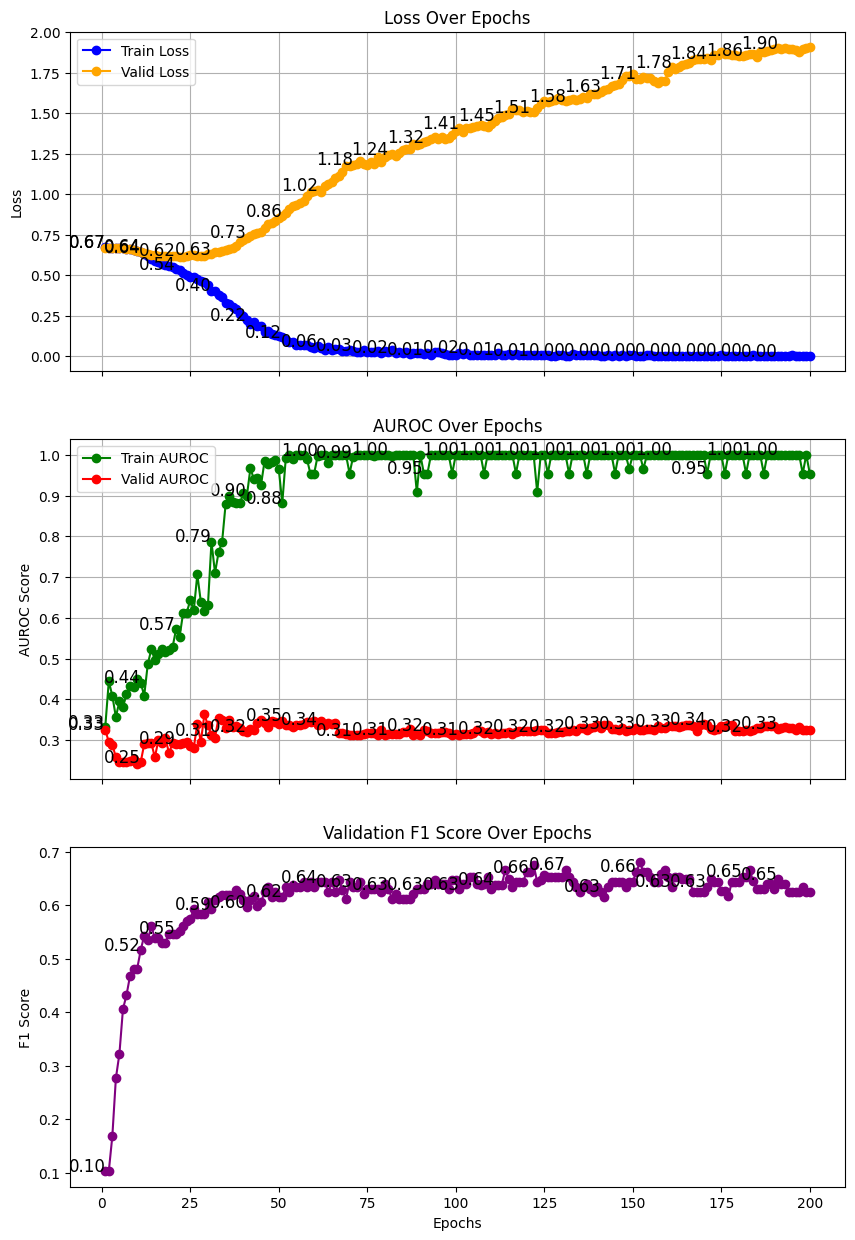

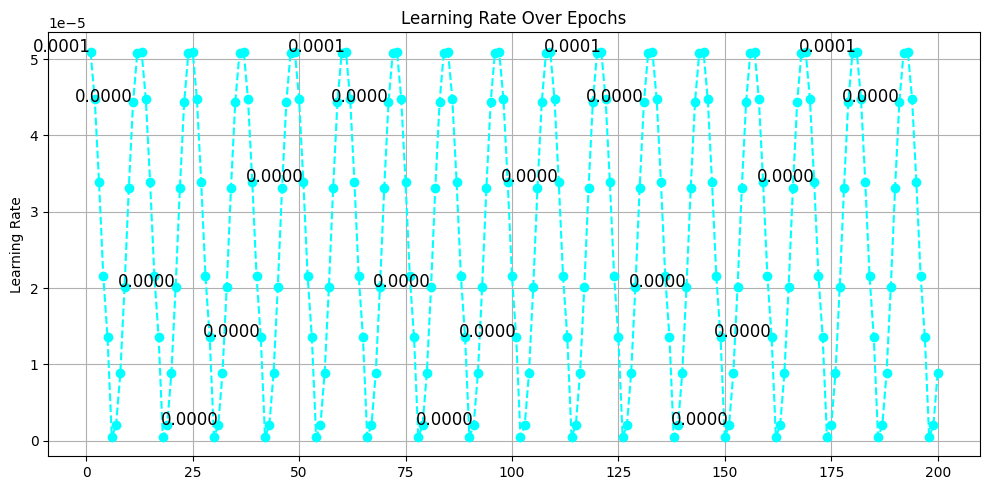

In [34]:
plot_metrics(history)